# **Emotion-based Highlight Detection for Youtube Video with Multimodal**




---



#Table of Contents

###[Original Plan]
<ol type = "1">
<li> Motivation & Problem Definition</li>
</ol>

###[Our Project]
Part 0. DataSets
<ol type = "1">
<li> Introduction</li>
<li> EDA</li>
</ol>


Part 1. Model Architecture





Part 2. Audio Emotion Classification
<ol type = "1">
<li>   Data Preprocessing</li>
</oi>




Part 3. Audio Highlight Extraction
<ol type = "1">
<li>   Trials & Choices</li>
<li>   Final Result</li>
<li>   Analysis</li>
</oi>

Part 4. Video Highlight Extraction
<ol type = "1">
<li>   Trials & Choices</li>
<li>   Final Result</li>
<li>   Analysis</li>
</oi>

Part 5. Multimodal Highlight Extraction

Part 6. Result

Part 7. Discussion


#Original Plan
##Emotion-based Highlight Detection for Youtube Video with Multimodal


###I. Motivation & Problem Definition
> Motivation

With the recent advancement of online video services and social media, there is a growing demand for 'short-form content' that can be consumed in a brief period.

Table 1, displaying the results of a survey conducted on 5,000 individuals aged 15 to 59 in South Korea, illustrates the increase in the usage of short-form content over the past year. As indicated in Table 1, the number of users who watched short-form content has increased by more than 10% in the last year.

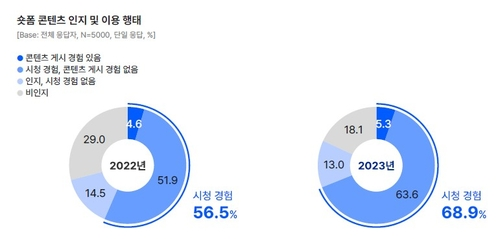

> Problem Definition

In today's society, where a large amount of information is generated and shared, content consumers have become accustomed to videos that are less than one minute long. There is a tendency to skip through long videos without watching them to the end and move on to the next one.
From the perspective of video content creators, manually editing long videos which are the source of short-form content, to extract highlight is highly inefficient and demands a significant amount of time and resources.

> Emotion-based Multimodal Model for Video Highlight Detection

Analyzing emotional information from audio can identify emotionally significant parts in long videos. And, It can reduce the effort required for manual highlight detection.

Research on video highlight detection utilizing various modalities within videos, such as voice, images, and chat, has been conducted. However, approaches using emotional information from voice have not been addressed.

In this study, we propose a multimodal approach that utilizes video and emotional information from audio for video highlight detection.
Additionally, various deep learning models were considered for the classification of emotional information within audio, and the results of each model were compared and analyzed.
<br>

#Our Project


# Part 0 - Datasets

## 1) Introduction
- **Data 1: ETRI Korean Emotion Dataset - KEMDy20 (General Public Free Speech) Dataset**

  - **Link**: [KEMDy20\_Dataset](https://nanum.etri.re.kr/share/kjnoh/KEMDy20?lang=ko_KR)
  - **Introduction**: A multimodal emotion dataset collected for the analysis of the correlation between emotional speech, contextual meaning of speech, and physiological response signals such as skin conductance, heart rate-related data, and wrist skin temperature.
  - **Train set**
    - Download path: '01.데이터/2.Validation/원천데이터/VS\_유튜브\_04'
    - Only the video data within the smallest 21.4GB folder is used.
  - **Test set**
    - Download path: '01.데이터/2.Validation/원천데이터/VS\_유튜브\_01'
    - Only 8 video data within the folder are used
      - '유튜브*기타\_19843', '유튜브*반려동물및동물*2153', '유튜브*스타일링및뷰티*14630', '유튜브*스포츠*4174', '유튜브*여행*7640', '유튜브*음식*17341', '유튜브*일상*10479', '유튜브*자동차\_0094'

- **Data 2: AI HUB Video Content Highlight Editing and Description (Summarization) Data**
  - **Link**: [AIHUB\_Dataset](https://www.aihub.or.kr/aihubdata/data/view.do?dataSetSn=616)
  - **Information**: The AI HUB dataset on video content highlight editing and description (summarization) is a training dataset constructed by labeling the positions of key scenes in news and YouTube videos and tagging them for category items



## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/AI/Team_project

/content/drive/MyDrive/AI/Team_project


In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to='.'):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Files extracted successfully to {extract_to}")
    except Exception as e:
        print(f"An error occurred: {e}")

unzip_file('audio_data.zip', 'audio_data')

Files extracted successfully to audio_data


## 2) EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import tensorflow as tf
from tqdm import tqdm
from glob import glob

import librosa
import librosa.display as dsp
import IPython.display as ipd

warnings.filterwarnings(action='ignore')

In [ ]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
audio_data_path = 'audio_data'
audio_train_data_path = os.path.join(audio_data_path,'train')
audio_test_data_path = os.path.join(audio_data_path,'test')
train = pd.read_csv(os.path.join(audio_data_path,'train.csv'))
test = pd.read_csv(os.path.join(audio_data_path,'test.csv'))

print(train.shape)
print(test.shape)

(10769, 6)
(2693, 6)


In [ ]:
train.head()

Unnamed: 0                     SegmentId       time  Emotion  Valence  \
0       11164  Sess26_script04_User052F_010   7.785990  neutral      3.0   
1       13031  Sess24_script03_User047F_009  12.188990    happy      3.4   
2        1147  Sess09_script01_User018M_030   4.147000  neutral      2.6   
3        6435  Sess14_script02_User028M_002   1.556999  neutral      3.6   
4        7053  Sess32_script01_User064F_049   5.443000  neutral      3.0   

   Arousal  
0      3.5  
1      3.6  
2      3.1  
3      3.1  
4      3.5

In [ ]:
sr = 20000 # Sound tuning hyperparameters

In [ ]:
for i in os.listdir(audio_train_data_path)[:3]:
  print(f'{i}')
  data, sample_rate = librosa.load(os.path.join(audio_train_data_path,i), sr=sr)
  print('sample_rate:', sample_rate, ', audio shape:', data.shape)
  print('length:', data.shape[0]/float(sample_rate), 'secs')
  print('\n')

Sess01_script01_User001F_001.wav
sample_rate: 20000 , audio shape: (41720,)
length: 2.086 secs


Sess01_script01_User001F_002.wav
sample_rate: 20000 , audio shape: (57860,)
length: 2.893 secs


Sess01_script01_User001F_003.wav
sample_rate: 20000 , audio shape: (395320,)
length: 19.766 secs




In [ ]:
train["Emotion"].unique()
train.head()

Unnamed: 0                     SegmentId       time  Emotion  Valence  \
0       11164  Sess26_script04_User052F_010   7.785990  neutral      3.0   
1       13031  Sess24_script03_User047F_009  12.188990    happy      3.4   
2        1147  Sess09_script01_User018M_030   4.147000  neutral      2.6   
3        6435  Sess14_script02_User028M_002   1.556999  neutral      3.6   
4        7053  Sess32_script01_User064F_049   5.443000  neutral      3.0   

   Arousal  
0      3.5  
1      3.6  
2      3.1  
3      3.1  
4      3.5

{'neutral': 8880, 'happy': 962, 'angry;neutral': 68, 'happy;neutral': 275, 'happy;surprise': 5, 'surprise': 122, 'angry': 112, 'neutral;sad': 59, 'sad': 95, 'surprise;neutral': 47, 'angry;neutral;disqust': 2, 'happy;fear': 1, 'disqust': 46, 'neutral;fear': 16, 'neutral;disqust': 35, 'fear': 37, 'happy;surprise;neutral': 1, 'angry;disqust': 2, 'happy;angry;neutral': 1, 'happy;neutral;fear': 1, 'happy;sad': 1, 'happy;neutral;disqust': 1}


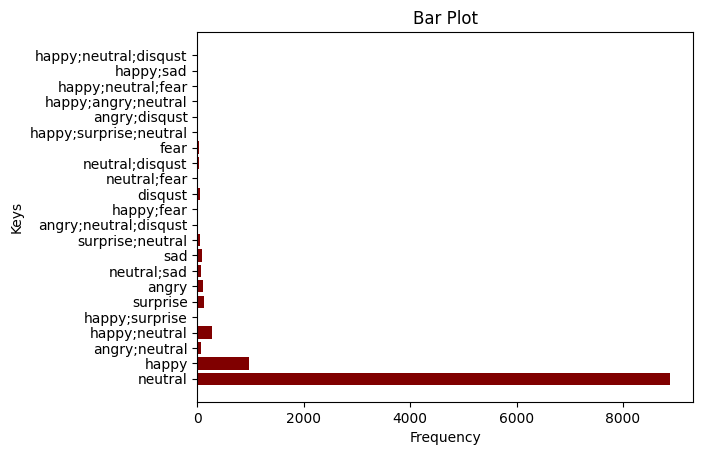

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# frequency
data = train["Emotion"]

counts = {}
for d in data:
    if d in counts:
        counts[d] += 1
    else:
        counts[d] = 1


print(counts)
# barplot
plt.barh(list(counts.keys()), list(counts.values()), color='maroon')

# Add graph title and label
plt.title('Bar Plot')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

{'happy': 962, 'angry;neutral': 68, 'happy;neutral': 275, 'happy;surprise': 5, 'surprise': 122, 'angry': 112, 'neutral;sad': 59, 'sad': 95, 'surprise;neutral': 47, 'angry;neutral;disqust': 2, 'happy;fear': 1, 'disqust': 46, 'neutral;fear': 16, 'neutral;disqust': 35, 'fear': 37, 'happy;surprise;neutral': 1, 'angry;disqust': 2, 'happy;angry;neutral': 1, 'happy;neutral;fear': 1, 'happy;sad': 1, 'happy;neutral;disqust': 1}


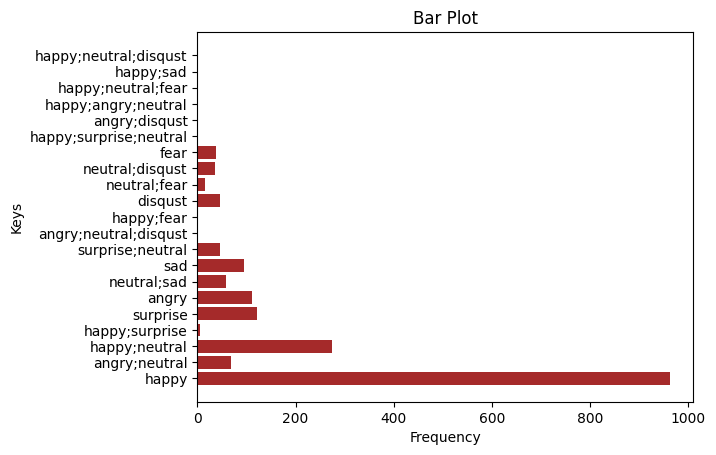

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Frequency
data = train["Emotion"]

counts = {}
for d in data:
    if d in counts:
        counts[d] += 1
    else:
        counts[d] = 1
counts.pop("neutral")

print(counts)

plt.barh(list(counts.keys()), list(counts.values()), color='brown')
plt.title('Bar Plot')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

happy angry;neutral happy;neutral happy;surprise surprise angry neutral;sad sad surprise;neutral angry;neutral;disqust happy;fear disqust neutral;fear neutral;disqust fear happy;surprise;neutral angry;disqust happy;angry;neutral happy;neutral;fear happy;sad happy;neutral;disqust
['fear', 'neutral', 'disqust', 'angry', 'happy', 'sad', 'surprise']
{'fear': 55, 'neutral': 9386, 'disqust': 86, 'angry': 185, 'happy': 1248, 'sad': 155, 'surprise': 175}


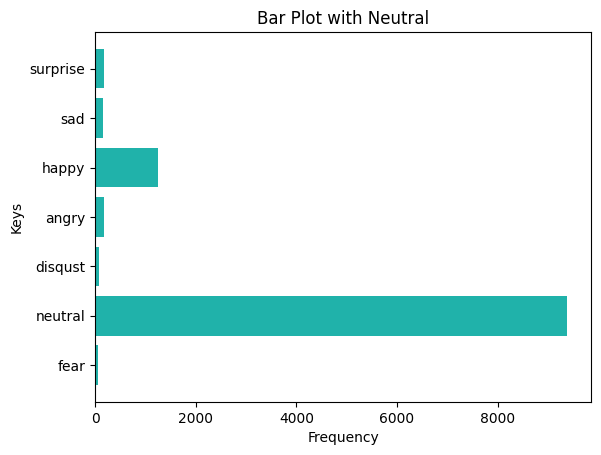

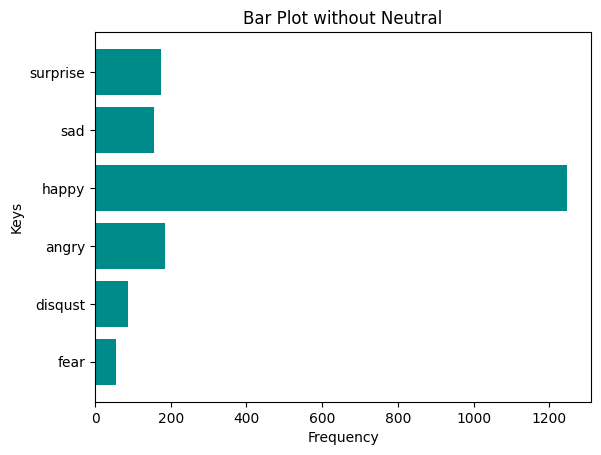

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = train["Emotion"]

counts = {}
for d in data:
    if d in counts:
        counts[d] += 1
    else:
        counts[d] = 1
counts.pop("neutral")
key = list(counts.keys())
str_key = " ".join(key)
print(str_key)
str_key1= str_key.split(";") # Combine all emotion strings and split by semicolon
for i in range(len(str_key1)):
  str_key1[i]=str_key1[i].split(" ")
str_key = sum(str_key1,[])
# Remove duplicate values
str_key = list(set(str_key))
print(str_key)



data = train["Emotion"]

counts = dict.fromkeys(str_key,0)
for i in range(len(data)):
  for j in str_key:
    if j in data[i]:
      counts[j] += 1
    else:
      continue

print(counts)


# barplot before removing neutral
plt.barh(list(counts.keys()), list(counts.values()), color='lightseagreen')

# Add graph title and label
plt.title('Bar Plot with Neutral')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

# barplot after removing neutral
counts.pop("neutral")

plt.barh(list(counts.keys()), list(counts.values()), color='darkcyan')


plt.title('Bar Plot without Neutral')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

# Part 1 - Model Architecture

**STEP 1**
- Using the ETRI dataset to train a audio Emotion classification model.
- Emotion Classification model Type : LSTM, 1D CNN, LSTM with Attention, GRU

**STEP 2**
- The MFCC extracted from the voice in the AI Hub YouTube video was then combined with the output tensors inferred by the three trained models into a single vector

**STEP 3**
- For video image feature extraction, pre-trained ViT models are used to perform feature exraction on an image frame-by-frame basis

**STEP 4**
- Finally **LSTM-based Multimodal Highlight Detection Model
using Video and Audio Emotional Information** combines feature
vectors extracted from audio and video to detect highlights in every
second frame of the video.

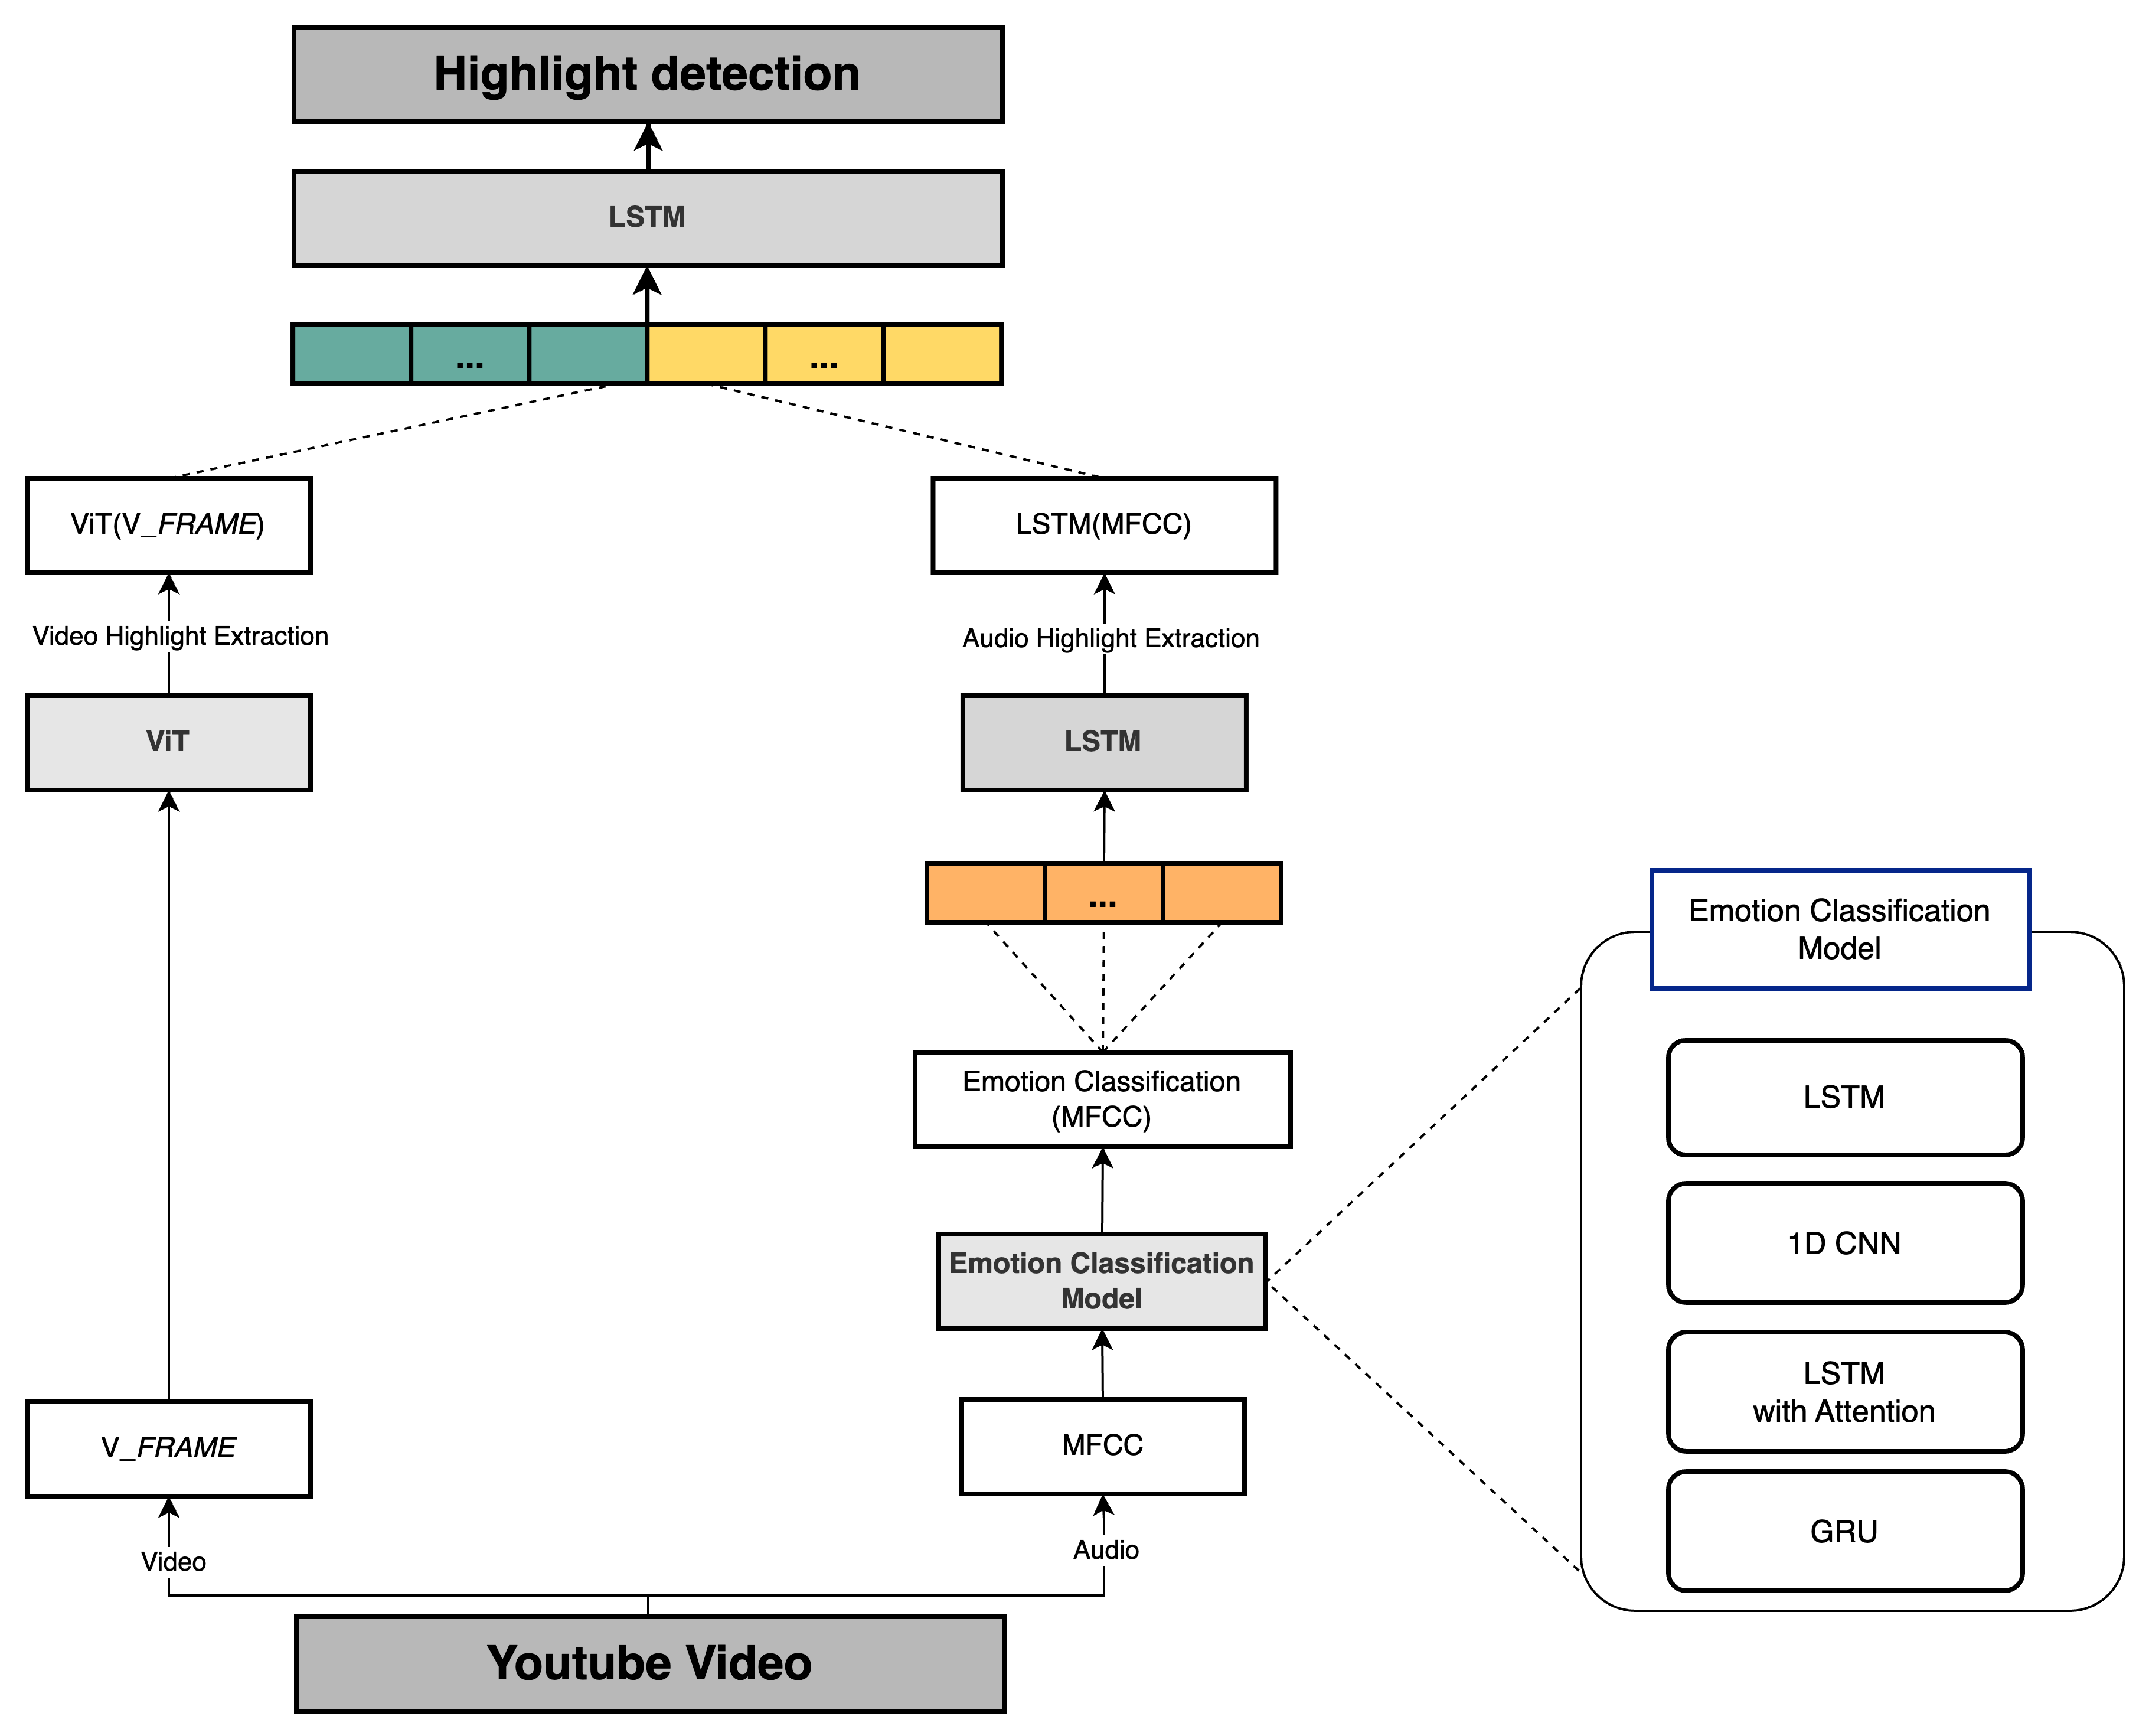

# Part 2 - Audio Emotion Classification

---


## 1) Data Preprocessing

### Make MFCC feature ".csv" file

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import librosa

import pickle

from tqdm.auto import tqdm

from sklearn.preprocessing import OneHotEncoder

import argparse
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings(action='ignore')

CFG = {
    'SR':16000,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(41) # Seed 고정

In [ ]:
audio_data_path = 'audio_data'
audio_train_data_path = os.path.join(audio_data_path,'train')
audio_test_data_path = os.path.join(audio_data_path,'test')
train_df = pd.read_csv(os.path.join(audio_data_path,'train.csv'))
test_df = pd.read_csv(os.path.join(audio_data_path,'test.csv'))

In [ ]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = './audio_data'
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['SegmentId']):
        root_path = os.path.join(root_folder, data_type)
        uid += '.wav'
        path = os.path.join(root_path, uid)

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])

        # mfcc
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [ ]:
get_mfcc_feature(train_df, 'train', 'preprocessing_csv/train_mfcc_data.csv')
get_mfcc_feature(test_df, 'test', 'preprocessing_csv/test_mfcc_data.csv')

preprocessing_csv/train_mfcc_data.csv is exist.
preprocessing_csv/test_mfcc_data.csv is exist.


### Load MFCC features

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import librosa

import pickle

from tqdm.auto import tqdm

from sklearn.preprocessing import OneHotEncoder

import argparse
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings(action='ignore')

CFG = {
    'SR':16000,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(41) # Seed 고정

In [ ]:
# wav 파일의 mel Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv('preprocessing_csv/train_mfcc_data.csv')
test_df = pd.read_csv('preprocessing_csv/test_mfcc_data.csv')

['neutral', 'happy', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'happy', 'neutral', 'neutral', 'happy', 'neutral', 'neutral', 'angry', 'happy', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral']


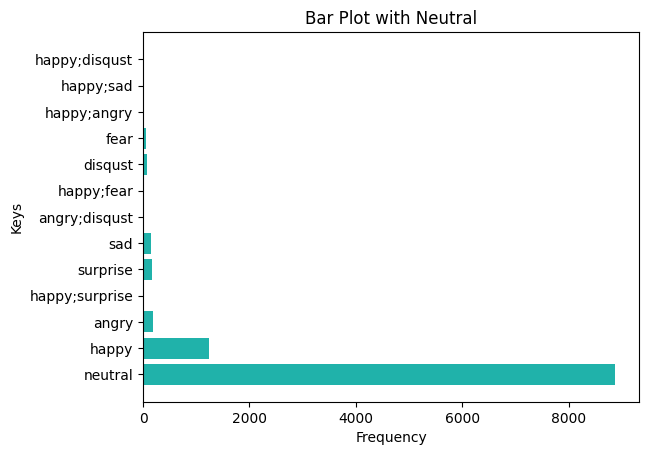

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data_train = train_df["Emotion"]
data_test = test_df["Emotion"]

newEmotion_tr = [0]*train_df.shape[0]
newEmotion_te = [0]*test_df.shape[0]

for i in range(len(data_train)):
    if ';neutral' in data_train[i]:
        new_emotion_lst = data_train[i].split(";neutral")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_tr[i] = new_emotion
    elif 'neutral;' in data_train[i]:
        new_emotion_lst = data_train[i].split("neutral;")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_tr[i] = new_emotion
    else:
        newEmotion_tr[i]= data_train[i]


for i in range(len(data_test)):
    if ';neutral' in data_test[i]:
        new_emotion_lst = data_test[i].split(";neutral")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_te[i] = new_emotion
    elif 'neutral;' in data_test[i]:
        new_emotion_lst = data_test[i].split("neutral;")
        new_emotion = "".join(new_emotion_lst)
        newEmotion_te[i] = new_emotion
    else:
        newEmotion_te[i]= data_test[i]


print(newEmotion_tr[:30])

counts = {}
for d in newEmotion_tr:
    if d in counts:
        counts[d] += 1
    else:
        counts[d] = 1

# Emotion별 원소 개수 확인
plt.barh(list(counts.keys()), list(counts.values()), color='lightseagreen')
plt.title('Bar Plot with Neutral')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

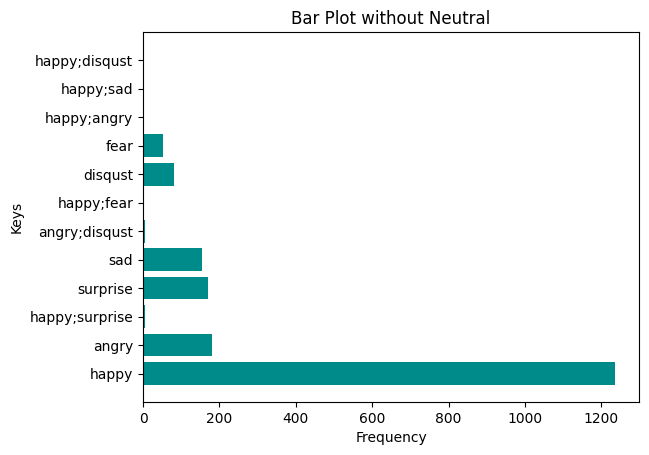

In [ ]:
# neutral 제거 후 barplot
counts.pop("neutral")

plt.barh(list(counts.keys()), list(counts.values()), color='darkcyan')

# 그래프 제목과 레이블 추가
plt.title('Bar Plot without Neutral')
plt.xlabel('Frequency')
plt.ylabel('Keys')

plt.show()

In [ ]:
newEmotion_tr_df = pd.DataFrame(newEmotion_tr, columns=['newEmotion'])
newEmotion_te_df = pd.DataFrame(newEmotion_te, columns=['newEmotion'])

### Make Train, Test Data Frame

In [ ]:
train_df = pd.concat([train_df, newEmotion_tr_df], axis=1)
test_df = pd.concat([test_df, newEmotion_te_df], axis=1)

train_df = train_df.drop(['Emotion'], axis=1)
test_df = test_df.drop(['Emotion'], axis=1)
print(train_df.shape)
print(test_df.shape)

(10769, 38)
(2693, 38)


In [ ]:
train_df.dropna()
test_df.dropna()

Unnamed: 0                     SegmentId       time  Valence  Arousal  \
0             63  Sess13_script01_User026F_029   7.254990      3.7      3.5   
1           5163  Sess03_script03_User005M_021   2.212000      2.9      3.4   
2           7844  Sess23_script02_User046M_022   9.281020      2.3      3.0   
3            304  Sess13_script05_User026F_017   6.614991      4.4      4.2   
4           5216  Sess03_script04_User005M_008   3.404998      1.6      3.2   
...          ...                           ...        ...      ...      ...   
2688        8873  Sess39_script05_User078F_007   4.404998      3.0      3.0   
2689       11974  Sess37_script05_User073F_012   6.781000      2.6      3.2   
2690       10559  Sess33_script04_User065M_028   3.066020      3.4      3.4   
2691        3076  Sess02_script02_User003F_001  12.123001      2.4      2.6   
2692       11617  Sess25_script05_User050F_018   2.240010      3.2      3.3   

          mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5  ...    mfcc_24  \
0    -336.985138  106.803337   4.534938  10.542789 -19.378389  ...   8.967966   
1    -337.904297  105.446899  11.310282  24.076952  -6.819501  ...  -4.050204   
2    -419.555511  125.555763  18.391697  30.752876  -5.573301  ...  -3.478583   
3    -261.221222  108.892136 -26.196730   9.421447 -25.387993  ...  13.833956   
4    -346.095032  101.206184  21.618317  20.990105 -11.223962  ...  -0.532429   
...          ...         ...        ...        ...        ...  ...        ...   
2688 -452.831024   80.856758  19.427954  32.913322  -3.974150  ...   1.763288   
2689 -450.678375   98.769257  -4.727075   7.584974 -11.716160  ...   3.983363   
2690 -371.517609  117.556679   5.498871  27.535383   7.929699  ...  -1.782557   
2691 -375.577759  106.716896   2.852894  26.215828 -20.312307  ...   4.127676   
2692 -469.148651   96.403061  26.530113   8.035880  -2.224418  ...   5.588368   

       mfcc_25    mfcc_26    mfcc_27   mfcc_28   mfcc_29    mfcc_30   mfcc_31  \
0     8.074034  11.653221  11.598641  8.817598  9.400865   8.987887  5.992146   
1    -3.444622  -0.045880  -2.624972 -0.375320 -1.709600  -1.171931 -4.099090   
2    -2.749439   1.098240   1.010692  0.460480 -1.992547   1.084825 -0.576132   
3     7.379666   8.362466   1.706965  5.596114  5.339090   5.811155  1.621077   
4    -1.102016   1.010110  -1.844896 -1.788239  0.140551  -2.089751 -1.204731   
...        ...        ...        ...       ...       ...        ...       ...   
2688  2.534321   1.811994   4.191569  6.094894  5.072481   7.664765  4.959315   
2689  4.685560   2.902997   0.235584  2.744654  1.443039   5.997917  3.257085   
2690 -2.510203  -2.095202  -3.341051 -1.580801 -0.980542   0.799156 -2.367372   
2691  8.754350   5.358984   4.600071  9.529908  5.941333  14.158734  8.534500   
2692  4.237176   7.683784   0.811043  1.432141  1.804263   4.709819  1.102094   

        mfcc_32  newEmotion  
0      4.622094       happy  
1     -1.587989    surprise  
2      0.662649     neutral  
3      3.745970       happy  
4     -1.450962       angry  
...         ...         ...  
2688   4.205091     neutral  
2689   5.762399     neutral  
2690   0.982645     neutral  
2691  10.391392     neutral  
2692  -0.579098     neutral  

[2693 rows x 38 columns]

In [ ]:
condition = (
    (train_df.newEmotion == 'neutral') |
    (train_df.newEmotion == 'happy')|
    (train_df.newEmotion == 'angry') |
    (train_df.newEmotion == 'surprise') |
    (train_df.newEmotion == 'sad') |
    (train_df.newEmotion == 'disqust')|
    (train_df.newEmotion == 'fear')
)

train_df = train_df.loc[condition]
train_df = train_df.reset_index(drop=True)

condition = (
    (test_df.newEmotion == 'neutral') |
    (test_df.newEmotion == 'happy')|
    (test_df.newEmotion == 'angry') |
    (test_df.newEmotion == 'surprise') |
    (test_df.newEmotion == 'sad') |
    (test_df.newEmotion == 'disqust')|
    (test_df.newEmotion == 'fear')
)

test_df = test_df.loc[condition]
test_df = test_df.reset_index(drop=True)

print(train_df.shape)
print(test_df.shape)

(10754, 38)
(2686, 38)


In [ ]:
train_df['newEmotion'] = train_df['newEmotion'].replace(['neutral',
                                                         'happy',
                                                         'angry',
                                                         'surprise',
                                                         'sad',
                                                         'disqust',
                                                         'fear'],
                                                        [0,1,2,3,4,5,6])
test_df['newEmotion'] = test_df['newEmotion'].replace(['neutral',
                                                         'happy',
                                                         'angry',
                                                         'surprise',
                                                         'sad',
                                                         'disqust',
                                                         'fear'
                                                      ],[0,1,2,3,4,5,6])
print(train_df.shape)
print(test_df.shape)

(10754, 38)
(2686, 38)


### Reduce Neutral Data by using KNN

In [ ]:
import numpy as np

# train 데이터셋에서 중립 데이터 개수 줄이기
neutral_indices = np.where(train_df['newEmotion'] == 0)[0]

# # 중립 데이터 중 일부를 삭제
num_to_delete = 5000
delete_indices = np.random.choice(neutral_indices, size=num_to_delete, replace=False)
#print(delete_indices.shape)
# # 추출한 인덱스를 사용하여 중립 데이터를 삭제합니다.
#print(train_df.shape)
train_df = train_df.drop(delete_indices, axis=0)
print(train_df.shape)


## test 데이터 중립 데이터 개수 줄이기
neutral_indices = np.where(test_df['newEmotion'] == 0)[0] # 인덱스 추출

# # 중립 데이터 중 일부를 삭제
num_to_delete = 1000
delete_indices = np.random.choice(neutral_indices, size=num_to_delete, replace=False)
#print(delete_indices.shape)
# # 추출한 인덱스를 사용하여 중립 데이터를 삭제합니다.
#print(train_df.shape)
test_df = test_df.drop(delete_indices, axis=0)
print(test_df.shape)

(5754, 38)
(1686, 38)


In [ ]:
train_df['newEmotion'].value_counts()

0    3880
1    1237
2     180
3     169
4     154
5      81
6      53
Name: newEmotion, dtype: int64

In [ ]:
test_df['newEmotion'].value_counts()

0    1240
1     291
2      47
3      43
4      38
5      20
6       7
Name: newEmotion, dtype: int64

In [ ]:
# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','newEmotion'])
train_y = train_df['newEmotion']
test_x = test_df.drop(columns=['Unnamed: 0', 'SegmentId','time','Valence','Arousal','newEmotion'])
test_y = test_df['newEmotion']

Text(0, 0.5, 'Number of Samples')

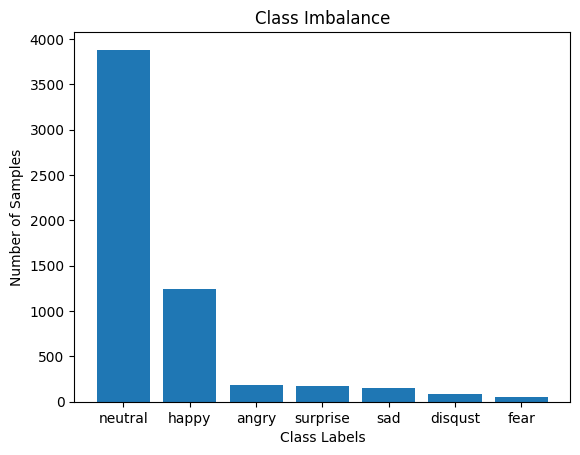

In [ ]:
import matplotlib.pyplot as plt
labels =['neutral', 'happy','angry','surprise','sad','disqust','fear']
counts = train_y.value_counts().tolist()
# 그래프 그리기
plt.bar(labels, counts)

# 그래프 타이틀, 라벨 등 설정
plt.title('Class Imbalance')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

### SMOTE (Oversampling)

Text(0, 0.5, 'Number of Samples')

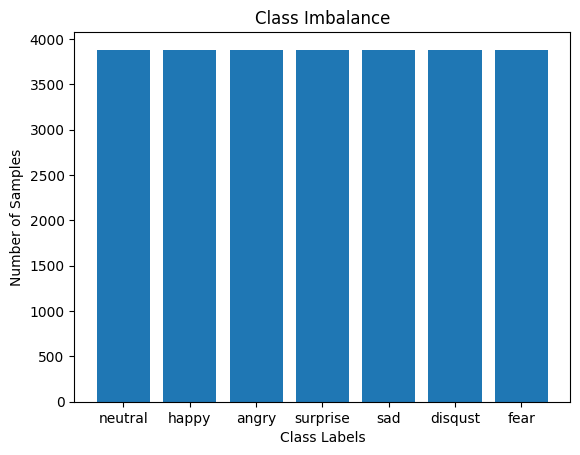

In [ ]:

from imblearn.over_sampling import SMOTE

sm=SMOTE(k_neighbors=2, random_state=0) #same size of the training data set as random over sampling
X_train_resampled_sm, Y_train_resampled_sm = sm.fit_resample(train_x,train_y)
X_test_resampled_sm, Y_test_resampled_sm = sm.fit_resample(test_x,test_y)
import matplotlib.pyplot as plt
labels =['neutral', 'happy','angry','surprise','sad','disqust','fear']
counts = Y_train_resampled_sm.value_counts().tolist()
# 그래프 그리기
plt.bar(labels, counts)

# 그래프 타이틀, 라벨 등 설정
plt.title('Class Imbalance')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

In [ ]:
Y_train_resampled_sm.value_counts()

0    3880
1    3880
2    3880
3    3880
4    3880
5    3880
6    3880
Name: newEmotion, dtype: int64

In [ ]:
X_train_resampled_sm.shape

(27160, 32)

In [ ]:
X_train_resampled_sm = torch.from_numpy(X_train_resampled_sm.to_numpy()).float()
Y_train_resampled_sm = torch.tensor(Y_train_resampled_sm)

In [ ]:
X_train_resampled_sm.shape, Y_train_resampled_sm.shape

(torch.Size([27160, 32]), torch.Size([27160]))

In [ ]:
X_test_resampled_sm = torch.from_numpy(X_test_resampled_sm.to_numpy()).float()
Y_test_resampled_sm = torch.tensor(Y_test_resampled_sm)

In [ ]:
X_test_resampled_sm.shape, Y_test_resampled_sm.shape

(torch.Size([8680, 32]), torch.Size([8680]))

In [ ]:
with open('pickle/X_train_resampled_sm.pkl', 'wb') as file:
    pickle.dump(X_train_resampled_sm, file)

with open('pickle/y_train_resampled_sm.pkl', 'wb') as file:
    pickle.dump(Y_train_resampled_sm, file)

with open('pickle/X_test_resampled_sm.pkl', 'wb') as file:
    pickle.dump(X_test_resampled_sm, file)

with open('pickle/y_test_resampled_sm.pkl', 'wb') as file:
    pickle.dump(Y_test_resampled_sm, file)

### Load X_train, Y_train, X_test, Y_test


In [ ]:
import pickle

# Define file path
x_train_path = 'pickle/X_train_resampled_sm.pkl'
y_train_path = 'pickle/y_train_resampled_sm.pkl'
x_test_path = 'pickle/X_test_resampled_sm.pkl'
y_test_path = 'pickle/y_test_resampled_sm.pkl'

# Load X_train
with open(x_train_path, 'rb') as file:
    X_train_resampled_sm = pickle.load(file)

# Load y_train
with open(y_train_path, 'rb') as file:
    Y_train_resampled_sm = pickle.load(file)

# Load X_test
with open(x_test_path, 'rb') as file:
    X_test_resampled_sm = pickle.load(file)

# Load y_test
with open(y_test_path, 'rb') as file:
    Y_test_resampled_sm = pickle.load(file)


In [ ]:
print(X_train_resampled_sm.shape, Y_train_resampled_sm.shape)
print(X_test_resampled_sm.shape, Y_test_resampled_sm.shape)

torch.Size([27160, 32]) torch.Size([27160])
torch.Size([8680, 32]) torch.Size([8680])


## 2) Train & Evaluation Audio Emotion Classification Model

### Define 1) LSTM, 2) 1D CNN 3) LSTM with Attention, 4) GRU Model

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,  dropout_rate = 0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        output = self.fc(out[:,-1,:])
        hidden = self.fc(hidden_state[-1])
        output = F.softmax(output,dim=1)
        return output, hidden,  out[:,-1,:]

In [ ]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, num_channels, hidden_size):
        super(CNN, self).__init__()
        self.conv1d = nn.Conv1d(1, num_channels, kernel_size=kernel_size, stride=stride)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_channels * (input_size - kernel_size + 1), hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.flatten(x)
        hidden = self.fc1(x)  # These are the hidden features
        x = self.relu(hidden)
        x = self.fc2(x)
        output = self.softmax(x)
        return output, hidden


In [ ]:
# Create LSTM with Attention Model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        # Compute attention weights
        attention_weights = F.softmax(self.attention(out), dim=1)

        # Apply attention to LSTM outputs
        attention_output = torch.sum(attention_weights * out, dim=1)

        # Apply fully connected layer
        output = self.fc(attention_output)
        output = F.softmax(output, dim=1)

        return output, attention_weights


In [ ]:
## GRU
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hidden_state = self.gru(x, h0)

        output = self.fc(out[:, -1, :])
        hidden = self.fc(hidden_state[-1])
        output = F.softmax(output, dim=1)
        return output, hidden, out[:, -1, :]


### Train Four Models

In [ ]:
import torch.nn.functional as F

# Hyperparameters

loss= "fl"
learning_rate = 0.001
epochs = 100
input_size = 32
hidden_size = 128
output_size = 7
num_layers = 3
kernel_size = 3
num_channels = 16
stride = 1

# LSTM
lstm_model =LSTM(input_size, hidden_size, num_layers, output_size)
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate,weight_decay=1e-5)

# CNN
cnn_model = CNN(input_size, output_size, kernel_size, stride, num_channels, hidden_size)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate, weight_decay=1e-5)

# LSTM with attention
lstm_attention_model = LSTMWithAttention(input_size, hidden_size, num_layers, output_size)
lstm_attention_criterion = nn.CrossEntropyLoss()
lstm_attention_optimizer = torch.optim.Adam(lstm_attention_model.parameters(), lr=learning_rate, weight_decay=1e-5)

# gru
gru_model=GRU(input_size, hidden_size, num_layers, output_size)
gru_criterion = nn.CrossEntropyLoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate,weight_decay=1e-5)





#### 1) LSTM

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import torch.nn as nn
Y_train_resampled_sm = Y_train_resampled_sm.long()
min_f1=0
loss_lstm_lst=[]
for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
    lstm_optimizer.zero_grad()

    lstm_model.train()

    # Forward pass with dropout
    X_train_resampled_sm_drop = nn.Dropout(p=0.5)(X_train_resampled_sm.unsqueeze(1))
    output, hidden_state, _ = lstm_model(X_train_resampled_sm_drop)

    # Compute loss
    loss_lstm = lstm_criterion(output.squeeze(), Y_train_resampled_sm)


    # Backward and optimize
    loss_lstm_lst.append(loss_lstm.item())
    loss_lstm.backward()
    lstm_optimizer.step()
    tqdm.write('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss_lstm.item()))

    lstm_model.eval()
    with torch.no_grad():
        predictions, hidden, out = lstm_model(X_test_resampled_sm.unsqueeze(1))
        y_pred = predictions.argmax(dim=1)

        f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
        if f1 > min_f1:
            min_f1 = f1
            print(f'min_f1: {min_f1}')
            torch.save(lstm_model.state_dict(), f'model/emotion/lstm_emotion_classification_model_best.pt')


Training:   0%|          | 0/100 [00:06<?, ?epoch/s]

Epoch [1/100], Loss: 1.9459
min_f1: 0.03571428571428571


Training:   1%|          | 1/100 [00:10<12:35,  7.63s/epoch]

Epoch [2/100], Loss: 1.9459


Training:   2%|▏         | 2/100 [00:13<08:06,  4.96s/epoch]

Epoch [3/100], Loss: 1.9459


Training:   3%|▎         | 3/100 [00:17<06:32,  4.05s/epoch]

Epoch [4/100], Loss: 1.9458


Training:   5%|▌         | 5/100 [00:21<06:07,  3.87s/epoch]

Epoch [5/100], Loss: 1.9458


Training:   5%|▌         | 5/100 [00:23<06:07,  3.87s/epoch]

Epoch [6/100], Loss: 1.9457


Training:   7%|▋         | 7/100 [00:26<05:03,  3.27s/epoch]

Epoch [7/100], Loss: 1.9457
min_f1: 0.03873555904324398


Training:   7%|▋         | 7/100 [00:29<05:03,  3.27s/epoch]

Epoch [8/100], Loss: 1.9456
min_f1: 0.0805783216327368


Training:   8%|▊         | 8/100 [00:33<04:46,  3.12s/epoch]

Epoch [9/100], Loss: 1.9456


Training:   9%|▉         | 9/100 [00:33<05:07,  3.38s/epoch]

min_f1: 0.10097208339932794


Training:   9%|▉         | 9/100 [00:37<05:07,  3.38s/epoch]

Epoch [10/100], Loss: 1.9455


Training:  10%|█         | 10/100 [00:38<05:40,  3.78s/epoch]

min_f1: 0.11009445928261344


Training:  11%|█         | 11/100 [00:40<05:05,  3.43s/epoch]

Epoch [11/100], Loss: 1.9454
min_f1: 0.11320020559150994


Training:  12%|█▏        | 12/100 [00:43<04:36,  3.15s/epoch]

Epoch [12/100], Loss: 1.9453


Training:  12%|█▏        | 12/100 [00:46<04:36,  3.15s/epoch]

Epoch [13/100], Loss: 1.9451
min_f1: 0.15342289480877652


Training:  13%|█▎        | 13/100 [00:50<04:46,  3.29s/epoch]

Epoch [14/100], Loss: 1.9450
min_f1: 0.1627614797446692


Training:  14%|█▍        | 14/100 [00:54<04:54,  3.42s/epoch]

Epoch [15/100], Loss: 1.9448


Training:  16%|█▌        | 16/100 [00:58<05:13,  3.73s/epoch]

Epoch [16/100], Loss: 1.9446


Training:  17%|█▋        | 17/100 [01:01<04:43,  3.42s/epoch]

Epoch [17/100], Loss: 1.9443


Training:  18%|█▊        | 18/100 [01:04<04:24,  3.22s/epoch]

Epoch [18/100], Loss: 1.9439


Training:  18%|█▊        | 18/100 [01:08<04:24,  3.22s/epoch]

Epoch [19/100], Loss: 1.9435


Training:  20%|██        | 20/100 [01:13<05:14,  3.94s/epoch]

Epoch [20/100], Loss: 1.9429


Training:  20%|██        | 20/100 [01:16<05:14,  3.94s/epoch]

Epoch [21/100], Loss: 1.9423


Training:  22%|██▏       | 22/100 [01:19<04:17,  3.30s/epoch]

Epoch [22/100], Loss: 1.9417


Training:  23%|██▎       | 23/100 [01:21<03:56,  3.08s/epoch]

Epoch [23/100], Loss: 1.9407


Training:  24%|██▍       | 24/100 [01:24<03:44,  2.95s/epoch]

Epoch [24/100], Loss: 1.9398


Training:  24%|██▍       | 24/100 [01:28<03:44,  2.95s/epoch]

Epoch [25/100], Loss: 1.9387


Training:  26%|██▌       | 26/100 [01:32<04:12,  3.42s/epoch]

Epoch [26/100], Loss: 1.9371


Training:  27%|██▋       | 27/100 [01:34<03:50,  3.16s/epoch]

Epoch [27/100], Loss: 1.9355


Training:  28%|██▊       | 28/100 [01:37<03:35,  3.00s/epoch]

Epoch [28/100], Loss: 1.9341


Training:  29%|██▉       | 29/100 [01:40<03:27,  2.92s/epoch]

Epoch [29/100], Loss: 1.9321


Training:  30%|███       | 30/100 [01:43<03:33,  3.05s/epoch]

Epoch [30/100], Loss: 1.9297


Training:  30%|███       | 30/100 [01:45<03:33,  3.05s/epoch]

Epoch [31/100], Loss: 1.9278


Training:  32%|███▏      | 32/100 [01:50<03:50,  3.39s/epoch]

Epoch [32/100], Loss: 1.9250


Training:  32%|███▏      | 32/100 [01:54<03:50,  3.39s/epoch]

Epoch [33/100], Loss: 1.9224


Training:  33%|███▎      | 33/100 [01:57<04:04,  3.65s/epoch]

Epoch [34/100], Loss: 1.9199


Training:  34%|███▍      | 34/100 [02:03<03:51,  3.51s/epoch]

Epoch [35/100], Loss: 1.9169


Training:  35%|███▌      | 35/100 [02:09<04:38,  4.28s/epoch]

Epoch [36/100], Loss: 1.9149


Training:  36%|███▌      | 36/100 [02:13<04:57,  4.65s/epoch]

Epoch [37/100], Loss: 1.9137


Training:  37%|███▋      | 37/100 [02:15<04:31,  4.30s/epoch]

Epoch [38/100], Loss: 1.9118


Training:  38%|███▊      | 38/100 [02:20<03:58,  3.85s/epoch]

Epoch [39/100], Loss: 1.9099


Training:  39%|███▉      | 39/100 [02:24<04:18,  4.23s/epoch]

Epoch [40/100], Loss: 1.9084


Training:  41%|████      | 41/100 [02:27<03:40,  3.74s/epoch]

Epoch [41/100], Loss: 1.9069


Training:  42%|████▏     | 42/100 [02:30<03:23,  3.51s/epoch]

Epoch [42/100], Loss: 1.9062


Training:  43%|████▎     | 43/100 [02:32<02:51,  3.01s/epoch]

Epoch [43/100], Loss: 1.9047


Training:  44%|████▍     | 44/100 [02:35<02:38,  2.83s/epoch]

Epoch [44/100], Loss: 1.9045


Training:  45%|████▌     | 45/100 [02:37<02:29,  2.72s/epoch]

Epoch [45/100], Loss: 1.9030


Training:  46%|████▌     | 46/100 [02:40<02:22,  2.64s/epoch]

Epoch [46/100], Loss: 1.9024


Training:  47%|████▋     | 47/100 [02:41<02:06,  2.38s/epoch]

Epoch [47/100], Loss: 1.9021


Training:  48%|████▊     | 48/100 [02:43<01:54,  2.20s/epoch]

Epoch [48/100], Loss: 1.9020


Training:  49%|████▉     | 49/100 [02:45<01:45,  2.07s/epoch]

Epoch [49/100], Loss: 1.9012


Training:  50%|█████     | 50/100 [02:47<01:39,  1.99s/epoch]

Epoch [50/100], Loss: 1.9004


Training:  51%|█████     | 51/100 [02:49<01:34,  1.94s/epoch]

Epoch [51/100], Loss: 1.9005


Training:  52%|█████▏    | 52/100 [02:51<01:36,  2.00s/epoch]

Epoch [52/100], Loss: 1.8985


Training:  53%|█████▎    | 53/100 [02:53<01:40,  2.13s/epoch]

Epoch [53/100], Loss: 1.8990


Training:  54%|█████▍    | 54/100 [02:56<01:42,  2.23s/epoch]

Epoch [54/100], Loss: 1.8997


Training:  55%|█████▌    | 55/100 [02:58<01:37,  2.16s/epoch]

Epoch [55/100], Loss: 1.8987


Training:  56%|█████▌    | 56/100 [02:59<01:30,  2.07s/epoch]

Epoch [56/100], Loss: 1.8984


Training:  57%|█████▋    | 57/100 [03:01<01:24,  1.98s/epoch]

Epoch [57/100], Loss: 1.8968


Training:  58%|█████▊    | 58/100 [03:03<01:20,  1.92s/epoch]

Epoch [58/100], Loss: 1.8968


Training:  59%|█████▉    | 59/100 [03:05<01:16,  1.87s/epoch]

Epoch [59/100], Loss: 1.8957


Training:  60%|██████    | 60/100 [03:07<01:16,  1.91s/epoch]

Epoch [60/100], Loss: 1.8942


Training:  61%|██████    | 61/100 [03:09<01:20,  2.06s/epoch]

Epoch [61/100], Loss: 1.8954


Training:  62%|██████▏   | 62/100 [03:12<01:22,  2.16s/epoch]

Epoch [62/100], Loss: 1.8937


Training:  63%|██████▎   | 63/100 [03:14<01:20,  2.18s/epoch]

Epoch [63/100], Loss: 1.8927
min_f1: 0.1696635703319347


Training:  64%|██████▍   | 64/100 [03:16<01:15,  2.09s/epoch]

Epoch [64/100], Loss: 1.8936
min_f1: 0.17162209814945534


Training:  64%|██████▍   | 64/100 [03:17<01:15,  2.09s/epoch]

Epoch [65/100], Loss: 1.8931


Training:  65%|██████▌   | 65/100 [03:18<01:12,  2.07s/epoch]

min_f1: 0.17937279325356154


Training:  66%|██████▌   | 66/100 [03:20<01:08,  2.01s/epoch]

Epoch [66/100], Loss: 1.8911
min_f1: 0.1830634214512288


Training:  67%|██████▋   | 67/100 [03:21<01:04,  1.95s/epoch]

Epoch [67/100], Loss: 1.8913
min_f1: 0.18765500061994808


Training:  68%|██████▊   | 68/100 [03:23<01:01,  1.93s/epoch]

Epoch [68/100], Loss: 1.8909


Training:  68%|██████▊   | 68/100 [03:25<01:01,  1.93s/epoch]

Epoch [69/100], Loss: 1.8899
min_f1: 0.190531124322774


Training:  69%|██████▉   | 69/100 [03:28<01:04,  2.09s/epoch]

Epoch [70/100], Loss: 1.8886
min_f1: 0.19690062456700644


Training:  71%|███████   | 71/100 [03:30<01:03,  2.20s/epoch]

Epoch [71/100], Loss: 1.8875
min_f1: 0.20393402642393074


Training:  72%|███████▏  | 72/100 [03:32<00:58,  2.09s/epoch]

Epoch [72/100], Loss: 1.8874
min_f1: 0.20437209141728838


Training:  73%|███████▎  | 73/100 [03:34<00:53,  2.00s/epoch]

Epoch [73/100], Loss: 1.8868
min_f1: 0.20683186094554493


Training:  74%|███████▍  | 74/100 [03:36<00:50,  1.95s/epoch]

Epoch [74/100], Loss: 1.8827


Training:  75%|███████▌  | 75/100 [03:38<00:47,  1.91s/epoch]

Epoch [75/100], Loss: 1.8845


Training:  76%|███████▌  | 76/100 [03:40<00:46,  1.93s/epoch]

Epoch [76/100], Loss: 1.8810


Training:  77%|███████▋  | 77/100 [03:42<00:47,  2.07s/epoch]

Epoch [77/100], Loss: 1.8827


Training:  78%|███████▊  | 78/100 [03:44<00:48,  2.19s/epoch]

Epoch [78/100], Loss: 1.8816


Training:  79%|███████▉  | 79/100 [03:47<00:46,  2.21s/epoch]

Epoch [79/100], Loss: 1.8814


Training:  80%|████████  | 80/100 [03:49<00:41,  2.10s/epoch]

Epoch [80/100], Loss: 1.8771
min_f1: 0.21015365891843235


Training:  81%|████████  | 81/100 [03:51<00:40,  2.11s/epoch]

Epoch [81/100], Loss: 1.8774
min_f1: 0.21668225123823218


Training:  82%|████████▏ | 82/100 [03:52<00:36,  2.02s/epoch]

Epoch [82/100], Loss: 1.8769


Training:  83%|████████▎ | 83/100 [03:55<00:36,  2.15s/epoch]

Epoch [83/100], Loss: 1.8764


Training:  84%|████████▍ | 84/100 [03:57<00:34,  2.13s/epoch]

Epoch [84/100], Loss: 1.8732


Training:  85%|████████▌ | 85/100 [03:59<00:33,  2.23s/epoch]

Epoch [85/100], Loss: 1.8747


Training:  86%|████████▌ | 86/100 [04:02<00:32,  2.30s/epoch]

Epoch [86/100], Loss: 1.8722


Training:  87%|████████▋ | 87/100 [04:04<00:29,  2.24s/epoch]

Epoch [87/100], Loss: 1.8701


Training:  88%|████████▊ | 88/100 [04:06<00:25,  2.11s/epoch]

Epoch [88/100], Loss: 1.8720


Training:  89%|████████▉ | 89/100 [04:08<00:22,  2.03s/epoch]

Epoch [89/100], Loss: 1.8695


Training:  90%|█████████ | 90/100 [04:10<00:19,  1.97s/epoch]

Epoch [90/100], Loss: 1.8706


Training:  91%|█████████ | 91/100 [04:11<00:17,  1.91s/epoch]

Epoch [91/100], Loss: 1.8653
min_f1: 0.2200966412449585


Training:  92%|█████████▏| 92/100 [04:13<00:15,  1.93s/epoch]

Epoch [92/100], Loss: 1.8651
min_f1: 0.2240332656889416


Training:  92%|█████████▏| 92/100 [04:16<00:15,  1.93s/epoch]

Epoch [93/100], Loss: 1.8661


Training:  93%|█████████▎| 93/100 [04:17<00:16,  2.42s/epoch]

min_f1: 0.22543732824029178


Training:  94%|█████████▍| 94/100 [04:20<00:15,  2.56s/epoch]

Epoch [94/100], Loss: 1.8641
min_f1: 0.23617369891950313


Training:  95%|█████████▌| 95/100 [04:22<00:11,  2.35s/epoch]

Epoch [95/100], Loss: 1.8645
min_f1: 0.24389026004662284


Training:  96%|█████████▌| 96/100 [04:23<00:08,  2.20s/epoch]

Epoch [96/100], Loss: 1.8604
min_f1: 0.25977105138862017


Training:  97%|█████████▋| 97/100 [04:25<00:06,  2.08s/epoch]

Epoch [97/100], Loss: 1.8600
min_f1: 0.264556057335717


Training:  98%|█████████▊| 98/100 [04:27<00:04,  2.01s/epoch]

Epoch [98/100], Loss: 1.8588
min_f1: 0.2651295300917366


Training:  99%|█████████▉| 99/100 [04:29<00:01,  1.98s/epoch]

Epoch [99/100], Loss: 1.8565


Training: 100%|██████████| 100/100 [04:31<00:00,  2.72s/epoch]


Epoch [100/100], Loss: 1.8563


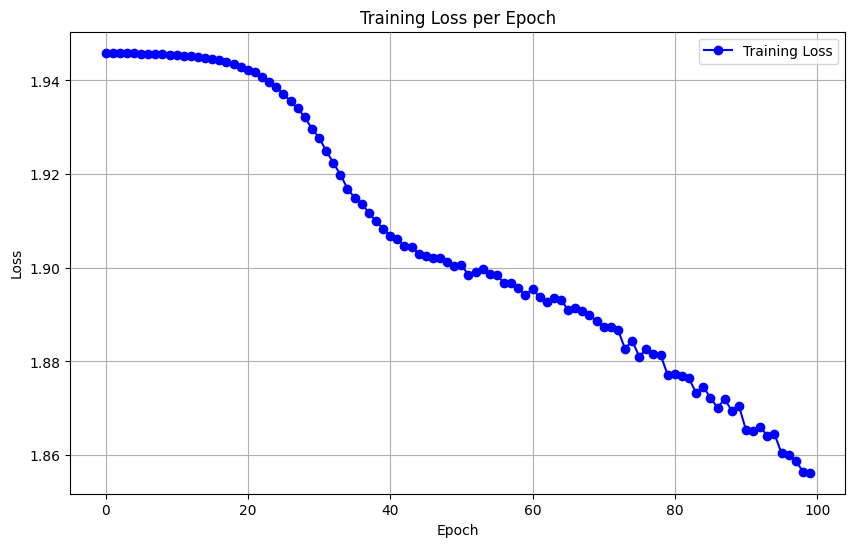

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_lstm_lst, marker='o', color='b', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# LSTM model save
torch.save(lstm_model.state_dict(), f'model/emotion/lstm_emotion_classification_model_epoch100.pt')

#### 2) 1D CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from tqdm import tqdm
# Training loop
min_f1 = 0
conv_loss_lst = []
# Reshape data to (batch_size, channels, sequence_length)
X_train_reshaped = X_train_resampled_sm.reshape(-1, 1, input_size)
X_test_reshaped = X_test_resampled_sm.reshape(-1, 1, input_size)

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_reshaped)
Y_train_tensor = torch.LongTensor(Y_train_resampled_sm)
X_test_tensor = torch.Tensor(X_test_reshaped)
Y_test_tensor = torch.LongTensor(Y_test_resampled_sm)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
    cnn_model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        cnn_optimizer.zero_grad()

        outputs = cnn_model(inputs)
        loss = cnn_criterion(outputs, labels)
        loss.backward()
        cnn_optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    tqdm.write('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, avg_loss))
    conv_loss_lst.append(avg_loss)
    # Evaluate on the test set
    cnn_model.eval()
    with torch.no_grad():
        predictions = cnn_model(X_test_tensor)
        y_pred = predictions.argmax(dim=1)

        f1 = f1_score(Y_test_tensor, y_pred, average='macro')
        if f1 > min_f1:
            min_f1 = f1
            print(f'min_f1: {min_f1}')

print("Training complete.")

Training:   0%|          | 0/100 [00:06<?, ?epoch/s]

Epoch [1/100], Loss: 1.1895


Training:   1%|          | 1/100 [00:07<12:14,  7.42s/epoch]

min_f1: 0.30524887428628183


Training:   1%|          | 1/100 [00:11<12:14,  7.42s/epoch]

Epoch [2/100], Loss: 1.1917


Training:   2%|▏         | 2/100 [00:15<09:43,  5.96s/epoch]

Epoch [3/100], Loss: 1.1901


Training:   3%|▎         | 3/100 [00:16<08:02,  4.98s/epoch]

min_f1: 0.3105791953201474


Training:   3%|▎         | 3/100 [00:19<08:02,  4.98s/epoch]

Epoch [4/100], Loss: 1.1894


Training:   4%|▍         | 4/100 [00:23<07:02,  4.40s/epoch]

Epoch [5/100], Loss: 1.1888


Training:   5%|▌         | 5/100 [00:27<06:56,  4.38s/epoch]

Epoch [6/100], Loss: 1.1920


Training:   6%|▌         | 6/100 [00:28<06:39,  4.25s/epoch]

min_f1: 0.3138794629938451


Training:   6%|▌         | 6/100 [00:31<06:39,  4.25s/epoch]

Epoch [7/100], Loss: 1.1938


Training:   7%|▋         | 7/100 [00:34<06:14,  4.03s/epoch]

Epoch [8/100], Loss: 1.1916


Training:   8%|▊         | 8/100 [00:35<05:55,  3.86s/epoch]

min_f1: 0.33249087057365057


Training:   8%|▊         | 8/100 [00:38<05:55,  3.86s/epoch]

Epoch [9/100], Loss: 1.1908


Training:   9%|▉         | 9/100 [00:42<05:54,  3.89s/epoch]

Epoch [10/100], Loss: 1.1900


Training:  10%|█         | 10/100 [00:46<05:52,  3.92s/epoch]

Epoch [11/100], Loss: 1.1917


Training:  11%|█         | 11/100 [00:49<05:34,  3.76s/epoch]

Epoch [12/100], Loss: 1.1922


Training:  12%|█▏        | 12/100 [00:52<05:14,  3.57s/epoch]

Epoch [13/100], Loss: 1.1920


Training:  13%|█▎        | 13/100 [00:56<05:04,  3.49s/epoch]

Epoch [14/100], Loss: 1.1872


Training:  14%|█▍        | 14/100 [01:00<05:21,  3.74s/epoch]

Epoch [15/100], Loss: 1.1881


Training:  15%|█▌        | 15/100 [01:04<05:18,  3.75s/epoch]

Epoch [16/100], Loss: 1.1906


Training:  16%|█▌        | 16/100 [01:13<05:09,  3.68s/epoch]

Epoch [17/100], Loss: 1.1917


Training:  17%|█▋        | 17/100 [01:17<07:33,  5.46s/epoch]

Epoch [18/100], Loss: 1.1892


Training:  18%|█▊        | 18/100 [01:21<06:53,  5.04s/epoch]

Epoch [19/100], Loss: 1.1910


Training:  19%|█▉        | 19/100 [01:24<06:09,  4.57s/epoch]

Epoch [20/100], Loss: 1.1904


Training:  20%|██        | 20/100 [01:28<05:37,  4.21s/epoch]

Epoch [21/100], Loss: 1.1902


Training:  21%|██        | 21/100 [01:34<05:31,  4.20s/epoch]

Epoch [22/100], Loss: 1.1916


Training:  22%|██▏       | 22/100 [01:37<05:56,  4.57s/epoch]

Epoch [23/100], Loss: 1.1905


Training:  23%|██▎       | 23/100 [01:40<05:25,  4.23s/epoch]

Epoch [24/100], Loss: 1.1914


Training:  24%|██▍       | 24/100 [01:44<04:58,  3.93s/epoch]

Epoch [25/100], Loss: 1.1906


Training:  25%|██▌       | 25/100 [01:49<04:56,  3.95s/epoch]

Epoch [26/100], Loss: 1.1904


Training:  26%|██▌       | 26/100 [01:52<05:02,  4.08s/epoch]

Epoch [27/100], Loss: 1.1912


Training:  27%|██▋       | 27/100 [01:56<04:46,  3.92s/epoch]

Epoch [28/100], Loss: 1.1895


Training:  28%|██▊       | 28/100 [01:59<04:33,  3.80s/epoch]

Epoch [29/100], Loss: 1.1907


Training:  29%|██▉       | 29/100 [02:04<04:24,  3.73s/epoch]

Epoch [30/100], Loss: 1.1938


Training:  30%|███       | 30/100 [02:08<04:35,  3.93s/epoch]

Epoch [31/100], Loss: 1.1878


Training:  31%|███       | 31/100 [02:11<04:27,  3.88s/epoch]

Epoch [32/100], Loss: 1.1889


Training:  32%|███▏      | 32/100 [02:14<04:14,  3.74s/epoch]

Epoch [33/100], Loss: 1.1892


Training:  33%|███▎      | 33/100 [02:19<04:06,  3.69s/epoch]

Epoch [34/100], Loss: 1.1885


Training:  34%|███▍      | 34/100 [02:23<04:14,  3.85s/epoch]

Epoch [35/100], Loss: 1.1898


Training:  35%|███▌      | 35/100 [02:26<04:14,  3.91s/epoch]

Epoch [36/100], Loss: 1.1897


Training:  36%|███▌      | 36/100 [02:30<04:02,  3.79s/epoch]

Epoch [37/100], Loss: 1.1906


Training:  37%|███▋      | 37/100 [02:34<03:53,  3.71s/epoch]

Epoch [38/100], Loss: 1.1887


Training:  38%|███▊      | 38/100 [02:38<03:55,  3.80s/epoch]

Epoch [39/100], Loss: 1.1891


Training:  39%|███▉      | 39/100 [02:39<04:06,  4.04s/epoch]

min_f1: 0.3364095241837098


Training:  39%|███▉      | 39/100 [02:42<04:06,  4.04s/epoch]

Epoch [40/100], Loss: 1.1896


Training:  40%|████      | 40/100 [02:46<03:56,  3.94s/epoch]

Epoch [41/100], Loss: 1.1891


Training:  41%|████      | 41/100 [02:50<03:52,  3.95s/epoch]

Epoch [42/100], Loss: 1.1908


Training:  42%|████▏     | 42/100 [02:55<03:54,  4.05s/epoch]

Epoch [43/100], Loss: 1.1905


Training:  43%|████▎     | 43/100 [02:59<04:04,  4.28s/epoch]

Epoch [44/100], Loss: 1.1879


Training:  44%|████▍     | 44/100 [03:03<03:54,  4.18s/epoch]

Epoch [45/100], Loss: 1.1881


Training:  45%|████▌     | 45/100 [03:08<03:48,  4.15s/epoch]

Epoch [46/100], Loss: 1.1890


Training:  46%|████▌     | 46/100 [03:12<03:51,  4.28s/epoch]

Epoch [47/100], Loss: 1.1907


Training:  47%|████▋     | 47/100 [03:16<03:52,  4.39s/epoch]

Epoch [48/100], Loss: 1.1913


Training:  48%|████▊     | 48/100 [03:21<03:42,  4.29s/epoch]

Epoch [49/100], Loss: 1.1892


Training:  49%|████▉     | 49/100 [03:26<03:42,  4.35s/epoch]

Epoch [50/100], Loss: 1.1877


Training:  50%|█████     | 50/100 [03:30<03:41,  4.44s/epoch]

Epoch [51/100], Loss: 1.1878


Training:  51%|█████     | 51/100 [03:33<03:33,  4.36s/epoch]

Epoch [52/100], Loss: 1.1895


Training:  52%|█████▏    | 52/100 [03:37<03:18,  4.14s/epoch]

Epoch [53/100], Loss: 1.1886


Training:  53%|█████▎    | 53/100 [03:41<03:05,  3.94s/epoch]

Epoch [54/100], Loss: 1.1906


Training:  54%|█████▍    | 54/100 [03:45<03:02,  3.97s/epoch]

Epoch [55/100], Loss: 1.1884


Training:  55%|█████▌    | 55/100 [03:49<03:03,  4.08s/epoch]

Epoch [56/100], Loss: 1.1906


Training:  56%|█████▌    | 56/100 [03:52<02:52,  3.91s/epoch]

Epoch [57/100], Loss: 1.1884


Training:  57%|█████▋    | 57/100 [03:56<02:42,  3.78s/epoch]

Epoch [58/100], Loss: 1.1882


Training:  58%|█████▊    | 58/100 [04:00<02:38,  3.77s/epoch]

Epoch [59/100], Loss: 1.1888


Training:  59%|█████▉    | 59/100 [04:04<02:39,  3.89s/epoch]

Epoch [60/100], Loss: 1.1878


Training:  60%|██████    | 60/100 [04:07<02:31,  3.80s/epoch]

Epoch [61/100], Loss: 1.1903


Training:  61%|██████    | 61/100 [04:11<02:24,  3.72s/epoch]

Epoch [62/100], Loss: 1.1878


Training:  62%|██████▏   | 62/100 [04:15<02:19,  3.67s/epoch]

Epoch [63/100], Loss: 1.1896


Training:  63%|██████▎   | 63/100 [04:19<02:21,  3.83s/epoch]

Epoch [64/100], Loss: 1.1895


Training:  64%|██████▍   | 64/100 [04:23<02:19,  3.88s/epoch]

Epoch [65/100], Loss: 1.1896


Training:  65%|██████▌   | 65/100 [04:27<02:15,  3.88s/epoch]

Epoch [66/100], Loss: 1.1896


Training:  66%|██████▌   | 66/100 [04:30<02:07,  3.75s/epoch]

Epoch [67/100], Loss: 1.1883


Training:  67%|██████▋   | 67/100 [04:34<02:01,  3.69s/epoch]

Epoch [68/100], Loss: 1.1899


Training:  68%|██████▊   | 68/100 [04:37<02:00,  3.78s/epoch]

Epoch [69/100], Loss: 1.1892


Training:  69%|██████▉   | 69/100 [04:41<01:53,  3.67s/epoch]

Epoch [70/100], Loss: 1.1885


Training:  70%|███████   | 70/100 [04:44<01:47,  3.57s/epoch]

Epoch [71/100], Loss: 1.1869


Training:  71%|███████   | 71/100 [04:48<01:41,  3.50s/epoch]

Epoch [72/100], Loss: 1.1887


Training:  72%|███████▏  | 72/100 [04:53<01:46,  3.79s/epoch]

Epoch [73/100], Loss: 1.1890


Training:  73%|███████▎  | 73/100 [04:56<01:44,  3.87s/epoch]

Epoch [74/100], Loss: 1.1916


Training:  74%|███████▍  | 74/100 [05:00<01:39,  3.81s/epoch]

Epoch [75/100], Loss: 1.1887


Training:  75%|███████▌  | 75/100 [05:04<01:32,  3.70s/epoch]

Epoch [76/100], Loss: 1.1915


Training:  76%|███████▌  | 76/100 [05:09<01:30,  3.76s/epoch]

Epoch [77/100], Loss: 1.1863


Training:  77%|███████▋  | 77/100 [05:13<01:38,  4.28s/epoch]

Epoch [78/100], Loss: 1.1866


Training:  78%|███████▊  | 78/100 [05:16<01:29,  4.07s/epoch]

Epoch [79/100], Loss: 1.1896


Training:  79%|███████▉  | 79/100 [05:20<01:22,  3.93s/epoch]

Epoch [80/100], Loss: 1.1898


Training:  80%|████████  | 80/100 [05:25<01:20,  4.01s/epoch]

Epoch [81/100], Loss: 1.1875


Training:  81%|████████  | 81/100 [05:25<01:17,  4.09s/epoch]

min_f1: 0.3503168832381324


Training:  81%|████████  | 81/100 [05:28<01:17,  4.09s/epoch]

Epoch [82/100], Loss: 1.1897


Training:  82%|████████▏ | 82/100 [05:32<01:09,  3.88s/epoch]

Epoch [83/100], Loss: 1.1907


Training:  83%|████████▎ | 83/100 [05:35<01:03,  3.75s/epoch]

Epoch [84/100], Loss: 1.1885


Training:  84%|████████▍ | 84/100 [05:36<01:00,  3.78s/epoch]

min_f1: 0.35778411844804164


Training:  84%|████████▍ | 84/100 [05:40<01:00,  3.78s/epoch]

Epoch [85/100], Loss: 1.1918


Training:  85%|████████▌ | 85/100 [05:44<00:59,  3.99s/epoch]

Epoch [86/100], Loss: 1.1893


Training:  86%|████████▌ | 86/100 [05:47<00:54,  3.92s/epoch]

Epoch [87/100], Loss: 1.1883


Training:  87%|████████▋ | 87/100 [05:51<00:50,  3.86s/epoch]

Epoch [88/100], Loss: 1.1866


Training:  88%|████████▊ | 88/100 [05:56<00:45,  3.82s/epoch]

Epoch [89/100], Loss: 1.1913


Training:  89%|████████▉ | 89/100 [06:00<00:44,  4.05s/epoch]

Epoch [90/100], Loss: 1.1884


Training:  90%|█████████ | 90/100 [06:03<00:40,  4.01s/epoch]

Epoch [91/100], Loss: 1.1886


Training:  91%|█████████ | 91/100 [06:07<00:35,  3.89s/epoch]

Epoch [92/100], Loss: 1.1884


Training:  92%|█████████▏| 92/100 [06:11<00:30,  3.84s/epoch]

Epoch [93/100], Loss: 1.1884


Training:  93%|█████████▎| 93/100 [06:16<00:28,  4.09s/epoch]

Epoch [94/100], Loss: 1.1877


Training:  94%|█████████▍| 94/100 [06:19<00:24,  4.11s/epoch]

Epoch [95/100], Loss: 1.1866


Training:  95%|█████████▌| 95/100 [06:23<00:19,  4.00s/epoch]

Epoch [96/100], Loss: 1.1871


Training:  96%|█████████▌| 96/100 [06:27<00:15,  3.89s/epoch]

Epoch [97/100], Loss: 1.1880


Training:  97%|█████████▋| 97/100 [06:31<00:11,  3.99s/epoch]

Epoch [98/100], Loss: 1.1898


Training:  98%|█████████▊| 98/100 [06:35<00:07,  3.97s/epoch]

Epoch [99/100], Loss: 1.1861


Training:  99%|█████████▉| 99/100 [06:38<00:03,  3.83s/epoch]

Epoch [100/100], Loss: 1.1846


Training: 100%|██████████| 100/100 [06:39<00:00,  3.99s/epoch]

Training complete.


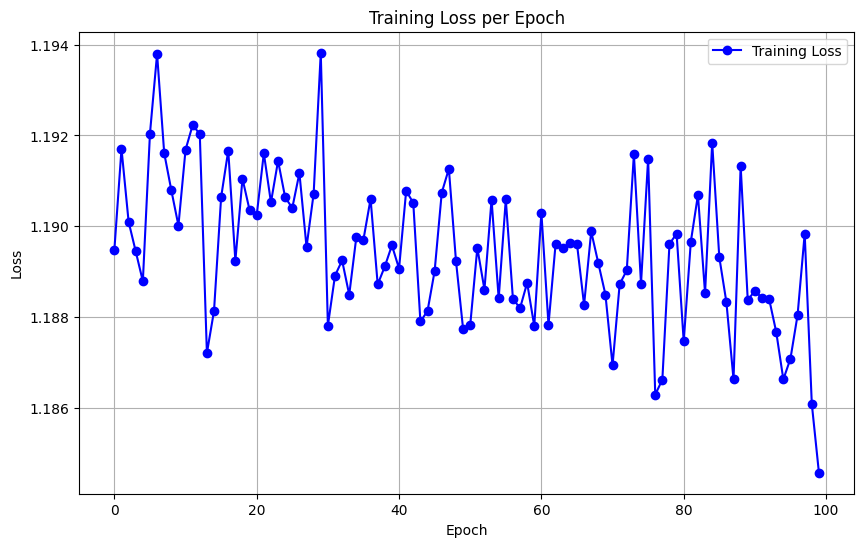

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(conv_loss_lst, marker='o', color='b', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# CNN model save
torch.save(cnn_model.state_dict(), f'model/emotion/1dcnn_emotion_classification_model_epoch100.pt')

#### 3) LSTM Attention

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from tqdm import tqdm


# Convert your data into PyTorch DataLoader if not done already
train_dataset = TensorDataset(X_train_resampled_sm, Y_train_resampled_sm)
test_dataset = TensorDataset(X_test_resampled_sm, Y_test_resampled_sm)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
min_f1 = 0
lstm_attention_loss_lst = []
for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
    lstm_attention_model.train()
    total_loss = 0
    for inputs, labels in train_dataloader:
        lstm_attention_optimizer.zero_grad()
        outputs, _ = lstm_attention_model(inputs.unsqueeze(1))
        loss = lstm_attention_criterion(outputs.squeeze(), labels)
        loss.backward()
        lstm_attention_optimizer.step()
        total_loss+= loss.item()

    tqdm.write('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
    avg_loss = total_loss / len(train_dataloader)
    lstm_attention_loss_lst.append(avg_loss)


    # Evaluation during training
    lstm_attention_model.eval()
    with torch.no_grad():
        predictions, _ = lstm_attention_model(X_test_resampled_sm.unsqueeze(1))
        y_pred = predictions.argmax(dim=1)

        f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
        if f1 > min_f1:
            min_f1 = f1
            print(f'Min F1: {min_f1}')




Training:   0%|          | 0/100 [00:07<?, ?epoch/s]

Epoch [1/100], Loss: 1.7831


Training:   1%|          | 1/100 [00:08<14:01,  8.50s/epoch]

Min F1: 0.3123989895306497


Training:   1%|          | 1/100 [00:16<14:01,  8.50s/epoch]

Epoch [2/100], Loss: 1.5113


Training:   2%|▏         | 2/100 [00:16<13:41,  8.38s/epoch]

Min F1: 0.3272361027976129


Training:   2%|▏         | 2/100 [00:38<13:41,  8.38s/epoch]

Epoch [3/100], Loss: 1.7915


Training:   3%|▎         | 3/100 [00:58<24:16, 15.01s/epoch]

Epoch [4/100], Loss: 1.8399


Training:   4%|▍         | 4/100 [01:19<27:27, 17.16s/epoch]

Epoch [5/100], Loss: 1.7831


Training:   5%|▌         | 5/100 [01:20<29:13, 18.45s/epoch]

Min F1: 0.3394375666567567


Training:   5%|▌         | 5/100 [01:39<29:13, 18.45s/epoch]

Epoch [6/100], Loss: 1.6440


Training:   6%|▌         | 6/100 [02:00<30:04, 19.20s/epoch]

Epoch [7/100], Loss: 1.7204


Training:   7%|▋         | 7/100 [02:21<30:27, 19.65s/epoch]

Epoch [8/100], Loss: 1.6926


Training:   8%|▊         | 8/100 [02:41<30:30, 19.90s/epoch]

Epoch [9/100], Loss: 1.6249


Training:   9%|▉         | 9/100 [03:01<30:19, 20.00s/epoch]

Epoch [10/100], Loss: 1.7585


Training:  10%|█         | 10/100 [03:02<30:02, 20.02s/epoch]

Min F1: 0.3608403389979671


Training:  10%|█         | 10/100 [03:21<30:02, 20.02s/epoch]

Epoch [11/100], Loss: 1.7050


Training:  11%|█         | 11/100 [03:41<29:47, 20.08s/epoch]

Epoch [12/100], Loss: 1.5944


Training:  12%|█▏        | 12/100 [04:02<29:27, 20.08s/epoch]

Epoch [13/100], Loss: 1.7019


Training:  13%|█▎        | 13/100 [04:22<29:19, 20.22s/epoch]

Epoch [14/100], Loss: 1.6015


Training:  14%|█▍        | 14/100 [04:24<29:02, 20.26s/epoch]

Min F1: 0.3799853499230335


Training:  14%|█▍        | 14/100 [04:42<29:02, 20.26s/epoch]

Epoch [15/100], Loss: 1.5776


Training:  15%|█▌        | 15/100 [05:03<28:48, 20.33s/epoch]

Epoch [16/100], Loss: 1.7136


Training:  16%|█▌        | 16/100 [05:23<28:22, 20.27s/epoch]

Epoch [17/100], Loss: 1.6669


Training:  17%|█▋        | 17/100 [05:43<27:54, 20.17s/epoch]

Epoch [18/100], Loss: 1.6791


Training:  18%|█▊        | 18/100 [06:03<27:34, 20.17s/epoch]

Epoch [19/100], Loss: 1.5790


Training:  19%|█▉        | 19/100 [06:04<27:05, 20.07s/epoch]

Min F1: 0.38102299493844827


Training:  19%|█▉        | 19/100 [06:23<27:05, 20.07s/epoch]

Epoch [20/100], Loss: 1.5469


Training:  20%|██        | 20/100 [06:43<26:52, 20.16s/epoch]

Epoch [21/100], Loss: 1.6171


Training:  21%|██        | 21/100 [07:04<26:41, 20.28s/epoch]

Epoch [22/100], Loss: 1.8094


Training:  22%|██▏       | 22/100 [07:24<26:26, 20.35s/epoch]

Epoch [23/100], Loss: 1.4828


Training:  23%|██▎       | 23/100 [07:44<25:59, 20.25s/epoch]

Epoch [24/100], Loss: 1.6690


Training:  24%|██▍       | 24/100 [08:04<25:29, 20.12s/epoch]

Epoch [25/100], Loss: 1.5746


Training:  25%|██▌       | 25/100 [08:24<24:59, 20.00s/epoch]

Epoch [26/100], Loss: 1.6517


Training:  26%|██▌       | 26/100 [08:44<24:57, 20.24s/epoch]

Epoch [27/100], Loss: 1.6366


Training:  27%|██▋       | 27/100 [08:46<24:32, 20.17s/epoch]

Min F1: 0.3975135877840551


Training:  27%|██▋       | 27/100 [09:04<24:32, 20.17s/epoch]

Epoch [28/100], Loss: 1.6802


Training:  28%|██▊       | 28/100 [09:25<24:06, 20.09s/epoch]

Epoch [29/100], Loss: 1.6232


Training:  29%|██▉       | 29/100 [09:47<23:53, 20.19s/epoch]

Epoch [30/100], Loss: 1.8271


Training:  30%|███       | 30/100 [10:08<24:19, 20.85s/epoch]

Epoch [31/100], Loss: 1.6605


Training:  31%|███       | 31/100 [10:28<23:50, 20.74s/epoch]

Epoch [32/100], Loss: 1.4917


Training:  32%|███▏      | 32/100 [10:48<23:18, 20.56s/epoch]

Epoch [33/100], Loss: 1.6244


Training:  33%|███▎      | 33/100 [11:08<22:46, 20.39s/epoch]

Epoch [34/100], Loss: 1.5740


Training:  34%|███▍      | 34/100 [11:28<22:14, 20.22s/epoch]

Epoch [35/100], Loss: 1.5045


Training:  35%|███▌      | 35/100 [11:48<21:49, 20.15s/epoch]

Epoch [36/100], Loss: 1.5299


Training:  36%|███▌      | 36/100 [12:10<21:36, 20.26s/epoch]

Epoch [37/100], Loss: 1.6217


Training:  37%|███▋      | 37/100 [12:36<22:06, 21.05s/epoch]

Epoch [38/100], Loss: 1.5812


Training:  38%|███▊      | 38/100 [13:10<22:52, 22.14s/epoch]

Epoch [39/100], Loss: 1.6251


Training:  39%|███▉      | 39/100 [13:40<26:26, 26.01s/epoch]

Epoch [40/100], Loss: 1.7835


Training:  40%|████      | 40/100 [14:11<27:12, 27.22s/epoch]

Epoch [41/100], Loss: 1.4739


Training:  41%|████      | 41/100 [14:38<27:41, 28.16s/epoch]

Epoch [42/100], Loss: 1.6102


Training:  42%|████▏     | 42/100 [15:10<27:24, 28.35s/epoch]

Epoch [43/100], Loss: 1.7852


Training:  43%|████▎     | 43/100 [15:31<27:29, 28.94s/epoch]

Epoch [44/100], Loss: 1.4623


Training:  44%|████▍     | 44/100 [15:51<24:38, 26.40s/epoch]

Epoch [45/100], Loss: 1.4945


Training:  45%|████▌     | 45/100 [16:12<22:37, 24.68s/epoch]

Epoch [46/100], Loss: 1.5821


Training:  46%|████▌     | 46/100 [16:32<21:04, 23.42s/epoch]

Epoch [47/100], Loss: 1.5790


Training:  47%|████▋     | 47/100 [16:53<19:52, 22.49s/epoch]

Epoch [48/100], Loss: 1.5364


Training:  48%|████▊     | 48/100 [17:14<19:02, 21.98s/epoch]

Epoch [49/100], Loss: 1.5346


Training:  49%|████▉     | 49/100 [17:34<18:24, 21.65s/epoch]

Epoch [50/100], Loss: 1.6718


Training:  50%|█████     | 50/100 [17:54<17:42, 21.26s/epoch]

Epoch [51/100], Loss: 1.6171


Training:  51%|█████     | 51/100 [18:15<17:07, 20.96s/epoch]

Epoch [52/100], Loss: 1.5930


Training:  52%|█████▏    | 52/100 [18:35<16:38, 20.81s/epoch]

Epoch [53/100], Loss: 1.6804


Training:  53%|█████▎    | 53/100 [18:56<16:06, 20.56s/epoch]

Epoch [54/100], Loss: 1.5808


Training:  54%|█████▍    | 54/100 [19:17<16:03, 20.95s/epoch]

Epoch [55/100], Loss: 1.5885


Training:  55%|█████▌    | 55/100 [19:37<15:35, 20.80s/epoch]

Epoch [56/100], Loss: 1.4048


Training:  56%|█████▌    | 56/100 [19:57<15:05, 20.58s/epoch]

Epoch [57/100], Loss: 1.4955


Training:  57%|█████▋    | 57/100 [20:17<14:34, 20.34s/epoch]

Epoch [58/100], Loss: 1.5416


Training:  58%|█████▊    | 58/100 [20:36<14:06, 20.15s/epoch]

Epoch [59/100], Loss: 1.3267


Training:  59%|█████▉    | 59/100 [20:56<13:40, 20.00s/epoch]

Epoch [60/100], Loss: 1.4167


Training:  60%|██████    | 60/100 [21:16<13:17, 19.94s/epoch]

Epoch [61/100], Loss: 1.7049


Training:  61%|██████    | 61/100 [21:36<13:00, 20.02s/epoch]

Epoch [62/100], Loss: 1.5815


Training:  62%|██████▏   | 62/100 [21:56<12:36, 19.91s/epoch]

Epoch [63/100], Loss: 1.7046


Training:  63%|██████▎   | 63/100 [22:16<12:20, 20.02s/epoch]

Epoch [64/100], Loss: 1.5647


Training:  64%|██████▍   | 64/100 [22:37<11:58, 19.96s/epoch]

Epoch [65/100], Loss: 1.5134


Training:  65%|██████▌   | 65/100 [22:57<11:48, 20.23s/epoch]

Epoch [66/100], Loss: 1.5326


Training:  66%|██████▌   | 66/100 [23:17<11:26, 20.20s/epoch]

Epoch [67/100], Loss: 1.4119


Training:  67%|██████▋   | 67/100 [23:36<11:00, 20.01s/epoch]

Epoch [68/100], Loss: 1.6230


Training:  68%|██████▊   | 68/100 [23:56<10:35, 19.85s/epoch]

Epoch [69/100], Loss: 1.7456


Training:  69%|██████▉   | 69/100 [24:16<10:13, 19.80s/epoch]

Epoch [70/100], Loss: 1.5867


Training:  70%|███████   | 70/100 [24:36<09:56, 19.89s/epoch]

Epoch [71/100], Loss: 1.5795


Training:  71%|███████   | 71/100 [24:56<09:38, 19.94s/epoch]

Epoch [72/100], Loss: 1.7469


Training:  72%|███████▏  | 72/100 [25:16<09:19, 19.99s/epoch]

Epoch [73/100], Loss: 1.4964


Training:  73%|███████▎  | 73/100 [25:36<08:57, 19.90s/epoch]

Epoch [74/100], Loss: 1.5021


Training:  74%|███████▍  | 74/100 [26:12<08:47, 20.30s/epoch]

Epoch [75/100], Loss: 1.7132


Training:  75%|███████▌  | 75/100 [26:44<10:30, 25.21s/epoch]

Epoch [76/100], Loss: 1.5359


Training:  76%|███████▌  | 76/100 [27:08<10:50, 27.09s/epoch]

Epoch [77/100], Loss: 1.5213


Training:  77%|███████▋  | 77/100 [27:28<09:56, 25.95s/epoch]

Epoch [78/100], Loss: 1.5795


Training:  78%|███████▊  | 78/100 [27:48<08:47, 24.00s/epoch]

Epoch [79/100], Loss: 1.6284


Training:  79%|███████▉  | 79/100 [28:23<07:59, 22.85s/epoch]

Epoch [80/100], Loss: 1.6241


Training:  80%|████████  | 80/100 [28:53<08:49, 26.50s/epoch]

Epoch [81/100], Loss: 1.6154


Training:  81%|████████  | 81/100 [29:20<08:43, 27.55s/epoch]

Epoch [82/100], Loss: 1.5165


Training:  82%|████████▏ | 82/100 [29:44<08:20, 27.78s/epoch]

Epoch [83/100], Loss: 1.5912


Training:  83%|████████▎ | 83/100 [30:04<07:27, 26.33s/epoch]

Epoch [84/100], Loss: 1.6631


Training:  84%|████████▍ | 84/100 [30:24<06:30, 24.38s/epoch]

Epoch [85/100], Loss: 1.6355


Training:  85%|████████▌ | 85/100 [30:52<05:46, 23.07s/epoch]

Epoch [86/100], Loss: 1.7624


Training:  86%|████████▌ | 86/100 [31:20<05:42, 24.46s/epoch]

Epoch [87/100], Loss: 1.4554


Training:  87%|████████▋ | 87/100 [31:49<05:35, 25.83s/epoch]

Epoch [88/100], Loss: 1.5435


Training:  88%|████████▊ | 88/100 [32:19<05:17, 26.48s/epoch]

Epoch [89/100], Loss: 1.5026


Training:  89%|████████▉ | 89/100 [32:40<05:02, 27.51s/epoch]

Epoch [90/100], Loss: 1.5896


Training:  90%|█████████ | 90/100 [32:59<04:15, 25.60s/epoch]

Epoch [91/100], Loss: 1.4429


Training:  91%|█████████ | 91/100 [33:19<03:33, 23.71s/epoch]

Epoch [92/100], Loss: 1.5577


Training:  92%|█████████▏| 92/100 [33:39<03:00, 22.62s/epoch]

Epoch [93/100], Loss: 1.3765


Training:  93%|█████████▎| 93/100 [33:59<02:32, 21.81s/epoch]

Epoch [94/100], Loss: 1.5355


Training:  94%|█████████▍| 94/100 [34:19<02:06, 21.08s/epoch]

Epoch [95/100], Loss: 1.7532


Training:  95%|█████████▌| 95/100 [34:38<01:43, 20.75s/epoch]

Epoch [96/100], Loss: 1.4265


Training:  96%|█████████▌| 96/100 [34:59<01:21, 20.49s/epoch]

Epoch [97/100], Loss: 1.4590


Training:  97%|█████████▋| 97/100 [35:19<01:01, 20.48s/epoch]

Epoch [98/100], Loss: 1.5520


Training:  98%|█████████▊| 98/100 [35:38<00:40, 20.29s/epoch]

Epoch [99/100], Loss: 1.5376


Training:  99%|█████████▉| 99/100 [35:58<00:20, 20.07s/epoch]

Epoch [100/100], Loss: 1.8357


Training: 100%|██████████| 100/100 [36:00<00:00, 21.60s/epoch]


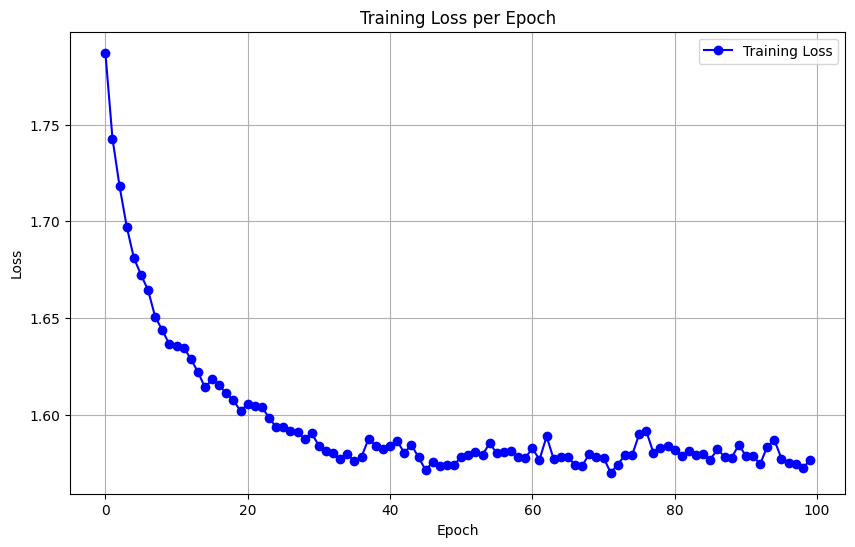

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_attention_loss_lst, marker='o', color='b', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# lstm_attention model save
torch.save(lstm_attention_model.state_dict(), f'model/emotion/lstm_attention_emotion_classification_model_epoch100.pt')

#### 4) GRU

In [ ]:
## GRU Training
from sklearn.metrics import f1_score
Y_train_resampled_sm = Y_train_resampled_sm.long()
min_f1=0
loss_gru_lst=[]
for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
    gru_optimizer.zero_grad()

    gru_model.train()

    # Forward pass with dropout
    X_train_resampled_sm_drop = nn.Dropout(p=0.5)(X_train_resampled_sm.unsqueeze(1))
    output, hidden_state, _ = gru_model(X_train_resampled_sm_drop)

    # Compute loss
    loss_gru = gru_criterion(output.squeeze(), Y_train_resampled_sm)
    loss_gru_lst.append(loss_gru.item())

    # Backward and optimize
    loss_gru.backward()
    gru_optimizer.step()
    tqdm.write('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss_gru.item()))

    gru_model.eval()
    with torch.no_grad():
        predictions, hidden, out = gru_model(X_test_resampled_sm.unsqueeze(1))
        y_pred = predictions.argmax(dim=1)

        f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
        if f1 > min_f1:
            min_f1 = f1
            print(f'min_f1: {min_f1}')
            torch.save(gru_model.state_dict(), f'model/emotion/gru_emotion_classification_model_best.pt')


Training:   0%|          | 0/100 [00:01<?, ?epoch/s]

Epoch [1/100], Loss: 1.9460
min_f1: 0.03571428571428571


Training:   2%|▏         | 2/100 [00:03<03:04,  1.88s/epoch]

Epoch [2/100], Loss: 1.9458
min_f1: 0.05179652135573804


Training:   3%|▎         | 3/100 [00:05<02:32,  1.57s/epoch]

Epoch [3/100], Loss: 1.9456
min_f1: 0.06832673269898197


Training:   4%|▍         | 4/100 [00:06<02:08,  1.34s/epoch]

Epoch [4/100], Loss: 1.9455
min_f1: 0.08626100716566575


Training:   5%|▌         | 5/100 [00:07<01:56,  1.22s/epoch]

Epoch [5/100], Loss: 1.9452
min_f1: 0.16262644193443745


Training:   6%|▌         | 6/100 [00:08<02:04,  1.32s/epoch]

Epoch [6/100], Loss: 1.9451
min_f1: 0.19325607251735427


Training:   7%|▋         | 7/100 [00:10<02:10,  1.40s/epoch]

Epoch [7/100], Loss: 1.9448


Training:   8%|▊         | 8/100 [00:12<02:27,  1.61s/epoch]

Epoch [8/100], Loss: 1.9446


Training:   9%|▉         | 9/100 [00:14<02:40,  1.76s/epoch]

Epoch [9/100], Loss: 1.9442


Training:   9%|▉         | 9/100 [00:17<02:40,  1.76s/epoch]

Epoch [10/100], Loss: 1.9438


Training:  10%|█         | 10/100 [00:19<03:21,  2.23s/epoch]

Epoch [11/100], Loss: 1.9433


Training:  11%|█         | 11/100 [00:21<03:19,  2.25s/epoch]

Epoch [12/100], Loss: 1.9427


Training:  13%|█▎        | 13/100 [00:24<03:06,  2.15s/epoch]

Epoch [13/100], Loss: 1.9418


Training:  14%|█▍        | 14/100 [00:25<02:45,  1.92s/epoch]

Epoch [14/100], Loss: 1.9413


Training:  15%|█▌        | 15/100 [00:26<02:28,  1.74s/epoch]

Epoch [15/100], Loss: 1.9404


Training:  16%|█▌        | 16/100 [00:28<02:15,  1.62s/epoch]

Epoch [16/100], Loss: 1.9392


Training:  17%|█▋        | 17/100 [00:29<02:05,  1.51s/epoch]

Epoch [17/100], Loss: 1.9378


Training:  18%|█▊        | 18/100 [00:30<01:58,  1.45s/epoch]

Epoch [18/100], Loss: 1.9365


Training:  19%|█▉        | 19/100 [00:31<01:52,  1.39s/epoch]

Epoch [19/100], Loss: 1.9344


Training:  19%|█▉        | 19/100 [00:33<01:52,  1.39s/epoch]

Epoch [20/100], Loss: 1.9331


Training:  21%|██        | 21/100 [00:36<02:17,  1.74s/epoch]

Epoch [21/100], Loss: 1.9304


Training:  22%|██▏       | 22/100 [00:38<02:21,  1.81s/epoch]

Epoch [22/100], Loss: 1.9287


Training:  23%|██▎       | 23/100 [00:39<02:19,  1.81s/epoch]

Epoch [23/100], Loss: 1.9272


Training:  24%|██▍       | 24/100 [00:41<02:03,  1.62s/epoch]

Epoch [24/100], Loss: 1.9231


Training:  25%|██▌       | 25/100 [00:42<01:53,  1.52s/epoch]

Epoch [25/100], Loss: 1.9221


Training:  26%|██▌       | 26/100 [00:43<01:47,  1.45s/epoch]

Epoch [26/100], Loss: 1.9191


Training:  27%|██▋       | 27/100 [00:44<01:40,  1.38s/epoch]

Epoch [27/100], Loss: 1.9178


Training:  28%|██▊       | 28/100 [00:46<01:39,  1.39s/epoch]

Epoch [28/100], Loss: 1.9152


Training:  29%|██▉       | 29/100 [00:47<01:35,  1.35s/epoch]

Epoch [29/100], Loss: 1.9124


Training:  30%|███       | 30/100 [00:48<01:33,  1.34s/epoch]

Epoch [30/100], Loss: 1.9108


Training:  30%|███       | 30/100 [00:50<01:33,  1.34s/epoch]

Epoch [31/100], Loss: 1.9105


Training:  32%|███▏      | 32/100 [00:52<01:46,  1.56s/epoch]

Epoch [32/100], Loss: 1.9075


Training:  32%|███▏      | 32/100 [00:56<01:46,  1.56s/epoch]

Epoch [33/100], Loss: 1.9059


Training:  34%|███▍      | 34/100 [00:58<02:30,  2.28s/epoch]

Epoch [34/100], Loss: 1.9036


Training:  35%|███▌      | 35/100 [01:00<02:15,  2.08s/epoch]

Epoch [35/100], Loss: 1.9014


Training:  36%|███▌      | 36/100 [01:01<02:01,  1.89s/epoch]

Epoch [36/100], Loss: 1.9019


Training:  37%|███▋      | 37/100 [01:03<01:48,  1.72s/epoch]

Epoch [37/100], Loss: 1.8997


Training:  38%|███▊      | 38/100 [01:04<01:37,  1.57s/epoch]

Epoch [38/100], Loss: 1.8975


Training:  39%|███▉      | 39/100 [01:05<01:30,  1.48s/epoch]

Epoch [39/100], Loss: 1.8955


Training:  40%|████      | 40/100 [01:06<01:23,  1.40s/epoch]

Epoch [40/100], Loss: 1.8947


Training:  41%|████      | 41/100 [01:08<01:30,  1.54s/epoch]

Epoch [41/100], Loss: 1.8919


Training:  42%|████▏     | 42/100 [01:11<01:42,  1.77s/epoch]

Epoch [42/100], Loss: 1.8905
min_f1: 0.2162454184837292


Training:  42%|████▏     | 42/100 [01:13<01:42,  1.77s/epoch]

Epoch [43/100], Loss: 1.8894


Training:  43%|████▎     | 43/100 [01:13<01:52,  1.97s/epoch]

min_f1: 0.23507358679517942


Training:  44%|████▍     | 44/100 [01:15<01:42,  1.83s/epoch]

Epoch [44/100], Loss: 1.8901
min_f1: 0.24552727507284106


Training:  45%|████▌     | 45/100 [01:16<01:32,  1.68s/epoch]

Epoch [45/100], Loss: 1.8870
min_f1: 0.25256764619526134


Training:  46%|████▌     | 46/100 [01:17<01:23,  1.55s/epoch]

Epoch [46/100], Loss: 1.8860


Training:  47%|████▋     | 47/100 [01:18<01:16,  1.45s/epoch]

Epoch [47/100], Loss: 1.8824


Training:  48%|████▊     | 48/100 [01:19<01:10,  1.36s/epoch]

Epoch [48/100], Loss: 1.8820


Training:  49%|████▉     | 49/100 [01:20<01:02,  1.23s/epoch]

Epoch [49/100], Loss: 1.8809


Training:  50%|█████     | 50/100 [01:21<00:58,  1.16s/epoch]

Epoch [50/100], Loss: 1.8812


Training:  51%|█████     | 51/100 [01:22<00:54,  1.12s/epoch]

Epoch [51/100], Loss: 1.8781


Training:  52%|█████▏    | 52/100 [01:24<00:54,  1.13s/epoch]

Epoch [52/100], Loss: 1.8758
min_f1: 0.25399850052945333


Training:  52%|█████▏    | 52/100 [01:25<00:54,  1.13s/epoch]

Epoch [53/100], Loss: 1.8742


Training:  53%|█████▎    | 53/100 [01:26<01:07,  1.44s/epoch]

min_f1: 0.2583264996773055


Training:  53%|█████▎    | 53/100 [01:27<01:07,  1.44s/epoch]

Epoch [54/100], Loss: 1.8716


Training:  55%|█████▌    | 55/100 [01:30<01:21,  1.80s/epoch]

Epoch [55/100], Loss: 1.8713


Training:  56%|█████▌    | 56/100 [01:31<01:15,  1.71s/epoch]

Epoch [56/100], Loss: 1.8727


Training:  56%|█████▌    | 56/100 [01:33<01:15,  1.71s/epoch]

Epoch [57/100], Loss: 1.8700


Training:  57%|█████▋    | 57/100 [01:35<01:11,  1.66s/epoch]

Epoch [58/100], Loss: 1.8665


Training:  58%|█████▊    | 58/100 [01:35<01:19,  1.89s/epoch]

min_f1: 0.2654823334348816


Training:  58%|█████▊    | 58/100 [01:38<01:19,  1.89s/epoch]

Epoch [59/100], Loss: 1.8651


Training:  59%|█████▉    | 59/100 [01:38<01:24,  2.07s/epoch]

min_f1: 0.27029672838190805


Training:  60%|██████    | 60/100 [01:40<01:18,  1.96s/epoch]

Epoch [60/100], Loss: 1.8662
min_f1: 0.28734706422366346


Training:  60%|██████    | 60/100 [01:41<01:18,  1.96s/epoch]

Epoch [61/100], Loss: 1.8640
min_f1: 0.2961118073773374


Training:  62%|██████▏   | 62/100 [01:43<01:11,  1.87s/epoch]

Epoch [62/100], Loss: 1.8650
min_f1: 0.299202872482854


Training:  62%|██████▏   | 62/100 [01:45<01:11,  1.87s/epoch]

Epoch [63/100], Loss: 1.8601


Training:  63%|██████▎   | 63/100 [01:45<01:08,  1.85s/epoch]

min_f1: 0.3008968453534999


Training:  63%|██████▎   | 63/100 [01:47<01:08,  1.85s/epoch]

Epoch [64/100], Loss: 1.8576
min_f1: 0.30767130880377724


Training:  65%|██████▌   | 65/100 [01:48<01:01,  1.77s/epoch]

Epoch [65/100], Loss: 1.8574
min_f1: 0.3112225600318447


Training:  66%|██████▌   | 66/100 [01:50<00:55,  1.64s/epoch]

Epoch [66/100], Loss: 1.8562


Training:  67%|██████▋   | 67/100 [01:51<00:48,  1.48s/epoch]

Epoch [67/100], Loss: 1.8558


Training:  68%|██████▊   | 68/100 [01:52<00:44,  1.40s/epoch]

Epoch [68/100], Loss: 1.8528


Training:  69%|██████▉   | 69/100 [01:53<00:42,  1.37s/epoch]

Epoch [69/100], Loss: 1.8535


Training:  70%|███████   | 70/100 [01:55<00:41,  1.38s/epoch]

Epoch [70/100], Loss: 1.8529


Training:  71%|███████   | 71/100 [01:56<00:39,  1.36s/epoch]

Epoch [71/100], Loss: 1.8527


Training:  72%|███████▏  | 72/100 [01:58<00:37,  1.35s/epoch]

Epoch [72/100], Loss: 1.8499


Training:  72%|███████▏  | 72/100 [01:59<00:37,  1.35s/epoch]

Epoch [73/100], Loss: 1.8474


Training:  73%|███████▎  | 73/100 [02:02<00:40,  1.50s/epoch]

Epoch [74/100], Loss: 1.8490


Training:  74%|███████▍  | 74/100 [02:05<00:49,  1.92s/epoch]

Epoch [75/100], Loss: 1.8465


Training:  76%|███████▌  | 76/100 [02:06<00:43,  1.83s/epoch]

Epoch [76/100], Loss: 1.8476


Training:  77%|███████▋  | 77/100 [02:07<00:35,  1.55s/epoch]

Epoch [77/100], Loss: 1.8453


Training:  78%|███████▊  | 78/100 [02:08<00:30,  1.37s/epoch]

Epoch [78/100], Loss: 1.8461


Training:  79%|███████▉  | 79/100 [02:09<00:25,  1.23s/epoch]

Epoch [79/100], Loss: 1.8425


Training:  80%|████████  | 80/100 [02:10<00:22,  1.14s/epoch]

Epoch [80/100], Loss: 1.8424


Training:  81%|████████  | 81/100 [02:11<00:20,  1.09s/epoch]

Epoch [81/100], Loss: 1.8438


Training:  82%|████████▏ | 82/100 [02:12<00:18,  1.04s/epoch]

Epoch [82/100], Loss: 1.8408


Training:  83%|████████▎ | 83/100 [02:13<00:17,  1.01s/epoch]

Epoch [83/100], Loss: 1.8409


Training:  84%|████████▍ | 84/100 [02:13<00:16,  1.00s/epoch]

Epoch [84/100], Loss: 1.8410


Training:  85%|████████▌ | 85/100 [02:14<00:14,  1.01epoch/s]

Epoch [85/100], Loss: 1.8382


Training:  86%|████████▌ | 86/100 [02:16<00:14,  1.02s/epoch]

Epoch [86/100], Loss: 1.8389


Training:  86%|████████▌ | 86/100 [02:18<00:14,  1.02s/epoch]

Epoch [87/100], Loss: 1.8401


Training:  87%|████████▋ | 87/100 [02:20<00:18,  1.43s/epoch]

Epoch [88/100], Loss: 1.8374


Training:  89%|████████▉ | 89/100 [02:22<00:19,  1.77s/epoch]

Epoch [89/100], Loss: 1.8346


Training:  90%|█████████ | 90/100 [02:23<00:16,  1.60s/epoch]

Epoch [90/100], Loss: 1.8355


Training:  91%|█████████ | 91/100 [02:25<00:13,  1.50s/epoch]

Epoch [91/100], Loss: 1.8306


Training:  92%|█████████▏| 92/100 [02:26<00:11,  1.40s/epoch]

Epoch [92/100], Loss: 1.8315


Training:  93%|█████████▎| 93/100 [02:27<00:09,  1.33s/epoch]

Epoch [93/100], Loss: 1.8316


Training:  94%|█████████▍| 94/100 [02:29<00:08,  1.37s/epoch]

Epoch [94/100], Loss: 1.8318


Training:  95%|█████████▌| 95/100 [02:30<00:06,  1.36s/epoch]

Epoch [95/100], Loss: 1.8295


Training:  96%|█████████▌| 96/100 [02:31<00:05,  1.32s/epoch]

Epoch [96/100], Loss: 1.8307


Training:  96%|█████████▌| 96/100 [02:32<00:05,  1.32s/epoch]

Epoch [97/100], Loss: 1.8281


Training:  97%|█████████▋| 97/100 [02:36<00:04,  1.34s/epoch]

Epoch [98/100], Loss: 1.8305


Training:  98%|█████████▊| 98/100 [02:38<00:04,  2.01s/epoch]

Epoch [99/100], Loss: 1.8284


Training: 100%|██████████| 100/100 [02:40<00:00,  1.60s/epoch]

Epoch [100/100], Loss: 1.8289
min_f1: 0.31250783876448285


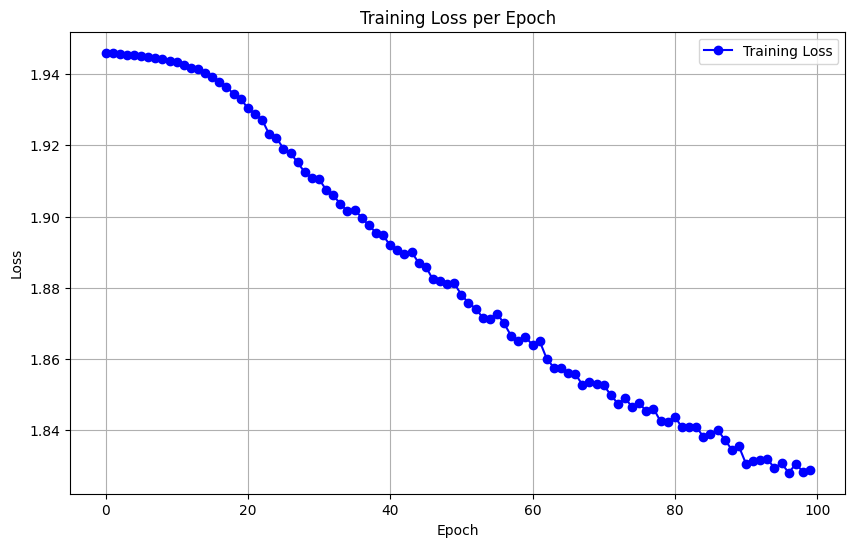

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss_gru_lst, marker='o', color='b', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# gru model save
torch.save(gru_model.state_dict(), f'model/emotion/gru_emotion_classification_model_epoch100.pt')

### Evaluate Four Models



#### 1) LSTM

In [ ]:
## LSTM evaluation
model = LSTM(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('model/emotion/lstm_emotion_classification_model_epoch100.pt'))
model.eval()
with torch.no_grad():
    train_predict,target_hidden,_ = model(X_train_resampled_sm.unsqueeze(1))
    test_predict,test_hidden,_ = model(X_test_resampled_sm.unsqueeze(1))
    train_loss_lstm = lstm_criterion(train_predict, Y_train_resampled_sm)
    test_loss_lstm = lstm_criterion(test_predict, Y_test_resampled_sm)
    print('Train Loss of lstm: {:.4f}'.format(train_loss_lstm.item()))
    print('Test Loss of lstm: {:.4f}'.format(test_loss_lstm.item()))

    y_pred = test_predict.argmax(dim=1)
    f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
    print('F1 score of lstm:', f1)


Train Loss of lstm: 1.8082
Test Loss of lstm: 1.8460
F1 score of lstm: 0.25127514759166775


#### 2) 1D CNN

In [ ]:
## 1DCNN evaluation
model = CNN(input_size, output_size, kernel_size, stride, num_channels, hidden_size)
model.load_state_dict(torch.load('model/emotion/1dcnn_emotion_classification_model_epoch100.pt'))
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor)
    test_predict = model(X_test_tensor)
    train_loss_cnn = cnn_criterion(train_predict, Y_train_tensor)
    test_loss_cnn = cnn_criterion(test_predict, Y_test_tensor)
    print('Train Loss of cnn: {:.4f}'.format(train_loss_cnn.item()))
    print('Test Loss of cnn: {:.4f}'.format(test_loss_cnn.item()))

    y_pred = test_predict.argmax(dim=1)
    f1 = f1_score(Y_test_tensor, y_pred, average='macro')
    print('F1 score of cnn:', f1)


Train Loss of cnn: 1.1836
Test Loss of cnn: 1.8401
F1 score of cnn: 0.300030613378382


#### 3) LSTM Attention

In [ ]:
## lstm with attention evaluation
model = LSTMWithAttention(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('model/emotion/lstm_attention_emotion_classification_model_epoch100.pt'))
model.eval()
with torch.no_grad():
    train_predict,_ = model(X_train_resampled_sm.unsqueeze(1))
    test_predict,_ = model(X_test_resampled_sm.unsqueeze(1))
    train_loss_lstm_attention = lstm_attention_criterion(train_predict, Y_train_resampled_sm)
    test_loss_lstm_attention = lstm_attention_criterion(test_predict, Y_test_resampled_sm)
    print('Train Loss of lstm_attention: {:.4f}'.format(train_loss_lstm_attention.item()))
    print('Test Loss of lstm_attention: {:.4f}'.format(test_loss_lstm_attention.item()))

    y_pred = test_predict.argmax(dim=1)
    f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
    print('F1 score of lstm_attention:', f1)


Train Loss of lstm_attention: 1.4537
Test Loss of lstm_attention: 1.7879
F1 score of lstm_attention: 0.37137606728439465


#### 4) GRU

In [ ]:
## GRU evaluation
model = GRU(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('model/emotion/gru_emotion_classification_model_epoch100.pt'))
model.eval()
with torch.no_grad():
    train_predict,target_hidden,_ = model(X_train_resampled_sm.unsqueeze(1))
    test_predict,test_hidden,_ = model(X_test_resampled_sm.unsqueeze(1))
    train_loss_gru = gru_criterion(train_predict, Y_train_resampled_sm)
    test_loss_gru = gru_criterion(test_predict, Y_test_resampled_sm)
    print('Train Loss of gru: {:.4f}'.format(train_loss_gru.item()))
    print('Test Loss of gru: {:.4f}'.format(test_loss_gru.item()))

    y_pred = test_predict.argmax(dim=1)
    f1 = f1_score(Y_test_resampled_sm, y_pred, average='macro')
    print('F1 score of gru:', f1)


Train Loss of gru: 1.7558
Test Loss of gru: 1.8221
F1 score of gru: 0.31250783876448285


# Part 3 - Audio Highlight Extraction

---

In [ ]:
import os
import json
import math
import librosa
from collections import defaultdict
from pathlib import Path
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
class SummaryDataset(Dataset):
    def __init__(self, video_dir, wav_dir, directory, max_seq_len=250):
        self.directory = directory
        self.video_names = self.get_video_names(video_dir)
        self.wav_dir = wav_dir
        self.max_seq_len = max_seq_len

        # Because we can't use DDP with IterableDataset,
        # data must be pre-chunked to combat OOM.
        self.label_files = self.prefetch_label_files()
        self.data_size, self.index_to_chunk, self.labels = self.prefetch_and_index()

    def get_video_names(self, mp4_dir):
        video_names = []
        for filename in os.listdir(mp4_dir):
            if filename.endswith('.mp4'):
                name = os.path.splitext(filename)[0]
                video_names.append(name)
        return video_names

    def prefetch_label_files(self):
        # video_names 는 이름만 들어있을것 .mp4 제거
        name_set = set(self.video_names)

        label_files = defaultdict(list)

        for label_file in Path(self.directory).glob(f"**/*.json"):

            file_name = label_file.stem

            # 예시: [KBS]kim370_대법원 업무 과부하…상고 법원이 대안_18567498.json
            # annotator id 제거하면 비디오 이름 추출.
            # 파일 이름 reverse ([::-1]) 후 "_" 찾음.
            annotator_id_index = len(file_name) - file_name[::-1].find("_") - 1
            video_name = file_name[:annotator_id_index]

            if video_name in name_set:
                label_files[video_name].append(label_file)

        return label_files

    def prefetch_and_index(self):
        index = 0
        index_to_chunk = {}
        all_labels = {}

        for video_name in self.video_names:

            labels = self.extract_label(video_name)

            all_labels[video_name] = labels

            chunk_count = math.ceil(len(labels[0]) / self.max_seq_len)
            for chunk_index in range(0, chunk_count):
                index_to_chunk[index + chunk_index] = (video_name, chunk_index)

            index += chunk_count

        return index, index_to_chunk, all_labels

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):
        video_name, chunk_index = self.index_to_chunk[index]
        start = chunk_index * self.max_seq_len
        end = start + self.max_seq_len

        labels = self.labels[video_name][:,start:end]

        # audio_data: 음성 데이터, sr: sampling rate, max_seq_len: chunk 단위 길이
        audio_data, sr = librosa.load(f"{self.wav_dir}/{video_name}.wav", sr=None)
        # print(f'audio_data 길이: {len(audio_data)/sr}')
        # print(f'sr: {sr}')

        audio_data = audio_data[start*sr:end*sr]
        # print(f'audio_data 길이: {len(audio_data)/sr}')

        max_seq_len = labels.shape[-1]


        # 1초 단위로 MFCC 추출하여 리스트에 추가
        sec = 1
        mfcc_list = []
        for i in range(0, len(audio_data), sec*sr):
            audio_segment = audio_data[i : i + sec*sr]

            mfcc = librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=32).T
            mfcc_mean = np.mean(mfcc, axis=0)
            mfcc_list.append(mfcc_mean)

        # 리스트를 배열로 변환
        mfcc_array = np.vstack(mfcc_list)

        # Convert labels to 1D array
        labels = torch.from_numpy(labels)
        # majority voting
        labels = labels.squeeze(0)
        labels = torch.sum(labels, dim=0)
        labels = torch.min(
            labels,
            torch.ones(
                labels.shape[0],
            ).to(labels.device),
        )
        return video_name, mfcc_array, labels

    def extract_label(self, video_name):

        label_files = self.label_files[video_name]
        labels = []

        for label_file in label_files:

            with open(label_file, "r") as rf:
                data = json.load(rf)

            metadata = data["metadata"]
            video_length = math.ceil(metadata["length"])
            annotator_label = np.zeros((video_length,))

            for timeline in data["timelines"]:
                for time_index in range(timeline["start"], timeline["end"] + 1):
                    # annotator_label[time_index] += 1
                    if time_index < video_length:
                        annotator_label[time_index] = 1

            labels.append(annotator_label)

        labels = np.array(labels)
        return labels

In [ ]:
# 라벨링 디렉토리 경로
label_path = "video_data/label"

# mp4 파일이 있는 디렉토리 경로
mp4_dir = "video_data/video"

# wav 파일이 있는 디렉토리 경로
wav_dir = "video_data/audio"

### Unzip Label

In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to='.'):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for file in zip_ref.namelist():
                zip_ref.extract(file, extract_to)
                os.rename(os.path.join(extract_to, file), os.path.join(extract_to, file.encode('cp437').decode('euc-kr', 'ignore')))
            print(f"Files extracted successfully to {extract_to}")
    except Exception as e:
        print(f"An error occurred: {e}")

unzip_file('video_data/VL_유튜브.zip', 'video_data/label')



'import zipfile\nimport os\n\ndef unzip_file(zip_path, extract_to=\'.\'):\n    try:\n        with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n            for file in zip_ref.namelist():\n                zip_ref.extract(file, extract_to)\n                os.rename(os.path.join(extract_to, file), os.path.join(extract_to, file.encode(\'cp437\').decode(\'euc-kr\', \'ignore\')))\n            print(f"Files extracted successfully to {extract_to}")\n    except Exception as e:\n        print(f"An error occurred: {e}")\n\nunzip_file(\'video_data/VL_유튜브.zip\', \'video_data/label\')\n'

### Convert .mp4 to .wav

In [ ]:
import moviepy.editor as mp
import os

def convert_mp4_to_wav(source_folder, target_folder):
    """
    Converts all MP4 files in the source_folder to WAV and saves them in the target_folder.
    """
    # Ensure the target folder exists
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Iterate over all files in the source folder
    for file_name in os.listdir(source_folder):
        if file_name.endswith('.mp4'):
            # Construct full file path
            full_file_path = os.path.join(source_folder, file_name)

            # Load the video file
            video = mp.VideoFileClip(full_file_path)

            # Convert to audio
            audio = video.audio

            # Construct output file path
            output_file_path = os.path.join(target_folder, os.path.splitext(file_name)[0] + '.wav')

            # Write the audio file
            audio.write_audiofile(output_file_path)

    print("Conversion complete.")
convert_mp4_to_wav('video_data/video', 'video_data/audio')


chunk:   5%|▌         | 1016/19662 [00:37<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_여행_7699.wav



chunk:   5%|▌         | 1016/19662 [00:46<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [00:47<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_여행_7648.wav



chunk:   5%|▌         | 1016/19662 [01:01<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [01:03<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_여행_7640.wav



chunk:   5%|▌         | 1016/19662 [01:10<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [01:11<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14801.wav



chunk:   5%|▌         | 1016/19662 [01:19<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [01:20<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14781.wav



chunk:   5%|▌         | 1016/19662 [01:29<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [01:31<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14737.wav



chunk:   5%|▌         | 1016/19662 [01:38<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [01:39<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14715.wav



chunk:   5%|▌         | 1016/19662 [01:46<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [01:47<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14701.wav



chunk:   5%|▌         | 1016/19662 [02:02<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [02:03<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14663.wav



chunk:   5%|▌         | 1016/19662 [02:20<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [02:21<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14639.wav



chunk:   5%|▌         | 1016/19662 [02:48<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [02:49<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14630.wav



chunk:   5%|▌         | 1016/19662 [02:57<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [02:57<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20022.wav



chunk:   5%|▌         | 1016/19662 [03:02<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [03:03<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_19999.wav



chunk:   5%|▌         | 1016/19662 [03:12<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [03:14<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_19881.wav



chunk:   5%|▌         | 1016/19662 [03:46<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [03:48<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_19843.wav



chunk:   5%|▌         | 1016/19662 [04:05<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [04:06<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14869.wav



chunk:   5%|▌         | 1016/19662 [04:31<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [04:32<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2153.wav



chunk:   5%|▌         | 1016/19662 [04:42<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [04:44<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2159.wav



chunk:   5%|▌         | 1016/19662 [04:51<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [04:52<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4174.wav



chunk:   5%|▌         | 1016/19662 [05:06<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [05:07<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스타일링및뷰티_14908.wav



chunk:   5%|▌         | 1016/19662 [05:15<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [05:16<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4251.wav



chunk:   5%|▌         | 1016/19662 [05:35<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [05:37<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4322.wav



chunk:   5%|▌         | 1016/19662 [05:49<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [05:50<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20060.wav



chunk:   5%|▌         | 1016/19662 [06:03<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [06:04<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4333.wav



chunk:   5%|▌         | 1016/19662 [06:23<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [06:24<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2161.wav



chunk:   5%|▌         | 1016/19662 [06:52<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [06:53<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4408.wav



chunk:   5%|▌         | 1016/19662 [07:26<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [07:28<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4410.wav



chunk:   5%|▌         | 1016/19662 [07:57<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [07:58<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4437.wav



chunk:   5%|▌         | 1016/19662 [08:10<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [08:11<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4479.wav



chunk:   5%|▌         | 1016/19662 [08:26<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [08:28<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20094.wav



chunk:   5%|▌         | 1016/19662 [08:34<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [08:36<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20145.wav



chunk:   5%|▌         | 1016/19662 [08:48<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [08:49<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20169.wav



chunk:   5%|▌         | 1016/19662 [09:07<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [09:09<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20170.wav



chunk:   5%|▌         | 1016/19662 [09:22<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [09:24<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_기타_20188.wav



chunk:   5%|▌         | 1016/19662 [09:32<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [09:33<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2239.wav



chunk:   5%|▌         | 1016/19662 [10:10<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [10:11<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2250.wav



chunk:   5%|▌         | 1016/19662 [10:28<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [10:30<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2271.wav



chunk:   5%|▌         | 1016/19662 [10:59<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [11:00<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2282.wav



chunk:   5%|▌         | 1016/19662 [11:42<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [11:45<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2302.wav



chunk:   5%|▌         | 1016/19662 [12:05<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [12:06<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2334.wav



chunk:   5%|▌         | 1016/19662 [12:37<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [12:38<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_반려동물및동물_2337.wav



chunk:   5%|▌         | 1016/19662 [13:02<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [13:04<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4552.wav



chunk:   5%|▌         | 1016/19662 [14:07<00:21, 886.27it/s, now=None]

MoviePy - Done.


chunk:   5%|▌         | 1016/19662 [14:08<00:21, 886.27it/s, now=None]

MoviePy - Writing audio in video_data/audio/유튜브_스포츠_4555.wav



chunk:   5%|▌         | 1016/19662 [14:20<00:21, 886.27it/s, now=None]

MoviePy - Done.
Conversion complete.


+ Model Load
+ Load emotion classification model

### Extract Emotion Features from Four Models
+ Save .npy File

In [ ]:
sd = SummaryDataset(mp4_dir, wav_dir, label_path)

In [ ]:
# mfcc shape
# label shape
sd[0][1].shape, sd[0][2].shape

((250, 32), torch.Size([250]))

In [ ]:
dl = DataLoader(sd,batch_size=1)

In [ ]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))
        output = self.fc(out[:,-1,:])
        hidden = self.fc(hidden_state[-1])
        return output, hidden,  out[:,-1,:]


class CNN(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, num_channels, hidden_size):
        super(CNN, self).__init__()
        self.conv1d = nn.Conv1d(1, num_channels, kernel_size=kernel_size, stride=stride)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_channels * (input_size - kernel_size + 1), hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        conv_output = self.conv1d(x)
        x = self.relu(conv_output)
        x = self.flatten(x)

        # Apply the first fully connected layer and use its output as 'out'
        out = self.fc1(x)  # This is now [batch_size, hidden_size]
        x = self.relu(out)

        x = self.fc2(x)
        output = self.softmax(x)

        return output, out

# Create LSTM with Attention Model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        # Compute attention weights
        attention_weights = F.softmax(self.attention(out), dim=1)

        # Apply attention to LSTM outputs
        attention_output = torch.sum(attention_weights * out, dim=1)

        # Apply fully connected layer
        output = self.fc(attention_output)
        output = F.softmax(output, dim=1)

        return output, attention_weights, out

## GRU
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hidden_state = self.gru(x, h0)

        output = self.fc(out[:, -1, :])
        hidden = self.fc(hidden_state[-1])
        output = F.softmax(output, dim=1)
        return output, hidden, out[:, -1, :]


In [ ]:
from tqdm.notebook import tqdm_notebook
learning_rate = 0.001
input_size = 32
hidden_size = 128
output_size = 7
num_layers = 3
kernel_size = 3
num_channels = 16
stride = 1
# load model
lstm_model = LSTM(input_size, hidden_size, num_layers, output_size)
lstm_model.load_state_dict(torch.load('model/emotion/lstm_emotion_classification_model_epoch100.pt'))
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate,weight_decay=1e-5)

cnn_model = CNN(input_size, output_size, kernel_size, stride, num_channels, hidden_size)
cnn_model.load_state_dict(torch.load('model/emotion/1dcnn_emotion_classification_model_epoch100.pt'))
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate,weight_decay=1e-5)


lstm_attention_model = LSTMWithAttention(input_size, hidden_size, num_layers, output_size)
lstm_attention_model.load_state_dict(torch.load('model/emotion/lstm_attention_emotion_classification_model_epoch100.pt'))
lstm_attention_criterion = nn.CrossEntropyLoss()
lstm_attention_optimizer = torch.optim.Adam(lstm_attention_model.parameters(), lr=learning_rate,weight_decay=1e-5)


gru_model = GRU(input_size, hidden_size, num_layers, output_size)
gru_model.load_state_dict(torch.load('model/emotion/gru_emotion_classification_model_epoch100.pt'))
gru_criterion = nn.CrossEntropyLoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate,weight_decay=1e-5)


In [ ]:

emotion_lstm_features = []
emotion_cnn_features = []
emotion_lstm_attention_features = []
emotion_gru_features = []

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset'):
    with torch.no_grad():
        lstm_model.eval()
        outputs, hidden, out = lstm_model(inputs.reshape(-1,1,32))
        emotion_lstm_features.append(out)


Processing dataset:   0%|          | 0/151 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=441
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(


In [ ]:
np.save('lstm_audio_emotion_features.npy', np.array([t for t in emotion_lstm_features]))

<ipython-input-11-4b9ae0cf263e>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save('lstm_audio_emotion_features.npy', np.array([t for t in emotion_lstm_features]))
<ipython-input-11-4b9ae0cf263e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('lstm_audio_emotion_features.npy', np.array([t for t in emotion_lstm_features]))


In [ ]:
emotion_cnn_features = []
for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset'):
    with torch.no_grad():

        cnn_model.eval()
        outputs, out = cnn_model(inputs.reshape(-1,1,32))
        print(out.shape)
        emotion_cnn_features.append(out)


Processing dataset:   0%|          | 0/151 [00:00<?, ?it/s]

torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([191, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([142, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([54, 128])
torch.Size([250, 128])
torch.Size([67, 128])
torch.Size([250, 128])
torch.Size([201, 128])
torch.Size([250, 128])
torch.Size([124, 128])
torch.Size([250, 128])
torch.Size([183, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([102, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([30, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([136, 128])
torch.Size([250, 128])
torch.Size([208, 128])
torch.Size([250, 128])
torch.Size([78, 128])
torch.Size([250, 128])
torch.Size([212, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([246, 128])
torch.Size([250

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(


torch.Size([106, 128])
torch.Size([250, 128])
torch.Size([232, 128])
torch.Size([250, 128])
torch.Size([130, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([86, 128])
torch.Size([250, 128])
torch.Size([148, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([3, 128])
torch.Size([250, 128])


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=441
  warnings.warn(


torch.Size([150, 128])
torch.Size([250, 128])
torch.Size([107, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([69, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([208, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([67, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([231, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([242, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([26, 128])
torch.Size([250, 128])
torch.Size([52, 128])
torch.Size([250, 128])
torch.Size([96, 128])
torch.Size([250, 128])


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(


torch.Size([72, 128])
torch.Size([250, 128])
torch.Size([71, 128])
torch.Size([250, 128])
torch.Size([57, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([35, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([142, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([216, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([179, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([114, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([153, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([68, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([250, 128])
torch.Size([245,

In [ ]:
np.save('1dcnn_audio_emotion_features.npy', np.array([t for t in emotion_cnn_features]))

<ipython-input-46-49da637a75ef>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save('1dcnn_audio_emotion_features.npy', np.array([t for t in emotion_cnn_features]))
<ipython-input-46-49da637a75ef>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('1dcnn_audio_emotion_features.npy', np.array([t for t in emotion_cnn_features]))


In [ ]:
for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset'):
    with torch.no_grad():
        lstm_attention_model.eval()
        outputs, _, out = lstm_attention_model(inputs.reshape(-1,1,32))
        emotion_lstm_attention_features.append(out.squeeze(1))


Processing dataset:   0%|          | 0/151 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=441
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(


In [ ]:
np.save('lstm_attention_audio_emotion_features.npy', np.array([t for t in emotion_lstm_attention_features]))

In [ ]:
for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset'):
    with torch.no_grad():
        gru_model.eval()
        outputs, hidden, out = gru_model(inputs.reshape(-1,1,32))
        emotion_gru_features.append(out)

Processing dataset:   0%|          | 0/151 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=441
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1764
  warnings.warn(


In [ ]:
np.save('gru_audio_emotion_features.npy', np.array([t for t in emotion_gru_features]))

<ipython-input-54-e1ba56c48917>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save('gru_audio_emotion_features.npy', np.array([t for t in emotion_gru_features]))
<ipython-input-54-e1ba56c48917>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('gru_audio_emotion_features.npy', np.array([t for t in emotion_gru_features]))


In [ ]:
loaded_data_list = np.load('1dcnn_audio_emotion_features.npy',allow_pickle=True)

In [ ]:
print(len(loaded_data_list))
print(loaded_data_list[0].shape)

151
torch.Size([250, 128])


### Save Label Feature + Save .npy File

In [ ]:
from tqdm.notebook import tqdm_notebook

emotion_lstm_labels = []

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset'):
    emotion_lstm_labels.append(labels)

Processing dataset:   0%|          | 0/151 [00:00<?, ?it/s]

In [ ]:
data_array = np.array(emotion_lstm_labels)

# label file saving path
file_path = 'labels.npy'

# save .npy file
np.save(file_path, data_array)

In [ ]:
data_array.shape

(151,)

## Define Dataset & DataLoader

In [ ]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
# Create an instance of dataset

## 1) **LSTM** Audio Emotion Feature

In [ ]:
emotion_lstm_labels= np.load('labels.npy',allow_pickle=True)
emotion_lstm_features = np.load('lstm_audio_emotion_features.npy',allow_pickle=True)

In [ ]:
emotion_features = emotion_lstm_features
labels = emotion_lstm_labels

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
md = MyDataset(emotion_features,emotion_lstm_labels)

# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Train Audio Highlight Extration Model

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        output = self.fc(out[:, -1, :])

        # Apply sigmoid activation function to output
        output = self.sigmoid(output)

        return output, out[:, -1, :]

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.squeeze(0).float())
        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.squeeze(0).float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   1%|          | 1/100 [00:03<05:52,  3.56s/it]

epoch [1/100], train_loss: 0.6733924925327301, val_loss: 0.6367135643959045, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:07<06:13,  3.82s/it]

epoch [2/100], train_loss: 0.658556079533365, val_loss: 0.6346303224563599, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:13<08:03,  4.98s/it]

epoch [3/100], train_loss: 0.6572332478231854, val_loss: 0.6346136927604675, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:17<06:59,  4.37s/it]

epoch [4/100], train_loss: 0.6565679497188992, val_loss: 0.6346435546875, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:20<06:22,  4.02s/it]

epoch [5/100], train_loss: 0.6561393542422189, val_loss: 0.6346766352653503, p: 0, r: 0, f: 0


Epochs:   6%|▌         | 6/100 [00:24<06:15,  4.00s/it]

epoch [6/100], train_loss: 0.655830768081877, val_loss: 0.6347044706344604, p: 0, r: 0, f: 0


Epochs:   7%|▋         | 7/100 [00:31<07:23,  4.77s/it]

epoch [7/100], train_loss: 0.6555941687689887, val_loss: 0.6347269415855408, p: 0, r: 0, f: 0


Epochs:   8%|▊         | 8/100 [00:34<06:40,  4.35s/it]

epoch [8/100], train_loss: 0.6554055465592279, val_loss: 0.6347450017929077, p: 0, r: 0, f: 0


Epochs:   9%|▉         | 9/100 [00:36<05:36,  3.70s/it]

epoch [9/100], train_loss: 0.6552488644917805, val_loss: 0.6347589492797852, p: 0, r: 0, f: 0


Epochs:  10%|█         | 10/100 [00:39<04:51,  3.24s/it]

epoch [10/100], train_loss: 0.6551163040929371, val_loss: 0.6347697973251343, p: 0, r: 0, f: 0


Epochs:  11%|█         | 11/100 [00:41<04:20,  2.93s/it]

epoch [11/100], train_loss: 0.6550005237261455, val_loss: 0.634777843952179, p: 0, r: 0, f: 0


Epochs:  12%|█▏        | 12/100 [00:44<04:25,  3.02s/it]

epoch [12/100], train_loss: 0.6548983693122864, val_loss: 0.6347843408584595, p: 0, r: 0, f: 0


Epochs:  13%|█▎        | 13/100 [00:47<04:30,  3.10s/it]

epoch [13/100], train_loss: 0.6548055142164231, val_loss: 0.6347891092300415, p: 0, r: 0, f: 0


Epochs:  14%|█▍        | 14/100 [00:50<04:06,  2.87s/it]

epoch [14/100], train_loss: 0.654720926615927, val_loss: 0.634794294834137, p: 0, r: 0, f: 0


Epochs:  15%|█▌        | 15/100 [00:52<03:48,  2.69s/it]

epoch [15/100], train_loss: 0.6546431726879544, val_loss: 0.6347984075546265, p: 0, r: 0, f: 0


Epochs:  16%|█▌        | 16/100 [00:54<03:33,  2.54s/it]

epoch [16/100], train_loss: 0.654569074511528, val_loss: 0.6348045468330383, p: 0, r: 0, f: 0


Epochs:  17%|█▋        | 17/100 [00:56<03:22,  2.43s/it]

epoch [17/100], train_loss: 0.654501360323694, val_loss: 0.6348079442977905, p: 0, r: 0, f: 0


Epochs:  18%|█▊        | 18/100 [00:59<03:28,  2.54s/it]

epoch [18/100], train_loss: 0.6544336686531703, val_loss: 0.6348127126693726, p: 0, r: 0, f: 0


Epochs:  19%|█▉        | 19/100 [01:02<03:44,  2.77s/it]

epoch [19/100], train_loss: 0.6543682846758101, val_loss: 0.634818971157074, p: 0, r: 0, f: 0


Epochs:  20%|██        | 20/100 [01:05<03:39,  2.75s/it]

epoch [20/100], train_loss: 0.6543054921759499, val_loss: 0.6348298788070679, p: 0, r: 0, f: 0


Epochs:  21%|██        | 21/100 [01:07<03:22,  2.56s/it]

epoch [21/100], train_loss: 0.6542462425099479, val_loss: 0.6348429322242737, p: 0, r: 0, f: 0


Epochs:  22%|██▏       | 22/100 [01:09<03:09,  2.43s/it]

epoch [22/100], train_loss: 0.6541920204957327, val_loss: 0.6348640322685242, p: 0, r: 0, f: 0


Epochs:  23%|██▎       | 23/100 [01:12<03:13,  2.51s/it]

epoch [23/100], train_loss: 0.6541403207514022, val_loss: 0.6348815560340881, p: 0, r: 0, f: 0


Epochs:  24%|██▍       | 24/100 [01:16<03:49,  3.02s/it]

epoch [24/100], train_loss: 0.6540857113069958, val_loss: 0.6348815560340881, p: 0, r: 0, f: 0


Epochs:  25%|██▌       | 25/100 [01:19<03:50,  3.07s/it]

epoch [25/100], train_loss: 0.6540195378992293, val_loss: 0.6348941922187805, p: 0, r: 0, f: 0


Epochs:  26%|██▌       | 26/100 [01:22<03:34,  2.90s/it]

epoch [26/100], train_loss: 0.6539545410209232, val_loss: 0.6349123120307922, p: 0, r: 0, f: 0


Epochs:  27%|██▋       | 27/100 [01:24<03:15,  2.68s/it]

epoch [27/100], train_loss: 0.6539015975263384, val_loss: 0.6349252462387085, p: 0, r: 0, f: 0


Epochs:  28%|██▊       | 28/100 [01:26<03:02,  2.53s/it]

epoch [28/100], train_loss: 0.6538388735718197, val_loss: 0.6349443793296814, p: 0, r: 0, f: 0


Epochs:  29%|██▉       | 29/100 [01:28<02:52,  2.43s/it]

epoch [29/100], train_loss: 0.6537836233774821, val_loss: 0.6349675059318542, p: 0, r: 0, f: 0


Epochs:  30%|███       | 30/100 [01:31<02:44,  2.35s/it]

epoch [30/100], train_loss: 0.6537307285600238, val_loss: 0.6349874138832092, p: 0, r: 0, f: 0


Epochs:  31%|███       | 31/100 [01:34<02:57,  2.58s/it]

epoch [31/100], train_loss: 0.6536834726730982, val_loss: 0.635005533695221, p: 0, r: 0, f: 0


Epochs:  32%|███▏      | 32/100 [01:37<03:07,  2.76s/it]

epoch [32/100], train_loss: 0.6536240809493594, val_loss: 0.6350194215774536, p: 0, r: 0, f: 0


Epochs:  33%|███▎      | 33/100 [01:39<02:54,  2.60s/it]

epoch [33/100], train_loss: 0.6535684747828377, val_loss: 0.635037362575531, p: 0, r: 0, f: 0


Epochs:  34%|███▍      | 34/100 [01:41<02:43,  2.47s/it]

epoch [34/100], train_loss: 0.6535124093294143, val_loss: 0.6350519061088562, p: 0, r: 0, f: 0


Epochs:  35%|███▌      | 35/100 [01:43<02:35,  2.39s/it]

epoch [35/100], train_loss: 0.6534561918841468, val_loss: 0.6350704431533813, p: 0, r: 0, f: 0


Epochs:  36%|███▌      | 36/100 [01:46<02:29,  2.34s/it]

epoch [36/100], train_loss: 0.6534038388066822, val_loss: 0.6350882053375244, p: 0, r: 0, f: 0


Epochs:  37%|███▋      | 37/100 [01:48<02:30,  2.39s/it]

epoch [37/100], train_loss: 0.6533480561441846, val_loss: 0.6351088881492615, p: 0, r: 0, f: 0


Epochs:  38%|███▊      | 38/100 [01:51<02:43,  2.63s/it]

epoch [38/100], train_loss: 0.6532969368828667, val_loss: 0.6351291537284851, p: 0, r: 0, f: 0


Epochs:  39%|███▉      | 39/100 [01:54<02:45,  2.71s/it]

epoch [39/100], train_loss: 0.653244826859898, val_loss: 0.6351465582847595, p: 0, r: 0, f: 0


Epochs:  40%|████      | 40/100 [01:56<02:32,  2.55s/it]

epoch [40/100], train_loss: 0.6531910204225116, val_loss: 0.6351613998413086, p: 0, r: 0, f: 0


Epochs:  41%|████      | 41/100 [01:59<02:23,  2.43s/it]

epoch [41/100], train_loss: 0.653133914868037, val_loss: 0.6351844668388367, p: 0, r: 0, f: 0


Epochs:  42%|████▏     | 42/100 [02:01<02:16,  2.36s/it]

epoch [42/100], train_loss: 0.6530806057982974, val_loss: 0.6352096199989319, p: 0, r: 0, f: 0


Epochs:  43%|████▎     | 43/100 [02:03<02:11,  2.30s/it]

epoch [43/100], train_loss: 0.6530308375755945, val_loss: 0.6352273225784302, p: 0, r: 0, f: 0


Epochs:  44%|████▍     | 44/100 [02:06<02:19,  2.49s/it]

epoch [44/100], train_loss: 0.6529755122131772, val_loss: 0.6352514028549194, p: 0, r: 0, f: 0


Epochs:  45%|████▌     | 45/100 [02:09<02:27,  2.69s/it]

epoch [45/100], train_loss: 0.652928215596411, val_loss: 0.635272741317749, p: 0, r: 0, f: 0


Epochs:  46%|████▌     | 46/100 [02:12<02:22,  2.63s/it]

epoch [46/100], train_loss: 0.6528737203942405, val_loss: 0.635294497013092, p: 0, r: 0, f: 0


Epochs:  47%|████▋     | 47/100 [02:14<02:12,  2.50s/it]

epoch [47/100], train_loss: 0.6528199536932839, val_loss: 0.6353225111961365, p: 0, r: 0, f: 0


Epochs:  48%|████▊     | 48/100 [02:16<02:04,  2.40s/it]

epoch [48/100], train_loss: 0.6527689019838969, val_loss: 0.635351836681366, p: 0, r: 0, f: 0


Epochs:  49%|████▉     | 49/100 [02:18<01:59,  2.34s/it]

epoch [49/100], train_loss: 0.6527181304163403, val_loss: 0.6353752613067627, p: 0, r: 0, f: 0


Epochs:  50%|█████     | 50/100 [02:20<01:55,  2.31s/it]

epoch [50/100], train_loss: 0.6526582519213359, val_loss: 0.6354075074195862, p: 0, r: 0, f: 0


Epochs:  51%|█████     | 51/100 [02:24<02:06,  2.59s/it]

epoch [51/100], train_loss: 0.6526098615593381, val_loss: 0.635436475276947, p: 0, r: 0, f: 0


Epochs:  52%|█████▏    | 52/100 [02:27<02:11,  2.75s/it]

epoch [52/100], train_loss: 0.6525583578480615, val_loss: 0.6354742646217346, p: 0, r: 0, f: 0


Epochs:  53%|█████▎    | 53/100 [02:29<02:00,  2.57s/it]

epoch [53/100], train_loss: 0.6525094204478794, val_loss: 0.6355016827583313, p: 0, r: 0, f: 0


Epochs:  54%|█████▍    | 54/100 [02:31<01:52,  2.44s/it]

epoch [54/100], train_loss: 0.6524518900447421, val_loss: 0.6355399489402771, p: 0, r: 0, f: 0


Epochs:  55%|█████▌    | 55/100 [02:33<01:45,  2.35s/it]

epoch [55/100], train_loss: 0.6523995677630107, val_loss: 0.6355753540992737, p: 0, r: 0, f: 0


Epochs:  56%|█████▌    | 56/100 [02:35<01:41,  2.30s/it]

epoch [56/100], train_loss: 0.6523452682627572, val_loss: 0.635617196559906, p: 0, r: 0, f: 0


Epochs:  57%|█████▋    | 57/100 [02:38<01:43,  2.40s/it]

epoch [57/100], train_loss: 0.65229226383898, val_loss: 0.6356538534164429, p: 0, r: 0, f: 0


Epochs:  58%|█████▊    | 58/100 [02:41<01:50,  2.62s/it]

epoch [58/100], train_loss: 0.6522374368376203, val_loss: 0.6356973052024841, p: 0, r: 0, f: 0


Epochs:  59%|█████▉    | 59/100 [02:44<01:50,  2.68s/it]

epoch [59/100], train_loss: 0.6521869281927745, val_loss: 0.6357380151748657, p: 0, r: 0, f: 0


Epochs:  60%|██████    | 60/100 [02:46<01:41,  2.54s/it]

epoch [60/100], train_loss: 0.652136120862431, val_loss: 0.6357849836349487, p: 0, r: 0, f: 0


Epochs:  61%|██████    | 61/100 [02:48<01:35,  2.44s/it]

epoch [61/100], train_loss: 0.652081275317404, val_loss: 0.6358360648155212, p: 0, r: 0, f: 0


Epochs:  62%|██████▏   | 62/100 [02:51<01:30,  2.37s/it]

epoch [62/100], train_loss: 0.6520310421784719, val_loss: 0.6358930468559265, p: 0, r: 0, f: 0


Epochs:  63%|██████▎   | 63/100 [02:53<01:25,  2.31s/it]

epoch [63/100], train_loss: 0.6519796997308731, val_loss: 0.635952889919281, p: 0, r: 0, f: 0


Epochs:  64%|██████▍   | 64/100 [02:56<01:30,  2.52s/it]

epoch [64/100], train_loss: 0.6519204845031102, val_loss: 0.6360034346580505, p: 0, r: 0, f: 0


Epochs:  65%|██████▌   | 65/100 [02:59<01:36,  2.74s/it]

epoch [65/100], train_loss: 0.651860585477617, val_loss: 0.6360613107681274, p: 0, r: 0, f: 0


Epochs:  66%|██████▌   | 66/100 [03:01<01:29,  2.63s/it]

epoch [66/100], train_loss: 0.6518055723773108, val_loss: 0.6361255049705505, p: 0, r: 0, f: 0


Epochs:  67%|██████▋   | 67/100 [03:04<01:22,  2.50s/it]

epoch [67/100], train_loss: 0.6517545100715425, val_loss: 0.6361914277076721, p: 0, r: 0, f: 0


Epochs:  68%|██████▊   | 68/100 [03:06<01:16,  2.40s/it]

epoch [68/100], train_loss: 0.651694177918964, val_loss: 0.6362640857696533, p: 0, r: 0, f: 0


Epochs:  69%|██████▉   | 69/100 [03:08<01:12,  2.33s/it]

epoch [69/100], train_loss: 0.6516376478804482, val_loss: 0.6363330483436584, p: 0, r: 0, f: 0


Epochs:  70%|███████   | 70/100 [03:10<01:11,  2.37s/it]

epoch [70/100], train_loss: 0.6515819466776318, val_loss: 0.6364113688468933, p: 0, r: 0, f: 0


Epochs:  71%|███████   | 71/100 [03:14<01:16,  2.65s/it]

epoch [71/100], train_loss: 0.6515274501509136, val_loss: 0.6364802718162537, p: 0, r: 0, f: 0


Epochs:  72%|███████▏  | 72/100 [03:17<01:17,  2.78s/it]

epoch [72/100], train_loss: 0.6514649076594247, val_loss: 0.6365574598312378, p: 0, r: 0, f: 0


Epochs:  73%|███████▎  | 73/100 [03:19<01:10,  2.60s/it]

epoch [73/100], train_loss: 0.6514031529426575, val_loss: 0.6366387605667114, p: 0, r: 0, f: 0


Epochs:  74%|███████▍  | 74/100 [03:21<01:04,  2.48s/it]

epoch [74/100], train_loss: 0.651342111825943, val_loss: 0.6367312073707581, p: 0, r: 0, f: 0


Epochs:  75%|███████▌  | 75/100 [03:23<00:59,  2.40s/it]

epoch [75/100], train_loss: 0.6512767447365655, val_loss: 0.636824905872345, p: 0, r: 0, f: 0


Epochs:  76%|███████▌  | 76/100 [03:26<00:56,  2.35s/it]

epoch [76/100], train_loss: 0.6512104875511593, val_loss: 0.6369268298149109, p: 0, r: 0, f: 0


Epochs:  77%|███████▋  | 77/100 [03:28<00:58,  2.53s/it]

epoch [77/100], train_loss: 0.6511415133873621, val_loss: 0.6370340585708618, p: 0, r: 0, f: 0


Epochs:  78%|███████▊  | 78/100 [03:32<00:59,  2.72s/it]

epoch [78/100], train_loss: 0.6510714646842745, val_loss: 0.6371513605117798, p: 0, r: 0, f: 0


Epochs:  79%|███████▉  | 79/100 [03:34<00:55,  2.65s/it]

epoch [79/100], train_loss: 0.6509977695014741, val_loss: 0.6372793316841125, p: 0, r: 0, f: 0


Epochs:  80%|████████  | 80/100 [03:36<00:49,  2.50s/it]

epoch [80/100], train_loss: 0.6509188969930013, val_loss: 0.637416660785675, p: 0.3651376146788991, r: 0.9995433789954338, f: 0.5348808796579108


Epochs:  81%|████████  | 81/100 [03:38<00:45,  2.39s/it]

epoch [81/100], train_loss: 0.6508379028903113, val_loss: 0.6375647187232971, p: 0.36525946938094445, r: 0.9995433789954338, f: 0.5350116094341929


Epochs:  82%|████████▏ | 82/100 [03:41<00:41,  2.32s/it]

epoch [82/100], train_loss: 0.6507519953780704, val_loss: 0.6377242207527161, p: 0.3654584934023718, r: 0.9990867579908675, f: 0.5351595939831234


Epochs:  83%|████████▎ | 83/100 [03:43<00:38,  2.29s/it]

epoch [83/100], train_loss: 0.6506597353352441, val_loss: 0.63788902759552, p: 0.36542962219993314, r: 0.9981735159817352, f: 0.5349975526186981


Epochs:  84%|████████▍ | 84/100 [03:46<00:41,  2.56s/it]

epoch [84/100], train_loss: 0.6505647195710076, val_loss: 0.6380592584609985, p: 0.3654168061600268, r: 0.9968036529680365, f: 0.5347868691817736


Epochs:  85%|████████▌ | 85/100 [03:49<00:41,  2.74s/it]

epoch [85/100], train_loss: 0.6504680044121213, val_loss: 0.6382313966751099, p: 0.3655391828533155, r: 0.9968036529680365, f: 0.5349179122764028


Epochs:  86%|████████▌ | 86/100 [03:51<00:36,  2.58s/it]

epoch [86/100], train_loss: 0.6503654178645876, val_loss: 0.638404905796051, p: 0.36549413735343383, r: 0.9963470319634703, f: 0.5348039215686274


Epochs:  87%|████████▋ | 87/100 [03:54<00:31,  2.45s/it]

epoch [87/100], train_loss: 0.6502667271428638, val_loss: 0.6385688781738281, p: 0.36555536940861116, r: 0.9963470319634703, f: 0.534869469297708


Epochs:  88%|████████▊ | 88/100 [03:56<00:28,  2.38s/it]

epoch [88/100], train_loss: 0.6501635561386744, val_loss: 0.6387352347373962, p: 0.3655715722427087, r: 0.9958904109589041, f: 0.5348209906817067


Epochs:  89%|████████▉ | 89/100 [03:58<00:25,  2.32s/it]

epoch [89/100], train_loss: 0.6500617689556546, val_loss: 0.6388940215110779, p: 0.36543624161073823, r: 0.9945205479452055, f: 0.5344785276073619


Epochs:  90%|█████████ | 90/100 [04:00<00:23,  2.39s/it]

epoch [90/100], train_loss: 0.6499602559540006, val_loss: 0.6390488147735596, p: 0.36523929471032746, r: 0.9931506849315068, f: 0.5340699815837938


Epochs:  91%|█████████ | 91/100 [04:04<00:23,  2.64s/it]

epoch [91/100], train_loss: 0.6498588197761112, val_loss: 0.6391993761062622, p: 0.36508736559139787, r: 0.9922374429223745, f: 0.5337754851387866


Epochs:  92%|█████████▏| 92/100 [04:07<00:21,  2.70s/it]

epoch [92/100], train_loss: 0.6497615145312415, val_loss: 0.639340341091156, p: 0.3650420168067227, r: 0.9917808219178083, f: 0.5336609336609337


Epochs:  93%|█████████▎| 93/100 [04:09<00:17,  2.55s/it]

epoch [93/100], train_loss: 0.6496601164340973, val_loss: 0.6394773125648499, p: 0.36510337871911247, r: 0.9917808219178083, f: 0.5337265020272761


Epochs:  94%|█████████▍| 94/100 [04:11<00:14,  2.44s/it]

epoch [94/100], train_loss: 0.6495625694592794, val_loss: 0.6396158337593079, p: 0.36516476126429054, r: 0.9917808219178083, f: 0.5337920865077416


Epochs:  95%|█████████▌| 95/100 [04:13<00:11,  2.35s/it]

epoch [95/100], train_loss: 0.6494624889559216, val_loss: 0.6397446990013123, p: 0.3652422611036339, r: 0.991324200913242, f: 0.5338087042045734


Epochs:  96%|█████████▌| 96/100 [04:15<00:09,  2.30s/it]

epoch [96/100], train_loss: 0.6493650588724348, val_loss: 0.6398734450340271, p: 0.3653490328006728, r: 0.9917808219178083, f: 0.5339889366933005


Epochs:  97%|█████████▋| 97/100 [04:18<00:07,  2.51s/it]

epoch [97/100], train_loss: 0.6492649204201169, val_loss: 0.6400018334388733, p: 0.3652422611036339, r: 0.991324200913242, f: 0.5338087042045734


Epochs:  98%|█████████▊| 98/100 [04:21<00:05,  2.72s/it]

epoch [98/100], train_loss: 0.6491716470983293, val_loss: 0.6401277780532837, p: 0.3653651969033995, r: 0.991324200913242, f: 0.5339399901623216


Epochs:  99%|█████████▉| 99/100 [04:24<00:02,  2.70s/it]

epoch [99/100], train_loss: 0.6490729812118742, val_loss: 0.6402504444122314, p: 0.3652583740111092, r: 0.9908675799086758, f: 0.5337596851555775


Epochs: 100%|██████████| 100/100 [04:26<00:00,  2.67s/it]

epoch [100/100], train_loss: 0.6489760498205821, val_loss: 0.6403785943984985, p: 0.36515151515151517, r: 0.9904109589041096, f: 0.533579335793358


In [ ]:
outputs[:5]

tensor([[0.4315],
        [0.4325],
        [0.2832],
        [0.2757],
        [0.2888]])

### Plot Training Loss Curve & Validation Loss Curve

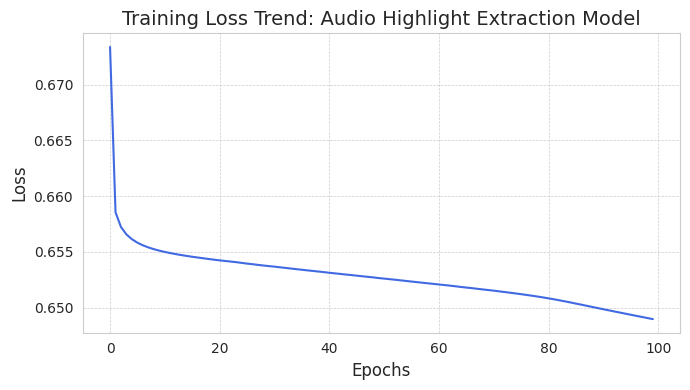

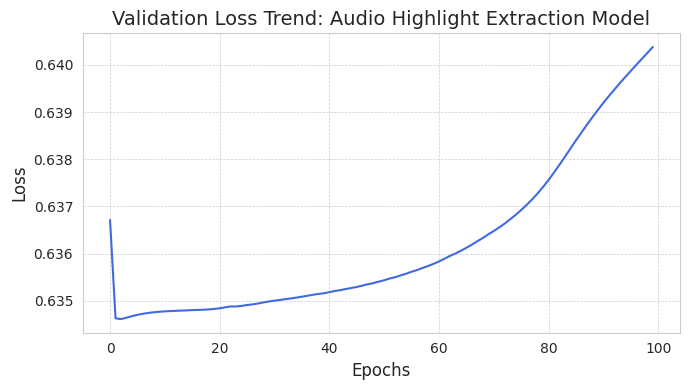

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))
plt.plot(train_loss, color='royalblue')
plt.title("Training Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))
plt.plot(val_loss, color='royalblue')
plt.title("Validation Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/lstm_audio_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Evaluate Audio Highlight Extraction Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/lstm_audio_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if len(inputs)!= len(labels) :
          continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])

y_true_pad = np.concatenate(y_true, axis=1).squeeze()
y_pred_pad = np.concatenate(y_pred, axis=0)

len(y_true_pad), len(y_pred_pad)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred_pad > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true_pad, y_pred_t, average='binary')
    acc = accuracy_score(y_true_pad, y_pred_t)
    prec = precision_score(y_true_pad, y_pred_t)
    rec = recall_score(y_true_pad, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-36-079b04a6304d>:18: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-36-079b04a6304d>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-36-079b04a6304d>:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing

Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.572160  0.400717   0.400717  1.000000
2        0.10  0.572483  0.402151   0.401207  0.998927
3        0.15  0.572753  0.405161   0.402111  0.994991
4        0.20  0.572229  0.409032   0.403011  0.986404
5        0.25  0.569472  0.414050   0.403553  0.967084
6        0.30  0.548304  0.471111   0.416791  0.801073
7        0.35  0.511298  0.525591   0.435362  0.619320
8        0.40  0.286659  0.566882   0.421528  0.217174
9        0.45  0.002851  0.598853   0.363636  0.001431
10       0.50  0.000000  0.599283   0.000000  0.000000
11       0.55  0.000000  0.599283   0.000000  0.000000
12       0.60  0.000000  0.599283   0.000000  0.000000
13       0.65  0.000000  0.599283   0.000000  0.000000
14       0.70  0.000000  0.599283   0.000000  0.000000
15       0.75  0.000000  0.599283   0.000000  0.000000
16       0.80  0.000000  0.599283   0.000000  0.000000
17       0.85  0.000000  0.599283   0.000000  0.000000
18       0.90  0.000000  0.599283   0.000000  0.000000
19       0.95  0.000000  0.599283   0.000000  0.000000
20       1.00  0.000000  0.599283   0.000000  0.000000

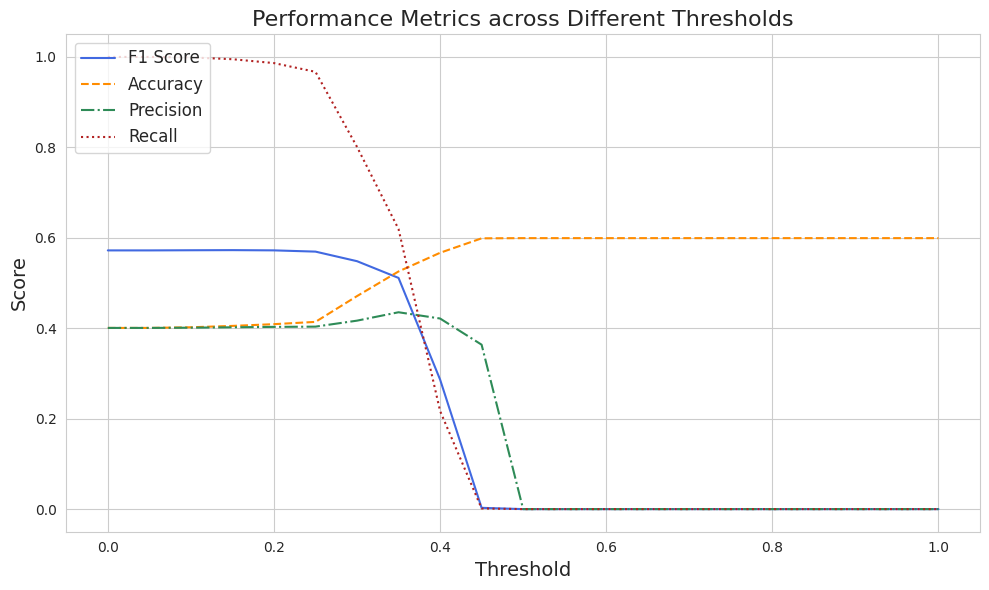

In [ ]:
# plot results

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()




### Extract Audio Highlight Feature



In [ ]:
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load("model/highlight/lstm_audio_highlight_detection_model.pt"))
md = MyDataset(emotion_lstm_features,emotion_lstm_labels)
dataloader = DataLoader(md)

In [ ]:
from tqdm.notebook import tqdm_notebook

concatenate_features = []

count = 1
for inputs, labels in tqdm_notebook(dataloader,total=len(dataloader)):
    with torch.no_grad():
        model.eval()
#         if inputs.shape[1] != labels.shape[1] : continue

        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)

        # Forward pass
        outputs,out = model(inputs)
        count += 1
        concatenate_features.append(out.cpu())

  0%|          | 0/151 [00:00<?, ?it/s]

In [ ]:
data_array = np.array(concatenate_features)

np.save('lstm_concatenate_audio_features_array.npy',data_array)

<ipython-input-40-202415d01cd6>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(concatenate_features)
<ipython-input-40-202415d01cd6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(concatenate_features)


## 2) **1D CNN** Audio Emotion Feature

In [ ]:
emotion_lstm_labels= np.load('labels.npy',allow_pickle=True)
emotion_cnn_features = np.load('1dcnn_audio_emotion_features.npy',allow_pickle=True)

In [ ]:
emotion_features = emotion_cnn_features
labels = emotion_lstm_labels

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
md = MyDataset(emotion_features,labels)

# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Train Audio Highlight Extration Model

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.squeeze(0).float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.squeeze(0).float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-15-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])
Epochs:   1%|          | 1/100 [00:09<15:49,  9.59s/it]

epoch [1/100], train_loss: 0.6701995846298006, val_loss: 0.6377328038215637, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:16<13:30,  8.27s/it]

epoch [2/100], train_loss: 0.6596032831403944, val_loss: 0.6368215680122375, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:25<13:31,  8.36s/it]

epoch [3/100], train_loss: 0.6573437273502349, val_loss: 0.6357330679893494, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:34<13:56,  8.71s/it]

epoch [4/100], train_loss: 0.6558687849177255, val_loss: 0.6361197233200073, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:46<15:47,  9.98s/it]

epoch [5/100], train_loss: 0.6529695232709248, val_loss: 0.6342257261276245, p: 0.3682403433476395, r: 0.9794520547945206, f: 0.5352464129756707


Epochs:   6%|▌         | 6/100 [00:51<13:00,  8.31s/it]

epoch [6/100], train_loss: 0.6516162127256393, val_loss: 0.637555718421936, p: 0.36864697802197804, r: 0.9803652968036529, f: 0.5358123284252558


Epochs:   7%|▋         | 7/100 [00:56<10:49,  6.98s/it]

epoch [7/100], train_loss: 0.6496831726696756, val_loss: 0.6391475796699524, p: 0.3690496797645837, r: 0.9735159817351599, f: 0.535207731894063


Epochs:   8%|▊         | 8/100 [01:01<09:55,  6.47s/it]

epoch [8/100], train_loss: 0.6474751598305173, val_loss: 0.6411148309707642, p: 0.3685401078823734, r: 0.9671232876712329, f: 0.533702910419554


Epochs:   9%|▉         | 9/100 [01:07<09:43,  6.42s/it]

epoch [9/100], train_loss: 0.6477607309818267, val_loss: 0.6383194327354431, p: 0.3689421573736321, r: 0.9698630136986301, f: 0.5345413363533409


Epochs:  10%|█         | 10/100 [01:13<09:15,  6.17s/it]

epoch [10/100], train_loss: 0.6457363474700186, val_loss: 0.6376520395278931, p: 0.36920415224913494, r: 0.9744292237442922, f: 0.5355081555834379


Epochs:  11%|█         | 11/100 [01:21<09:50,  6.64s/it]

epoch [11/100], train_loss: 0.6453156529201401, val_loss: 0.6420764923095703, p: 0.368669228082431, r: 0.9639269406392694, f: 0.5333501768569985


Epochs:  12%|█▏        | 12/100 [01:28<09:56,  6.77s/it]

epoch [12/100], train_loss: 0.6434105674425761, val_loss: 0.6392224431037903, p: 0.3716488522866655, r: 0.9684931506849315, f: 0.5371660124097759


Epochs:  13%|█▎        | 13/100 [01:37<10:57,  7.55s/it]

epoch [13/100], train_loss: 0.6444618943664763, val_loss: 0.6428552865982056, p: 0.37163247100802854, r: 0.9511415525114155, f: 0.5344451571520205


Epochs:  14%|█▍        | 14/100 [01:44<10:37,  7.42s/it]

epoch [14/100], train_loss: 0.6417566158705288, val_loss: 0.6400356292724609, p: 0.3713984539704849, r: 0.965296803652968, f: 0.536412078152753


Epochs:  15%|█▌        | 15/100 [01:55<12:02,  8.50s/it]

epoch [15/100], train_loss: 0.6391680402888192, val_loss: 0.6434808373451233, p: 0.37234611953612845, r: 0.9529680365296803, f: 0.5354714560615779


Epochs:  16%|█▌        | 16/100 [02:03<11:28,  8.20s/it]

epoch [16/100], train_loss: 0.6391239874892765, val_loss: 0.6458391547203064, p: 0.3700234192037471, r: 0.9378995433789954, f: 0.5306807905955303


Epochs:  17%|█▋        | 17/100 [02:13<12:17,  8.88s/it]

epoch [17/100], train_loss: 0.636861135562261, val_loss: 0.6434585452079773, p: 0.37186108637577914, r: 0.9534246575342465, f: 0.5350416399743754


Epochs:  18%|█▊        | 18/100 [02:20<11:14,  8.23s/it]

epoch [18/100], train_loss: 0.6345632058050897, val_loss: 0.6411093473434448, p: 0.3728266714464958, r: 0.9497716894977168, f: 0.5354614493499806


Epochs:  19%|█▉        | 19/100 [02:26<10:09,  7.53s/it]

epoch [19/100], train_loss: 0.6390410761038462, val_loss: 0.6446486711502075, p: 0.3709449929478138, r: 0.960730593607306, f: 0.5352327651996948


Epochs:  20%|██        | 20/100 [02:33<09:49,  7.37s/it]

epoch [20/100], train_loss: 0.6325358364317152, val_loss: 0.6440349221229553, p: 0.37287832767554047, r: 0.9529680365296803, f: 0.5360215744189033


Epochs:  21%|██        | 21/100 [02:38<08:41,  6.60s/it]

epoch [21/100], train_loss: 0.6334478151467111, val_loss: 0.645618200302124, p: 0.37335526315789475, r: 0.9328767123287671, f: 0.533281127642913


Epochs:  22%|██▏       | 22/100 [02:43<08:04,  6.21s/it]

epoch [22/100], train_loss: 0.6302207147081693, val_loss: 0.6526666879653931, p: 0.37257438551099614, r: 0.9205479452054794, f: 0.5304565188790948


Epochs:  23%|██▎       | 23/100 [02:50<08:19,  6.49s/it]

epoch [23/100], train_loss: 0.6302713440524207, val_loss: 0.651029646396637, p: 0.37213144850376356, r: 0.9255707762557077, f: 0.5308367159879535


Epochs:  24%|██▍       | 24/100 [02:55<07:43,  6.10s/it]

epoch [24/100], train_loss: 0.6238925589455498, val_loss: 0.6526199579238892, p: 0.3702296979562308, r: 0.9347031963470319, f: 0.5303795828475191


Epochs:  25%|██▌       | 25/100 [03:01<07:27,  5.97s/it]

epoch [25/100], train_loss: 0.6255864704648654, val_loss: 0.6568931937217712, p: 0.372020535386872, r: 0.9264840182648402, f: 0.5308738880167452


Epochs:  26%|██▌       | 26/100 [03:08<07:50,  6.35s/it]

epoch [26/100], train_loss: 0.6259702990452448, val_loss: 0.6555368900299072, p: 0.37153419593345655, r: 0.9178082191780822, f: 0.5289473684210527


Epochs:  27%|██▋       | 27/100 [03:13<07:03,  5.80s/it]

epoch [27/100], train_loss: 0.6215949765510029, val_loss: 0.6626110672950745, p: 0.37178517397882, r: 0.897716894977169, f: 0.5258090398502273


Epochs:  28%|██▊       | 28/100 [03:18<06:42,  5.60s/it]

epoch [28/100], train_loss: 0.6222407501604822, val_loss: 0.6589504480361938, p: 0.3708806553714392, r: 0.9095890410958904, f: 0.5269144293082926


Epochs:  29%|██▉       | 29/100 [03:24<06:55,  5.85s/it]

epoch [29/100], train_loss: 0.6208055910964807, val_loss: 0.6651245951652527, p: 0.3715638084835245, r: 0.9319634703196347, f: 0.5313028764805414


Epochs:  30%|███       | 30/100 [03:28<05:57,  5.11s/it]

epoch [30/100], train_loss: 0.6188574065764745, val_loss: 0.6648107767105103, p: 0.37295909007521555, r: 0.9283105022831051, f: 0.5321293024473236


Epochs:  31%|███       | 31/100 [03:31<05:15,  4.58s/it]

epoch [31/100], train_loss: 0.617819693353441, val_loss: 0.6719914078712463, p: 0.3712918660287081, r: 0.8858447488584474, f: 0.5232636547538773


Epochs:  32%|███▏      | 32/100 [03:35<04:52,  4.30s/it]

epoch [32/100], train_loss: 0.6175042231877644, val_loss: 0.6600213646888733, p: 0.37437511571931126, r: 0.9232876712328767, f: 0.532736134896588


Epochs:  33%|███▎      | 33/100 [03:39<04:52,  4.37s/it]

epoch [33/100], train_loss: 0.6168883189558982, val_loss: 0.6611840128898621, p: 0.3738866780367633, r: 0.9009132420091325, f: 0.5284585509575466


Epochs:  34%|███▍      | 34/100 [03:43<04:28,  4.07s/it]

epoch [34/100], train_loss: 0.6187272601657443, val_loss: 0.6668186187744141, p: 0.375, r: 0.8876712328767123, f: 0.5272579332790888


Epochs:  35%|███▌      | 35/100 [03:46<04:09,  3.84s/it]

epoch [35/100], train_loss: 0.6137584567070007, val_loss: 0.6695873737335205, p: 0.375142748382185, r: 0.9, f: 0.5295540032240731


Epochs:  36%|███▌      | 36/100 [03:49<03:52,  3.63s/it]

epoch [36/100], train_loss: 0.6119321583045854, val_loss: 0.6684329509735107, p: 0.37317073170731707, r: 0.9082191780821918, f: 0.5289893617021276


Epochs:  37%|███▋      | 37/100 [03:53<03:58,  3.78s/it]

epoch [37/100], train_loss: 0.6114191923704412, val_loss: 0.6652922034263611, p: 0.37740155982499524, r: 0.9059360730593607, f: 0.532832012891097


Epochs:  38%|███▊      | 38/100 [03:57<04:00,  3.87s/it]

epoch [38/100], train_loss: 0.6117988987101449, val_loss: 0.6605820059776306, p: 0.3797063253012048, r: 0.9210045662100457, f: 0.537723273793655


Epochs:  39%|███▉      | 39/100 [04:01<03:58,  3.90s/it]

epoch [39/100], train_loss: 0.6101203186644448, val_loss: 0.6652262806892395, p: 0.37706190568600817, r: 0.8872146118721461, f: 0.5292114939398066


Epochs:  40%|████      | 40/100 [04:04<03:39,  3.65s/it]

epoch [40/100], train_loss: 0.6074167811208301, val_loss: 0.6708486080169678, p: 0.37632978723404253, r: 0.9045662100456621, f: 0.5315266970753957


Epochs:  41%|████      | 41/100 [04:07<03:26,  3.51s/it]

epoch [41/100], train_loss: 0.6040319791270627, val_loss: 0.6832857131958008, p: 0.3750721292556261, r: 0.8904109589041096, f: 0.5278116118554609


Epochs:  42%|████▏     | 42/100 [04:16<04:52,  5.04s/it]

epoch [42/100], train_loss: 0.6025246667365233, val_loss: 0.6693349480628967, p: 0.375287797390637, r: 0.8931506849315068, f: 0.5285058092407457


Epochs:  43%|████▎     | 43/100 [04:20<04:35,  4.84s/it]

epoch [43/100], train_loss: 0.6027254285083876, val_loss: 0.6870869398117065, p: 0.37148399612027155, r: 0.8744292237442922, f: 0.5214431586113002


Epochs:  44%|████▍     | 44/100 [04:23<03:59,  4.28s/it]

epoch [44/100], train_loss: 0.5997197569244438, val_loss: 0.6760954260826111, p: 0.37563057819169576, r: 0.8840182648401826, f: 0.5272331154684096


Epochs:  45%|████▌     | 45/100 [04:26<03:36,  3.93s/it]

epoch [45/100], train_loss: 0.6027215563588673, val_loss: 0.6851714849472046, p: 0.37204579025110784, r: 0.9200913242009132, f: 0.5298448593215882


Epochs:  46%|████▌     | 46/100 [04:30<03:22,  3.75s/it]

epoch [46/100], train_loss: 0.6010936674144532, val_loss: 0.6881837844848633, p: 0.37395596051632496, r: 0.8995433789954338, f: 0.5282917672298203


Epochs:  47%|████▋     | 47/100 [04:34<03:24,  3.85s/it]

epoch [47/100], train_loss: 0.6012764199740357, val_loss: 0.6796020269393921, p: 0.3740234375, r: 0.8744292237442922, f: 0.5239398084815322


Epochs:  48%|████▊     | 48/100 [04:37<03:11,  3.69s/it]

epoch [48/100], train_loss: 0.5989954818454054, val_loss: 0.6866321563720703, p: 0.3740119529593214, r: 0.8858447488584474, f: 0.5259590619493019


Epochs:  49%|████▉     | 49/100 [04:40<02:59,  3.51s/it]

epoch [49/100], train_loss: 0.5998877058012618, val_loss: 0.6886599063873291, p: 0.37245392822502427, r: 0.8767123287671232, f: 0.5228046289993192


Epochs:  50%|█████     | 50/100 [04:43<02:50,  3.40s/it]

epoch [50/100], train_loss: 0.5990605332785183, val_loss: 0.6737558245658875, p: 0.37543859649122807, r: 0.8794520547945206, f: 0.5262295081967213


Epochs:  51%|█████     | 51/100 [04:47<02:48,  3.44s/it]

epoch [51/100], train_loss: 0.597859951770968, val_loss: 0.7031177282333374, p: 0.3735722725482473, r: 0.8662100456621005, f: 0.5220143093010456


Epochs:  52%|█████▏    | 52/100 [04:51<02:55,  3.66s/it]

epoch [52/100], train_loss: 0.5958800811734465, val_loss: 0.6840407848358154, p: 0.376, r: 0.8799086757990867, f: 0.5268626110731374


Epochs:  53%|█████▎    | 53/100 [04:54<02:42,  3.47s/it]

epoch [53/100], train_loss: 0.5953802177475558, val_loss: 0.6991083025932312, p: 0.37261976347965525, r: 0.8488584474885845, f: 0.5178994288898175


Epochs:  54%|█████▍    | 54/100 [04:57<02:30,  3.27s/it]

epoch [54/100], train_loss: 0.5932914789352152, val_loss: 0.694222629070282, p: 0.3724609375, r: 0.8707762557077625, f: 0.5217510259917921


Epochs:  55%|█████▌    | 55/100 [05:00<02:24,  3.21s/it]

epoch [55/100], train_loss: 0.591988431620929, val_loss: 0.6987634897232056, p: 0.3731673026712191, r: 0.8484018264840183, f: 0.518342865113684


Epochs:  56%|█████▌    | 56/100 [05:04<02:29,  3.39s/it]

epoch [56/100], train_loss: 0.5935915102561314, val_loss: 0.7016398906707764, p: 0.37527287160150824, r: 0.8634703196347032, f: 0.5231705630100982


Epochs:  57%|█████▋    | 57/100 [05:09<02:48,  3.91s/it]

epoch [57/100], train_loss: 0.5923413961297936, val_loss: 0.6949422955513, p: 0.3765432098765432, r: 0.8634703196347032, f: 0.5244037714919579


Epochs:  58%|█████▊    | 58/100 [05:12<02:34,  3.69s/it]

epoch [58/100], train_loss: 0.5889609116646979, val_loss: 0.6969841718673706, p: 0.3768368136117556, r: 0.8899543378995434, f: 0.5294756859549036


Epochs:  59%|█████▉    | 59/100 [05:15<02:22,  3.48s/it]

epoch [59/100], train_loss: 0.5890789130081733, val_loss: 0.68724125623703, p: 0.3766434648105182, r: 0.8894977168949771, f: 0.5292040206465635


Epochs:  60%|██████    | 60/100 [05:22<03:01,  4.53s/it]

epoch [60/100], train_loss: 0.5889709482590357, val_loss: 0.7010313868522644, p: 0.37684583579444775, r: 0.873972602739726, f: 0.5266198926950062


Epochs:  61%|██████    | 61/100 [05:28<03:14,  4.98s/it]

epoch [61/100], train_loss: 0.5882120637430085, val_loss: 0.7004358768463135, p: 0.3754668763514842, r: 0.8721461187214612, f: 0.524941596811873


Epochs:  62%|██████▏   | 62/100 [05:31<02:47,  4.41s/it]

epoch [62/100], train_loss: 0.5826707582092947, val_loss: 0.6909418702125549, p: 0.37389424022016904, r: 0.8684931506849315, f: 0.522742888552975


Epochs:  63%|██████▎   | 63/100 [05:34<02:24,  3.91s/it]

epoch [63/100], train_loss: 0.5813196760912737, val_loss: 0.6991608738899231, p: 0.37507441952768406, r: 0.863013698630137, f: 0.5228938995711716


Epochs:  64%|██████▍   | 64/100 [05:37<02:14,  3.74s/it]

epoch [64/100], train_loss: 0.5817193417499463, val_loss: 0.7079390287399292, p: 0.3732986389111289, r: 0.8515981735159818, f: 0.5190648483161703


Epochs:  65%|██████▌   | 65/100 [05:41<02:15,  3.87s/it]

epoch [65/100], train_loss: 0.5844157620436615, val_loss: 0.701309084892273, p: 0.37494981934965876, r: 0.8529680365296803, f: 0.520914668153932


Epochs:  66%|██████▌   | 66/100 [05:44<02:02,  3.61s/it]

epoch [66/100], train_loss: 0.5812469833427005, val_loss: 0.6991798877716064, p: 0.37530024019215374, r: 0.8561643835616438, f: 0.5218480378513777


Epochs:  67%|██████▋   | 67/100 [05:48<02:02,  3.71s/it]

epoch [67/100], train_loss: 0.5825387750234868, val_loss: 0.7072715163230896, p: 0.3710691823899371, r: 0.8351598173515982, f: 0.5138362129512573


Epochs:  68%|██████▊   | 68/100 [05:51<01:50,  3.46s/it]

epoch [68/100], train_loss: 0.5815014250990417, val_loss: 0.7165998816490173, p: 0.37302871006874244, r: 0.8424657534246576, f: 0.5170964125560539


Epochs:  69%|██████▉   | 69/100 [05:55<01:50,  3.55s/it]

epoch [69/100], train_loss: 0.5802304407374727, val_loss: 0.7119157910346985, p: 0.37079769246071215, r: 0.8511415525114155, f: 0.5165581266454204


Epochs:  70%|███████   | 70/100 [05:59<01:48,  3.61s/it]

epoch [70/100], train_loss: 0.58352340095573, val_loss: 0.6997493505477905, p: 0.37368941641938674, r: 0.8625570776255708, f: 0.5214630779848171


Epochs:  71%|███████   | 71/100 [06:02<01:37,  3.36s/it]

epoch [71/100], train_loss: 0.5801871620118618, val_loss: 0.7210296988487244, p: 0.37346341463414634, r: 0.873972602739726, f: 0.5233082706766917


Epochs:  72%|███████▏  | 72/100 [06:05<01:30,  3.24s/it]

epoch [72/100], train_loss: 0.5780422081136041, val_loss: 0.7076564431190491, p: 0.3749748136207939, r: 0.8497716894977169, f: 0.5203411156158255


Epochs:  73%|███████▎  | 73/100 [06:07<01:24,  3.14s/it]

epoch [73/100], train_loss: 0.578216971250044, val_loss: 0.713966965675354, p: 0.37202797202797205, r: 0.8502283105022831, f: 0.5175816539263377


Epochs:  74%|███████▍  | 74/100 [06:11<01:24,  3.26s/it]

epoch [74/100], train_loss: 0.5729502064900266, val_loss: 0.7249171137809753, p: 0.36869918699186993, r: 0.828310502283105, f: 0.510267229254571


Epochs:  75%|███████▌  | 75/100 [06:15<01:26,  3.46s/it]

epoch [75/100], train_loss: 0.5825080311132802, val_loss: 0.7100460529327393, p: 0.3717741935483871, r: 0.8420091324200913, f: 0.5158041958041958


Epochs:  76%|███████▌  | 76/100 [06:18<01:19,  3.30s/it]

epoch [76/100], train_loss: 0.5743212316185236, val_loss: 0.7283382415771484, p: 0.3679056754596323, r: 0.8406392694063927, f: 0.5118154017236586


Epochs:  77%|███████▋  | 77/100 [06:21<01:12,  3.17s/it]

epoch [77/100], train_loss: 0.5724296028001441, val_loss: 0.7218650579452515, p: 0.3669506637606499, r: 0.845662100456621, f: 0.5118142876882686


Epochs:  78%|███████▊  | 78/100 [06:24<01:07,  3.07s/it]

epoch [78/100], train_loss: 0.5727678769992457, val_loss: 0.7212373614311218, p: 0.3704769736842105, r: 0.8228310502283105, f: 0.5109157924581799


Epochs:  79%|███████▉  | 79/100 [06:27<01:08,  3.24s/it]

epoch [79/100], train_loss: 0.5725528769609001, val_loss: 0.7270697355270386, p: 0.37156902908643996, r: 0.828310502283105, f: 0.5130090497737556


Epochs:  80%|████████  | 80/100 [06:31<01:09,  3.47s/it]

epoch [80/100], train_loss: 0.5746947069962819, val_loss: 0.7166033387184143, p: 0.37274751974083825, r: 0.8406392694063927, f: 0.5164819750315612


Epochs:  81%|████████  | 81/100 [06:34<01:01,  3.25s/it]

epoch [81/100], train_loss: 0.5734612495741911, val_loss: 0.7335933446884155, p: 0.37077997671711294, r: 0.8726027397260274, f: 0.5204248366013072


Epochs:  82%|████████▏ | 82/100 [06:37<00:57,  3.19s/it]

epoch [82/100], train_loss: 0.570271223059131, val_loss: 0.7342842221260071, p: 0.3733164983164983, r: 0.8100456621004566, f: 0.5110919043503314


Epochs:  83%|████████▎ | 83/100 [06:40<00:52,  3.09s/it]

epoch [83/100], train_loss: 0.5722988281605972, val_loss: 0.7199097275733948, p: 0.37360668789808915, r: 0.8570776255707763, f: 0.5203770446354311


Epochs:  84%|████████▍ | 84/100 [06:43<00:51,  3.24s/it]

epoch [84/100], train_loss: 0.5699979423648781, val_loss: 0.7209173440933228, p: 0.3749003984063745, r: 0.8593607305936073, f: 0.5220527045769764


Epochs:  85%|████████▌ | 85/100 [06:48<00:52,  3.53s/it]

epoch [85/100], train_loss: 0.568255253881216, val_loss: 0.7181282639503479, p: 0.3744237322108639, r: 0.8529680365296803, f: 0.5204067418860565


Epochs:  86%|████████▌ | 86/100 [06:51<00:47,  3.38s/it]

epoch [86/100], train_loss: 0.5654391980212595, val_loss: 0.7332667112350464, p: 0.3730126375866286, r: 0.8356164383561644, f: 0.5157835400225479


Epochs:  87%|████████▋ | 87/100 [06:53<00:41,  3.22s/it]

epoch [87/100], train_loss: 0.5643058168598347, val_loss: 0.7478926181793213, p: 0.37309120924473793, r: 0.8255707762557077, f: 0.5139283683911313


Epochs:  88%|████████▊ | 88/100 [06:57<00:40,  3.35s/it]

epoch [88/100], train_loss: 0.5658822942525148, val_loss: 0.7306293845176697, p: 0.3735432426906563, r: 0.8342465753424657, f: 0.5160288094901849


Epochs:  89%|████████▉ | 89/100 [07:01<00:39,  3.59s/it]

epoch [89/100], train_loss: 0.5620682639587257, val_loss: 0.7367698550224304, p: 0.3726606997558991, r: 0.8365296803652968, f: 0.5156206023079088


Epochs:  90%|█████████ | 90/100 [07:05<00:36,  3.64s/it]

epoch [90/100], train_loss: 0.5703918123410807, val_loss: 0.7400262951850891, p: 0.37062357571990884, r: 0.8168949771689498, f: 0.509904517600114


Epochs:  91%|█████████ | 91/100 [07:08<00:30,  3.40s/it]

epoch [91/100], train_loss: 0.5646431710984972, val_loss: 0.7485937476158142, p: 0.3749248948527939, r: 0.8547945205479452, f: 0.5212306835584017


Epochs:  92%|█████████▏| 92/100 [07:11<00:25,  3.19s/it]

epoch [92/100], train_loss: 0.5635605103025834, val_loss: 0.7354613542556763, p: 0.37371835111948104, r: 0.8155251141552512, f: 0.5125556033864256


Epochs:  93%|█████████▎| 93/100 [07:13<00:21,  3.08s/it]

epoch [93/100], train_loss: 0.565680765774515, val_loss: 0.7273938655853271, p: 0.3746397694524496, r: 0.8310502283105022, f: 0.5164585698070374


Epochs:  94%|█████████▍| 94/100 [07:17<00:19,  3.29s/it]

epoch [94/100], train_loss: 0.5602173671126366, val_loss: 0.7371442914009094, p: 0.37484329293773505, r: 0.8191780821917808, f: 0.5143348623853211


Epochs:  95%|█████████▌| 95/100 [07:21<00:17,  3.43s/it]

epoch [95/100], train_loss: 0.5624907418257661, val_loss: 0.7459357976913452, p: 0.3710808580858086, r: 0.8214611872146119, f: 0.5112247797669793


Epochs:  96%|█████████▌| 96/100 [07:24<00:13,  3.36s/it]

epoch [96/100], train_loss: 0.5601655810243553, val_loss: 0.7495624423027039, p: 0.37094314964060116, r: 0.7776255707762557, f: 0.5022857985547854


Epochs:  97%|█████████▋| 97/100 [07:27<00:09,  3.17s/it]

epoch [97/100], train_loss: 0.5632502509901921, val_loss: 0.7459503412246704, p: 0.3746556473829201, r: 0.8073059360730593, f: 0.51179620784484


Epochs:  98%|█████████▊| 98/100 [07:30<00:06,  3.02s/it]

epoch [98/100], train_loss: 0.5584898689968718, val_loss: 0.7660138010978699, p: 0.3734581029349213, r: 0.8018264840182648, f: 0.5095763203714452


Epochs:  99%|█████████▉| 99/100 [07:35<00:03,  3.75s/it]

epoch [99/100], train_loss: 0.5569555795854992, val_loss: 0.7386167049407959, p: 0.3727291283935497, r: 0.8337899543378996, f: 0.5151643391169417


Epochs: 100%|██████████| 100/100 [07:38<00:00,  4.59s/it]

epoch [100/100], train_loss: 0.5543140906633602, val_loss: 0.7532778382301331, p: 0.3756345177664975, r: 0.810958904109589, f: 0.5134431916738942


In [ ]:
outputs[:5]

tensor([[0.4042],
        [0.1517],
        [0.1139],
        [0.4272],
        [0.2698]])

### Plot Training Loss Curve & Validation Loss Curve

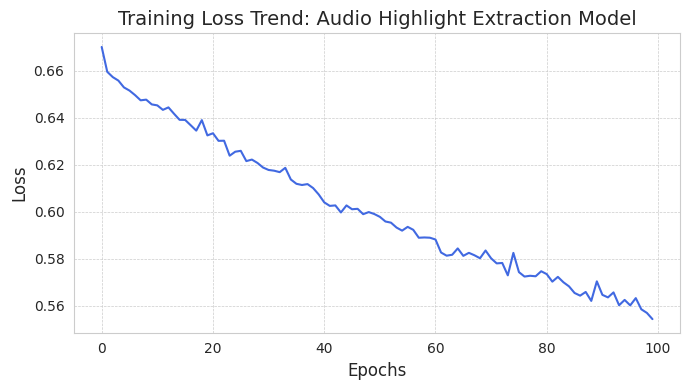

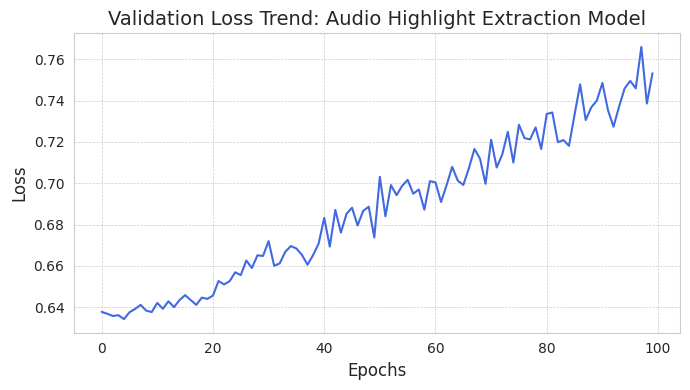

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))
plt.plot(train_loss, color='royalblue')
plt.title("Training Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))
plt.plot(val_loss, color='royalblue')
plt.title("Validation Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/1dcnn_audio_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Evaluate Audio Highlight Extraction Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/1dcnn_audio_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if len(inputs)!= len(labels) :
          continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])

y_true_pad = np.concatenate(y_true, axis=1).squeeze()
y_pred_pad = np.concatenate(y_pred, axis=0)

len(y_true_pad), len(y_pred_pad)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred_pad > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true_pad, y_pred_t, average='binary')
    acc = accuracy_score(y_true_pad, y_pred_t)
    prec = precision_score(y_true_pad, y_pred_t)
    rec = recall_score(y_true_pad, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-15-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])
<ipython-input-64-079b04a6304d>:18: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-64-079b04a6304d>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with d

Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.565278  0.420932   0.404249  0.939535
2        0.10  0.556908  0.436272   0.406481  0.884079
3        0.15  0.545585  0.453333   0.409042  0.818962
4        0.20  0.534808  0.469247   0.412163  0.761360
5        0.25  0.515352  0.474982   0.408948  0.696601
6        0.30  0.494128  0.487455   0.408708  0.624687
7        0.35  0.465578  0.498065   0.406017  0.545617
8        0.40  0.422066  0.517849   0.406085  0.439356
9        0.45  0.364211  0.538495   0.406526  0.329875
10       0.50  0.293151  0.556129   0.405047  0.229696
11       0.55  0.232716  0.578351   0.429672  0.159571
12       0.60  0.181245  0.590681   0.456647  0.113059
13       0.65  0.147236  0.593118   0.459662  0.087657
14       0.70  0.112296  0.594265   0.455471  0.064043
15       0.75  0.092199  0.596272   0.465798  0.051163
16       0.80  0.068077  0.595699   0.445887  0.036852
17       0.85  0.049983  0.596703   0.445783  0.026476
18       0.90  0.031713  0.597276   0.433962  0.016458
19       0.95  0.016140  0.597993   0.418182  0.008229
20       1.00  0.000000  0.599283   0.000000  0.000000

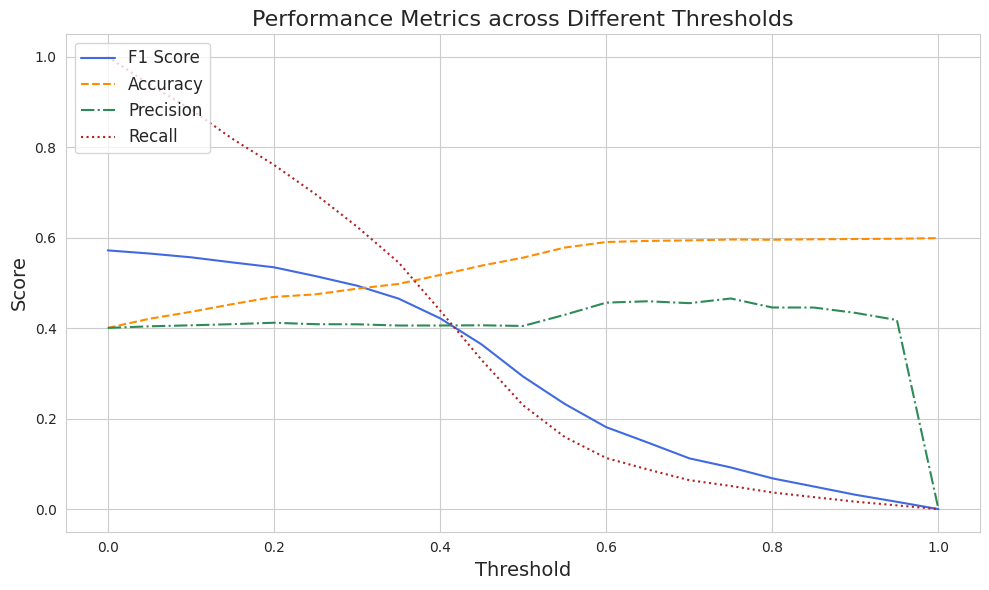

In [ ]:
# plot results

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()




### Extract Audio Highlight Feature



In [ ]:
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load("model/highlight/1dcnn_audio_highlight_detection_model.pt"))
md = MyDataset(emotion_features,labels)
dataloader = DataLoader(md)

In [ ]:
from tqdm.notebook import tqdm_notebook

concatenate_features = []

count = 1
for inputs, labels in tqdm_notebook(dataloader,total=len(dataloader)):
    with torch.no_grad():
        model.eval()
#         if inputs.shape[1] != labels.shape[1] : continue

        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)

        # Forward pass
        outputs,out = model(inputs)
        count += 1
        concatenate_features.append(out.cpu())

  0%|          | 0/151 [00:00<?, ?it/s]

<ipython-input-76-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
len(concatenate_features), concatenate_features[0].shape

(151, torch.Size([250, 128]))

In [ ]:
data_array = np.array(concatenate_features)

np.save('1dcnn_concatenate_audio_features_array.npy',data_array)

<ipython-input-99-d3b43f9aacb1>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(concatenate_features)
<ipython-input-99-d3b43f9aacb1>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(concatenate_features)


## 3) **LSTM with Attention** Audio Emotion Feature

In [ ]:
emotion_lstm_labels= np.load('labels.npy',allow_pickle=True)
lstm_attention_audio_emotion_features = np.load('lstm_attention_audio_emotion_features.npy',allow_pickle=True)

In [ ]:
emotion_features = lstm_attention_audio_emotion_features
labels = emotion_lstm_labels

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
md = MyDataset(emotion_lstm_features,emotion_lstm_labels)

# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Train Audio Highlight Extration Model

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.squeeze(0).float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.squeeze(0).float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   1%|          | 1/100 [00:03<05:56,  3.60s/it]

epoch [1/100], train_loss: 0.6713475700881746, val_loss: 0.6372759342193604, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:06<04:57,  3.04s/it]

epoch [2/100], train_loss: 0.6578413347403208, val_loss: 0.6346142888069153, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:08<04:19,  2.67s/it]

epoch [3/100], train_loss: 0.6567377938164605, val_loss: 0.6346105337142944, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:10<03:59,  2.50s/it]

epoch [4/100], train_loss: 0.6561754067738851, val_loss: 0.6346558928489685, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:12<03:47,  2.40s/it]

epoch [5/100], train_loss: 0.6558331665065553, val_loss: 0.6346972584724426, p: 0, r: 0, f: 0


Epochs:   6%|▌         | 6/100 [00:15<03:49,  2.44s/it]

epoch [6/100], train_loss: 0.6555837071604199, val_loss: 0.6347239017486572, p: 0, r: 0, f: 0


Epochs:   7%|▋         | 7/100 [00:18<04:13,  2.72s/it]

epoch [7/100], train_loss: 0.6553880578941769, val_loss: 0.6347411870956421, p: 0, r: 0, f: 0


Epochs:   8%|▊         | 8/100 [00:21<04:19,  2.82s/it]

epoch [8/100], train_loss: 0.655227741267946, val_loss: 0.6347520351409912, p: 0, r: 0, f: 0


Epochs:   9%|▉         | 9/100 [00:24<04:00,  2.64s/it]

epoch [9/100], train_loss: 0.6550925427012974, val_loss: 0.6347598433494568, p: 0, r: 0, f: 0


Epochs:  10%|█         | 10/100 [00:26<03:47,  2.53s/it]

epoch [10/100], train_loss: 0.6549746755096647, val_loss: 0.6347652077674866, p: 0, r: 0, f: 0


Epochs:  11%|█         | 11/100 [00:28<03:36,  2.43s/it]

epoch [11/100], train_loss: 0.6548710740274853, val_loss: 0.6347675919532776, p: 0, r: 0, f: 0


Epochs:  12%|█▏        | 12/100 [00:30<03:28,  2.37s/it]

epoch [12/100], train_loss: 0.6547758890522851, val_loss: 0.6347708106040955, p: 0, r: 0, f: 0


Epochs:  13%|█▎        | 13/100 [00:33<03:45,  2.59s/it]

epoch [13/100], train_loss: 0.6546884073151482, val_loss: 0.6347733736038208, p: 0, r: 0, f: 0


Epochs:  14%|█▍        | 14/100 [00:38<04:37,  3.23s/it]

epoch [14/100], train_loss: 0.6546069598860211, val_loss: 0.6347779035568237, p: 0, r: 0, f: 0


Epochs:  15%|█▌        | 15/100 [00:42<04:45,  3.36s/it]

epoch [15/100], train_loss: 0.6545325415001975, val_loss: 0.634780764579773, p: 0, r: 0, f: 0


Epochs:  16%|█▌        | 16/100 [00:44<04:22,  3.13s/it]

epoch [16/100], train_loss: 0.654461023873753, val_loss: 0.6347856521606445, p: 0, r: 0, f: 0


Epochs:  17%|█▋        | 17/100 [00:47<03:57,  2.86s/it]

epoch [17/100], train_loss: 0.6543919295072556, val_loss: 0.6347931027412415, p: 0, r: 0, f: 0


Epochs:  18%|█▊        | 18/100 [00:50<03:57,  2.89s/it]

epoch [18/100], train_loss: 0.6543287307024002, val_loss: 0.6347944140434265, p: 0, r: 0, f: 0


Epochs:  19%|█▉        | 19/100 [00:53<04:03,  3.01s/it]

epoch [19/100], train_loss: 0.6542597856786516, val_loss: 0.634799063205719, p: 0, r: 0, f: 0


Epochs:  20%|██        | 20/100 [00:55<03:52,  2.91s/it]

epoch [20/100], train_loss: 0.6541975378990174, val_loss: 0.6348116397857666, p: 0, r: 0, f: 0


Epochs:  21%|██        | 21/100 [00:59<04:01,  3.06s/it]

epoch [21/100], train_loss: 0.6541355742348565, val_loss: 0.6348240971565247, p: 0, r: 0, f: 0


Epochs:  22%|██▏       | 22/100 [01:03<04:33,  3.50s/it]

epoch [22/100], train_loss: 0.6540812740723292, val_loss: 0.6348437070846558, p: 0, r: 0, f: 0


Epochs:  23%|██▎       | 23/100 [01:09<05:15,  4.09s/it]

epoch [23/100], train_loss: 0.6540224336915545, val_loss: 0.6348540186882019, p: 0, r: 0, f: 0


Epochs:  24%|██▍       | 24/100 [01:14<05:25,  4.29s/it]

epoch [24/100], train_loss: 0.6539725903007719, val_loss: 0.6348599195480347, p: 0, r: 0, f: 0


Epochs:  25%|██▌       | 25/100 [01:18<05:29,  4.39s/it]

epoch [25/100], train_loss: 0.6539005163643096, val_loss: 0.6348726153373718, p: 0, r: 0, f: 0


Epochs:  26%|██▌       | 26/100 [01:23<05:32,  4.50s/it]

epoch [26/100], train_loss: 0.6538440532154507, val_loss: 0.6348965764045715, p: 0, r: 0, f: 0


Epochs:  27%|██▋       | 27/100 [01:31<06:39,  5.47s/it]

epoch [27/100], train_loss: 0.6537939581606124, val_loss: 0.6349083185195923, p: 0, r: 0, f: 0


Epochs:  28%|██▊       | 28/100 [01:36<06:22,  5.32s/it]

epoch [28/100], train_loss: 0.6537335713704427, val_loss: 0.6349151730537415, p: 0, r: 0, f: 0


Epochs:  29%|██▉       | 29/100 [01:41<06:19,  5.35s/it]

epoch [29/100], train_loss: 0.65366879635387, val_loss: 0.6349325180053711, p: 0, r: 0, f: 0


Epochs:  30%|███       | 30/100 [01:50<07:31,  6.45s/it]

epoch [30/100], train_loss: 0.6536142173740599, val_loss: 0.6349489092826843, p: 0, r: 0, f: 0


Epochs:  31%|███       | 31/100 [01:56<07:02,  6.13s/it]

epoch [31/100], train_loss: 0.6535583628548516, val_loss: 0.6349672079086304, p: 0, r: 0, f: 0


Epochs:  32%|███▏      | 32/100 [02:02<06:56,  6.13s/it]

epoch [32/100], train_loss: 0.6535053743256463, val_loss: 0.6349855065345764, p: 0, r: 0, f: 0


Epochs:  33%|███▎      | 33/100 [02:06<06:24,  5.73s/it]

epoch [33/100], train_loss: 0.6534519675705168, val_loss: 0.6350056529045105, p: 0, r: 0, f: 0


Epochs:  34%|███▍      | 34/100 [02:10<05:33,  5.05s/it]

epoch [34/100], train_loss: 0.6534006026056077, val_loss: 0.6350242495536804, p: 0, r: 0, f: 0


Epochs:  35%|███▌      | 35/100 [02:13<04:57,  4.57s/it]

epoch [35/100], train_loss: 0.6533491720755895, val_loss: 0.6350463628768921, p: 0, r: 0, f: 0


Epochs:  36%|███▌      | 36/100 [02:18<04:54,  4.61s/it]

epoch [36/100], train_loss: 0.6533018552594715, val_loss: 0.6350653171539307, p: 0, r: 0, f: 0


Epochs:  37%|███▋      | 37/100 [02:23<05:03,  4.81s/it]

epoch [37/100], train_loss: 0.6532495492034488, val_loss: 0.6350839734077454, p: 0, r: 0, f: 0


Epochs:  38%|███▊      | 38/100 [02:26<04:19,  4.19s/it]

epoch [38/100], train_loss: 0.6531961603297127, val_loss: 0.6351045370101929, p: 0, r: 0, f: 0


Epochs:  39%|███▉      | 39/100 [02:28<03:39,  3.60s/it]

epoch [39/100], train_loss: 0.6531500260035197, val_loss: 0.635131299495697, p: 0, r: 0, f: 0


Epochs:  40%|████      | 40/100 [02:31<03:11,  3.20s/it]

epoch [40/100], train_loss: 0.6530989401870304, val_loss: 0.6351516246795654, p: 0, r: 0, f: 0


Epochs:  41%|████      | 41/100 [02:33<02:51,  2.90s/it]

epoch [41/100], train_loss: 0.6530534472730425, val_loss: 0.6351689696311951, p: 0, r: 0, f: 0


Epochs:  42%|████▏     | 42/100 [02:36<02:53,  2.99s/it]

epoch [42/100], train_loss: 0.6529963543017705, val_loss: 0.6351940631866455, p: 0, r: 0, f: 0


Epochs:  43%|████▎     | 43/100 [02:39<02:55,  3.08s/it]

epoch [43/100], train_loss: 0.6529443307055367, val_loss: 0.6352179050445557, p: 0, r: 0, f: 0


Epochs:  44%|████▍     | 44/100 [02:42<02:40,  2.86s/it]

epoch [44/100], train_loss: 0.6528921087582906, val_loss: 0.6352414488792419, p: 0, r: 0, f: 0


Epochs:  45%|████▌     | 45/100 [02:44<02:27,  2.67s/it]

epoch [45/100], train_loss: 0.6528363515933354, val_loss: 0.6352661848068237, p: 0, r: 0, f: 0


Epochs:  46%|████▌     | 46/100 [02:46<02:17,  2.55s/it]

epoch [46/100], train_loss: 0.6527869681517283, val_loss: 0.6352955102920532, p: 0, r: 0, f: 0


Epochs:  47%|████▋     | 47/100 [02:48<02:10,  2.46s/it]

epoch [47/100], train_loss: 0.6527365932861964, val_loss: 0.635323703289032, p: 0, r: 0, f: 0


Epochs:  48%|████▊     | 48/100 [02:51<02:13,  2.56s/it]

epoch [48/100], train_loss: 0.6526847187015745, val_loss: 0.635351300239563, p: 0, r: 0, f: 0


Epochs:  49%|████▉     | 49/100 [02:55<02:22,  2.80s/it]

epoch [49/100], train_loss: 0.6526276313596302, val_loss: 0.6353815793991089, p: 0, r: 0, f: 0


Epochs:  50%|█████     | 50/100 [02:57<02:17,  2.76s/it]

epoch [50/100], train_loss: 0.6525745322306951, val_loss: 0.6354154944419861, p: 0, r: 0, f: 0


Epochs:  51%|█████     | 51/100 [02:59<02:06,  2.59s/it]

epoch [51/100], train_loss: 0.6525211764706506, val_loss: 0.6354526877403259, p: 0, r: 0, f: 0


Epochs:  52%|█████▏    | 52/100 [03:02<01:58,  2.47s/it]

epoch [52/100], train_loss: 0.6524753977855047, val_loss: 0.6354886889457703, p: 0, r: 0, f: 0


Epochs:  53%|█████▎    | 53/100 [03:04<01:53,  2.41s/it]

epoch [53/100], train_loss: 0.6524238751994239, val_loss: 0.6355248093605042, p: 0, r: 0, f: 0


Epochs:  54%|█████▍    | 54/100 [03:06<01:51,  2.42s/it]

epoch [54/100], train_loss: 0.6523689442210727, val_loss: 0.6355611085891724, p: 0, r: 0, f: 0


Epochs:  55%|█████▌    | 55/100 [03:10<02:00,  2.69s/it]

epoch [55/100], train_loss: 0.6523183988200294, val_loss: 0.6356102824211121, p: 0, r: 0, f: 0


Epochs:  56%|█████▌    | 56/100 [03:13<02:03,  2.82s/it]

epoch [56/100], train_loss: 0.6522750344541338, val_loss: 0.6356431841850281, p: 0, r: 0, f: 0


Epochs:  57%|█████▋    | 57/100 [03:15<01:53,  2.65s/it]

epoch [57/100], train_loss: 0.6522120475769043, val_loss: 0.635689914226532, p: 0, r: 0, f: 0


Epochs:  58%|█████▊    | 58/100 [03:17<01:46,  2.53s/it]

epoch [58/100], train_loss: 0.6521559788121117, val_loss: 0.6357467174530029, p: 0, r: 0, f: 0


Epochs:  59%|█████▉    | 59/100 [03:19<01:40,  2.45s/it]

epoch [59/100], train_loss: 0.6521112322807312, val_loss: 0.635795533657074, p: 0, r: 0, f: 0


Epochs:  60%|██████    | 60/100 [03:22<01:35,  2.38s/it]

epoch [60/100], train_loss: 0.6520496368408203, val_loss: 0.6358386278152466, p: 0, r: 0, f: 0


Epochs:  61%|██████    | 61/100 [03:25<01:40,  2.57s/it]

epoch [61/100], train_loss: 0.651994040608406, val_loss: 0.6358944773674011, p: 0, r: 0, f: 0


Epochs:  62%|██████▏   | 62/100 [03:28<01:45,  2.77s/it]

epoch [62/100], train_loss: 0.65194401078754, val_loss: 0.6359491944313049, p: 0, r: 0, f: 0


Epochs:  63%|██████▎   | 63/100 [03:30<01:39,  2.69s/it]

epoch [63/100], train_loss: 0.6518921640184191, val_loss: 0.636006236076355, p: 0, r: 0, f: 0


Epochs:  64%|██████▍   | 64/100 [03:33<01:32,  2.56s/it]

epoch [64/100], train_loss: 0.651839350329505, val_loss: 0.6360694766044617, p: 0, r: 0, f: 0


Epochs:  65%|██████▌   | 65/100 [03:35<01:26,  2.47s/it]

epoch [65/100], train_loss: 0.6517855849530961, val_loss: 0.6361348628997803, p: 0, r: 0, f: 0


Epochs:  66%|██████▌   | 66/100 [03:37<01:21,  2.40s/it]

epoch [66/100], train_loss: 0.651731954018275, val_loss: 0.6361958384513855, p: 0, r: 0, f: 0


Epochs:  67%|██████▋   | 67/100 [03:40<01:21,  2.46s/it]

epoch [67/100], train_loss: 0.6516785783900155, val_loss: 0.6362699270248413, p: 0, r: 0, f: 0


Epochs:  68%|██████▊   | 68/100 [03:43<01:27,  2.72s/it]

epoch [68/100], train_loss: 0.651625872651736, val_loss: 0.6363396048545837, p: 0, r: 0, f: 0


Epochs:  69%|██████▉   | 69/100 [03:46<01:26,  2.80s/it]

epoch [69/100], train_loss: 0.6515682674116559, val_loss: 0.6364160776138306, p: 0, r: 0, f: 0


Epochs:  70%|███████   | 70/100 [03:48<01:18,  2.63s/it]

epoch [70/100], train_loss: 0.6515142977237701, val_loss: 0.636488676071167, p: 0, r: 0, f: 0


Epochs:  71%|███████   | 71/100 [03:51<01:12,  2.50s/it]

epoch [71/100], train_loss: 0.6514608187807931, val_loss: 0.6365646123886108, p: 0, r: 0, f: 0


Epochs:  72%|███████▏  | 72/100 [03:53<01:08,  2.44s/it]

epoch [72/100], train_loss: 0.6514082378811307, val_loss: 0.6366416811943054, p: 0, r: 0, f: 0


Epochs:  73%|███████▎  | 73/100 [03:55<01:04,  2.40s/it]

epoch [73/100], train_loss: 0.6513566023773617, val_loss: 0.6367208361625671, p: 0, r: 0, f: 0


Epochs:  74%|███████▍  | 74/100 [03:58<01:08,  2.65s/it]

epoch [74/100], train_loss: 0.6513011687331729, val_loss: 0.63680499792099, p: 0, r: 0, f: 0


Epochs:  75%|███████▌  | 75/100 [04:02<01:10,  2.84s/it]

epoch [75/100], train_loss: 0.6512452774577671, val_loss: 0.6368869543075562, p: 0, r: 0, f: 0


Epochs:  76%|███████▌  | 76/100 [04:04<01:04,  2.70s/it]

epoch [76/100], train_loss: 0.6511894255876541, val_loss: 0.6369735598564148, p: 0, r: 0, f: 0


Epochs:  77%|███████▋  | 77/100 [04:06<00:59,  2.57s/it]

epoch [77/100], train_loss: 0.6511301640007231, val_loss: 0.6370570659637451, p: 0, r: 0, f: 0


Epochs:  78%|███████▊  | 78/100 [04:09<00:54,  2.48s/it]

epoch [78/100], train_loss: 0.6510732432206472, val_loss: 0.6371484398841858, p: 0, r: 0, f: 0


Epochs:  79%|███████▉  | 79/100 [04:11<00:51,  2.43s/it]

epoch [79/100], train_loss: 0.6510165502627691, val_loss: 0.6372337937355042, p: 0, r: 0, f: 0


Epochs:  80%|████████  | 80/100 [04:14<00:50,  2.54s/it]

epoch [80/100], train_loss: 0.6509580049249861, val_loss: 0.6373258233070374, p: 0, r: 0, f: 0


Epochs:  81%|████████  | 81/100 [04:17<00:52,  2.75s/it]

epoch [81/100], train_loss: 0.6508997768163681, val_loss: 0.6374164819717407, p: 0, r: 0, f: 0


Epochs:  82%|████████▏ | 82/100 [04:20<00:49,  2.75s/it]

epoch [82/100], train_loss: 0.6508402890629239, val_loss: 0.6375102400779724, p: 0, r: 0, f: 0


Epochs:  83%|████████▎ | 83/100 [04:22<00:44,  2.61s/it]

epoch [83/100], train_loss: 0.6507769707176421, val_loss: 0.637607216835022, p: 0, r: 0, f: 0


Epochs:  84%|████████▍ | 84/100 [04:24<00:39,  2.50s/it]

epoch [84/100], train_loss: 0.6507135381301244, val_loss: 0.6377100348472595, p: 0, r: 0, f: 0


Epochs:  85%|████████▌ | 85/100 [04:26<00:36,  2.42s/it]

epoch [85/100], train_loss: 0.650648702846633, val_loss: 0.6378220319747925, p: 0, r: 0, f: 0


Epochs:  86%|████████▌ | 86/100 [04:29<00:33,  2.37s/it]

epoch [86/100], train_loss: 0.6505808005730311, val_loss: 0.6379379630088806, p: 0, r: 0, f: 0


Epochs:  87%|████████▋ | 87/100 [04:32<00:34,  2.66s/it]

epoch [87/100], train_loss: 0.6505013306935629, val_loss: 0.638073742389679, p: 0, r: 0, f: 0


Epochs:  88%|████████▊ | 88/100 [04:35<00:33,  2.81s/it]

epoch [88/100], train_loss: 0.6504194491439396, val_loss: 0.638228178024292, p: 0.3651985318651985, r: 0.9995433789954338, f: 0.5349462365591399


Epochs:  89%|████████▉ | 89/100 [04:37<00:29,  2.64s/it]

epoch [89/100], train_loss: 0.650331602162785, val_loss: 0.6383911967277527, p: 0.3654424040066778, r: 0.9995433789954338, f: 0.5352078239608803


Epochs:  90%|█████████ | 90/100 [04:40<00:25,  2.51s/it]

epoch [90/100], train_loss: 0.6502385374572542, val_loss: 0.6385738253593445, p: 0.36538461538461536, r: 0.997716894977169, f: 0.5348837209302326


Epochs:  91%|█████████ | 91/100 [04:42<00:21,  2.43s/it]

epoch [91/100], train_loss: 0.6501368800799052, val_loss: 0.6387560963630676, p: 0.3654168061600268, r: 0.9968036529680365, f: 0.5347868691817736


Epochs:  92%|█████████▏| 92/100 [04:44<00:19,  2.38s/it]

epoch [92/100], train_loss: 0.6500319351752599, val_loss: 0.6389467120170593, p: 0.36537173476222373, r: 0.9963470319634703, f: 0.5346728742955158


Epochs:  93%|█████████▎| 93/100 [04:47<00:17,  2.55s/it]

epoch [93/100], train_loss: 0.649923982222875, val_loss: 0.639123797416687, p: 0.36555536940861116, r: 0.9963470319634703, f: 0.534869469297708


Epochs:  94%|█████████▍| 94/100 [04:50<00:16,  2.78s/it]

epoch [94/100], train_loss: 0.6498168230056762, val_loss: 0.6392999291419983, p: 0.3655715722427087, r: 0.9958904109589041, f: 0.5348209906817067


Epochs:  95%|█████████▌| 95/100 [04:53<00:13,  2.73s/it]

epoch [95/100], train_loss: 0.6497076561053594, val_loss: 0.6394592523574829, p: 0.3652845391975827, r: 0.993607305936073, f: 0.5341843623419663


Epochs:  96%|█████████▌| 96/100 [04:55<00:10,  2.59s/it]

epoch [96/100], train_loss: 0.6496016651391983, val_loss: 0.6396118998527527, p: 0.3651326839099765, r: 0.9926940639269406, f: 0.5338899803536346


Epochs:  97%|█████████▋| 97/100 [04:58<00:07,  2.49s/it]

epoch [97/100], train_loss: 0.6494979414674971, val_loss: 0.6397498846054077, p: 0.36508736559139787, r: 0.9922374429223745, f: 0.5337754851387866


Epochs:  98%|█████████▊| 98/100 [05:00<00:04,  2.46s/it]

epoch [98/100], train_loss: 0.6493932962417602, val_loss: 0.6398822665214539, p: 0.3651487145017644, r: 0.9922374429223745, f: 0.5338410514678786


Epochs:  99%|█████████▉| 99/100 [05:02<00:02,  2.48s/it]

epoch [99/100], train_loss: 0.6492905643251207, val_loss: 0.6400099992752075, p: 0.36527147419734407, r: 0.9922374429223745, f: 0.5339722324609902


Epochs: 100%|██████████| 100/100 [05:06<00:00,  3.06s/it]

epoch [100/100], train_loss: 0.6491914100117153, val_loss: 0.6401349902153015, p: 0.36527147419734407, r: 0.9922374429223745, f: 0.5339722324609902


In [ ]:
outputs[:5]

tensor([[0.4273],
        [0.4169],
        [0.2849],
        [0.2783],
        [0.2904]])

### Plot Training Loss Curve & Validation Loss Curve

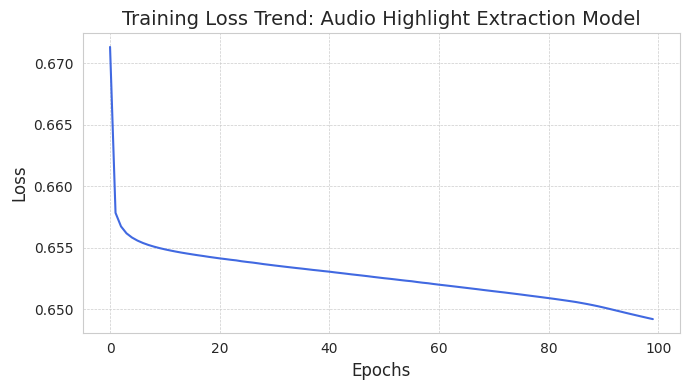

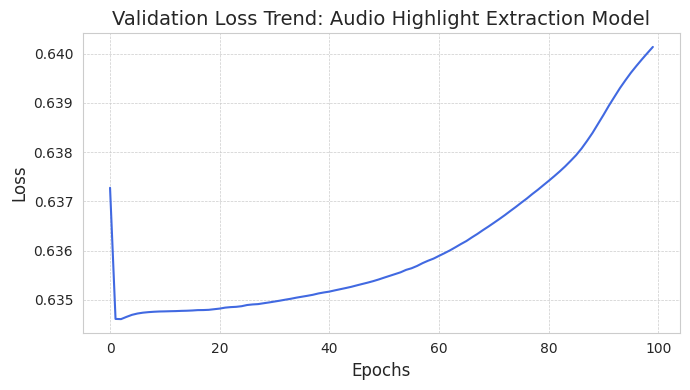

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))
plt.plot(train_loss, color='royalblue')
plt.title("Training Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))
plt.plot(val_loss, color='royalblue')
plt.title("Validation Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/lstm_attention_audio_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Evaluate Audio Highlight Extraction Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/lstm_attention_audio_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if len(inputs)!= len(labels) :
          continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])

y_true_pad = np.concatenate(y_true, axis=1).squeeze()
y_pred_pad = np.concatenate(y_pred, axis=0)

len(y_true_pad), len(y_pred_pad)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred_pad > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true_pad, y_pred_t, average='binary')
    acc = accuracy_score(y_true_pad, y_pred_t)
    prec = precision_score(y_true_pad, y_pred_t)
    rec = recall_score(y_true_pad, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-60-079b04a6304d>:18: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-60-079b04a6304d>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-60-079b04a6304d>:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing

Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.572160  0.400717   0.400717  1.000000
2        0.10  0.572424  0.402007   0.401149  0.998927
3        0.15  0.572398  0.403871   0.401645  0.995707
4        0.20  0.572731  0.408746   0.403092  0.988909
5        0.25  0.571189  0.413620   0.403974  0.974597
6        0.30  0.550018  0.473118   0.418094  0.803578
7        0.35  0.509167  0.527885   0.436382  0.611091
8        0.40  0.306381  0.568315   0.430142  0.237925
9        0.45  0.004988  0.599570   0.583333  0.002504
10       0.50  0.000000  0.599283   0.000000  0.000000
11       0.55  0.000000  0.599283   0.000000  0.000000
12       0.60  0.000000  0.599283   0.000000  0.000000
13       0.65  0.000000  0.599283   0.000000  0.000000
14       0.70  0.000000  0.599283   0.000000  0.000000
15       0.75  0.000000  0.599283   0.000000  0.000000
16       0.80  0.000000  0.599283   0.000000  0.000000
17       0.85  0.000000  0.599283   0.000000  0.000000
18       0.90  0.000000  0.599283   0.000000  0.000000
19       0.95  0.000000  0.599283   0.000000  0.000000
20       1.00  0.000000  0.599283   0.000000  0.000000

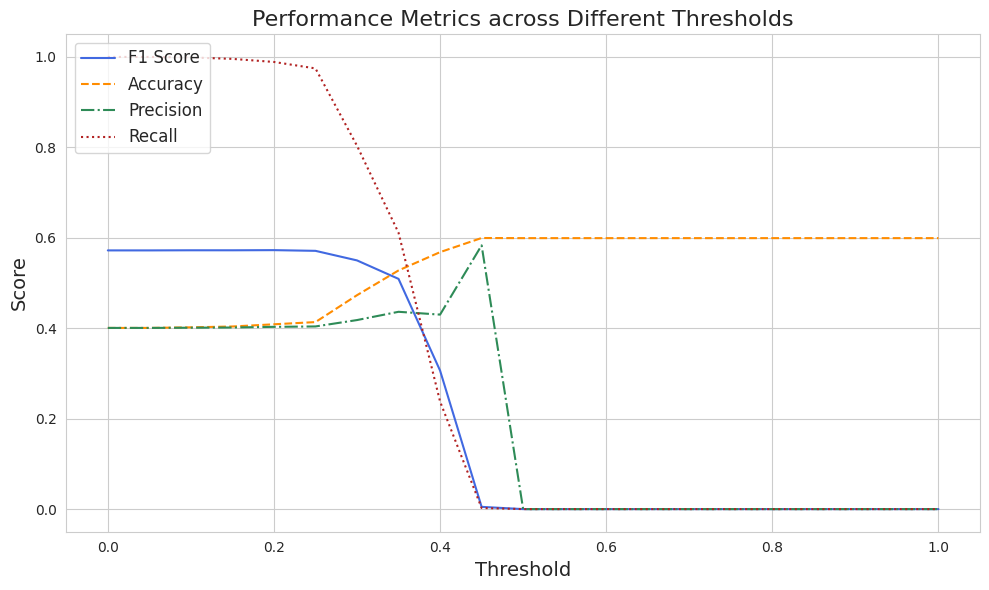

In [ ]:
# plot results

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()




### Extract Audio Highlight Feature



In [ ]:
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load("model/highlight/lstm_attention_audio_highlight_detection_model.pt"))
md = MyDataset(emotion_features,labels)
dataloader = DataLoader(md)

In [ ]:
from tqdm.notebook import tqdm_notebook

concatenate_features = []

count = 0
for inputs, labels in tqdm_notebook(dataloader,total=len(dataloader)):
    with torch.no_grad():
        model.eval()
#         if inputs.shape[1] != labels.shape[1] : continue

        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)

        # Forward pass
        outputs,out = model(inputs)

        concatenate_features.append(out.cpu())
        count += 1
        if count >= 151:
          break

  0%|          | 0/155 [00:00<?, ?it/s]

<ipython-input-76-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
len(concatenate_features), concatenate_features[0].shape

(151, torch.Size([250, 128]))

In [ ]:
data_array = np.array(concatenate_features)

np.save('lstm_attention_concatenate_audio_features_array.npy',data_array)

<ipython-input-114-487d88766190>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(concatenate_features)
<ipython-input-114-487d88766190>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(concatenate_features)


## 4) **GRU** Audio Emotion Feature

In [ ]:
emotion_lstm_labels= np.load('labels.npy',allow_pickle=True)
gru_audio_emotion_features = np.load('gru_audio_emotion_features.npy',allow_pickle=True)

In [ ]:
emotion_features = gru_audio_emotion_features
labels = emotion_lstm_labels

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
md = MyDataset(emotion_lstm_features,emotion_lstm_labels)

# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Train Audio Highlight Extration Model

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.squeeze(0).float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.squeeze(0).float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   1%|          | 1/100 [00:02<03:52,  2.35s/it]

epoch [1/100], train_loss: 0.6738578594393201, val_loss: 0.6364553570747375, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:04<03:51,  2.36s/it]

epoch [2/100], train_loss: 0.6587952034340965, val_loss: 0.6345471143722534, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:08<04:30,  2.79s/it]

epoch [3/100], train_loss: 0.657421737909317, val_loss: 0.6345531940460205, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:11<04:39,  2.91s/it]

epoch [4/100], train_loss: 0.6567634907033708, val_loss: 0.6345891952514648, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:13<04:14,  2.68s/it]

epoch [5/100], train_loss: 0.6563460201025009, val_loss: 0.634621262550354, p: 0, r: 0, f: 0


Epochs:   6%|▌         | 6/100 [00:15<03:57,  2.53s/it]

epoch [6/100], train_loss: 0.6560440076722039, val_loss: 0.6346453428268433, p: 0, r: 0, f: 0


Epochs:   7%|▋         | 7/100 [00:17<03:46,  2.44s/it]

epoch [7/100], train_loss: 0.6558107657565011, val_loss: 0.6346632838249207, p: 0, r: 0, f: 0


Epochs:   8%|▊         | 8/100 [00:20<03:38,  2.38s/it]

epoch [8/100], train_loss: 0.6556227657530043, val_loss: 0.6346762180328369, p: 0, r: 0, f: 0


Epochs:   9%|▉         | 9/100 [00:23<03:54,  2.58s/it]

epoch [9/100], train_loss: 0.6554665214485592, val_loss: 0.6346852779388428, p: 0, r: 0, f: 0


Epochs:  10%|█         | 10/100 [00:26<04:10,  2.78s/it]

epoch [10/100], train_loss: 0.6553330116801792, val_loss: 0.6346914768218994, p: 0, r: 0, f: 0


Epochs:  11%|█         | 11/100 [00:28<04:01,  2.71s/it]

epoch [11/100], train_loss: 0.6552168478568395, val_loss: 0.634695291519165, p: 0, r: 0, f: 0


Epochs:  12%|█▏        | 12/100 [00:31<03:48,  2.60s/it]

epoch [12/100], train_loss: 0.6551131072971556, val_loss: 0.6346971392631531, p: 0, r: 0, f: 0


Epochs:  13%|█▎        | 13/100 [00:33<03:36,  2.49s/it]

epoch [13/100], train_loss: 0.6550198280149035, val_loss: 0.6346991062164307, p: 0, r: 0, f: 0


Epochs:  14%|█▍        | 14/100 [00:35<03:26,  2.40s/it]

epoch [14/100], train_loss: 0.6549343963464102, val_loss: 0.6347004175186157, p: 0, r: 0, f: 0


Epochs:  15%|█▌        | 15/100 [00:38<03:26,  2.43s/it]

epoch [15/100], train_loss: 0.6548554665512509, val_loss: 0.6347024440765381, p: 0, r: 0, f: 0


Epochs:  16%|█▌        | 16/100 [00:41<03:44,  2.68s/it]

epoch [16/100], train_loss: 0.6547798626952701, val_loss: 0.6347057223320007, p: 0, r: 0, f: 0


Epochs:  17%|█▋        | 17/100 [00:44<03:48,  2.76s/it]

epoch [17/100], train_loss: 0.654708605673578, val_loss: 0.6347166299819946, p: 0, r: 0, f: 0


Epochs:  18%|█▊        | 18/100 [00:46<03:32,  2.59s/it]

epoch [18/100], train_loss: 0.6546458138359917, val_loss: 0.6347188949584961, p: 0, r: 0, f: 0


Epochs:  19%|█▉        | 19/100 [00:48<03:21,  2.48s/it]

epoch [19/100], train_loss: 0.6545797242058649, val_loss: 0.6347242593765259, p: 0, r: 0, f: 0


Epochs:  20%|██        | 20/100 [00:51<03:11,  2.39s/it]

epoch [20/100], train_loss: 0.6545152617825403, val_loss: 0.6347315907478333, p: 0, r: 0, f: 0


Epochs:  21%|██        | 21/100 [00:53<03:05,  2.35s/it]

epoch [21/100], train_loss: 0.6544521931144927, val_loss: 0.6347448229789734, p: 0, r: 0, f: 0


Epochs:  22%|██▏       | 22/100 [00:56<03:21,  2.58s/it]

epoch [22/100], train_loss: 0.6543960915671454, val_loss: 0.6347524523735046, p: 0, r: 0, f: 0


Epochs:  23%|██▎       | 23/100 [00:59<03:35,  2.79s/it]

epoch [23/100], train_loss: 0.6543348607089784, val_loss: 0.6347524523735046, p: 0, r: 0, f: 0


Epochs:  24%|██▍       | 24/100 [01:02<03:22,  2.67s/it]

epoch [24/100], train_loss: 0.6542655206388898, val_loss: 0.6347664594650269, p: 0, r: 0, f: 0


Epochs:  25%|██▌       | 25/100 [01:04<03:09,  2.53s/it]

epoch [25/100], train_loss: 0.6542058802313275, val_loss: 0.6347842812538147, p: 0, r: 0, f: 0


Epochs:  26%|██▌       | 26/100 [01:06<02:59,  2.43s/it]

epoch [26/100], train_loss: 0.6541519204775492, val_loss: 0.6347982883453369, p: 0, r: 0, f: 0


Epochs:  27%|██▋       | 27/100 [01:08<02:53,  2.38s/it]

epoch [27/100], train_loss: 0.6540943943791919, val_loss: 0.634822428226471, p: 0, r: 0, f: 0


Epochs:  28%|██▊       | 28/100 [01:11<02:56,  2.45s/it]

epoch [28/100], train_loss: 0.6540419754054811, val_loss: 0.6348399519920349, p: 0, r: 0, f: 0


Epochs:  29%|██▉       | 29/100 [01:14<03:10,  2.69s/it]

epoch [29/100], train_loss: 0.6539891951613956, val_loss: 0.6348440647125244, p: 0, r: 0, f: 0


Epochs:  30%|███       | 30/100 [01:18<03:31,  3.02s/it]

epoch [30/100], train_loss: 0.6539230551984575, val_loss: 0.6348612308502197, p: 0, r: 0, f: 0


Epochs:  31%|███       | 31/100 [01:21<03:39,  3.18s/it]

epoch [31/100], train_loss: 0.6538677304983139, val_loss: 0.6348769068717957, p: 0, r: 0, f: 0


Epochs:  32%|███▏      | 32/100 [01:24<03:23,  3.00s/it]

epoch [32/100], train_loss: 0.653814791308509, val_loss: 0.6348944306373596, p: 0, r: 0, f: 0


Epochs:  33%|███▎      | 33/100 [01:26<03:04,  2.76s/it]

epoch [33/100], train_loss: 0.6537593629625108, val_loss: 0.6349080801010132, p: 0, r: 0, f: 0


Epochs:  34%|███▍      | 34/100 [01:34<04:33,  4.15s/it]

epoch [34/100], train_loss: 0.6537061538961199, val_loss: 0.6349295377731323, p: 0, r: 0, f: 0


Epochs:  35%|███▌      | 35/100 [01:37<04:15,  3.93s/it]

epoch [35/100], train_loss: 0.6536569697989358, val_loss: 0.6349475979804993, p: 0, r: 0, f: 0


Epochs:  36%|███▌      | 36/100 [01:41<04:09,  3.90s/it]

epoch [36/100], train_loss: 0.6536050872670279, val_loss: 0.6349674463272095, p: 0, r: 0, f: 0


Epochs:  37%|███▋      | 37/100 [01:44<03:57,  3.77s/it]

epoch [37/100], train_loss: 0.6535558859507243, val_loss: 0.6349775195121765, p: 0, r: 0, f: 0


Epochs:  38%|███▊      | 38/100 [01:52<05:12,  5.04s/it]

epoch [38/100], train_loss: 0.6534953422016567, val_loss: 0.6349937319755554, p: 0, r: 0, f: 0


Epochs:  39%|███▉      | 39/100 [01:56<04:38,  4.56s/it]

epoch [39/100], train_loss: 0.6534459802839491, val_loss: 0.6350138783454895, p: 0, r: 0, f: 0


Epochs:  40%|████      | 40/100 [01:59<04:12,  4.21s/it]

epoch [40/100], train_loss: 0.6533937209182316, val_loss: 0.6350306272506714, p: 0, r: 0, f: 0


Epochs:  41%|████      | 41/100 [02:06<05:01,  5.12s/it]

epoch [41/100], train_loss: 0.6533440917730331, val_loss: 0.6350511312484741, p: 0, r: 0, f: 0


Epochs:  42%|████▏     | 42/100 [02:13<05:18,  5.49s/it]

epoch [42/100], train_loss: 0.6532947325044208, val_loss: 0.6350729465484619, p: 0, r: 0, f: 0


Epochs:  43%|████▎     | 43/100 [02:19<05:33,  5.85s/it]

epoch [43/100], train_loss: 0.6532479378912184, val_loss: 0.6350969076156616, p: 0, r: 0, f: 0


Epochs:  44%|████▍     | 44/100 [02:28<06:15,  6.71s/it]

epoch [44/100], train_loss: 0.6532006230619218, val_loss: 0.6351274251937866, p: 0, r: 0, f: 0


Epochs:  45%|████▌     | 45/100 [02:31<05:11,  5.66s/it]

epoch [45/100], train_loss: 0.653158164024353, val_loss: 0.6351451873779297, p: 0, r: 0, f: 0


Epochs:  46%|████▌     | 46/100 [02:34<04:10,  4.64s/it]

epoch [46/100], train_loss: 0.6531004405683941, val_loss: 0.6351652145385742, p: 0, r: 0, f: 0


Epochs:  47%|████▋     | 47/100 [02:36<03:27,  3.92s/it]

epoch [47/100], train_loss: 0.6530536466174656, val_loss: 0.6351892352104187, p: 0, r: 0, f: 0


Epochs:  48%|████▊     | 48/100 [02:38<03:01,  3.49s/it]

epoch [48/100], train_loss: 0.65300232635604, val_loss: 0.635216474533081, p: 0, r: 0, f: 0


Epochs:  49%|████▉     | 49/100 [02:42<02:54,  3.42s/it]

epoch [49/100], train_loss: 0.6529559741417567, val_loss: 0.6352450251579285, p: 0, r: 0, f: 0


Epochs:  50%|█████     | 50/100 [02:45<02:44,  3.30s/it]

epoch [50/100], train_loss: 0.6529049548837874, val_loss: 0.6352741718292236, p: 0, r: 0, f: 0


Epochs:  51%|█████     | 51/100 [02:47<02:25,  2.96s/it]

epoch [51/100], train_loss: 0.6528584228621589, val_loss: 0.6353024840354919, p: 0, r: 0, f: 0


Epochs:  52%|█████▏    | 52/100 [02:49<02:12,  2.76s/it]

epoch [52/100], train_loss: 0.652807542681694, val_loss: 0.6353339552879333, p: 0, r: 0, f: 0


Epochs:  53%|█████▎    | 53/100 [02:51<02:02,  2.61s/it]

epoch [53/100], train_loss: 0.65276201930311, val_loss: 0.6353693008422852, p: 0, r: 0, f: 0


Epochs:  54%|█████▍    | 54/100 [02:53<01:53,  2.47s/it]

epoch [54/100], train_loss: 0.6527204040024016, val_loss: 0.6353988647460938, p: 0, r: 0, f: 0


Epochs:  55%|█████▌    | 55/100 [02:57<02:05,  2.79s/it]

epoch [55/100], train_loss: 0.6526690635416242, val_loss: 0.6354278922080994, p: 0, r: 0, f: 0


Epochs:  56%|█████▌    | 56/100 [03:02<02:38,  3.60s/it]

epoch [56/100], train_loss: 0.6526180975966983, val_loss: 0.635463297367096, p: 0, r: 0, f: 0


Epochs:  57%|█████▋    | 57/100 [03:06<02:33,  3.57s/it]

epoch [57/100], train_loss: 0.6525696221325132, val_loss: 0.6354971528053284, p: 0, r: 0, f: 0


Epochs:  58%|█████▊    | 58/100 [03:10<02:30,  3.58s/it]

epoch [58/100], train_loss: 0.6525213370720545, val_loss: 0.6355361342430115, p: 0, r: 0, f: 0


Epochs:  59%|█████▉    | 59/100 [03:14<02:42,  3.97s/it]

epoch [59/100], train_loss: 0.6524731046623654, val_loss: 0.635567843914032, p: 0, r: 0, f: 0


Epochs:  60%|██████    | 60/100 [03:22<03:18,  4.96s/it]

epoch [60/100], train_loss: 0.652416639857822, val_loss: 0.6356112957000732, p: 0, r: 0, f: 0


Epochs:  61%|██████    | 61/100 [03:26<03:08,  4.84s/it]

epoch [61/100], train_loss: 0.6523691862821579, val_loss: 0.6356574892997742, p: 0, r: 0, f: 0


Epochs:  62%|██████▏   | 62/100 [03:33<03:28,  5.49s/it]

epoch [62/100], train_loss: 0.6523220082124074, val_loss: 0.6356915831565857, p: 0, r: 0, f: 0


Epochs:  63%|██████▎   | 63/100 [03:39<03:30,  5.68s/it]

epoch [63/100], train_loss: 0.6522664037015703, val_loss: 0.6357346773147583, p: 0, r: 0, f: 0


Epochs:  64%|██████▍   | 64/100 [03:43<03:02,  5.07s/it]

epoch [64/100], train_loss: 0.6522150526444117, val_loss: 0.6357825398445129, p: 0, r: 0, f: 0


Epochs:  65%|██████▌   | 65/100 [03:46<02:39,  4.57s/it]

epoch [65/100], train_loss: 0.6521655738353729, val_loss: 0.6358357071876526, p: 0, r: 0, f: 0


Epochs:  66%|██████▌   | 66/100 [03:52<02:42,  4.79s/it]

epoch [66/100], train_loss: 0.6521150453223122, val_loss: 0.6358823776245117, p: 0, r: 0, f: 0


Epochs:  67%|██████▋   | 67/100 [03:56<02:34,  4.69s/it]

epoch [67/100], train_loss: 0.6520592265658909, val_loss: 0.6359386444091797, p: 0, r: 0, f: 0


Epochs:  68%|██████▊   | 68/100 [04:00<02:17,  4.31s/it]

epoch [68/100], train_loss: 0.652005860540602, val_loss: 0.6359917521476746, p: 0, r: 0, f: 0


Epochs:  69%|██████▉   | 69/100 [04:03<02:06,  4.07s/it]

epoch [69/100], train_loss: 0.651950658692254, val_loss: 0.6360502243041992, p: 0, r: 0, f: 0


Epochs:  70%|███████   | 70/100 [04:08<02:05,  4.18s/it]

epoch [70/100], train_loss: 0.6518986635737949, val_loss: 0.6361109018325806, p: 0, r: 0, f: 0


Epochs:  71%|███████   | 71/100 [04:13<02:12,  4.56s/it]

epoch [71/100], train_loss: 0.6518438130617141, val_loss: 0.6361798644065857, p: 0, r: 0, f: 0


Epochs:  72%|███████▏  | 72/100 [04:16<01:55,  4.13s/it]

epoch [72/100], train_loss: 0.6517920517259174, val_loss: 0.6362380981445312, p: 0, r: 0, f: 0


Epochs:  73%|███████▎  | 73/100 [04:20<01:53,  4.19s/it]

epoch [73/100], train_loss: 0.6517325099971559, val_loss: 0.6363045573234558, p: 0, r: 0, f: 0


Epochs:  74%|███████▍  | 74/100 [04:26<02:02,  4.73s/it]

epoch [74/100], train_loss: 0.651676842239168, val_loss: 0.6363745331764221, p: 0, r: 0, f: 0


Epochs:  75%|███████▌  | 75/100 [04:31<01:59,  4.77s/it]

epoch [75/100], train_loss: 0.6516188866562314, val_loss: 0.6364492177963257, p: 0, r: 0, f: 0


Epochs:  76%|███████▌  | 76/100 [04:35<01:44,  4.37s/it]

epoch [76/100], train_loss: 0.6515604982773463, val_loss: 0.6365295052528381, p: 0, r: 0, f: 0


Epochs:  77%|███████▋  | 77/100 [04:38<01:34,  4.09s/it]

epoch [77/100], train_loss: 0.6515004823605219, val_loss: 0.6366153955459595, p: 0, r: 0, f: 0


Epochs:  78%|███████▊  | 78/100 [04:43<01:32,  4.21s/it]

epoch [78/100], train_loss: 0.6514381359020869, val_loss: 0.6367127299308777, p: 0, r: 0, f: 0


Epochs:  79%|███████▉  | 79/100 [04:48<01:38,  4.67s/it]

epoch [79/100], train_loss: 0.6513705038362079, val_loss: 0.6368234157562256, p: 0, r: 0, f: 0


Epochs:  80%|████████  | 80/100 [04:54<01:37,  4.86s/it]

epoch [80/100], train_loss: 0.651296529504988, val_loss: 0.6369449496269226, p: 0, r: 0, f: 0


Epochs:  81%|████████  | 81/100 [05:00<01:37,  5.15s/it]

epoch [81/100], train_loss: 0.6512224349710677, val_loss: 0.6370856165885925, p: 0, r: 0, f: 0


Epochs:  82%|████████▏ | 82/100 [05:07<01:46,  5.93s/it]

epoch [82/100], train_loss: 0.6511425713698069, val_loss: 0.6372344493865967, p: 0.36525946938094445, r: 0.9995433789954338, f: 0.5350116094341929


Epochs:  83%|████████▎ | 83/100 [05:12<01:35,  5.62s/it]

epoch [83/100], train_loss: 0.6510544796784719, val_loss: 0.6373934149742126, p: 0.36550342294206045, r: 0.9995433789954338, f: 0.5352732607898276


Epochs:  84%|████████▍ | 84/100 [05:18<01:30,  5.69s/it]

epoch [84/100], train_loss: 0.6509543352656895, val_loss: 0.6375654339790344, p: 0.36542962219993314, r: 0.9981735159817352, f: 0.5349975526186981


Epochs:  85%|████████▌ | 85/100 [05:25<01:32,  6.18s/it]

epoch [85/100], train_loss: 0.650866068734063, val_loss: 0.6377330422401428, p: 0.36523339467960514, r: 0.9968036529680365, f: 0.534590424880617


Epochs:  86%|████████▌ | 86/100 [05:29<01:17,  5.55s/it]

epoch [86/100], train_loss: 0.6507547905047735, val_loss: 0.6379130482673645, p: 0.3655391828533155, r: 0.9968036529680365, f: 0.5349179122764028


Epochs:  87%|████████▋ | 87/100 [05:33<01:05,  5.02s/it]

epoch [87/100], train_loss: 0.6506612867116928, val_loss: 0.6380792856216431, p: 0.36555536940861116, r: 0.9963470319634703, f: 0.534869469297708


Epochs:  88%|████████▊ | 88/100 [05:39<01:04,  5.34s/it]

epoch [88/100], train_loss: 0.6505543294880125, val_loss: 0.6382499933242798, p: 0.36555536940861116, r: 0.9963470319634703, f: 0.534869469297708


Epochs:  89%|████████▉ | 89/100 [05:44<00:54,  4.98s/it]

epoch [89/100], train_loss: 0.650459259417322, val_loss: 0.6384052634239197, p: 0.3656328583403185, r: 0.9958904109589041, f: 0.534886572654813


Epochs:  90%|█████████ | 90/100 [05:47<00:44,  4.49s/it]

epoch [90/100], train_loss: 0.6503554436895582, val_loss: 0.6385621428489685, p: 0.3655877913801778, r: 0.9954337899543378, f: 0.5347724763890592


Epochs:  91%|█████████ | 91/100 [05:50<00:37,  4.15s/it]

epoch [91/100], train_loss: 0.6502597441275915, val_loss: 0.6387089490890503, p: 0.36523929471032746, r: 0.9931506849315068, f: 0.5340699815837938


Epochs:  92%|█████████▏| 92/100 [05:58<00:41,  5.18s/it]

epoch [92/100], train_loss: 0.6501585864358478, val_loss: 0.6388514041900635, p: 0.36523929471032746, r: 0.9931506849315068, f: 0.5340699815837938


Epochs:  93%|█████████▎| 93/100 [06:03<00:36,  5.27s/it]

epoch [93/100], train_loss: 0.6500622504287296, val_loss: 0.6389882564544678, p: 0.36508736559139787, r: 0.9922374429223745, f: 0.5337754851387866


Epochs:  94%|█████████▍| 94/100 [06:08<00:31,  5.22s/it]

epoch [94/100], train_loss: 0.649965359767278, val_loss: 0.6391185522079468, p: 0.36521008403361344, r: 0.9922374429223745, f: 0.533906633906634


Epochs:  95%|█████████▌| 95/100 [06:17<00:31,  6.37s/it]

epoch [95/100], train_loss: 0.6498706814315584, val_loss: 0.6392456293106079, p: 0.3652261644526652, r: 0.9917808219178083, f: 0.5338576871082709


Epochs:  96%|█████████▌| 96/100 [06:21<00:22,  5.60s/it]

epoch [96/100], train_loss: 0.6497746364937889, val_loss: 0.6393659114837646, p: 0.3653037186606091, r: 0.991324200913242, f: 0.5338743391122587


Epochs:  97%|█████████▋| 97/100 [06:25<00:14,  4.93s/it]

epoch [97/100], train_loss: 0.649681873453988, val_loss: 0.6394814848899841, p: 0.36542669584245074, r: 0.991324200913242, f: 0.5340056573607183


Epochs:  98%|█████████▊| 98/100 [06:29<00:09,  4.76s/it]

epoch [98/100], train_loss: 0.6495913734038671, val_loss: 0.6395965814590454, p: 0.3653198653198653, r: 0.9908675799086758, f: 0.5338253382533825


Epochs:  99%|█████████▉| 99/100 [06:35<00:05,  5.25s/it]

epoch [99/100], train_loss: 0.6495020462407006, val_loss: 0.63970547914505, p: 0.3651060963287302, r: 0.9899543378995433, f: 0.5334645669291338


Epochs: 100%|██████████| 100/100 [06:39<00:00,  3.99s/it]

epoch [100/100], train_loss: 0.6494129654433992, val_loss: 0.639811098575592, p: 0.3650446203064489, r: 0.9899543378995433, f: 0.533398942059294


In [ ]:
outputs[:5]

tensor([[0.4264],
        [0.4326],
        [0.2811],
        [0.2748],
        [0.2865]])

### Plot Training Loss Curve & Validation Loss Curve

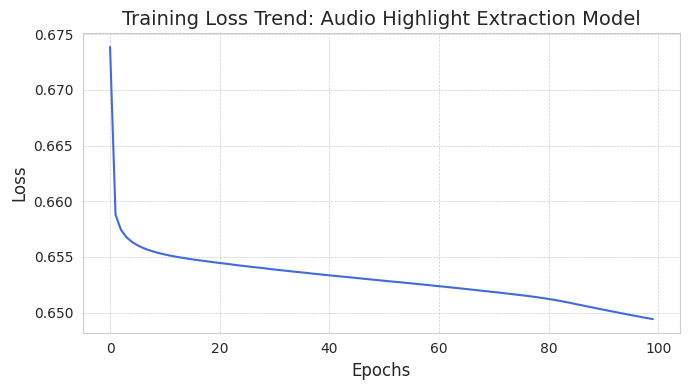

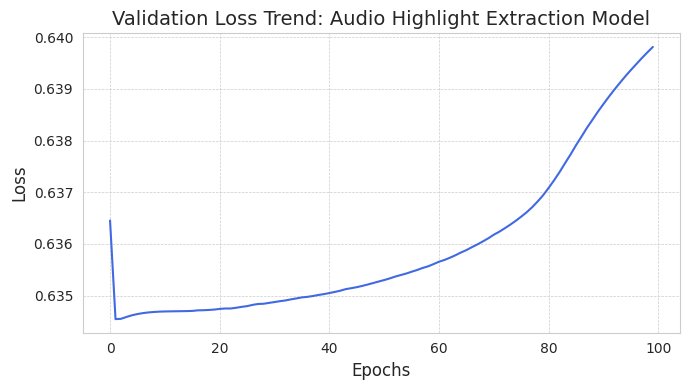

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))
plt.plot(train_loss, color='royalblue')
plt.title("Training Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))
plt.plot(val_loss, color='royalblue')
plt.title("Validation Loss Trend: Audio Highlight Extraction Model", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/gru_audio_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Evaluate Audio Highlight Extraction Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 128
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/gru_audio_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if len(inputs)!= len(labels) :
          continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])

y_true_pad = np.concatenate(y_true, axis=1).squeeze()
y_pred_pad = np.concatenate(y_pred, axis=0)

len(y_true_pad), len(y_pred_pad)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred_pad > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true_pad, y_pred_t, average='binary')
    acc = accuracy_score(y_true_pad, y_pred_t)
    prec = precision_score(y_true_pad, y_pred_t)
    rec = recall_score(y_true_pad, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-76-079b04a6304d>:18: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-76-079b04a6304d>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-76-079b04a6304d>:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing

Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.572160  0.400717   0.400717  1.000000
2        0.10  0.572366  0.401864   0.401092  0.998927
3        0.15  0.572664  0.404731   0.401965  0.995349
4        0.20  0.572703  0.409319   0.403242  0.987835
5        0.25  0.571099  0.414480   0.404192  0.972809
6        0.30  0.548803  0.473118   0.417757  0.799642
7        0.35  0.511199  0.521290   0.432607  0.624687
8        0.40  0.283539  0.568172   0.422995  0.213238
9        0.45  0.007812  0.599427   0.523810  0.003936
10       0.50  0.000000  0.599283   0.000000  0.000000
11       0.55  0.000000  0.599283   0.000000  0.000000
12       0.60  0.000000  0.599283   0.000000  0.000000
13       0.65  0.000000  0.599283   0.000000  0.000000
14       0.70  0.000000  0.599283   0.000000  0.000000
15       0.75  0.000000  0.599283   0.000000  0.000000
16       0.80  0.000000  0.599283   0.000000  0.000000
17       0.85  0.000000  0.599283   0.000000  0.000000
18       0.90  0.000000  0.599283   0.000000  0.000000
19       0.95  0.000000  0.599283   0.000000  0.000000
20       1.00  0.000000  0.599283   0.000000  0.000000

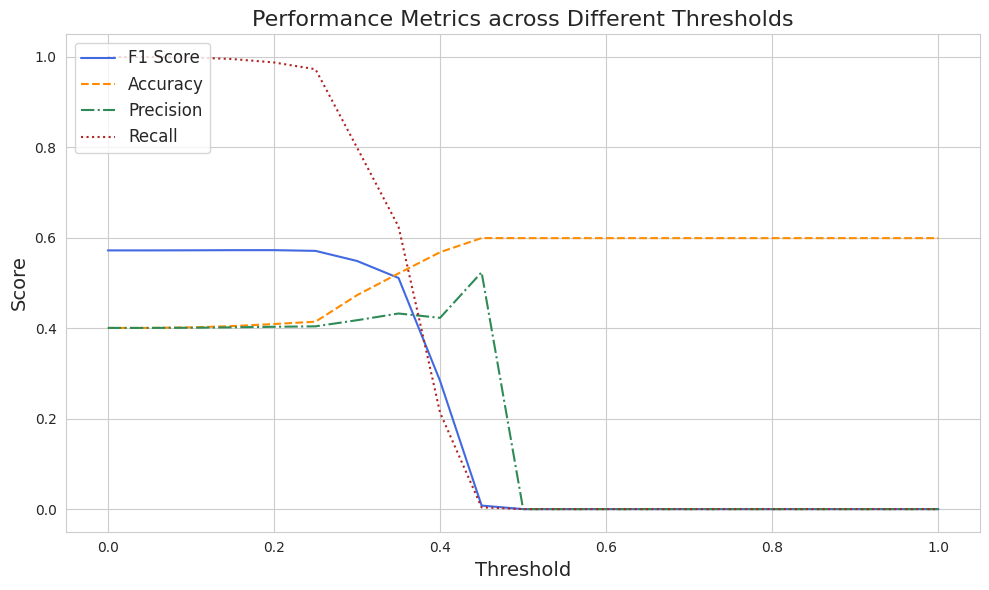

In [ ]:
# plot results

sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()




### Extract Audio Highlight Feature



In [ ]:
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load("model/highlight/gru_audio_highlight_detection_model.pt"))
md = MyDataset(emotion_features,emotion_lstm_labels)
dataloader = DataLoader(md)

In [ ]:
from tqdm.notebook import tqdm_notebook

concatenate_features = []

count = 1
for inputs, labels in tqdm_notebook(dataloader,total=len(dataloader)):
    with torch.no_grad():
        model.eval()
#         if inputs.shape[1] != labels.shape[1] : continue

        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)

        # Forward pass
        outputs,out = model(inputs)
        count += 1
        concatenate_features.append(out.cpu())

  0%|          | 0/151 [00:00<?, ?it/s]

In [ ]:
len(concatenate_features), concatenate_features[0].shape

(151, torch.Size([250, 128]))

In [ ]:
data_array = np.array(concatenate_features)

np.save('gru_concatenate_audio_features_array.npy',data_array)

<ipython-input-81-14ad88c61df6>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  data_array = np.array(concatenate_features)
<ipython-input-81-14ad88c61df6>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(concatenate_features)


# Part 4 - Video Highlight Extraction

---

In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 18.3 MB/s eta 0:00:00


## SummaryDataset

In [ ]:
import os

import argparse
from collections import defaultdict
import transformers
import numpy as np
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule
from torch import optim
# from torchmetrics import F1
from transformers import ViTModel
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
import math
import json
import argparse
from pathlib import Path
from transformers import ViTFeatureExtractor

In [ ]:
import unicodedata
class SummaryDataset(Dataset):
    def __init__(self, video_dir, directory, video_features_file, max_seq_len=250):
        self.directory = directory
        self.video_names = self.get_video_names(video_dir)
        self.video_features_file = video_features_file
        self.max_seq_len = max_seq_len

        # Because we can't use DDP with IterableDataset,
        # data must be pre-chunked to combat OOM.
        self.label_files = self.prefetch_label_files()
        self.data_size, self.index_to_chunk, self.labels = self.prefetch_and_index()

    def get_video_names(self, mp4_dir):
        video_names = []
        for filename in os.listdir(mp4_dir):
            if filename.endswith('.mp4'):
                name = os.path.splitext(filename)[0]
                video_names.append(name)
        return video_names

    def prefetch_label_files(self):

        name_set = set(self.video_names)

        label_files = defaultdict(list)

        for label_file in Path(self.directory).glob(f"**/*.json"):

            file_name = label_file.stem

            # 예시: [KBS]kim370_대법원 업무 과부하…상고 법원이 대안_18567498.json
            # annotator id 제거하면 비디오 이름 추출.
            # 파일 이름 reverse ([::-1]) 후 "_" 찾음.
            annotator_id_index = len(file_name) - file_name[::-1].find("_") - 1
            video_name = file_name[:annotator_id_index]

            if video_name in name_set:
                label_files[video_name].append(label_file)


        return label_files

    def prefetch_and_index(self):
        index = 0
        index_to_chunk = {}
        all_labels = {}
        # print("video names: ",self.video_names)
        for video_name in self.video_names:

#            if video_name == m"news_footage_1710":
#                continue

            labels = self.extract_label(video_name)
            # print(len(labels)) # 3
            all_labels[video_name] = labels
            chunk_count = math.ceil(len(labels[0]) / self.max_seq_len)
            for chunk_index in range(0, chunk_count):
                index_to_chunk[index + chunk_index] = (video_name, chunk_index)

            index += chunk_count
        print(index)
        return index, index_to_chunk, all_labels

    def __len__(self):
        return self.data_size

    def __getitem__(self, index):

        video_name, chunk_index = self.index_to_chunk[index]
        if isinstance(video_name, bytes):
          video_name = video_name.decode('utf-8')
        else:
          video_name = str(video_name)

        start = chunk_index * self.max_seq_len
        end = start + self.max_seq_len
        with h5py.File(self.video_features_file, "r") as rf:
            keys = list(rf.keys())
            normalized_keys = [unicodedata.normalize('NFC', k.decode('utf-8') if isinstance(k, bytes) else k) for k in rf.keys()]

            # Normalize video_name
            video_name_normalized = unicodedata.normalize('NFC', video_name)
            if video_name_normalized in normalized_keys:
              labels = self.labels[video_name][:, start:end]
              video_features = rf[video_name_normalized][start:end]
              # print(video_features)
            else:
              print("No matching key found for video_name:", video_name_normalized)
              return None


            labels = torch.from_numpy(labels)
            # majority voting
            labels = labels.squeeze(0)
            labels = torch.sum(labels, dim=0)
            labels = torch.min(
                labels,
                torch.ones(
                    labels.shape[0],
                ).to(labels.device),
            )
            return video_name, video_features, labels

    def extract_label(self, video_name):

        label_files = self.label_files[video_name]
        labels = []

        for label_file in label_files:

            with open(label_file, "r") as rf:
                data = json.load(rf)

            metadata = data["metadata"]
            video_length = math.ceil(metadata["length"])
            annotator_label = np.zeros((video_length,))

            for timeline in data["timelines"]:
                for time_index in range(timeline["start"], timeline["end"] + 1):
                    # annotator_label[time_index] += 1
                    if time_index < video_length:
                        annotator_label[time_index] = 1

            labels.append(annotator_label)

        labels = np.array(labels)
        return labels

### Make h5py

In [ ]:
'''
import argparse
from pathlib import Path

import cv2
import h5py
import numpy as np
from tqdm import tqdm
from transformers import ViTFeatureExtractor

args = argparse.Namespace(
    data_directory = "video_data/video",
    out = "video_data/video.h5"
)
video_files = tqdm(list(Path(args.data_directory).glob("**/*.mp4")))
extractor = ViTFeatureExtractor.from_pretrained(
    "google/vit-base-patch16-224", size=224
)


def extract_video_features(extractor, video_file):
    vc = cv2.VideoCapture(str(video_file))
    fps = int(vc.get(cv2.CAP_PROP_FPS))
    frames = []
    last_collected = -1
    while vc.isOpened():
        success, frame = vc.read()
        if not success:
            break
        timestmap = vc.get(cv2.CAP_PROP_POS_MSEC)
        second = timestmap // 1000
        if second != last_collected:
            last_collected = second
            frames.append(frame)
    features = extractor(images=frames, return_tensors="pt")
    return features["pixel_values"]

with h5py.File(args.out, "w") as wf:
    for video_file in video_files:
        name = video_file.stem
        try:
            features = extract_video_features(
                extractor, video_file
            )
            wf.create_dataset(name, data=features)
        except Exception as e:
            print(e)
'''

## Unzip h5py

In [ ]:
'''
import zipfile
import os

zip_file_path = 'video_data/video.h5.zip'
unzip_folder_path = 'video_data/'

if not os.path.exists(unzip_folder_path):
    os.makedirs(unzip_folder_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_folder_path)

print("Unzipped files in:", unzip_folder_path)
'''

Unzipped files in: video_data/


## Check Keys in h5py File and Define DataLoader

In [ ]:
train_label_path = "video_data/label"
val_label_path = "video_data/label"

mp4_dir = "video_data/video"

# video_path = f'{mp4_dir}/{video_name}.mp4'
args = argparse.Namespace(
    data_directory =  "video_data/label",
    video_features_file = "video_data/video.h5"
)

In [ ]:
sd = SummaryDataset(mp4_dir, args.data_directory, args.video_features_file)
sdl = DataLoader(sd, batch_size=1)

151


In [ ]:
sd[0][1].shape

(250, 3, 224, 224)

In [ ]:
with h5py.File('video_data/video.h5', 'r') as file:
    print(list(file.keys()))
    print(len(list(file.keys())))

['유튜브_기타_19843', '유튜브_기타_19881', '유튜브_기타_19999', '유튜브_기타_20022', '유튜브_기타_20060', '유튜브_기타_20094', '유튜브_기타_20145', '유튜브_기타_20169', '유튜브_기타_20170', '유튜브_기타_20188', '유튜브_반려동물및동물_2153', '유튜브_반려동물및동물_2159', '유튜브_반려동물및동물_2161', '유튜브_반려동물및동물_2239', '유튜브_반려동물및동물_2250', '유튜브_반려동물및동물_2271', '유튜브_반려동물및동물_2282', '유튜브_반려동물및동물_2302', '유튜브_반려동물및동물_2334', '유튜브_반려동물및동물_2337', '유튜브_스타일링및뷰티_14630', '유튜브_스타일링및뷰티_14639', '유튜브_스타일링및뷰티_14663', '유튜브_스타일링및뷰티_14701', '유튜브_스타일링및뷰티_14715', '유튜브_스타일링및뷰티_14737', '유튜브_스타일링및뷰티_14781', '유튜브_스타일링및뷰티_14801', '유튜브_스타일링및뷰티_14869', '유튜브_스타일링및뷰티_14908', '유튜브_스포츠_4174', '유튜브_스포츠_4251', '유튜브_스포츠_4322', '유튜브_스포츠_4333', '유튜브_스포츠_4408', '유튜브_스포츠_4410', '유튜브_스포츠_4437', '유튜브_스포츠_4479', '유튜브_스포츠_4552', '유튜브_스포츠_4555', '유튜브_여행_7640', '유튜브_여행_7648', '유튜브_여행_7699']
43


In [ ]:
import os

dir_path = "video_data/video"

# 해당 디렉토리 경로에 있는 파일 리스트 가져오기
file_list = os.listdir(dir_path)

print("number of files:", len(file_list))

number of files: 43


## SummaryModel

In [ ]:
class SummaryModel(LightningModule):
    def __init__(self, hidden_dim=768, individual_logs=None):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.scorer = nn.Linear(hidden_dim, 1)
        self.feature_extractor = nn.Identity() # Feature extraction layer

        # self.sigmoid = nn.Sigmoid()
        self.loss = nn.BCEWithLogitsLoss()
        # self.train_f1 = F1()
        # self.val_f1 = F1()
        # self.test_f1 = F1()
        self.individual_logs = individual_logs
        self.tta_logs = defaultdict(list)

    def forward(self, x):
        x = self.vit(x).pooler_output
        score = self.scorer(x)
        feature = self.feature_extractor(x) # extract features
        # x = self.sigmoid(x)
        return score, feature

    def run_batch(self, batch, batch_idx, metric, training=False):
        video_name, image_features, labels = batch
        video_name = video_name[0]
        image_features = image_features.squeeze(0)
        labels = labels.squeeze(0)

        # Score - aggregated labels.
        score = torch.sum(labels, dim=0)
        score = torch.min(
            score,
            torch.ones(
                score.shape[0],
            ).to(score.device),
        )
        out = self(image_features).squeeze(1)
        try:
            loss = self.loss(out.double(), score)
            preds = (torch.sigmoid(out) > 0.7).int()
            metric.update(preds, score.int())
            f1 = metric.compute()
            tp, fp, tn, fn = metric._get_final_stats()
            self.tta_logs[video_name].append((tp.item(), fp.item(), fn.item()))
        except Exception as e:
            print(e)
            loss = 0
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.train_f1, training=True)
        self.log("train_loss", loss)
        return loss

    def training_epoch_end(self, training_step_outputs):
        self.log("train_f1", self.train_f1.compute())
        self.train_f1.reset()

    def validation_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.val_f1)
        self.log("val_loss", loss)
        return loss

    def validation_epoch_end(self, validation_step_outputs):
        self.log("val_f1", self.val_f1.compute())
        self.val_f1.reset()

    def test_step(self, batch, batch_idx):
        loss = self.run_batch(batch, batch_idx, self.test_f1)
        self.log("test_loss", loss)
        return loss

    def test_epoch_end(self, outputs):
        f1 = self.test_f1.compute()
        self.log("test_f1", f1)
        tp, fp, tn, fn = self.test_f1._get_final_stats()
        print(f"\nTest f1: {f1}, TP: {tp}, FP: {fp}, TN: {tn}, fn: {fn}")
        self.test_f1.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-4)
        return optimizer


## Visualize ViT Features

In [ ]:
import argparse

import torch
from transformers import ViTFeatureExtractor

In [ ]:
def extract_video_features(extractor, video_file, sample_every=-1):

    vc = cv2.VideoCapture(str(video_file))
    fps = int(vc.get(cv2.CAP_PROP_FPS))
    frames = []
    last_collected = -1
    while vc.isOpened():

        success, frame = vc.read()
        if not success:
            break

        timestmap = vc.get(cv2.CAP_PROP_POS_MSEC)
        second = timestmap // 1000
        if second != last_collected:
            last_collected = second
            frames.append(frame)

    features = extractor(images=frames, return_tensors="pt")
    return features["pixel_values"]

In [ ]:
class Summarizer:
    def __init__(self, model_path, device="cpu"):
        self.model_path = model_path
        self.device = device
        self.video_feature_extractor = ViTFeatureExtractor.from_pretrained(
            "google/vit-base-patch16-224"
        )
        self.model = SummaryModel.load_from_checkpoint(model_path).to(self.device)

    def summarize(self, video_path, threshold=0.7):
        video_features = extract_video_features(
            self.video_feature_extractor, video_path
        ).to(self.model.device)
        out = self.model(video_features)
        preds = (torch.sigmoid(out) > threshold).nonzero(as_tuple=True)[0]
        preds = preds.tolist()
        return preds

In [ ]:
from transformers import ViTImageProcessor
preprocessor = ViTImageProcessor.from_pretrained(
    "google/vit-base-patch16-224", size=224, device='cuda'
)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [ ]:
# 라벨링 디렉토리 경로
train_label_path = "video_data/label"
val_label_path = "video_data/label"

# mp4 파일이 있는 디렉토리 경로
mp4_dir = "video_data/video"

In [ ]:
# sample video length check
SAMPLE_EVERY_SEC = 1

video_name = '유튜브_기타_19843'
video_path = f'{mp4_dir}/{video_name}.mp4'

cap = cv2.VideoCapture(video_path)

n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

video_len = n_frames / fps

print(f'Video length {video_len:.2f} seconds!')

frames = []
last_collected = -1

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
    second = timestamp // 1000

    if second % SAMPLE_EVERY_SEC == 0 and second != last_collected:
        last_collected = second
        frames.append(frame)

# features = preprocessor(images=frames, return_tensors="pt")["pixel_values"]

# print(features.shape)

Video length 1042.80 seconds!


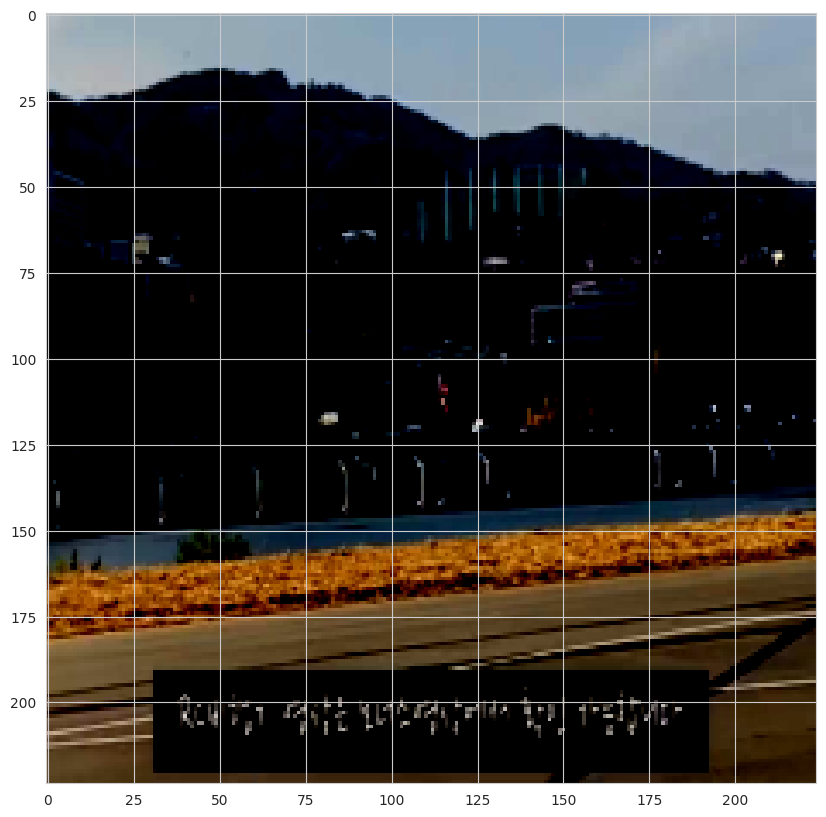

In [ ]:
features = preprocessor(images=frames, return_tensors="pt")["pixel_values"]

plt.figure(figsize=(10, 10))
plt.imshow(features[0].numpy().transpose(1, 2, 0)[:, :, ::-1])

## Extract Video Highlight Feature

In [ ]:
model = SummaryModel()
model.to('cuda')
model.eval()

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

SummaryModel(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_featu

In [ ]:
PATH = 'summary.ckpt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
import os
args = argparse.Namespace(
    videos = "video_data/video",
    data_directory =  "video_data/label",
    video_features_file = "video_data/video.h5"
)

val_label_path = "video_data/label"

In [ ]:
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

d = SummaryDataset(args.videos, args.data_directory, args.video_features_file)
dl = DataLoader(d, batch_size=1)
vit_features = []
y_true=[]
y_pred=[]

for video_name, inputs, labels in tqdm_notebook(dl,total=len(dl), desc='Processing dataset' ):
    with torch.no_grad():
        model.eval()
        y_pred_list = []
        vit_features_list=[]
        print(f'video_name: {video_name}, inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        for f in tqdm(inputs.squeeze(0)):
            y_p, y_f = model(f.cuda().unsqueeze(0))
            y_p = torch.sigmoid(y_p)
            y_pred_list.append(y_p.cpu().detach().numpy().squeeze())
            vit_features_list.append(y_f.cpu().detach().numpy().squeeze())
        y_true.append(labels.cpu().detach().numpy().squeeze())
        y_pred.append(np.array(y_pred_list))
        vit_features.append(np.array(vit_features_list))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
vit_features= np.array(vit_features) # extract features

151


Processing dataset:   0%|          | 0/151 [00:00<?, ?it/s]

video_name: ('유튜브_여행_7699',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:05<00:00, 48.96it/s]


video_name: ('유튜브_여행_7699',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 68.15it/s]


video_name: ('유튜브_여행_7699',), inputs.shape: torch.Size([1, 191, 3, 224, 224]), labels.shape: torch.Size([1, 191])



100%|██████████| 191/191 [00:02<00:00, 69.11it/s]


video_name: ('유튜브_여행_7648',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 66.15it/s]


video_name: ('유튜브_여행_7648',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 67.47it/s]


video_name: ('유튜브_여행_7648',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 68.20it/s]


video_name: ('유튜브_여행_7648',), inputs.shape: torch.Size([1, 142, 3, 224, 224]), labels.shape: torch.Size([1, 142])



100%|██████████| 142/142 [00:02<00:00, 66.39it/s]


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 66.23it/s]


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 67.44it/s]


video_name: ('유튜브_여행_7640',), inputs.shape: torch.Size([1, 54, 3, 224, 224]), labels.shape: torch.Size([1, 54])



100%|██████████| 54/54 [00:00<00:00, 64.24it/s]


video_name: ('유튜브_스타일링및뷰티_14801',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 55.31it/s]


video_name: ('유튜브_스타일링및뷰티_14801',), inputs.shape: torch.Size([1, 67, 3, 224, 224]), labels.shape: torch.Size([1, 67])



100%|██████████| 67/67 [00:00<00:00, 67.16it/s]


video_name: ('유튜브_스타일링및뷰티_14781',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 64.65it/s]


video_name: ('유튜브_스타일링및뷰티_14781',), inputs.shape: torch.Size([1, 201, 3, 224, 224]), labels.shape: torch.Size([1, 201])



100%|██████████| 201/201 [00:03<00:00, 64.34it/s]


video_name: ('유튜브_스타일링및뷰티_14737',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 65.26it/s]


video_name: ('유튜브_스타일링및뷰티_14737',), inputs.shape: torch.Size([1, 124, 3, 224, 224]), labels.shape: torch.Size([1, 124])



100%|██████████| 124/124 [00:01<00:00, 65.65it/s]


video_name: ('유튜브_스타일링및뷰티_14715',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 52.62it/s]


video_name: ('유튜브_스타일링및뷰티_14715',), inputs.shape: torch.Size([1, 183, 3, 224, 224]), labels.shape: torch.Size([1, 183])



100%|██████████| 183/183 [00:04<00:00, 43.78it/s]


video_name: ('유튜브_스타일링및뷰티_14701',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 62.59it/s]


video_name: ('유튜브_스타일링및뷰티_14701',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.37it/s]


video_name: ('유튜브_스타일링및뷰티_14701',), inputs.shape: torch.Size([1, 102, 3, 224, 224]), labels.shape: torch.Size([1, 102])



100%|██████████| 102/102 [00:01<00:00, 62.14it/s]


video_name: ('유튜브_스타일링및뷰티_14663',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 51.30it/s]


video_name: ('유튜브_스타일링및뷰티_14663',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.96it/s]


video_name: ('유튜브_스타일링및뷰티_14663',), inputs.shape: torch.Size([1, 30, 3, 224, 224]), labels.shape: torch.Size([1, 30])



100%|██████████| 30/30 [00:00<00:00, 61.03it/s]


video_name: ('유튜브_스타일링및뷰티_14639',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.88it/s]


video_name: ('유튜브_스타일링및뷰티_14639',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.21it/s]


video_name: ('유튜브_스타일링및뷰티_14639',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.76it/s]


video_name: ('유튜브_스타일링및뷰티_14639',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.88it/s]


video_name: ('유튜브_스타일링및뷰티_14639',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 62.83it/s]


video_name: ('유튜브_스타일링및뷰티_14639',), inputs.shape: torch.Size([1, 136, 3, 224, 224]), labels.shape: torch.Size([1, 136])



100%|██████████| 136/136 [00:02<00:00, 63.31it/s]


video_name: ('유튜브_스타일링및뷰티_14630',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.60it/s]


video_name: ('유튜브_스타일링및뷰티_14630',), inputs.shape: torch.Size([1, 208, 3, 224, 224]), labels.shape: torch.Size([1, 208])



100%|██████████| 208/208 [00:03<00:00, 63.66it/s]


video_name: ('유튜브_기타_20022',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 63.66it/s]


video_name: ('유튜브_기타_20022',), inputs.shape: torch.Size([1, 78, 3, 224, 224]), labels.shape: torch.Size([1, 78])



100%|██████████| 78/78 [00:02<00:00, 32.26it/s]


video_name: ('유튜브_기타_19999',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.49it/s]


video_name: ('유튜브_기타_19999',), inputs.shape: torch.Size([1, 212, 3, 224, 224]), labels.shape: torch.Size([1, 212])



100%|██████████| 212/212 [00:03<00:00, 63.86it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.15it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:05<00:00, 48.42it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 62.54it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.79it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.21it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.40it/s]


video_name: ('유튜브_기타_19881',), inputs.shape: torch.Size([1, 246, 3, 224, 224]), labels.shape: torch.Size([1, 246])



100%|██████████| 246/246 [00:06<00:00, 39.60it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 58.40it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.14it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.26it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.77it/s]


video_name: ('유튜브_기타_19843',), inputs.shape: torch.Size([1, 43, 3, 224, 224]), labels.shape: torch.Size([1, 43])



100%|██████████| 43/43 [00:01<00:00, 32.82it/s]


video_name: ('유튜브_스타일링및뷰티_14869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 39.40it/s]


video_name: ('유튜브_스타일링및뷰티_14869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 52.61it/s]


video_name: ('유튜브_스타일링및뷰티_14869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:07<00:00, 32.06it/s]


video_name: ('유튜브_스타일링및뷰티_14869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:10<00:00, 24.76it/s]


video_name: ('유튜브_스타일링및뷰티_14869',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:09<00:00, 25.40it/s]


video_name: ('유튜브_스타일링및뷰티_14869',), inputs.shape: torch.Size([1, 105, 3, 224, 224]), labels.shape: torch.Size([1, 106])



100%|██████████| 105/105 [00:02<00:00, 44.76it/s]


video_name: ('유튜브_반려동물및동물_2153',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:08<00:00, 28.32it/s]


video_name: ('유튜브_반려동물및동물_2153',), inputs.shape: torch.Size([1, 232, 3, 224, 224]), labels.shape: torch.Size([1, 232])



100%|██████████| 232/232 [00:05<00:00, 38.68it/s]


video_name: ('유튜브_반려동물및동물_2159',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 41.18it/s]


video_name: ('유튜브_반려동물및동물_2159',), inputs.shape: torch.Size([1, 130, 3, 224, 224]), labels.shape: torch.Size([1, 130])



100%|██████████| 130/130 [00:03<00:00, 40.60it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:07<00:00, 34.26it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 36.14it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 38.64it/s]


video_name: ('유튜브_스포츠_4174',), inputs.shape: torch.Size([1, 86, 3, 224, 224]), labels.shape: torch.Size([1, 86])



100%|██████████| 86/86 [00:01<00:00, 51.77it/s]


video_name: ('유튜브_스타일링및뷰티_14908',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:08<00:00, 29.29it/s]


video_name: ('유튜브_스타일링및뷰티_14908',), inputs.shape: torch.Size([1, 148, 3, 224, 224]), labels.shape: torch.Size([1, 148])



100%|██████████| 148/148 [00:03<00:00, 45.87it/s]


video_name: ('유튜브_스포츠_4251',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:11<00:00, 20.86it/s]


video_name: ('유튜브_스포츠_4251',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 39.16it/s]


video_name: ('유튜브_스포츠_4251',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 36.28it/s]


video_name: ('유튜브_스포츠_4251',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.91it/s]


video_name: ('유튜브_스포츠_4251',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.48it/s]


video_name: ('유튜브_스포츠_4251',), inputs.shape: torch.Size([1, 3, 3, 224, 224]), labels.shape: torch.Size([1, 3])



100%|██████████| 3/3 [00:00<00:00, 54.23it/s]


video_name: ('유튜브_스포츠_4322',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 58.13it/s]


video_name: ('유튜브_스포츠_4322',), inputs.shape: torch.Size([1, 149, 3, 224, 224]), labels.shape: torch.Size([1, 150])



100%|██████████| 149/149 [00:02<00:00, 58.86it/s]


video_name: ('유튜브_기타_20060',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.78it/s]


video_name: ('유튜브_기타_20060',), inputs.shape: torch.Size([1, 107, 3, 224, 224]), labels.shape: torch.Size([1, 107])



100%|██████████| 107/107 [00:01<00:00, 60.71it/s]


video_name: ('유튜브_스포츠_4333',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.23it/s]


video_name: ('유튜브_스포츠_4333',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.84it/s]


video_name: ('유튜브_스포츠_4333',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:06<00:00, 38.21it/s]


video_name: ('유튜브_스포츠_4333',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 63.45it/s]


video_name: ('유튜브_스포츠_4333',), inputs.shape: torch.Size([1, 69, 3, 224, 224]), labels.shape: torch.Size([1, 69])



100%|██████████| 69/69 [00:01<00:00, 63.50it/s]


video_name: ('유튜브_반려동물및동물_2161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:05<00:00, 47.99it/s]


video_name: ('유튜브_반려동물및동물_2161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:05<00:00, 41.77it/s]


video_name: ('유튜브_반려동물및동물_2161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.10it/s]


video_name: ('유튜브_반려동물및동물_2161',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 57.66it/s]


video_name: ('유튜브_반려동물및동물_2161',), inputs.shape: torch.Size([1, 208, 3, 224, 224]), labels.shape: torch.Size([1, 208])



100%|██████████| 208/208 [00:03<00:00, 62.18it/s]


video_name: ('유튜브_스포츠_4408',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 58.31it/s]


video_name: ('유튜브_스포츠_4408',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.76it/s]


video_name: ('유튜브_스포츠_4408',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.80it/s]


video_name: ('유튜브_스포츠_4408',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.11it/s]


video_name: ('유튜브_스포츠_4408',), inputs.shape: torch.Size([1, 67, 3, 224, 224]), labels.shape: torch.Size([1, 67])



100%|██████████| 67/67 [00:01<00:00, 59.08it/s]


video_name: ('유튜브_스포츠_4410',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 62.57it/s]


video_name: ('유튜브_스포츠_4410',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.33it/s]


video_name: ('유튜브_스포츠_4410',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.08it/s]


video_name: ('유튜브_스포츠_4410',), inputs.shape: torch.Size([1, 231, 3, 224, 224]), labels.shape: torch.Size([1, 231])



100%|██████████| 231/231 [00:03<00:00, 63.05it/s]


video_name: ('유튜브_스포츠_4437',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:03<00:00, 62.53it/s]


video_name: ('유튜브_스포츠_4437',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.62it/s]


video_name: ('유튜브_스포츠_4437',), inputs.shape: torch.Size([1, 242, 3, 224, 224]), labels.shape: torch.Size([1, 242])



100%|██████████| 242/242 [00:03<00:00, 62.91it/s]


video_name: ('유튜브_스포츠_4479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.61it/s]


video_name: ('유튜브_스포츠_4479',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.20it/s]


video_name: ('유튜브_스포츠_4479',), inputs.shape: torch.Size([1, 26, 3, 224, 224]), labels.shape: torch.Size([1, 26])



100%|██████████| 26/26 [00:00<00:00, 64.81it/s]


video_name: ('유튜브_기타_20094',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.73it/s]


video_name: ('유튜브_기타_20094',), inputs.shape: torch.Size([1, 52, 3, 224, 224]), labels.shape: torch.Size([1, 52])



100%|██████████| 52/52 [00:01<00:00, 34.28it/s]


video_name: ('유튜브_기타_20145',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.78it/s]


video_name: ('유튜브_기타_20145',), inputs.shape: torch.Size([1, 96, 3, 224, 224]), labels.shape: torch.Size([1, 96])



100%|██████████| 96/96 [00:01<00:00, 59.95it/s]


video_name: ('유튜브_기타_20169',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 50.40it/s]


video_name: ('유튜브_기타_20169',), inputs.shape: torch.Size([1, 71, 3, 224, 224]), labels.shape: torch.Size([1, 72])



100%|██████████| 71/71 [00:01<00:00, 62.43it/s]


video_name: ('유튜브_기타_20170',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.77it/s]


video_name: ('유튜브_기타_20170',), inputs.shape: torch.Size([1, 71, 3, 224, 224]), labels.shape: torch.Size([1, 71])



100%|██████████| 71/71 [00:01<00:00, 60.66it/s]


video_name: ('유튜브_기타_20188',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.82it/s]


video_name: ('유튜브_기타_20188',), inputs.shape: torch.Size([1, 57, 3, 224, 224]), labels.shape: torch.Size([1, 57])



100%|██████████| 57/57 [00:00<00:00, 59.85it/s]


video_name: ('유튜브_반려동물및동물_2239',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.44it/s]


video_name: ('유튜브_반려동물및동물_2239',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.32it/s]


video_name: ('유튜브_반려동물및동물_2239',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.57it/s]


video_name: ('유튜브_반려동물및동물_2239',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 58.89it/s]


video_name: ('유튜브_반려동물및동물_2239',), inputs.shape: torch.Size([1, 35, 3, 224, 224]), labels.shape: torch.Size([1, 35])



100%|██████████| 35/35 [00:00<00:00, 57.96it/s]


video_name: ('유튜브_반려동물및동물_2250',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.54it/s]


video_name: ('유튜브_반려동물및동물_2250',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.44it/s]


video_name: ('유튜브_반려동물및동물_2250',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.08it/s]


video_name: ('유튜브_반려동물및동물_2250',), inputs.shape: torch.Size([1, 142, 3, 224, 224]), labels.shape: torch.Size([1, 142])



100%|██████████| 142/142 [00:02<00:00, 62.09it/s]


video_name: ('유튜브_반려동물및동물_2271',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.68it/s]


video_name: ('유튜브_반려동물및동물_2271',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.85it/s]


video_name: ('유튜브_반려동물및동물_2271',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.48it/s]


video_name: ('유튜브_반려동물및동물_2271',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.34it/s]


video_name: ('유튜브_반려동물및동물_2271',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:05<00:00, 44.20it/s]


video_name: ('유튜브_반려동물및동물_2271',), inputs.shape: torch.Size([1, 216, 3, 224, 224]), labels.shape: torch.Size([1, 216])



100%|██████████| 216/216 [00:03<00:00, 61.66it/s]


video_name: ('유튜브_반려동물및동물_2282',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.64it/s]


video_name: ('유튜브_반려동물및동물_2282',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:05<00:00, 42.87it/s]


video_name: ('유튜브_반려동물및동물_2282',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.36it/s]


video_name: ('유튜브_반려동물및동물_2282',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.90it/s]


video_name: ('유튜브_반려동물및동물_2282',), inputs.shape: torch.Size([1, 179, 3, 224, 224]), labels.shape: torch.Size([1, 179])



100%|██████████| 179/179 [00:03<00:00, 59.52it/s]


video_name: ('유튜브_반려동물및동물_2302',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.09it/s]


video_name: ('유튜브_반려동물및동물_2302',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.92it/s]


video_name: ('유튜브_반려동물및동물_2302',), inputs.shape: torch.Size([1, 114, 3, 224, 224]), labels.shape: torch.Size([1, 114])



100%|██████████| 114/114 [00:01<00:00, 60.61it/s]


video_name: ('유튜브_반려동물및동물_2334',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.23it/s]


video_name: ('유튜브_반려동물및동물_2334',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.90it/s]


video_name: ('유튜브_반려동물및동물_2334',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 58.51it/s]


video_name: ('유튜브_반려동물및동물_2334',), inputs.shape: torch.Size([1, 153, 3, 224, 224]), labels.shape: torch.Size([1, 153])



100%|██████████| 153/153 [00:02<00:00, 62.33it/s]


video_name: ('유튜브_반려동물및동물_2337',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.53it/s]


video_name: ('유튜브_반려동물및동물_2337',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.50it/s]


video_name: ('유튜브_반려동물및동물_2337',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.74it/s]


video_name: ('유튜브_반려동물및동물_2337',), inputs.shape: torch.Size([1, 68, 3, 224, 224]), labels.shape: torch.Size([1, 68])



100%|██████████| 68/68 [00:01<00:00, 62.41it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.65it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 60.15it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.49it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 61.83it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 58.96it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.21it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 62.07it/s]


video_name: ('유튜브_스포츠_4552',), inputs.shape: torch.Size([1, 244, 3, 224, 224]), labels.shape: torch.Size([1, 245])



100%|██████████| 244/244 [00:04<00:00, 60.58it/s]


video_name: ('유튜브_스포츠_4555',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.49it/s]


video_name: ('유튜브_스포츠_4555',), inputs.shape: torch.Size([1, 250, 3, 224, 224]), labels.shape: torch.Size([1, 250])



100%|██████████| 250/250 [00:04<00:00, 59.62it/s]


video_name: ('유튜브_스포츠_4555',), inputs.shape: torch.Size([1, 129, 3, 224, 224]), labels.shape: torch.Size([1, 129])



100%|██████████| 129/129 [00:02<00:00, 57.13it/s]
<ipython-input-67-22092d57bb80>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array(y_true)
<ipython-input-67-22092d57bb80>:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_pred = np.array(y_pred)
<ipython-input-67-22092d57bb80>:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating 

In [ ]:
np.save('concatenate_vit_features_array.npy',vit_features)

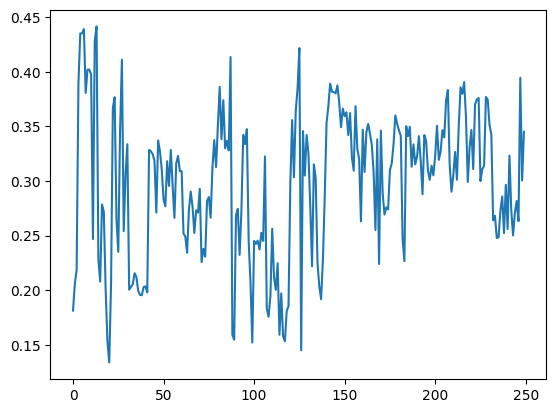

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred[0])

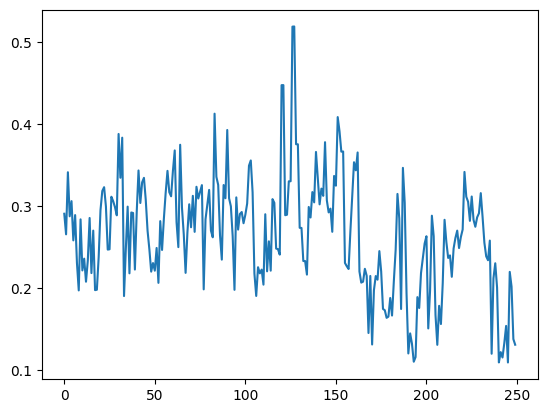

In [ ]:
plt.plot(y_pred[1])

# Part 5 - Multimodal Highlight Extraction
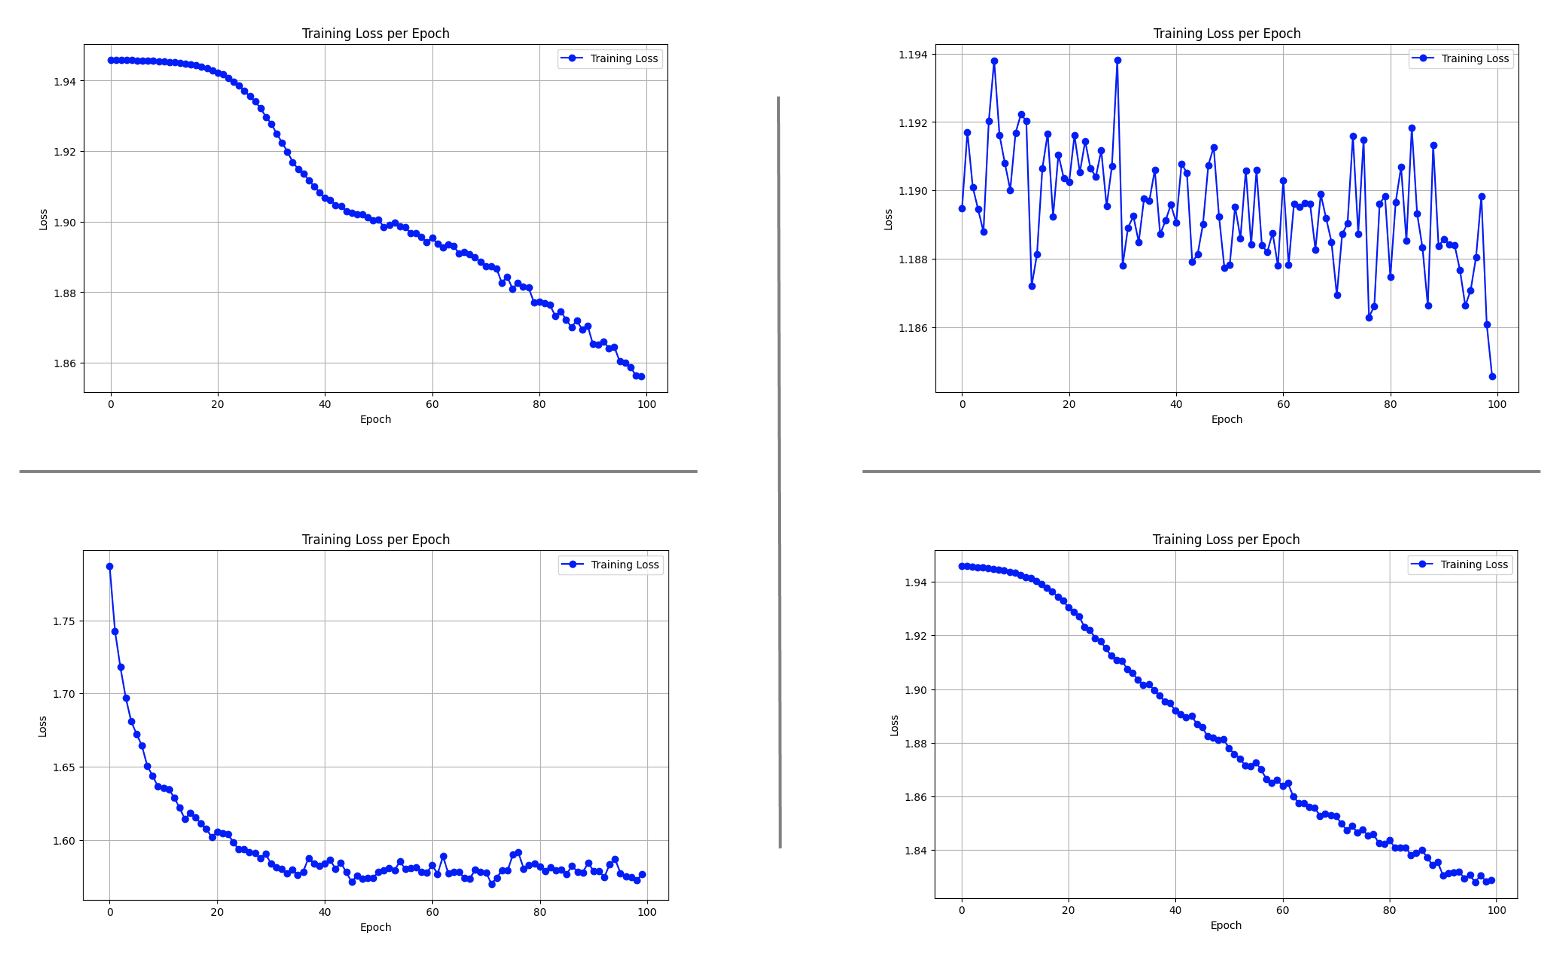
---

## 1) LSTM Audio Emotion Feature

### Load Video, Audio Highlight Features

In [ ]:
import os

import numpy as np
import pandas as pd
import torch

In [ ]:
concatenate_vit_features = np.load('concatenate_vit_features_array.npy', allow_pickle=True)
concatenate_audio_features = np.load('lstm_concatenate_audio_features_array.npy', allow_pickle=True)

labels = np.load('labels.npy', allow_pickle=True)
labels = [l.squeeze() for l in labels]

In [ ]:
print(concatenate_vit_features.shape)
print(concatenate_audio_features.shape)
print(concatenate_vit_features[64].shape)
print(concatenate_audio_features[64].shape)

(151,)
(151,)
(250, 768)
torch.Size([250, 128])


In [ ]:
concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])

<ipython-input-196-ef19289f87aa>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])
<ipython-input-196-ef19289f87aa>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])


In [ ]:
features_concatenate_list = []
cnt = 0
max_seq_len = 896
for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    if len(vit_features) == len(audio_features):
        concated_feature = torch.cat((vit_features, audio_features), dim=1)
    elif len(vit_features) > len(audio_features):
        # Split into columns of size 2
        pad = torch.zeros((len(vit_features)-len(audio_features), 128))
        audio_features = torch.cat((audio_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check1: {concated_feature.shape}')
    elif len(vit_features) < len(audio_features):
        pad = torch.zeros((len(audio_features)-len(vit_features), 768))
        vit_features = torch.cat((vit_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check2: {concated_feature.shape}')
    features_concatenate_list.append(concated_feature)

check2: torch.Size([106, 896])
check2: torch.Size([150, 896])
check2: torch.Size([72, 896])
check2: torch.Size([245, 896])


In [ ]:
len(features_concatenate_list), len(features_concatenate_list[2]), features_concatenate_list[0].shape, labels.shape

(151, 191, torch.Size([250, 896]), (151,))

In [ ]:
l = labels.tolist()
l = [i.tolist() for i in labels]
l_list = sum(l,[])
len(l_list)

151

### Dataset, Dataloader

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])
# Create an instance of dataset
md = MyDataset(features_concatenate_list,labels)
len(md), md[2][0].shape

<ipython-input-200-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([191, 896]))

In [ ]:
labels = [l.squeeze() for l in labels]

In [ ]:
#### 인덱스 개수 맞추기
new_features_concatenate_list = []
new_labels = []
for concat, label in zip(features_concatenate_list, labels):
    if len(concat) == len(label):
        new_features_concatenate_list.append(concat)
        new_labels.append(label)
    elif len(concat) > len(label):
        # Split into columns of size 2
        idx = len(label)
        new_concat = concat[0:idx,:]
        new_features_concatenate_list.append(new_concat)
        new_labels.append(label)
        print(f'check1: {new_concat.shape}, {label.shape}')
    elif len(concat) < len(label):
        idx = len(concat)
        new_label = label[0:idx]
        new_features_concatenate_list.append(concat)
        new_labels.append(new_label)
        print(f'check2: {concat.shape}, {new_label.shape}')

### Split Train, Val, Test

In [ ]:
md = MyDataset(new_features_concatenate_list,new_labels)
len(md), md[0][0].shape

<ipython-input-200-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([250, 896]))

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Multimodal Highlight Extraction Model

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        output = self.sigmoid(out)

        return output, out

### Model Training

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []
weight_dir = 'model/weight/'

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-200-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])
Epochs:   1%|          | 1/100 [00:05<08:52,  5.38s/it]

epoch [1/100], train_loss: 0.6673468838135401, val_loss: 0.6574572324752808, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:13<11:04,  6.78s/it]

epoch [2/100], train_loss: 0.6604527652263641, val_loss: 0.6572516560554504, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:19<10:19,  6.38s/it]

epoch [3/100], train_loss: 0.6590454555220074, val_loss: 0.6572716236114502, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:24<09:31,  5.95s/it]

epoch [4/100], train_loss: 0.6579210486676957, val_loss: 0.6572575569152832, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:33<11:14,  7.10s/it]

epoch [5/100], train_loss: 0.655746144718594, val_loss: 0.6578912138938904, p: 0, r: 0, f: 0


Epochs:   6%|▌         | 6/100 [00:42<11:53,  7.59s/it]

epoch [6/100], train_loss: 0.6514396101236344, val_loss: 0.6608017086982727, p: 0, r: 0, f: 0


Epochs:   7%|▋         | 7/100 [00:52<13:17,  8.57s/it]

epoch [7/100], train_loss: 0.6468691749705209, val_loss: 0.664125382900238, p: 0, r: 0, f: 0


Epochs:   8%|▊         | 8/100 [00:58<11:58,  7.81s/it]

epoch [8/100], train_loss: 0.6418211614092191, val_loss: 0.6672942638397217, p: 0.3662066644227533, r: 0.993607305936073, f: 0.5351696999508117


Epochs:   9%|▉         | 9/100 [01:06<11:49,  7.80s/it]

epoch [9/100], train_loss: 0.6342054928342501, val_loss: 0.6683681607246399, p: 0.3702744691869498, r: 0.9794520547945206, f: 0.5373919579105599


Epochs:  10%|█         | 10/100 [01:12<10:52,  7.25s/it]

epoch [10/100], train_loss: 0.6293030907710393, val_loss: 0.667517364025116, p: 0.37019147835087113, r: 0.9799086757990868, f: 0.5373732315011894


Epochs:  11%|█         | 11/100 [01:17<09:50,  6.63s/it]

epoch [11/100], train_loss: 0.6247208385003937, val_loss: 0.6682884693145752, p: 0.3689802913453299, r: 0.9831050228310503, f: 0.5365732087227414


Epochs:  12%|█▏        | 12/100 [01:26<10:25,  7.11s/it]

epoch [12/100], train_loss: 0.6201206483360794, val_loss: 0.6681318879127502, p: 0.36809815950920244, r: 0.9863013698630136, f: 0.5361131794489947


Epochs:  13%|█▎        | 13/100 [01:33<10:29,  7.24s/it]

epoch [13/100], train_loss: 0.6179373037070036, val_loss: 0.6694409251213074, p: 0.3678571428571429, r: 0.9876712328767123, f: 0.5360594795539034


Epochs:  14%|█▍        | 14/100 [01:44<12:02,  8.40s/it]

epoch [14/100], train_loss: 0.6127649452951219, val_loss: 0.6737020611763, p: 0.3690516946251284, r: 0.9844748858447488, f: 0.5368525896414342


Epochs:  15%|█▌        | 15/100 [01:51<11:25,  8.06s/it]

epoch [15/100], train_loss: 0.6107221502810717, val_loss: 0.6734511256217957, p: 0.36809920163071175, r: 0.9894977168949771, f: 0.5365853658536586


Epochs:  16%|█▌        | 16/100 [02:01<11:53,  8.49s/it]

epoch [16/100], train_loss: 0.6091730040601558, val_loss: 0.6757511496543884, p: 0.3672059319177621, r: 0.9949771689497717, f: 0.5364352535696701


Epochs:  17%|█▋        | 17/100 [02:08<11:17,  8.17s/it]

epoch [17/100], train_loss: 0.6063553893110818, val_loss: 0.6835161447525024, p: 0.3674709251865996, r: 0.9666666666666667, f: 0.5325116337567601


Epochs:  18%|█▊        | 18/100 [02:20<12:26,  9.11s/it]

epoch [18/100], train_loss: 0.6053772231977846, val_loss: 0.6840642094612122, p: 0.368135593220339, r: 0.9917808219178083, f: 0.5369592088998764


Epochs:  19%|█▉        | 19/100 [02:27<11:39,  8.63s/it]

epoch [19/100], train_loss: 0.6007827767377927, val_loss: 0.6872565746307373, p: 0.3672490578965399, r: 0.9789954337899544, f: 0.534130543099153


Epochs:  20%|██        | 20/100 [02:39<12:45,  9.57s/it]

epoch [20/100], train_loss: 0.6005404823252725, val_loss: 0.687567412853241, p: 0.3674434312732185, r: 0.993607305936073, f: 0.5364891518737672


Epochs:  21%|██        | 21/100 [02:45<11:09,  8.47s/it]

epoch [21/100], train_loss: 0.5962760165023308, val_loss: 0.696111798286438, p: 0.3658621288418128, r: 0.9621004566210045, f: 0.5301295760473016


Epochs:  22%|██▏       | 22/100 [02:52<10:38,  8.18s/it]

epoch [22/100], train_loss: 0.5949652701719768, val_loss: 0.7097116112709045, p: 0.3671861620140435, r: 0.9789954337899544, f: 0.5340640179349857


Epochs:  23%|██▎       | 23/100 [02:58<09:42,  7.56s/it]

epoch [23/100], train_loss: 0.5980217985394928, val_loss: 0.7123099565505981, p: 0.36731255265374896, r: 0.9954337899543378, f: 0.5366153846153846


Epochs:  24%|██▍       | 24/100 [03:04<08:40,  6.85s/it]

epoch [24/100], train_loss: 0.5899171226037045, val_loss: 0.7191329002380371, p: 0.3668853591160221, r: 0.9703196347031964, f: 0.5324480080180406


Epochs:  25%|██▌       | 25/100 [03:12<09:04,  7.26s/it]

epoch [25/100], train_loss: 0.5878120369226154, val_loss: 0.7225501537322998, p: 0.3657848324514991, r: 0.9470319634703196, f: 0.527735368956743


Epochs:  26%|██▌       | 26/100 [03:17<08:14,  6.68s/it]

epoch [26/100], train_loss: 0.5858942213623474, val_loss: 0.7298848032951355, p: 0.3664030261348005, r: 0.9730593607305936, f: 0.5323507369472895


Epochs:  27%|██▋       | 27/100 [03:22<07:35,  6.25s/it]

epoch [27/100], train_loss: 0.5812527155814071, val_loss: 0.723312258720398, p: 0.36719298245614035, r: 0.9557077625570777, f: 0.5305449936628645


Epochs:  28%|██▊       | 28/100 [03:31<08:21,  6.96s/it]

epoch [28/100], train_loss: 0.5844091641199257, val_loss: 0.7373185157775879, p: 0.367595818815331, r: 0.9634703196347032, f: 0.532156368221942


Epochs:  29%|██▉       | 29/100 [03:36<07:38,  6.46s/it]

epoch [29/100], train_loss: 0.5795053061382431, val_loss: 0.7427923679351807, p: 0.3645870258773485, r: 0.9392694063926941, f: 0.5252808988764045


Epochs:  30%|███       | 30/100 [03:40<06:27,  5.53s/it]

epoch [30/100], train_loss: 0.5760716572248687, val_loss: 0.7527388334274292, p: 0.366341713699333, r: 0.9780821917808219, f: 0.5330347144456887


Epochs:  31%|███       | 31/100 [03:44<06:03,  5.26s/it]

epoch [31/100], train_loss: 0.5723063120282151, val_loss: 0.7519645094871521, p: 0.3683087319935977, r: 0.945662100456621, f: 0.5301420709074619


Epochs:  32%|███▏      | 32/100 [03:49<05:35,  4.94s/it]

epoch [32/100], train_loss: 0.5713989494859966, val_loss: 0.7564371228218079, p: 0.36678863913573795, r: 0.9611872146118722, f: 0.5309622903266491


Epochs:  33%|███▎      | 33/100 [03:52<04:59,  4.47s/it]

epoch [33/100], train_loss: 0.5654374577027436, val_loss: 0.7722814083099365, p: 0.36595292868518847, r: 0.9442922374429223, f: 0.5274837393189644


Epochs:  34%|███▍      | 34/100 [03:55<04:33,  4.14s/it]

epoch [34/100], train_loss: 0.5614466926665045, val_loss: 0.7754064798355103, p: 0.36535983802687283, r: 0.906392694063927, f: 0.5207923389741572


Epochs:  35%|███▌      | 35/100 [04:00<04:37,  4.28s/it]

epoch [35/100], train_loss: 0.5610216400883574, val_loss: 0.7562528848648071, p: 0.36928508384819064, r: 0.9552511415525115, f: 0.5326543602800764


Epochs:  36%|███▌      | 36/100 [04:04<04:39,  4.36s/it]

epoch [36/100], train_loss: 0.555186305654287, val_loss: 0.7732663750648499, p: 0.3622947795609666, r: 0.8968036529680365, f: 0.5160951254762843


Epochs:  37%|███▋      | 37/100 [04:08<04:15,  4.05s/it]

epoch [37/100], train_loss: 0.550375834375801, val_loss: 0.7678404450416565, p: 0.36561875340723243, r: 0.9187214611872146, f: 0.5230729234368907


Epochs:  38%|███▊      | 38/100 [04:11<03:58,  3.84s/it]

epoch [38/100], train_loss: 0.5485300390509009, val_loss: 0.7659337520599365, p: 0.3605911330049261, r: 0.8356164383561644, f: 0.5037852718513421


Epochs:  39%|███▉      | 39/100 [04:15<03:52,  3.82s/it]

epoch [39/100], train_loss: 0.5483426478497374, val_loss: 0.7701172232627869, p: 0.36736174070716227, r: 0.9251141552511416, f: 0.5258922777417261


Epochs:  40%|████      | 40/100 [04:20<04:09,  4.15s/it]

epoch [40/100], train_loss: 0.5434363866173145, val_loss: 0.7603389620780945, p: 0.36087722733503036, r: 0.8415525114155251, f: 0.5051390982595587


Epochs:  41%|████      | 41/100 [04:23<03:52,  3.95s/it]

epoch [41/100], train_loss: 0.5437936913002179, val_loss: 0.7894754409790039, p: 0.365542388331814, r: 0.9155251141552512, f: 0.5224755700325733


Epochs:  42%|████▏     | 42/100 [04:27<03:38,  3.77s/it]

epoch [42/100], train_loss: 0.5358889005444426, val_loss: 0.7838916778564453, p: 0.36146465635402386, r: 0.8429223744292238, f: 0.5059613539810881


Epochs:  43%|████▎     | 43/100 [04:30<03:27,  3.64s/it]

epoch [43/100], train_loss: 0.5399526550751438, val_loss: 0.7667675614356995, p: 0.3612755394309719, r: 0.8639269406392694, f: 0.5094923926215161


Epochs:  44%|████▍     | 44/100 [04:35<03:44,  4.01s/it]

epoch [44/100], train_loss: 0.527213633024884, val_loss: 0.7797375321388245, p: 0.3642208774583964, r: 0.8794520547945206, f: 0.5151109922439155


Epochs:  45%|████▌     | 45/100 [04:39<03:39,  3.99s/it]

epoch [45/100], train_loss: 0.5278566938640628, val_loss: 0.7737047076225281, p: 0.3614314115308151, r: 0.8301369863013699, f: 0.503601108033241


Epochs:  46%|████▌     | 46/100 [04:42<03:24,  3.79s/it]

epoch [46/100], train_loss: 0.5215568193784242, val_loss: 0.7639000415802002, p: 0.36427668412497743, r: 0.9210045662100457, f: 0.5220654846641647


Epochs:  47%|████▋     | 47/100 [04:45<03:13,  3.66s/it]

epoch [47/100], train_loss: 0.5153100199871309, val_loss: 0.8023228049278259, p: 0.35933806146572106, r: 0.7634703196347032, f: 0.48867455794242287


Epochs:  48%|████▊     | 48/100 [04:50<03:22,  3.89s/it]

epoch [48/100], train_loss: 0.5162683722191206, val_loss: 0.7940283417701721, p: 0.3694852941176471, r: 0.9178082191780822, f: 0.526867627785059


Epochs:  49%|████▉     | 49/100 [04:54<03:27,  4.06s/it]

epoch [49/100], train_loss: 0.5215499786850867, val_loss: 0.8119193315505981, p: 0.35206688341848585, r: 0.6922374429223744, f: 0.4667487684729064


Epochs:  50%|█████     | 50/100 [04:58<03:18,  3.97s/it]

epoch [50/100], train_loss: 0.5181919426456767, val_loss: 0.7922540307044983, p: 0.3668350461592057, r: 0.9616438356164384, f: 0.5310805699155213


Epochs:  51%|█████     | 51/100 [05:03<03:33,  4.36s/it]

epoch [51/100], train_loss: 0.5082796013632712, val_loss: 0.8019951581954956, p: 0.3658489472667568, r: 0.8648401826484018, f: 0.5141848785122846


Epochs:  52%|█████▏    | 52/100 [05:12<04:25,  5.53s/it]

epoch [52/100], train_loss: 0.5116041278582998, val_loss: 0.8221557140350342, p: 0.36914976599063964, r: 0.8643835616438356, f: 0.5173544684339985


Epochs:  53%|█████▎    | 53/100 [05:17<04:14,  5.42s/it]

epoch [53/100], train_loss: 0.5017415768715889, val_loss: 0.8389032483100891, p: 0.36600441501103753, r: 0.7570776255707763, f: 0.493452380952381


Epochs:  54%|█████▍    | 54/100 [05:21<03:54,  5.10s/it]

epoch [54/100], train_loss: 0.5033945788749002, val_loss: 0.7879306674003601, p: 0.37045203969129, r: 0.9205479452054794, f: 0.5283018867924528


Epochs:  55%|█████▌    | 55/100 [05:26<03:47,  5.05s/it]

epoch [55/100], train_loss: 0.4947668314379472, val_loss: 0.8190543055534363, p: 0.3614457831325301, r: 0.7397260273972602, f: 0.4856115107913669


Epochs:  56%|█████▌    | 56/100 [05:30<03:26,  4.70s/it]

epoch [56/100], train_loss: 0.49635244281008556, val_loss: 0.8147720694541931, p: 0.3634705047638354, r: 0.8187214611872146, f: 0.5034395619823108


Epochs:  57%|█████▋    | 57/100 [05:33<03:04,  4.29s/it]

epoch [57/100], train_loss: 0.4842146982655524, val_loss: 0.8497738242149353, p: 0.3683552220137586, r: 0.8068493150684931, f: 0.5057964791756119


Epochs:  58%|█████▊    | 58/100 [05:37<02:49,  4.03s/it]

epoch [58/100], train_loss: 0.48736988730702757, val_loss: 0.8039226531982422, p: 0.3602856484680949, r: 0.7141552511415525, f: 0.4789465625478487


Epochs:  59%|█████▉    | 59/100 [05:41<02:51,  4.18s/it]

epoch [59/100], train_loss: 0.48804756575425723, val_loss: 0.7670506834983826, p: 0.36486486486486486, r: 0.8506849315068493, f: 0.5106907894736842


Epochs:  60%|██████    | 60/100 [05:46<02:48,  4.21s/it]

epoch [60/100], train_loss: 0.4860397245410746, val_loss: 0.8034037947654724, p: 0.37169022496516024, r: 0.8525114155251141, f: 0.5176764175793706


Epochs:  61%|██████    | 61/100 [05:49<02:34,  3.95s/it]

epoch [61/100], train_loss: 0.4802155547937016, val_loss: 0.8313643336296082, p: 0.36732911115964184, r: 0.7680365296803653, f: 0.4969714876643523


Epochs:  62%|██████▏   | 62/100 [05:52<02:23,  3.78s/it]

epoch [62/100], train_loss: 0.4686649542684285, val_loss: 0.829847514629364, p: 0.36968691685672816, r: 0.8141552511415525, f: 0.5084842435476972


Epochs:  63%|██████▎   | 63/100 [05:56<02:24,  3.90s/it]

epoch [63/100], train_loss: 0.4678029796070203, val_loss: 0.890052855014801, p: 0.37079378774805866, r: 0.7849315068493151, f: 0.5036624670377967


Epochs:  64%|██████▍   | 64/100 [06:01<02:29,  4.15s/it]

epoch [64/100], train_loss: 0.4750244791530551, val_loss: 0.8899338245391846, p: 0.3624326750448833, r: 0.7374429223744292, f: 0.48600662052362315


Epochs:  65%|██████▌   | 65/100 [06:05<02:17,  3.92s/it]

epoch [65/100], train_loss: 0.4731251946737757, val_loss: 0.8785396814346313, p: 0.35806540258312725, r: 0.5949771689497717, f: 0.44707496997769774


Epochs:  66%|██████▌   | 66/100 [06:08<02:07,  3.75s/it]

epoch [66/100], train_loss: 0.49599563944510816, val_loss: 0.8468578457832336, p: 0.3716885743174924, r: 0.8392694063926941, f: 0.5152067274001402


Epochs:  67%|██████▋   | 67/100 [06:11<02:02,  3.71s/it]

epoch [67/100], train_loss: 0.4736664927699975, val_loss: 0.9225777983665466, p: 0.3744725738396624, r: 0.8105022831050228, f: 0.5122655122655122


Epochs:  68%|██████▊   | 68/100 [06:16<02:10,  4.08s/it]

epoch [68/100], train_loss: 0.45855257343573613, val_loss: 0.8560076951980591, p: 0.3684922244759973, r: 0.7465753424657534, f: 0.4934359438660027


Epochs:  69%|██████▉   | 69/100 [06:20<02:02,  3.94s/it]

epoch [69/100], train_loss: 0.45351115289773186, val_loss: 0.905478298664093, p: 0.3671264367816092, r: 0.7292237442922375, f: 0.4883792048929664


Epochs:  70%|███████   | 70/100 [06:23<01:52,  3.75s/it]

epoch [70/100], train_loss: 0.4597059215865253, val_loss: 0.945773720741272, p: 0.37526161573880285, r: 0.8187214611872146, f: 0.514638346727899


Epochs:  71%|███████   | 71/100 [06:27<01:45,  3.63s/it]

epoch [71/100], train_loss: 0.4612817721146308, val_loss: 0.9485329985618591, p: 0.3703607578510252, r: 0.6515981735159817, f: 0.47228197914942915


Epochs:  72%|███████▏  | 72/100 [06:31<01:50,  3.96s/it]

epoch [72/100], train_loss: 0.46745094540177284, val_loss: 0.9401451945304871, p: 0.36398651901781415, r: 0.6904109589041096, f: 0.4766708701134931


Epochs:  73%|███████▎  | 73/100 [06:36<01:48,  4.01s/it]

epoch [73/100], train_loss: 0.4527701346448238, val_loss: 0.9867552518844604, p: 0.3741826618856781, r: 0.8100456621004566, f: 0.5119030442937528


Epochs:  74%|███████▍  | 74/100 [06:39<01:39,  3.81s/it]

epoch [74/100], train_loss: 0.4630061737064453, val_loss: 1.0204508304595947, p: 0.37528373266078185, r: 0.6794520547945205, f: 0.4835093419983754


Epochs:  75%|███████▌  | 75/100 [06:42<01:31,  3.67s/it]

epoch [75/100], train_loss: 0.4550734495972493, val_loss: 0.9956530928611755, p: 0.3603481098721784, r: 0.6050228310502284, f: 0.45167888188171135


Epochs:  76%|███████▌  | 76/100 [06:47<01:32,  3.86s/it]

epoch [76/100], train_loss: 0.44607981484409215, val_loss: 0.9811411499977112, p: 0.3681267474370923, r: 0.7214611872146118, f: 0.4875038568343104


Epochs:  77%|███████▋  | 77/100 [06:51<01:33,  4.07s/it]

epoch [77/100], train_loss: 0.43350566036024246, val_loss: 1.0244593620300293, p: 0.3747373336446416, r: 0.7328767123287672, f: 0.49590607137339726


Epochs:  78%|███████▊  | 78/100 [06:54<01:24,  3.85s/it]

epoch [78/100], train_loss: 0.4454049900310767, val_loss: 1.0701284408569336, p: 0.37577854671280275, r: 0.7438356164383562, f: 0.49931034482758624


Epochs:  79%|███████▉  | 79/100 [06:58<01:17,  3.70s/it]

epoch [79/100], train_loss: 0.4386539533556869, val_loss: 1.0553513765335083, p: 0.37589266392555726, r: 0.7931506849315069, f: 0.5100572603141976


Epochs:  80%|████████  | 80/100 [07:02<01:14,  3.72s/it]

epoch [80/100], train_loss: 0.4300299067679993, val_loss: 1.0927304029464722, p: 0.3745145631067961, r: 0.7045662100456621, f: 0.4890649762282091


Epochs:  81%|████████  | 81/100 [07:07<01:17,  4.09s/it]

epoch [81/100], train_loss: 0.43961980609981566, val_loss: 1.1272799968719482, p: 0.37226450999048527, r: 0.7146118721461188, f: 0.48952142633719115


Epochs:  82%|████████▏ | 82/100 [07:10<01:10,  3.89s/it]

epoch [82/100], train_loss: 0.43071075909481604, val_loss: 1.022130012512207, p: 0.37477332258714485, r: 0.8493150684931506, f: 0.520061512652034


Epochs:  83%|████████▎ | 83/100 [07:13<01:03,  3.72s/it]

epoch [83/100], train_loss: 0.44937313875990287, val_loss: 1.0394798517227173, p: 0.37638213180008845, r: 0.7771689497716895, f: 0.5071513706793801


Epochs:  84%|████████▍ | 84/100 [07:17<00:57,  3.61s/it]

epoch [84/100], train_loss: 0.43751827144927424, val_loss: 1.1455178260803223, p: 0.36007512744834985, r: 0.6127853881278539, f: 0.45360824742268036


Epochs:  85%|████████▌ | 85/100 [07:21<00:59,  3.98s/it]

epoch [85/100], train_loss: 0.4678859616753471, val_loss: 1.0169899463653564, p: 0.3664259927797834, r: 0.7415525114155251, f: 0.49048625792811834


Epochs:  86%|████████▌ | 86/100 [07:25<00:55,  3.97s/it]

epoch [86/100], train_loss: 0.4258310398860178, val_loss: 1.1239970922470093, p: 0.37438643462739846, r: 0.7662100456621005, f: 0.5029976019184652


Epochs:  87%|████████▋ | 87/100 [07:29<00:49,  3.79s/it]

epoch [87/100], train_loss: 0.41024701386134743, val_loss: 1.2165228128433228, p: 0.370837297811608, r: 0.7118721461187215, f: 0.48764466687519553


Epochs:  88%|████████▊ | 88/100 [07:32<00:44,  3.67s/it]

epoch [88/100], train_loss: 0.41021322942182853, val_loss: 1.36232590675354, p: 0.37311525683618707, r: 0.6666666666666666, f: 0.47845321972800253


Epochs:  89%|████████▉ | 89/100 [07:37<00:42,  3.89s/it]

epoch [89/100], train_loss: 0.4252319103256418, val_loss: 1.1455233097076416, p: 0.3673655423883318, r: 0.7360730593607306, f: 0.4901185770750988


Epochs:  90%|█████████ | 90/100 [07:41<00:40,  4.06s/it]

epoch [90/100], train_loss: 0.43667090842860085, val_loss: 1.11881422996521, p: 0.3762494050452166, r: 0.7219178082191781, f: 0.4946808510638298


Epochs:  91%|█████████ | 91/100 [07:44<00:34,  3.86s/it]

epoch [91/100], train_loss: 0.4295470598808606, val_loss: 1.1762378215789795, p: 0.3623841723015277, r: 0.6607305936073059, f: 0.46805757722788294


Epochs:  92%|█████████▏| 92/100 [07:48<00:29,  3.72s/it]

epoch [92/100], train_loss: 0.43715781104866536, val_loss: 1.1904003620147705, p: 0.3549320219843795, r: 0.5602739726027397, f: 0.43456702673986186


Epochs:  93%|█████████▎| 93/100 [07:52<00:26,  3.77s/it]

epoch [93/100], train_loss: 0.42268686335220185, val_loss: 1.2427042722702026, p: 0.367519305019305, r: 0.6954337899543379, f: 0.48089674771076724


Epochs:  94%|█████████▍| 94/100 [07:57<00:24,  4.12s/it]

epoch [94/100], train_loss: 0.4100748294156397, val_loss: 1.273887038230896, p: 0.3694123556002009, r: 0.671689497716895, f: 0.47666882696046664


Epochs:  95%|█████████▌| 95/100 [08:00<00:19,  3.89s/it]

epoch [95/100], train_loss: 0.40370689434861967, val_loss: 1.1334208250045776, p: 0.35083969465648857, r: 0.5246575342465754, f: 0.42049405306495885


Epochs:  96%|█████████▌| 96/100 [08:03<00:14,  3.72s/it]

epoch [96/100], train_loss: 0.4325952300641398, val_loss: 1.2167874574661255, p: 0.36027713625866054, r: 0.6410958904109589, f: 0.4613109906357812


Epochs:  97%|█████████▋| 97/100 [08:07<00:10,  3.63s/it]

epoch [97/100], train_loss: 0.42404399163452683, val_loss: 1.2432478666305542, p: 0.38045540796963945, r: 0.7324200913242009, f: 0.5007805182641274


Epochs:  98%|█████████▊| 98/100 [08:12<00:08,  4.02s/it]

epoch [98/100], train_loss: 0.402914972652454, val_loss: 1.2939646244049072, p: 0.3604153940134392, r: 0.5388127853881278, f: 0.431918008784773


Epochs:  99%|█████████▉| 99/100 [08:15<00:03,  3.96s/it]

epoch [99/100], train_loss: 0.40721715053496155, val_loss: 1.1461238861083984, p: 0.36822516864387067, r: 0.7228310502283105, f: 0.48790260440745875


Epochs: 100%|██████████| 100/100 [08:19<00:00,  4.99s/it]

epoch [100/100], train_loss: 0.39952954909153454, val_loss: 1.223312258720398, p: 0.37579617834394907, r: 0.7004566210045662, f: 0.48915816326530626


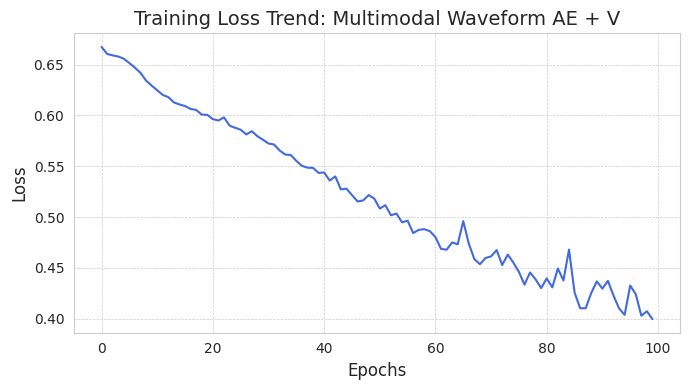

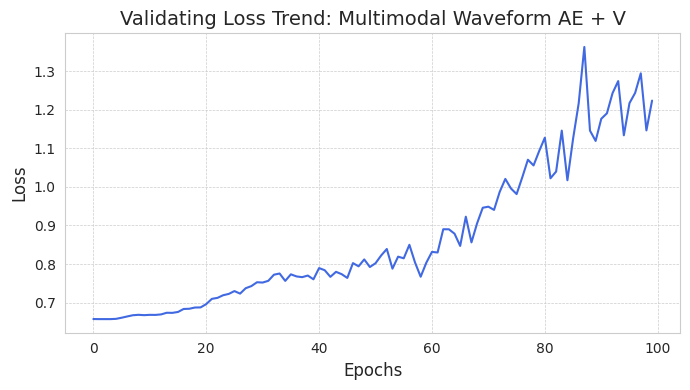

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(train_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Training Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(val_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Validating Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/lstm_multimodal_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Model Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/lstm_multimodal_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if inputs.shape[1]!= labels.shape[1] :
            continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        # print(f'inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)


Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-200-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
len(y_true), len(y_pred)

<ipython-input-213-6e15c587d4e2>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-213-6e15c587d4e2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-213-6e15c587d4e2>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing

(6975, 6975)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true, y_pred_t, average='binary')
    acc = accuracy_score(y_true, y_pred_t)
    prec = precision_score(y_true, y_pred_t)
    rec = recall_score(y_true, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.543465  0.455627   0.409272  0.808587
2        0.10  0.529843  0.466953   0.409740  0.749553
3        0.15  0.518499  0.477563   0.411062  0.701968
4        0.20  0.509638  0.485735   0.412389  0.666905
5        0.25  0.500424  0.493620   0.413801  0.632916
6        0.30  0.479317  0.492903   0.407204  0.582469
7        0.35  0.460078  0.502652   0.407163  0.528801
8        0.40  0.437926  0.527455   0.418377  0.459392
9        0.45  0.401567  0.540215   0.419657  0.384973
10       0.50  0.374674  0.552545   0.425774  0.334526
11       0.55  0.354463  0.563441   0.434964  0.299106
12       0.60  0.331835  0.573907   0.446461  0.264043
13       0.65  0.302930  0.577061   0.446068  0.229338
14       0.70  0.278519  0.581075   0.449402  0.201789
15       0.75  0.244358  0.582366   0.444340  0.168515
16       0.80  0.208955  0.582079   0.432584  0.137746
17       0.85  0.170383  0.583943   0.423898  0.106619
18       0.90  0.133735  0.587670   0.422857  0.079428
19       0.95  0.095778  0.588530   0.401055  0.054383
20       1.00  0.000000  0.599283   0.000000  0.000000

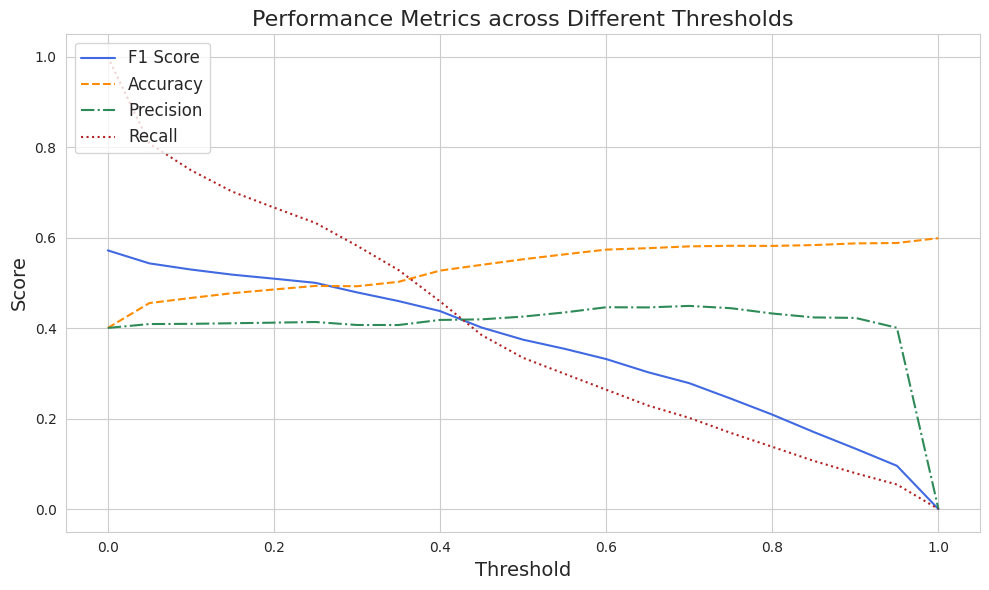

In [ ]:
# plot results


sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()


## 2) 1D CNN Audio Emotion Feature

### Load Video, Audio Highlight Features

In [ ]:
import os

import numpy as np
import pandas as pd
import torch

In [ ]:
concatenate_vit_features = np.load('concatenate_vit_features_array.npy', allow_pickle=True)
concatenate_audio_features = np.load('1dcnn_concatenate_audio_features_array.npy', allow_pickle=True)

labels = np.load('labels.npy', allow_pickle=True)
labels = [l.squeeze() for l in labels]

In [ ]:
print(concatenate_vit_features.shape)
print(concatenate_audio_features.shape)
print(concatenate_vit_features[64].shape)
print(concatenate_audio_features[64].shape)

(151,)
(151,)
(250, 768)
torch.Size([250, 128])


In [ ]:
concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])

<ipython-input-120-ef19289f87aa>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])
<ipython-input-120-ef19289f87aa>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])


In [ ]:
features_concatenate_list = []
cnt = 0
max_seq_len = 896
for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    if len(vit_features) == len(audio_features):
        concated_feature = torch.cat((vit_features, audio_features), dim=1)
    elif len(vit_features) > len(audio_features):
        # Split into columns of size 2
        pad = torch.zeros((len(vit_features)-len(audio_features), 128))
        audio_features = torch.cat((audio_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check1: {concated_feature.shape}')
    elif len(vit_features) < len(audio_features):
        pad = torch.zeros((len(audio_features)-len(vit_features), 768))
        vit_features = torch.cat((vit_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check2: {concated_feature.shape}')
    features_concatenate_list.append(concated_feature)

check2: torch.Size([106, 896])
check2: torch.Size([150, 896])
check2: torch.Size([72, 896])
check2: torch.Size([245, 896])


In [ ]:
len(features_concatenate_list), len(features_concatenate_list[2])

(151, 191)

### Dataset, Dataloader

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])
# Create an instance of dataset
md = MyDataset(features_concatenate_list,labels)
len(md), md[2][0].shape

<ipython-input-124-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([191, 896]))

In [ ]:
len(features_concatenate_list[0]), len(labels[0])

(250, 250)

In [ ]:
#### 인덱스 개수 맞추기
new_features_concatenate_list = []
new_labels = []
for concat, label in zip(features_concatenate_list, labels):
    if len(concat) == len(label):
        new_features_concatenate_list.append(concat)
        new_labels.append(label)
    elif len(concat) > len(label):
        # Split into columns of size 2
        idx = len(label)
        new_concat = concat[0:idx,:]
        new_features_concatenate_list.append(new_concat)
        new_labels.append(label)
        #print(f'check1: {new_concat.shape}, {label.shape}')
    elif len(concat) < len(label):
        idx = len(concat)
        new_label = label[0:idx]
        new_features_concatenate_list.append(concat)
        new_labels.append(new_label)
        #print(f'check2: {concat.shape}, {new_label.shape}')

### Split Train, Val, Test

In [ ]:
md = MyDataset(new_features_concatenate_list,new_labels)
len(md), md[0][0].shape

<ipython-input-124-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([250, 896]))

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Multimodal Highlight Extraction Model

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        output = self.sigmoid(out)

        return output, out

### Model Training

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []
weight_dir = 'model/weight/'

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-124-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])
Epochs:   1%|          | 1/100 [00:06<10:12,  6.19s/it]

epoch [1/100], train_loss: 0.6252140248815219, val_loss: 0.7046846747398376, p: 0.3741935483870968, r: 0.8474885844748858, f: 0.5191608391608391


Epochs:   2%|▏         | 2/100 [00:18<15:50,  9.70s/it]

epoch [2/100], train_loss: 0.5668204455326001, val_loss: 0.7033876776695251, p: 0.3741362290227048, r: 0.865296803652968, f: 0.5223983459682977


Epochs:   3%|▎         | 3/100 [00:27<15:17,  9.46s/it]

epoch [3/100], train_loss: 0.5568346873339679, val_loss: 0.7156212329864502, p: 0.3749259624876604, r: 0.8671232876712329, f: 0.5235010337698139


Epochs:   4%|▍         | 4/100 [00:38<16:06, 10.07s/it]

epoch [4/100], train_loss: 0.5465882873576549, val_loss: 0.731203019618988, p: 0.37495092265410285, r: 0.8721461187214612, f: 0.5244371224601867


Epochs:   5%|▌         | 5/100 [00:46<14:36,  9.23s/it]

epoch [5/100], train_loss: 0.5403283966912164, val_loss: 0.7508179545402527, p: 0.37554412346656113, r: 0.8666666666666667, f: 0.5240198785201546


Epochs:   6%|▌         | 6/100 [00:58<15:49, 10.10s/it]

epoch [6/100], train_loss: 0.5352385927716063, val_loss: 0.7620710730552673, p: 0.3752, r: 0.85662100456621, f: 0.5218358831710709


Epochs:   7%|▋         | 7/100 [01:03<13:10,  8.50s/it]

epoch [7/100], train_loss: 0.5304877013588946, val_loss: 0.7684910297393799, p: 0.3757062146892655, r: 0.8502283105022831, f: 0.521130702490904


Epochs:   8%|▊         | 8/100 [01:09<12:04,  7.87s/it]

epoch [8/100], train_loss: 0.5261389412917197, val_loss: 0.7726342082023621, p: 0.3758348512446873, r: 0.8479452054794521, f: 0.5208245687841818


Epochs:   9%|▉         | 9/100 [01:16<11:22,  7.50s/it]

epoch [9/100], train_loss: 0.5219724441775018, val_loss: 0.7770035862922668, p: 0.3742937853107345, r: 0.8470319634703196, f: 0.519171564511615


Epochs:  10%|█         | 10/100 [01:21<10:07,  6.75s/it]

epoch [10/100], train_loss: 0.517747560614306, val_loss: 0.7821375727653503, p: 0.37359324758842444, r: 0.8488584474885845, f: 0.518838961763885


Epochs:  11%|█         | 11/100 [01:27<09:45,  6.58s/it]

epoch [11/100], train_loss: 0.5134930719724959, val_loss: 0.7897351384162903, p: 0.37366834170854274, r: 0.8488584474885845, f: 0.5189113747383113


Epochs:  12%|█▏        | 12/100 [01:34<09:45,  6.65s/it]

epoch [12/100], train_loss: 0.5095172492683762, val_loss: 0.7947921752929688, p: 0.3724387304138208, r: 0.8465753424657534, f: 0.5172991071428572


Epochs:  13%|█▎        | 13/100 [01:39<09:01,  6.22s/it]

epoch [13/100], train_loss: 0.5053515913378861, val_loss: 0.8068966269493103, p: 0.37132809267687217, r: 0.819634703196347, f: 0.5111047835990888


Epochs:  14%|█▍        | 14/100 [01:47<09:31,  6.65s/it]

epoch [14/100], train_loss: 0.501691737677902, val_loss: 0.8130417466163635, p: 0.3692531724568338, r: 0.8105022831050228, f: 0.5073602972702587


Epochs:  15%|█▌        | 15/100 [01:53<09:10,  6.47s/it]

epoch [15/100], train_loss: 0.5007282212480075, val_loss: 0.7983629703521729, p: 0.37212475633528264, r: 0.871689497716895, f: 0.5215846994535519


Epochs:  16%|█▌        | 16/100 [01:58<08:28,  6.06s/it]

epoch [16/100], train_loss: 0.4988325739124169, val_loss: 0.7985155582427979, p: 0.373372532549349, r: 0.8118721461187215, f: 0.5115074798619103


Epochs:  17%|█▋        | 17/100 [02:05<08:45,  6.34s/it]

epoch [17/100], train_loss: 0.48984864856012994, val_loss: 0.817873477935791, p: 0.37176031515654157, r: 0.8187214611872146, f: 0.5113360901183517


Epochs:  18%|█▊        | 18/100 [02:09<07:39,  5.61s/it]

epoch [18/100], train_loss: 0.49148895445848917, val_loss: 0.7664182782173157, p: 0.3729946524064171, r: 0.8917808219178082, f: 0.5259897656881228


Epochs:  19%|█▉        | 19/100 [02:13<06:49,  5.05s/it]

epoch [19/100], train_loss: 0.48691458333697585, val_loss: 0.765830397605896, p: 0.3737278552581983, r: 0.9054794520547945, f: 0.5290821771611527


Epochs:  20%|██        | 20/100 [02:16<06:06,  4.59s/it]

epoch [20/100], train_loss: 0.48255496172286155, val_loss: 0.7457249760627747, p: 0.37254901960784315, r: 0.867579908675799, f: 0.5212620027434841


Epochs:  21%|██        | 21/100 [02:21<06:01,  4.58s/it]

epoch [21/100], train_loss: 0.4848551143659279, val_loss: 0.7411020994186401, p: 0.3700165349990814, r: 0.919634703196347, f: 0.5277086335647845


Epochs:  22%|██▏       | 22/100 [02:25<05:43,  4.40s/it]

epoch [22/100], train_loss: 0.4875859829002164, val_loss: 0.7405405044555664, p: 0.37616868907897355, r: 0.8634703196347032, f: 0.5240404600249411


Epochs:  23%|██▎       | 23/100 [02:28<05:12,  4.05s/it]

epoch [23/100], train_loss: 0.4892999666393735, val_loss: 0.7807334661483765, p: 0.3729943738278808, r: 0.817351598173516, f: 0.512233509801116


Epochs:  24%|██▍       | 24/100 [02:31<04:52,  3.85s/it]

epoch [24/100], train_loss: 0.47435153304702704, val_loss: 0.8113868236541748, p: 0.36951848667239895, r: 0.7849315068493151, f: 0.5024846536100556


Epochs:  25%|██▌       | 25/100 [02:36<04:56,  3.95s/it]

epoch [25/100], train_loss: 0.4713799553535258, val_loss: 0.8061074018478394, p: 0.37287414965986393, r: 0.8009132420091324, f: 0.5088482738613287


Epochs:  26%|██▌       | 26/100 [02:40<05:04,  4.12s/it]

epoch [26/100], train_loss: 0.4689743043958313, val_loss: 0.7707856893539429, p: 0.37042893852540026, r: 0.8557077625570776, f: 0.5170368326665747


Epochs:  27%|██▋       | 27/100 [02:43<04:44,  3.89s/it]

epoch [27/100], train_loss: 0.47035663364480973, val_loss: 0.7655905485153198, p: 0.37522731865023234, r: 0.8479452054794521, f: 0.5202409301022551


Epochs:  28%|██▊       | 28/100 [02:47<04:28,  3.73s/it]

epoch [28/100], train_loss: 0.4768353345047217, val_loss: 0.7935900092124939, p: 0.37812852311161216, r: 0.7657534246575343, f: 0.5062641509433963


Epochs:  29%|██▉       | 29/100 [02:50<04:23,  3.71s/it]

epoch [29/100], train_loss: 0.4918283826580995, val_loss: 0.835503101348877, p: 0.37427884615384616, r: 0.7109589041095891, f: 0.4903937007874016


Epochs:  30%|███       | 30/100 [02:55<04:39,  4.00s/it]

epoch [30/100], train_loss: 0.4831889260482664, val_loss: 0.8820357322692871, p: 0.37022716288061863, r: 0.6995433789954338, f: 0.484197218710493


Epochs:  31%|███       | 31/100 [02:59<04:36,  4.00s/it]

epoch [31/100], train_loss: 0.4663064165804018, val_loss: 0.8950796723365784, p: 0.36819663907700023, r: 0.6703196347031963, f: 0.4753116399546706


Epochs:  32%|███▏      | 32/100 [03:03<04:19,  3.81s/it]

epoch [32/100], train_loss: 0.45497510839486494, val_loss: 0.8363097310066223, p: 0.3758434547908232, r: 0.763013698630137, f: 0.5036166365280289


Epochs:  33%|███▎      | 33/100 [03:06<04:09,  3.72s/it]

epoch [33/100], train_loss: 0.45864705659591387, val_loss: 0.9128004908561707, p: 0.3692105263157895, r: 0.6406392694063927, f: 0.4684474123539233


Epochs:  34%|███▍      | 34/100 [03:11<04:26,  4.04s/it]

epoch [34/100], train_loss: 0.4467592656172605, val_loss: 0.8407264351844788, p: 0.37748643761301987, r: 0.7625570776255708, f: 0.5049894163894768


Epochs:  35%|███▌      | 35/100 [03:15<04:23,  4.06s/it]

epoch [35/100], train_loss: 0.4432019809739561, val_loss: 0.9109846353530884, p: 0.3743046357615894, r: 0.6452054794520548, f: 0.4737636211232188


Epochs:  36%|███▌      | 36/100 [03:19<04:11,  3.93s/it]

epoch [36/100], train_loss: 0.4443040117375656, val_loss: 0.8638437986373901, p: 0.3828726778432261, r: 0.771689497716895, f: 0.5118110236220472


Epochs:  37%|███▋      | 37/100 [03:22<03:57,  3.76s/it]

epoch [37/100], train_loss: 0.44911592760925284, val_loss: 0.933218777179718, p: 0.3729390211986391, r: 0.6506849315068494, f: 0.47413076027283313


Epochs:  38%|███▊      | 38/100 [03:26<04:01,  3.90s/it]

epoch [38/100], train_loss: 0.4413379232114595, val_loss: 0.9226566553115845, p: 0.3816865218406914, r: 0.7461187214611872, f: 0.5050224076649668


Epochs:  39%|███▉      | 39/100 [03:31<04:09,  4.08s/it]

epoch [39/100], train_loss: 0.42783254918758756, val_loss: 0.9384713768959045, p: 0.381194997684113, r: 0.7515981735159817, f: 0.5058389674247081


Epochs:  40%|████      | 40/100 [03:34<03:57,  3.96s/it]

epoch [40/100], train_loss: 0.43637524329177624, val_loss: 1.0666100978851318, p: 0.3783995815899582, r: 0.6607305936073059, f: 0.48121050881277017


Epochs:  41%|████      | 41/100 [03:38<03:44,  3.81s/it]

epoch [41/100], train_loss: 0.43506156743905094, val_loss: 0.9474027156829834, p: 0.37682441397611677, r: 0.7780821917808219, f: 0.5077473182359952


Epochs:  42%|████▏     | 42/100 [03:42<03:49,  3.96s/it]

epoch [42/100], train_loss: 0.4265323907217761, val_loss: 1.0808857679367065, p: 0.38161483906164756, r: 0.6388127853881278, f: 0.4778005464480874


Epochs:  43%|████▎     | 43/100 [03:47<03:57,  4.16s/it]

epoch [43/100], train_loss: 0.4211178882312702, val_loss: 0.9790922999382019, p: 0.37664697864606994, r: 0.7570776255707763, f: 0.5030339805825242


Epochs:  44%|████▍     | 44/100 [03:50<03:40,  3.94s/it]

epoch [44/100], train_loss: 0.4125395268285906, val_loss: 1.0178875923156738, p: 0.38563423331635255, r: 0.691324200913242, f: 0.4950948332243296


Epochs:  45%|████▌     | 45/100 [03:54<03:30,  3.83s/it]

epoch [45/100], train_loss: 0.4028976283619866, val_loss: 1.027442455291748, p: 0.3769850402761795, r: 0.7479452054794521, f: 0.501300688599847


Epochs:  46%|████▌     | 46/100 [03:58<03:25,  3.81s/it]

epoch [46/100], train_loss: 0.4116189855611689, val_loss: 1.0893880128860474, p: 0.37916768070090046, r: 0.7114155251141553, f: 0.49468169550722335


Epochs:  47%|████▋     | 47/100 [04:02<03:36,  4.09s/it]

epoch [47/100], train_loss: 0.39904973489998763, val_loss: 1.0167293548583984, p: 0.38821611551001395, r: 0.7611872146118721, f: 0.514188772362739


Epochs:  48%|████▊     | 48/100 [04:06<03:26,  3.96s/it]

epoch [48/100], train_loss: 0.399291999599518, val_loss: 1.1841732263565063, p: 0.38133704735376045, r: 0.6251141552511416, f: 0.47370242214532876


Epochs:  49%|████▉     | 49/100 [04:09<03:14,  3.81s/it]

epoch [49/100], train_loss: 0.4091447923735056, val_loss: 1.1252021789550781, p: 0.3828795683100319, r: 0.7127853881278539, f: 0.4981649912238711


Epochs:  50%|█████     | 50/100 [04:13<03:08,  3.78s/it]

epoch [50/100], train_loss: 0.4179447921414976, val_loss: 1.0540201663970947, p: 0.3774895785085688, r: 0.7442922374429224, f: 0.5009219422249539


Epochs:  51%|█████     | 51/100 [04:18<03:19,  4.07s/it]

epoch [51/100], train_loss: 0.404054643824606, val_loss: 1.2081400156021118, p: 0.38425925925925924, r: 0.6442922374429224, f: 0.4814056635960423


Epochs:  52%|█████▏    | 52/100 [04:22<03:13,  4.03s/it]

epoch [52/100], train_loss: 0.39217026709763253, val_loss: 1.1620248556137085, p: 0.3792870036101083, r: 0.7675799086757991, f: 0.5077016007248565


Epochs:  53%|█████▎    | 53/100 [04:25<03:00,  3.85s/it]

epoch [53/100], train_loss: 0.380480359230488, val_loss: 1.173783302307129, p: 0.3755927127526828, r: 0.6872146118721462, f: 0.4857188962401161


Epochs:  54%|█████▍    | 54/100 [04:29<02:52,  3.76s/it]

epoch [54/100], train_loss: 0.3708872126746832, val_loss: 1.2416632175445557, p: 0.38136431043005437, r: 0.7045662100456621, f: 0.49486850545221295


Epochs:  55%|█████▌    | 55/100 [04:34<03:04,  4.09s/it]

epoch [55/100], train_loss: 0.38780305233930346, val_loss: 1.1185481548309326, p: 0.3721843897328444, r: 0.6488584474885845, f: 0.4730359520639148


Epochs:  56%|█████▌    | 56/100 [04:38<03:01,  4.12s/it]

epoch [56/100], train_loss: 0.3700045743772029, val_loss: 1.3112651109695435, p: 0.3798528292311596, r: 0.6835616438356165, f: 0.48833795465666285


Epochs:  57%|█████▋    | 57/100 [04:41<02:49,  3.94s/it]

epoch [57/100], train_loss: 0.3850918076478491, val_loss: 1.2042346000671387, p: 0.3886838868388684, r: 0.7214611872146118, f: 0.5051958433253397


Epochs:  58%|█████▊    | 58/100 [04:45<02:39,  3.79s/it]

epoch [58/100], train_loss: 0.4452938253068068, val_loss: 1.0867810249328613, p: 0.3787770640019034, r: 0.7269406392694064, f: 0.4980447364304708


Epochs:  59%|█████▉    | 59/100 [04:49<02:47,  4.08s/it]

epoch [59/100], train_loss: 0.39195227857465703, val_loss: 1.3131394386291504, p: 0.36908783783783783, r: 0.5986301369863014, f: 0.4566353187042842


Epochs:  60%|██████    | 60/100 [04:54<02:44,  4.12s/it]

epoch [60/100], train_loss: 0.3819496868429673, val_loss: 1.2663053274154663, p: 0.3848082226121835, r: 0.7009132420091324, f: 0.49684414953876027


Epochs:  61%|██████    | 61/100 [04:57<02:35,  3.99s/it]

epoch [61/100], train_loss: 0.3739529601031083, val_loss: 1.4014334678649902, p: 0.3758680555555556, r: 0.5931506849315068, f: 0.46014877789585545


Epochs:  62%|██████▏   | 62/100 [05:01<02:25,  3.83s/it]

epoch [62/100], train_loss: 0.37815477444043305, val_loss: 1.320067286491394, p: 0.3696935619904414, r: 0.6004566210045662, f: 0.45763006786149296


Epochs:  63%|██████▎   | 63/100 [05:05<02:27,  4.00s/it]

epoch [63/100], train_loss: 0.3703070270745229, val_loss: 1.349549412727356, p: 0.387035010940919, r: 0.6461187214611872, f: 0.48409168662333213


Epochs:  64%|██████▍   | 64/100 [05:10<02:31,  4.20s/it]

epoch [64/100], train_loss: 0.3629993110293678, val_loss: 1.331595540046692, p: 0.3895932382461701, r: 0.6735159817351598, f: 0.4936412315930388


Epochs:  65%|██████▌   | 65/100 [05:13<02:18,  3.95s/it]

epoch [65/100], train_loss: 0.35615167806946474, val_loss: 1.3189496994018555, p: 0.3861291096712263, r: 0.734703196347032, f: 0.5062136227780399


Epochs:  66%|██████▌   | 66/100 [05:17<02:10,  3.83s/it]

epoch [66/100], train_loss: 0.372701726287586, val_loss: 1.4354329109191895, p: 0.3795236622332199, r: 0.5602739726027397, f: 0.45251705697953165


Epochs:  67%|██████▋   | 67/100 [05:21<02:05,  3.80s/it]

epoch [67/100], train_loss: 0.386266254193793, val_loss: 1.122007131576538, p: 0.382201203783319, r: 0.8118721461187215, f: 0.5197310727857352


Epochs:  68%|██████▊   | 68/100 [05:25<02:10,  4.08s/it]

epoch [68/100], train_loss: 0.3609251042326731, val_loss: 1.4079084396362305, p: 0.38070020594292436, r: 0.5908675799086758, f: 0.46305242440508143


Epochs:  69%|██████▉   | 69/100 [05:29<02:02,  3.95s/it]

epoch [69/100], train_loss: 0.35484185594925494, val_loss: 1.3271653652191162, p: 0.38304747700720854, r: 0.7036529680365297, f: 0.4960566553999678


Epochs:  70%|███████   | 70/100 [05:33<01:57,  3.93s/it]

epoch [70/100], train_loss: 0.3881806877562566, val_loss: 1.3304922580718994, p: 0.3868748346123313, r: 0.6675799086757991, f: 0.4898642988775339


Epochs:  71%|███████   | 71/100 [05:37<01:55,  3.99s/it]

epoch [71/100], train_loss: 0.36767300453539065, val_loss: 1.353792428970337, p: 0.3852757544224766, r: 0.6762557077625571, f: 0.4908849850845211


Epochs:  72%|███████▏  | 72/100 [05:42<02:01,  4.34s/it]

epoch [72/100], train_loss: 0.33867787966313095, val_loss: 1.424115538597107, p: 0.3910455486542443, r: 0.6899543378995434, f: 0.4991740997687479


Epochs:  73%|███████▎  | 73/100 [05:46<01:50,  4.10s/it]

epoch [73/100], train_loss: 0.3300008118979955, val_loss: 1.4945833683013916, p: 0.3903267973856209, r: 0.6817351598173516, f: 0.49642560266001656


Epochs:  74%|███████▍  | 74/100 [05:49<01:41,  3.90s/it]

epoch [74/100], train_loss: 0.3275719243771922, val_loss: 1.3546428680419922, p: 0.3836796756208819, r: 0.691324200913242, f: 0.49348109517601035


Epochs:  75%|███████▌  | 75/100 [05:53<01:34,  3.78s/it]

epoch [75/100], train_loss: 0.3403911268526119, val_loss: 1.3747187852859497, p: 0.3827930174563591, r: 0.7009132420091324, f: 0.49516129032258055


Epochs:  76%|███████▌  | 76/100 [05:58<01:41,  4.22s/it]

epoch [76/100], train_loss: 0.3397666648627415, val_loss: 1.4649800062179565, p: 0.38736532810969637, r: 0.7223744292237443, f: 0.504303474657316


Epochs:  77%|███████▋  | 77/100 [06:02<01:34,  4.09s/it]

epoch [77/100], train_loss: 0.35475694064775276, val_loss: 1.4969178438186646, p: 0.3854133920150896, r: 0.5598173515981735, f: 0.4565257866319121


Epochs:  78%|███████▊  | 78/100 [06:05<01:26,  3.93s/it]

epoch [78/100], train_loss: 0.3648827907464187, val_loss: 1.4198236465454102, p: 0.380019120458891, r: 0.726027397260274, f: 0.49890178851584566


Epochs:  79%|███████▉  | 79/100 [06:09<01:20,  3.84s/it]

epoch [79/100], train_loss: 0.355351645546034, val_loss: 1.4106104373931885, p: 0.39126807563959953, r: 0.6424657534246575, f: 0.4863463532665054


Epochs:  80%|████████  | 80/100 [06:14<01:25,  4.28s/it]

epoch [80/100], train_loss: 0.3317573584428222, val_loss: 1.4571855068206787, p: 0.38377659574468087, r: 0.6589041095890411, f: 0.48504201680672276


Epochs:  81%|████████  | 81/100 [06:18<01:18,  4.12s/it]

epoch [81/100], train_loss: 0.3222442107852152, val_loss: 1.5821752548217773, p: 0.3874129481557906, r: 0.6858447488584475, f: 0.4951376298005604


Epochs:  82%|████████▏ | 82/100 [06:21<01:11,  3.96s/it]

epoch [82/100], train_loss: 0.32728771487516295, val_loss: 1.570878505706787, p: 0.3883867433579841, r: 0.6474885844748859, f: 0.48553329909262116


Epochs:  83%|████████▎ | 83/100 [06:25<01:04,  3.80s/it]

epoch [83/100], train_loss: 0.32413043521986157, val_loss: 1.5899068117141724, p: 0.38581314878892736, r: 0.7127853881278539, f: 0.5006414368184734


Epochs:  84%|████████▍ | 84/100 [06:29<01:04,  4.01s/it]

epoch [84/100], train_loss: 0.3179822691990113, val_loss: 1.7591159343719482, p: 0.3881856540084388, r: 0.6301369863013698, f: 0.48041775456919056


Epochs:  85%|████████▌ | 85/100 [06:33<01:00,  4.00s/it]

epoch [85/100], train_loss: 0.30931685878216136, val_loss: 1.878982663154602, p: 0.38637028370868676, r: 0.6031963470319635, f: 0.4710287038687823


Epochs:  86%|████████▌ | 86/100 [06:37<00:53,  3.83s/it]

epoch [86/100], train_loss: 0.309496678502137, val_loss: 1.782557725906372, p: 0.3905160390516039, r: 0.639269406392694, f: 0.4848484848484849


Epochs:  87%|████████▋ | 87/100 [06:40<00:48,  3.73s/it]

epoch [87/100], train_loss: 0.3127445310783666, val_loss: 1.739181399345398, p: 0.38557435440783616, r: 0.5931506849315068, f: 0.46735024284943333


Epochs:  88%|████████▊ | 88/100 [06:45<00:47,  3.92s/it]

epoch [88/100], train_loss: 0.3054104015920277, val_loss: 1.7539808750152588, p: 0.38243029984218835, r: 0.6639269406392694, f: 0.48531375166889185


Epochs:  89%|████████▉ | 89/100 [06:49<00:45,  4.13s/it]

epoch [89/100], train_loss: 0.29635635276189937, val_loss: 1.8935925960540771, p: 0.385, r: 0.6328767123287671, f: 0.4787564766839378


Epochs:  90%|█████████ | 90/100 [06:53<00:38,  3.87s/it]

epoch [90/100], train_loss: 0.31490111877991595, val_loss: 1.7098891735076904, p: 0.3831066945606695, r: 0.6689497716894978, f: 0.48719654140339214


Epochs:  91%|█████████ | 91/100 [06:56<00:33,  3.74s/it]

epoch [91/100], train_loss: 0.30683734198843116, val_loss: 2.009134292602539, p: 0.3796397379912664, r: 0.6351598173515982, f: 0.4752306115476597


Epochs:  92%|█████████▏| 92/100 [07:00<00:30,  3.86s/it]

epoch [92/100], train_loss: 0.3017126669496924, val_loss: 1.8120927810668945, p: 0.3890793985755737, r: 0.6735159817351598, f: 0.49322855709747526


Epochs:  93%|█████████▎| 93/100 [07:05<00:28,  4.12s/it]

epoch [93/100], train_loss: 0.34284486016838656, val_loss: 1.5691618919372559, p: 0.39215686274509803, r: 0.7123287671232876, f: 0.5058365758754864


Epochs:  94%|█████████▍| 94/100 [07:08<00:23,  3.94s/it]

epoch [94/100], train_loss: 0.321787603130234, val_loss: 1.7742819786071777, p: 0.38516609392898055, r: 0.6141552511415526, f: 0.47342485040478705


Epochs:  95%|█████████▌| 95/100 [07:12<00:18,  3.79s/it]

epoch [95/100], train_loss: 0.29512596431196064, val_loss: 1.9721763134002686, p: 0.37655601659751037, r: 0.663013698630137, f: 0.4803175653324512


Epochs:  96%|█████████▌| 96/100 [07:15<00:14,  3.74s/it]

epoch [96/100], train_loss: 0.29982602028903277, val_loss: 1.973107933998108, p: 0.38605442176870747, r: 0.7255707762557078, f: 0.5039644782746591


Epochs:  97%|█████████▋| 97/100 [07:20<00:12,  4.06s/it]

epoch [97/100], train_loss: 0.30054672994200093, val_loss: 1.798295497894287, p: 0.3807588075880759, r: 0.6415525114155252, f: 0.47789115646258506


Epochs:  98%|█████████▊| 98/100 [07:24<00:08,  4.04s/it]

epoch [98/100], train_loss: 0.3226654029327316, val_loss: 1.7813867330551147, p: 0.3886292834890966, r: 0.6835616438356165, f: 0.4955312810327706


Epochs:  99%|█████████▉| 99/100 [07:27<00:03,  3.80s/it]

epoch [99/100], train_loss: 0.33145778360208167, val_loss: 1.5753626823425293, p: 0.38807260155574763, r: 0.6150684931506849, f: 0.47588765235824054


Epochs: 100%|██████████| 100/100 [07:31<00:00,  4.52s/it]

epoch [100/100], train_loss: 0.32679080352072054, val_loss: 1.7227942943572998, p: 0.3891891891891892, r: 0.6904109589041096, f: 0.49777777777777776


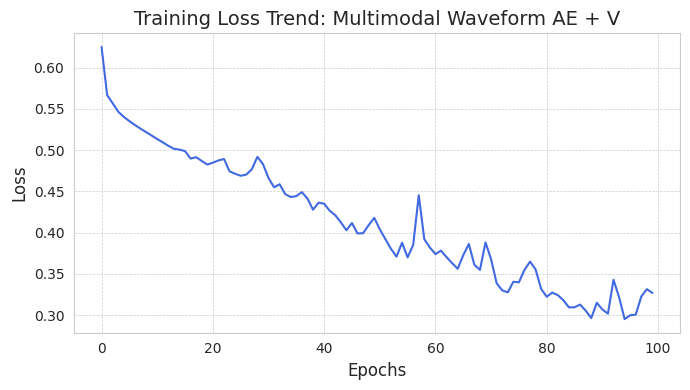

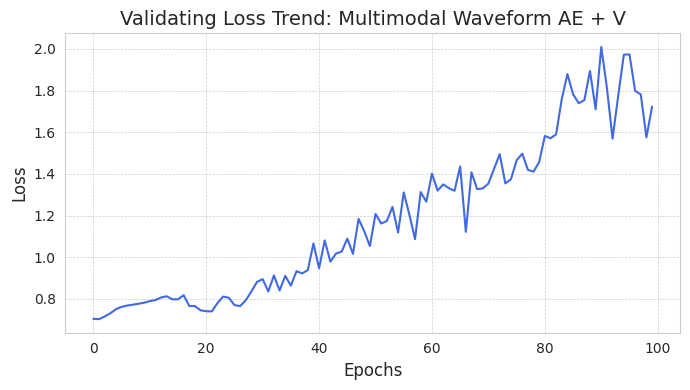

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(train_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Training Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(val_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Validating Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/1dcnn_multimodal_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Model Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/1dcnn_multimodal_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if inputs.shape[1]!= labels.shape[1] :
            continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        # print(f'inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)


Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-124-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
len(y_true), len(y_pred)

<ipython-input-136-6e15c587d4e2>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-136-6e15c587d4e2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-136-6e15c587d4e2>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing

(6975, 6975)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true, y_pred_t, average='binary')
    acc = accuracy_score(y_true, y_pred_t)
    prec = precision_score(y_true, y_pred_t)
    rec = recall_score(y_true, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.543612  0.477133   0.418014  0.777102
2        0.10  0.531555  0.491326   0.421218  0.720215
3        0.15  0.515711  0.496201   0.419413  0.669410
4        0.20  0.505485  0.502366   0.419981  0.634705
5        0.25  0.494249  0.508244   0.420366  0.599642
6        0.30  0.471634  0.505950   0.412664  0.550268
7        0.35  0.452885  0.510538   0.410160  0.505546
8        0.40  0.436485  0.517276   0.410063  0.466547
9        0.45  0.419969  0.523584   0.410020  0.430411
10       0.50  0.405193  0.533620   0.414361  0.396422
11       0.55  0.388253  0.540072   0.415680  0.364222
12       0.60  0.373530  0.549391   0.421692  0.335242
13       0.65  0.347080  0.552832   0.418264  0.296601
14       0.70  0.322015  0.556272   0.415254  0.262970
15       0.75  0.298246  0.564158   0.420299  0.231127
16       0.80  0.275630  0.567455   0.418978  0.205367
17       0.85  0.250810  0.569176   0.413651  0.179964
18       0.90  0.220897  0.569176   0.401130  0.152415
19       0.95  0.183807  0.572186   0.390244  0.120215
20       1.00  0.000000  0.599283   0.000000  0.000000

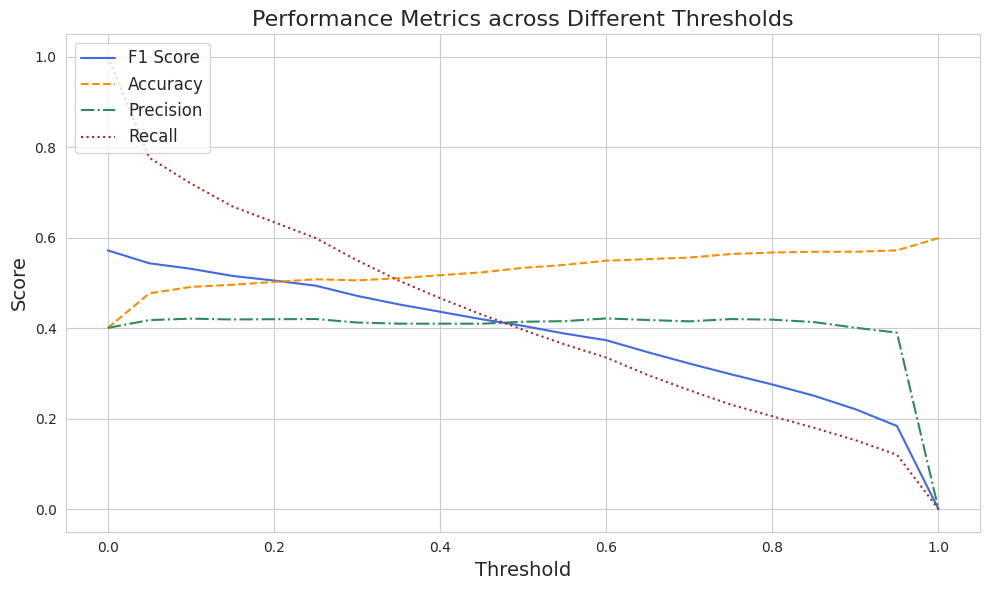

In [ ]:
# plot results


sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()


## 3) LSTM with Attention Audio Emotion Feature

### Load Video, Audio Highlight Features

In [ ]:
import os

import numpy as np
import pandas as pd
import torch

In [ ]:
concatenate_vit_features = np.load('concatenate_vit_features_array.npy', allow_pickle=True)
concatenate_audio_features = np.load('lstm_attention_concatenate_audio_features_array.npy', allow_pickle=True)

labels = np.load('labels.npy', allow_pickle=True)
labels = [l.squeeze() for l in labels]

In [ ]:
print(concatenate_vit_features.shape)
print(concatenate_audio_features.shape)
print(concatenate_vit_features[64].shape)
print(concatenate_audio_features[64].shape)

(151,)
(151,)
(250, 768)
torch.Size([250, 128])


In [ ]:
concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])

<ipython-input-219-ef19289f87aa>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])
<ipython-input-219-ef19289f87aa>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])


In [ ]:
features_concatenate_list = []
cnt = 0
max_seq_len = 896
for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    if len(vit_features) == len(audio_features):
        concated_feature = torch.cat((vit_features, audio_features), dim=1)
    elif len(vit_features) > len(audio_features):
        # Split into columns of size 2
        pad = torch.zeros((len(vit_features)-len(audio_features), 128))
        audio_features = torch.cat((audio_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check1: {concated_feature.shape}')
    elif len(vit_features) < len(audio_features):
        pad = torch.zeros((len(audio_features)-len(vit_features), 768))
        vit_features = torch.cat((vit_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check2: {concated_feature.shape}')
    features_concatenate_list.append(concated_feature)

check2: torch.Size([106, 896])
check2: torch.Size([150, 896])
check2: torch.Size([72, 896])
check2: torch.Size([245, 896])


In [ ]:
len(features_concatenate_list), len(features_concatenate_list[2])

(151, 191)

### Dataset, Dataloader

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])
# Create an instance of dataset
md = MyDataset(features_concatenate_list,labels)
len(md), md[2][0].shape

<ipython-input-225-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([191, 896]))

In [ ]:
len(features_concatenate_list[0]), len(labels[0])

(250, 250)

In [ ]:
#### 인덱스 개수 맞추기
new_features_concatenate_list = []
new_labels = []
for concat, label in zip(features_concatenate_list, labels):
    if len(concat) == len(label):
        new_features_concatenate_list.append(concat)
        new_labels.append(label)
    elif len(concat) > len(label):
        # Split into columns of size 2
        idx = len(label)
        new_concat = concat[0:idx,:]
        new_features_concatenate_list.append(new_concat)
        new_labels.append(label)
        #print(f'check1: {new_concat.shape}, {label.shape}')
    elif len(concat) < len(label):
        idx = len(concat)
        new_label = label[0:idx]
        new_features_concatenate_list.append(concat)
        new_labels.append(new_label)
        #print(f'check2: {concat.shape}, {new_label.shape}')

### Split Train, Val, Test

In [ ]:
md = MyDataset(new_features_concatenate_list,new_labels)
len(md), md[0][0].shape

<ipython-input-225-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([250, 896]))

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Multimodal Highlight Extraction Model

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        output = self.sigmoid(out)

        return output, out

### Model Training

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []
weight_dir = 'model/weight/'

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-225-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])
Epochs:   1%|          | 1/100 [00:05<09:52,  5.98s/it]

epoch [1/100], train_loss: 0.6672066066000196, val_loss: 0.65751051902771, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:14<12:10,  7.46s/it]

epoch [2/100], train_loss: 0.6606474773751365, val_loss: 0.6572866439819336, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:19<10:23,  6.43s/it]

epoch [3/100], train_loss: 0.6593639665179782, val_loss: 0.6573235988616943, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:25<10:00,  6.26s/it]

epoch [4/100], train_loss: 0.6579869078265296, val_loss: 0.6572710275650024, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:33<10:33,  6.66s/it]

epoch [5/100], train_loss: 0.6564001116487715, val_loss: 0.6577470302581787, p: 0, r: 0, f: 0


Epochs:   6%|▌         | 6/100 [00:38<09:39,  6.16s/it]

epoch [6/100], train_loss: 0.6517125404543347, val_loss: 0.6597172617912292, p: 0, r: 0, f: 0


Epochs:   7%|▋         | 7/100 [00:44<09:46,  6.30s/it]

epoch [7/100], train_loss: 0.6476770722203784, val_loss: 0.662943959236145, p: 0, r: 0, f: 0


Epochs:   8%|▊         | 8/100 [00:52<10:25,  6.80s/it]

epoch [8/100], train_loss: 0.6434295703967412, val_loss: 0.6692668795585632, p: 0.3664250800606776, r: 0.9926940639269406, f: 0.5352702203619353


Epochs:   9%|▉         | 9/100 [00:56<08:47,  5.80s/it]

epoch [9/100], train_loss: 0.6366596231857936, val_loss: 0.6727469563484192, p: 0.37118055555555557, r: 0.9762557077625571, f: 0.5378616352201258


Epochs:  10%|█         | 10/100 [00:59<07:33,  5.04s/it]

epoch [10/100], train_loss: 0.6317822416623433, val_loss: 0.670555055141449, p: 0.3725249693359033, r: 0.9707762557077626, f: 0.5384323160693936


Epochs:  11%|█         | 11/100 [01:04<07:27,  5.03s/it]

epoch [11/100], train_loss: 0.6262259647250176, val_loss: 0.6710221767425537, p: 0.3727623727623728, r: 0.9698630136986301, f: 0.5385395537525355


Epochs:  12%|█▏        | 12/100 [01:08<06:52,  4.69s/it]

epoch [12/100], train_loss: 0.6226672060787678, val_loss: 0.669676661491394, p: 0.37088629636078707, r: 0.9726027397260274, f: 0.5369973528299509


Epochs:  13%|█▎        | 13/100 [01:11<06:12,  4.28s/it]

epoch [13/100], train_loss: 0.6197666056040261, val_loss: 0.6679258346557617, p: 0.3688637143837968, r: 0.9812785388127854, f: 0.5361776447105788


Epochs:  14%|█▍        | 14/100 [01:15<05:45,  4.01s/it]

epoch [14/100], train_loss: 0.6159855585545302, val_loss: 0.6701521277427673, p: 0.36800951895291517, r: 0.9885844748858448, f: 0.5363557537470581


Epochs:  15%|█▌        | 15/100 [01:19<05:57,  4.20s/it]

epoch [15/100], train_loss: 0.6127488955855369, val_loss: 0.6750297546386719, p: 0.3676320272572402, r: 0.9853881278538813, f: 0.5354838709677419


Epochs:  16%|█▌        | 16/100 [01:24<05:55,  4.24s/it]

epoch [16/100], train_loss: 0.6095863460873564, val_loss: 0.6747906804084778, p: 0.3676644681210891, r: 0.9926940639269406, f: 0.5365913859064543


Epochs:  17%|█▋        | 17/100 [01:27<05:30,  3.98s/it]

epoch [17/100], train_loss: 0.6072868249068658, val_loss: 0.676649272441864, p: 0.3674607197161683, r: 0.9931506849315068, f: 0.536440991490936


Epochs:  18%|█▊        | 18/100 [01:31<05:13,  3.82s/it]

epoch [18/100], train_loss: 0.6041197281330823, val_loss: 0.6824337840080261, p: 0.3679485007623242, r: 0.9917808219178083, f: 0.5367601631039169


Epochs:  19%|█▉        | 19/100 [01:35<05:20,  3.96s/it]

epoch [19/100], train_loss: 0.6024510611262587, val_loss: 0.6863670349121094, p: 0.3670096137628605, r: 0.993607305936073, f: 0.5360266042616086


Epochs:  20%|██        | 20/100 [01:40<05:33,  4.17s/it]

epoch [20/100], train_loss: 0.5981510542954008, val_loss: 0.6920566558837891, p: 0.3687628161312372, r: 0.9853881278538813, f: 0.5366824173091271


Epochs:  21%|██        | 21/100 [01:43<05:11,  3.94s/it]

epoch [21/100], train_loss: 0.5973162502774761, val_loss: 0.6962227821350098, p: 0.3675434072545986, r: 0.9762557077625571, f: 0.5340327213688023


Epochs:  22%|██▏       | 22/100 [01:46<04:54,  3.78s/it]

epoch [22/100], train_loss: 0.5944300410855148, val_loss: 0.7091594338417053, p: 0.3658113730929265, r: 0.9634703196347032, f: 0.5302839909525007


Epochs:  23%|██▎       | 23/100 [01:50<04:52,  3.81s/it]

epoch [23/100], train_loss: 0.5945032401010394, val_loss: 0.706088662147522, p: 0.3668098818474758, r: 0.9356164383561644, f: 0.5270061728395061


Epochs:  24%|██▍       | 24/100 [01:55<05:15,  4.15s/it]

epoch [24/100], train_loss: 0.5923533903434872, val_loss: 0.7053341865539551, p: 0.36684640807096885, r: 0.963013698630137, f: 0.5313011714321703


Epochs:  25%|██▌       | 25/100 [01:59<04:54,  3.93s/it]

epoch [25/100], train_loss: 0.5915409176817371, val_loss: 0.710237443447113, p: 0.3654561558901683, r: 0.9420091324200913, f: 0.5266113592852585


Epochs:  26%|██▌       | 26/100 [02:02<04:38,  3.76s/it]

epoch [26/100], train_loss: 0.5886138521652254, val_loss: 0.7109593749046326, p: 0.365814696485623, r: 0.9410958904109589, f: 0.526840490797546


Epochs:  27%|██▋       | 27/100 [02:05<04:26,  3.65s/it]

epoch [27/100], train_loss: 0.5838493242238959, val_loss: 0.7171931266784668, p: 0.36527050610820244, r: 0.9557077625570777, f: 0.5285353535353536


Epochs:  28%|██▊       | 28/100 [02:10<04:50,  4.03s/it]

epoch [28/100], train_loss: 0.5806339564060585, val_loss: 0.7277995347976685, p: 0.3646780647508185, r: 0.9155251141552512, f: 0.5215920915712798


Epochs:  29%|██▉       | 29/100 [02:14<04:43,  3.99s/it]

epoch [29/100], train_loss: 0.5843739118168337, val_loss: 0.7286205887794495, p: 0.3636525771357232, r: 0.9310502283105023, f: 0.5230216750032064


Epochs:  30%|███       | 30/100 [02:18<04:26,  3.81s/it]

epoch [30/100], train_loss: 0.5782235701775386, val_loss: 0.7330131530761719, p: 0.3669433162634646, r: 0.9488584474885845, f: 0.5292245001910099


Epochs:  31%|███       | 31/100 [02:21<04:13,  3.68s/it]

epoch [31/100], train_loss: 0.5722589893163078, val_loss: 0.7430083751678467, p: 0.3662558898151504, r: 0.9228310502283105, f: 0.524390243902439


Epochs:  32%|███▏      | 32/100 [02:25<04:26,  3.92s/it]

epoch [32/100], train_loss: 0.5695212925034058, val_loss: 0.73842853307724, p: 0.3638999637549837, r: 0.9168949771689497, f: 0.5210171250648676


Epochs:  33%|███▎      | 33/100 [02:30<04:31,  4.05s/it]

epoch [33/100], train_loss: 0.5703440492688161, val_loss: 0.7405513525009155, p: 0.36758532578937764, r: 0.919634703196347, f: 0.5252314512974312


Epochs:  34%|███▍      | 34/100 [02:33<04:14,  3.85s/it]

epoch [34/100], train_loss: 0.5645688948143894, val_loss: 0.7511287331581116, p: 0.3681379821958457, r: 0.906392694063927, f: 0.5236085465576366


Epochs:  35%|███▌      | 35/100 [02:36<04:00,  3.70s/it]

epoch [35/100], train_loss: 0.5604237539046961, val_loss: 0.7444611191749573, p: 0.3638257575757576, r: 0.8771689497716895, f: 0.5143239625167336


Epochs:  36%|███▌      | 36/100 [02:40<04:02,  3.79s/it]

epoch [36/100], train_loss: 0.5656245989931954, val_loss: 0.7590861916542053, p: 0.36394493682821044, r: 0.8812785388127854, f: 0.515147470972908


Epochs:  37%|███▋      | 37/100 [02:45<04:18,  4.11s/it]

epoch [37/100], train_loss: 0.5553673635133438, val_loss: 0.7602390050888062, p: 0.3667700164143717, r: 0.9182648401826484, f: 0.5241756809592076


Epochs:  38%|███▊      | 38/100 [02:49<04:00,  3.88s/it]

epoch [38/100], train_loss: 0.5521922868327238, val_loss: 0.755900502204895, p: 0.35855393125246937, r: 0.8287671232876712, f: 0.5005515719801433


Epochs:  39%|███▉      | 39/100 [02:52<03:47,  3.74s/it]

epoch [39/100], train_loss: 0.5683067983042241, val_loss: 0.7404038906097412, p: 0.3663685152057245, r: 0.9351598173515981, f: 0.526478149100257


Epochs:  40%|████      | 40/100 [02:56<03:40,  3.68s/it]

epoch [40/100], train_loss: 0.5514044136533307, val_loss: 0.7606591582298279, p: 0.36849507735583686, r: 0.9570776255707762, f: 0.5321147499365321


Epochs:  41%|████      | 41/100 [03:01<03:59,  4.07s/it]

epoch [41/100], train_loss: 0.5451583832825742, val_loss: 0.7865571975708008, p: 0.3651923076923077, r: 0.8671232876712329, f: 0.513937753721245


Epochs:  42%|████▏     | 42/100 [03:04<03:48,  3.94s/it]

epoch [42/100], train_loss: 0.5345449017218521, val_loss: 0.8108585476875305, p: 0.3590414820781313, r: 0.8141552511415525, f: 0.4983230855226384


Epochs:  43%|████▎     | 43/100 [03:08<03:34,  3.76s/it]

epoch [43/100], train_loss: 0.5445106593109409, val_loss: 0.7574207186698914, p: 0.36980507539536595, r: 0.9182648401826484, f: 0.5272679601468274


Epochs:  44%|████▍     | 44/100 [03:11<03:23,  3.63s/it]

epoch [44/100], train_loss: 0.5328953786145172, val_loss: 0.7942659258842468, p: 0.36239453595821614, r: 0.8237442922374429, f: 0.5033482142857143


Epochs:  45%|████▌     | 45/100 [03:16<03:37,  3.96s/it]

epoch [45/100], train_loss: 0.5338187842312941, val_loss: 0.7746371626853943, p: 0.37139605462822456, r: 0.8940639269406393, f: 0.5247922808898419


Epochs:  46%|████▌     | 46/100 [03:20<03:37,  4.02s/it]

epoch [46/100], train_loss: 0.5203865348904704, val_loss: 0.809929609298706, p: 0.35965090318652326, r: 0.8091324200913242, f: 0.4979626247014192


Epochs:  47%|████▋     | 47/100 [03:23<03:22,  3.82s/it]

epoch [47/100], train_loss: 0.5209510376259762, val_loss: 0.7536447048187256, p: 0.36946773250146225, r: 0.865296803652968, f: 0.5178303046864324


Epochs:  48%|████▊     | 48/100 [03:26<03:10,  3.67s/it]

epoch [48/100], train_loss: 0.5152667010131862, val_loss: 0.8007071614265442, p: 0.3646153846153846, r: 0.7575342465753425, f: 0.49228486646884273


Epochs:  49%|████▉     | 49/100 [03:31<03:15,  3.84s/it]

epoch [49/100], train_loss: 0.5471072638607842, val_loss: 0.748677134513855, p: 0.36911874533233757, r: 0.9027397260273973, f: 0.523986217863769


Epochs:  50%|█████     | 50/100 [03:35<03:23,  4.07s/it]

epoch [50/100], train_loss: 0.5158549822152256, val_loss: 0.8060451149940491, p: 0.37145224777294383, r: 0.8187214611872146, f: 0.5110446059569617


Epochs:  51%|█████     | 51/100 [03:39<03:08,  3.85s/it]

epoch [51/100], train_loss: 0.5115395795185275, val_loss: 0.8229294419288635, p: 0.3626666666666667, r: 0.8073059360730593, f: 0.5004953998584571


Epochs:  52%|█████▏    | 52/100 [03:42<02:57,  3.70s/it]

epoch [52/100], train_loss: 0.5099890871426194, val_loss: 0.8315293788909912, p: 0.3671615333481055, r: 0.7566210045662101, f: 0.4944054900790691


Epochs:  53%|█████▎    | 53/100 [03:46<02:54,  3.72s/it]

epoch [53/100], train_loss: 0.5010010461290626, val_loss: 0.8179358243942261, p: 0.36678507992895204, r: 0.754337899543379, f: 0.49357633701822534


Epochs:  54%|█████▍    | 54/100 [03:51<03:07,  4.09s/it]

epoch [54/100], train_loss: 0.49776118979530615, val_loss: 0.8771201968193054, p: 0.37153753512645527, r: 0.8452054794520548, f: 0.5161740100390407


Epochs:  55%|█████▌    | 55/100 [03:54<02:56,  3.91s/it]

epoch [55/100], train_loss: 0.49426343304415543, val_loss: 0.8496294021606445, p: 0.36274274754255575, r: 0.6908675799086758, f: 0.4757113661373998


Epochs:  56%|█████▌    | 56/100 [03:58<02:45,  3.75s/it]

epoch [56/100], train_loss: 0.49840839828539174, val_loss: 0.8409677743911743, p: 0.37170263788968827, r: 0.8493150684931506, f: 0.5170975813177648


Epochs:  57%|█████▋    | 57/100 [04:01<02:36,  3.63s/it]

epoch [57/100], train_loss: 0.4903077552287464, val_loss: 0.9459115862846375, p: 0.3705386112913692, r: 0.7821917808219178, f: 0.5028621752531923


Epochs:  58%|█████▊    | 58/100 [04:06<02:47,  3.99s/it]

epoch [58/100], train_loss: 0.48750572950181476, val_loss: 0.8706480264663696, p: 0.3582169709989259, r: 0.6091324200913242, f: 0.4511329049712547


Epochs:  59%|█████▉    | 59/100 [04:10<02:43,  3.99s/it]

epoch [59/100], train_loss: 0.4863071132538607, val_loss: 0.9094283580780029, p: 0.37366395895681914, r: 0.7981735159817351, f: 0.5090273733255679


Epochs:  60%|██████    | 60/100 [04:13<02:31,  3.80s/it]

epoch [60/100], train_loss: 0.4731220833320145, val_loss: 0.9222473502159119, p: 0.36878489763360806, r: 0.6333333333333333, f: 0.4661401445135271


Epochs:  61%|██████    | 61/100 [04:16<02:22,  3.66s/it]

epoch [61/100], train_loss: 0.46884301724235733, val_loss: 0.9634491801261902, p: 0.3671970624235006, r: 0.684931506849315, f: 0.47808764940239035


Epochs:  62%|██████▏   | 62/100 [04:21<02:26,  3.87s/it]

epoch [62/100], train_loss: 0.48547264611972624, val_loss: 0.9415116310119629, p: 0.3768718801996672, r: 0.8273972602739726, f: 0.5178622463561017


Epochs:  63%|██████▎   | 63/100 [04:25<02:30,  4.07s/it]

epoch [63/100], train_loss: 0.4807464722917454, val_loss: 0.9581272006034851, p: 0.3622860020140987, r: 0.6570776255707762, f: 0.46705615060045436


Epochs:  64%|██████▍   | 64/100 [04:29<02:18,  3.84s/it]

epoch [64/100], train_loss: 0.4715121579309602, val_loss: 0.9633371233940125, p: 0.37401322807766163, r: 0.8004566210045662, f: 0.5098153264504871


Epochs:  65%|██████▌   | 65/100 [04:32<02:09,  3.70s/it]

epoch [65/100], train_loss: 0.4629018430391928, val_loss: 1.0000717639923096, p: 0.3636606903933637, r: 0.6205479452054794, f: 0.4585793824869242


Epochs:  66%|██████▌   | 66/100 [04:36<02:07,  3.75s/it]

epoch [66/100], train_loss: 0.4713683497867249, val_loss: 0.9625939130783081, p: 0.3752140410958904, r: 0.8004566210045662, f: 0.510929758088021


Epochs:  67%|██████▋   | 67/100 [04:41<02:15,  4.10s/it]

epoch [67/100], train_loss: 0.45629722203011625, val_loss: 1.0086746215820312, p: 0.36341397118782276, r: 0.6105022831050229, f: 0.4556142443346396


Epochs:  68%|██████▊   | 68/100 [04:44<02:03,  3.87s/it]

epoch [68/100], train_loss: 0.46781507893829255, val_loss: 0.966895580291748, p: 0.376216426625146, r: 0.882648401826484, f: 0.5275655021834061


Epochs:  69%|██████▉   | 69/100 [04:48<01:55,  3.72s/it]

epoch [69/100], train_loss: 0.44828202922144555, val_loss: 1.0035619735717773, p: 0.36344969199178645, r: 0.5657534246575342, f: 0.44257903196999465


Epochs:  70%|███████   | 70/100 [04:51<01:49,  3.65s/it]

epoch [70/100], train_loss: 0.44824981925291163, val_loss: 1.085397481918335, p: 0.37537125885309575, r: 0.7502283105022831, f: 0.5003806913354651


Epochs:  71%|███████   | 71/100 [04:56<01:57,  4.06s/it]

epoch [71/100], train_loss: 0.46348675674695794, val_loss: 1.0129457712173462, p: 0.37674650698602796, r: 0.6894977168949772, f: 0.4872539528880285


Epochs:  72%|███████▏  | 72/100 [05:00<01:51,  3.99s/it]

epoch [72/100], train_loss: 0.4496527901404382, val_loss: 1.0543599128723145, p: 0.36798119613476105, r: 0.64337899543379, f: 0.46818408373483966


Epochs:  73%|███████▎  | 73/100 [05:03<01:42,  3.81s/it]

epoch [73/100], train_loss: 0.44765509938305414, val_loss: 1.0709500312805176, p: 0.3781866548437154, r: 0.7789954337899543, f: 0.5091777346664678


Epochs:  74%|███████▍  | 74/100 [05:07<01:35,  3.68s/it]

epoch [74/100], train_loss: 0.44051715670963554, val_loss: 1.029854416847229, p: 0.3596849474912485, r: 0.563013698630137, f: 0.4389462442150231


Epochs:  75%|███████▌  | 75/100 [05:11<01:38,  3.96s/it]

epoch [75/100], train_loss: 0.4451490094447864, val_loss: 1.017511010169983, p: 0.376139188069594, r: 0.8292237442922374, f: 0.5175263607865489


Epochs:  76%|███████▌  | 76/100 [05:15<01:37,  4.05s/it]

epoch [76/100], train_loss: 0.4368350804643544, val_loss: 1.0773532390594482, p: 0.3698587127158556, r: 0.5378995433789955, f: 0.43832558139534883


Epochs:  77%|███████▋  | 77/100 [05:19<01:28,  3.85s/it]

epoch [77/100], train_loss: 0.45175831875652267, val_loss: 1.0586915016174316, p: 0.37383828996282525, r: 0.734703196347032, f: 0.4955343393902063


Epochs:  78%|███████▊  | 78/100 [05:22<01:21,  3.71s/it]

epoch [78/100], train_loss: 0.42215610258568226, val_loss: 1.186919927597046, p: 0.3701582105837425, r: 0.6196347031963471, f: 0.46345628415300544


Epochs:  79%|███████▉  | 79/100 [05:26<01:20,  3.84s/it]

epoch [79/100], train_loss: 0.42573446054892783, val_loss: 1.124403715133667, p: 0.36903765690376567, r: 0.6041095890410959, f: 0.4581818181818182


Epochs:  80%|████████  | 80/100 [05:31<01:21,  4.09s/it]

epoch [80/100], train_loss: 0.4273328339414648, val_loss: 1.1721932888031006, p: 0.3760626398210291, r: 0.7675799086757991, f: 0.5048048048048048


Epochs:  81%|████████  | 81/100 [05:34<01:13,  3.88s/it]

epoch [81/100], train_loss: 0.4282371623852669, val_loss: 1.0721489191055298, p: 0.37226450999048527, r: 0.7146118721461188, f: 0.48952142633719115


Epochs:  82%|████████▏ | 82/100 [05:38<01:07,  3.73s/it]

epoch [82/100], train_loss: 0.43659389041802366, val_loss: 1.0804373025894165, p: 0.3583098591549296, r: 0.5808219178082191, f: 0.44320557491289203


Epochs:  83%|████████▎ | 83/100 [05:42<01:03,  3.72s/it]

epoch [83/100], train_loss: 0.4217399021324834, val_loss: 1.1264077425003052, p: 0.3763829306841273, r: 0.7611872146118721, f: 0.503701465478169


Epochs:  84%|████████▍ | 84/100 [05:46<01:05,  4.09s/it]

epoch [84/100], train_loss: 0.4071723768166218, val_loss: 1.1739603281021118, p: 0.37432744043043814, r: 0.6671232876712329, f: 0.47956671590349587


Epochs:  85%|████████▌ | 85/100 [05:50<00:58,  3.91s/it]

epoch [85/100], train_loss: 0.4120526629387718, val_loss: 1.1905688047409058, p: 0.37048765041165294, r: 0.5342465753424658, f: 0.43754674644727004


Epochs:  86%|████████▌ | 86/100 [05:53<00:52,  3.75s/it]

epoch [86/100], train_loss: 0.41280923782538187, val_loss: 1.1850905418395996, p: 0.3781912591951536, r: 0.7981735159817351, f: 0.5132119788608338


Epochs:  87%|████████▋ | 87/100 [05:57<00:47,  3.63s/it]

epoch [87/100], train_loss: 0.42364489142043266, val_loss: 1.1266578435897827, p: 0.3676080135167753, r: 0.6954337899543379, f: 0.48097268277277744


Epochs:  88%|████████▊ | 88/100 [06:02<00:48,  4.01s/it]

epoch [88/100], train_loss: 0.41476452382699386, val_loss: 1.2389178276062012, p: 0.3788866599799398, r: 0.6899543378995434, f: 0.4891550663645193


Epochs:  89%|████████▉ | 89/100 [06:06<00:43,  4.00s/it]

epoch [89/100], train_loss: 0.40938499926042926, val_loss: 1.2807316780090332, p: 0.3765875207067918, r: 0.6228310502283105, f: 0.4693737095664143


Epochs:  90%|█████████ | 90/100 [06:09<00:38,  3.81s/it]

epoch [90/100], train_loss: 0.4034793552004784, val_loss: 1.2907612323760986, p: 0.36905322656617995, r: 0.7155251141552511, f: 0.4869484151646985


Epochs:  91%|█████████ | 91/100 [06:12<00:33,  3.67s/it]

epoch [91/100], train_loss: 0.4010401659600676, val_loss: 1.2304457426071167, p: 0.3716975402368661, r: 0.5589041095890411, f: 0.44647091008571954


Epochs:  92%|█████████▏| 92/100 [06:17<00:31,  3.90s/it]

epoch [92/100], train_loss: 0.4079506785443098, val_loss: 1.3311691284179688, p: 0.3702280912364946, r: 0.7041095890410959, f: 0.4852871754523996


Epochs:  93%|█████████▎| 93/100 [06:21<00:28,  4.07s/it]

epoch [93/100], train_loss: 0.38611189844727456, val_loss: 1.3364719152450562, p: 0.3750374139479198, r: 0.5721461187214611, f: 0.453082625203399


Epochs:  94%|█████████▍| 94/100 [06:25<00:23,  3.85s/it]

epoch [94/100], train_loss: 0.3947892740755277, val_loss: 1.3944569826126099, p: 0.3730932733183296, r: 0.6812785388127854, f: 0.48214574244627567


Epochs:  95%|█████████▌| 95/100 [06:28<00:18,  3.70s/it]

epoch [95/100], train_loss: 0.403409048607864, val_loss: 1.2102805376052856, p: 0.3727346497159859, r: 0.6292237442922375, f: 0.46815016137251564


Epochs:  96%|█████████▌| 96/100 [06:32<00:15,  3.78s/it]

epoch [96/100], train_loss: 0.3876053092094177, val_loss: 1.3904527425765991, p: 0.37289915966386555, r: 0.6484018264840182, f: 0.47349116372124034


Epochs:  97%|█████████▋| 97/100 [06:37<00:12,  4.13s/it]

epoch [97/100], train_loss: 0.38666387477417935, val_loss: 1.3981828689575195, p: 0.37788274520700194, r: 0.6210045662100456, f: 0.4698566246329245


Epochs:  98%|█████████▊| 98/100 [06:40<00:07,  3.88s/it]

epoch [98/100], train_loss: 0.3769567384249361, val_loss: 1.3700343370437622, p: 0.3671526331448974, r: 0.5634703196347032, f: 0.4446045757521167


Epochs:  99%|█████████▉| 99/100 [06:43<00:03,  3.72s/it]

epoch [99/100], train_loss: 0.393141656706454, val_loss: 1.3353543281555176, p: 0.37405770730439303, r: 0.6570776255707762, f: 0.476726851084976


Epochs: 100%|██████████| 100/100 [06:47<00:00,  4.07s/it]

epoch [100/100], train_loss: 0.3916426332249102, val_loss: 1.317825198173523, p: 0.37228123419322207, r: 0.6721461187214612, f: 0.47916666666666674


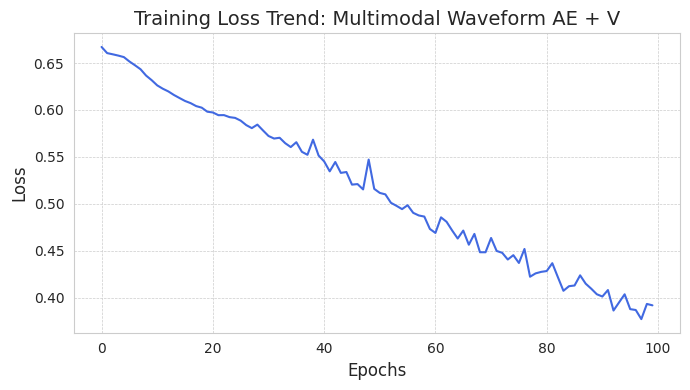

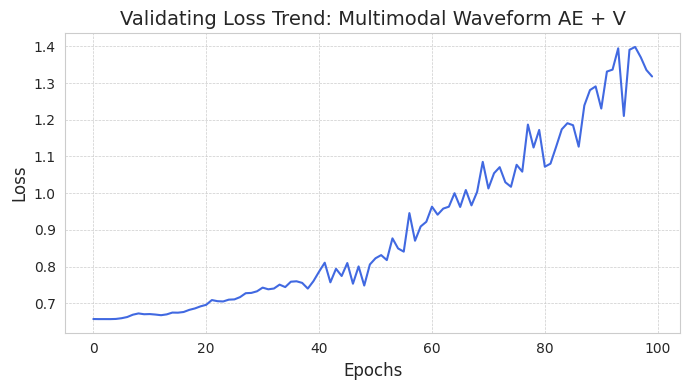

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(train_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Training Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


plt.figure(figsize=(7,4))  # 크기를 조절하여 더 깔끔하게 보이게 합니다.
plt.plot(val_loss, color='royalblue')  # royalblue는 전문적이면서도 보기 좋은 파란색입니다.
plt.title("Validating Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)  # x축 라벨 추가
plt.ylabel("Loss", fontsize=12)  # y축 라벨 추가
plt.grid(True, which="both", linestyle='--', linewidth=0.5)  # 그리드 추가
plt.tight_layout()  # 레이아웃 최적화
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/lstm_attention_multimodal_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Model Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/lstm_attention_multimodal_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if inputs.shape[1]!= labels.shape[1] :
            continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        # print(f'inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)


Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-225-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
len(y_true), len(y_pred)

<ipython-input-239-6e15c587d4e2>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-239-6e15c587d4e2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-239-6e15c587d4e2>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing

(6975, 6975)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true, y_pred_t, average='binary')
    acc = accuracy_score(y_true, y_pred_t)
    prec = precision_score(y_true, y_pred_t)
    rec = recall_score(y_true, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.537720  0.450036   0.405415  0.798211
2        0.10  0.526356  0.462796   0.406959  0.744902
3        0.15  0.503827  0.460932   0.399122  0.683005
4        0.20  0.486531  0.467097   0.396265  0.630054
5        0.25  0.465916  0.469821   0.390651  0.577102
6        0.30  0.450257  0.478710   0.389893  0.532737
7        0.35  0.441120  0.496487   0.397248  0.495886
8        0.40  0.432107  0.513118   0.405651  0.462254
9        0.45  0.417370  0.524875   0.410301  0.424687
10       0.50  0.405035  0.539211   0.419639  0.391413
11       0.55  0.387272  0.547240   0.423061  0.357066
12       0.60  0.366111  0.552688   0.423601  0.322361
13       0.65  0.325766  0.561434   0.424225  0.264401
14       0.70  0.265512  0.562151   0.404989  0.197496
15       0.75  0.236630  0.566165   0.401198  0.167800
16       0.80  0.205277  0.568172   0.390955  0.139177
17       0.85  0.182663  0.571470   0.387471  0.119499
18       0.90  0.150814  0.573763   0.373938  0.094454
19       0.95  0.111850  0.578781   0.360624  0.066190
20       1.00  0.000000  0.599283   0.000000  0.000000

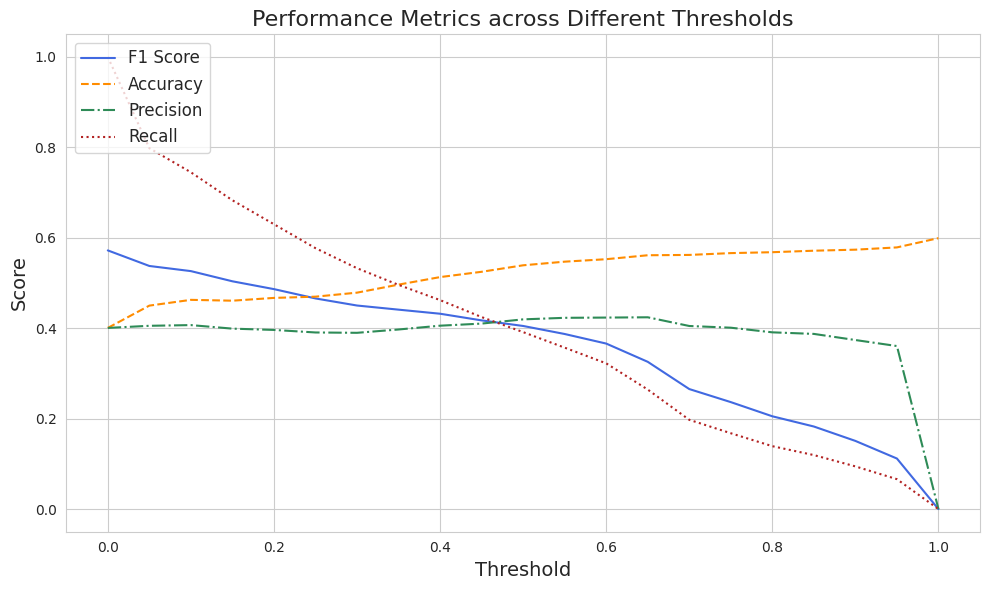

In [ ]:
# plot results


sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()


## 4) GRU Audio Emotion Feature

### Load Video, Audio Highlight Features

In [ ]:
import os

import numpy as np
import pandas as pd
import torch

In [ ]:
concatenate_vit_features = np.load('concatenate_vit_features_array.npy', allow_pickle=True)
concatenate_audio_features = np.load('gru_concatenate_audio_features_array.npy', allow_pickle=True)

labels = np.load('labels.npy', allow_pickle=True)
labels = [l.squeeze() for l in labels]

In [ ]:
print(concatenate_vit_features.shape)
print(concatenate_audio_features.shape)
print(concatenate_vit_features[64].shape)
print(concatenate_audio_features[64].shape)

(151,)
(151,)
(250, 768)
torch.Size([250, 128])


In [ ]:
concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])

<ipython-input-10-ef19289f87aa>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])
<ipython-input-10-ef19289f87aa>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  concatenate_vit_features = np.array([torch.tensor(t) for t in concatenate_vit_features])


In [ ]:
features_concatenate_list = []
cnt = 0
max_seq_len = 896
for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    if len(vit_features) == len(audio_features):
        concated_feature = torch.cat((vit_features, audio_features), dim=1)
    elif len(vit_features) > len(audio_features):
        # Split into columns of size 2
        pad = torch.zeros((len(vit_features)-len(audio_features), 128))
        audio_features = torch.cat((audio_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check1: {concated_feature.shape}')
    elif len(vit_features) < len(audio_features):
        pad = torch.zeros((len(audio_features)-len(vit_features), 768))
        vit_features = torch.cat((vit_features, pad), dim=0)
        concated_feature =torch.cat((vit_features, audio_features), dim=1)
        print(f'check2: {concated_feature.shape}')
    features_concatenate_list.append(concated_feature)

check2: torch.Size([106, 896])
check2: torch.Size([150, 896])
check2: torch.Size([72, 896])
check2: torch.Size([245, 896])


In [ ]:
len(features_concatenate_list), len(features_concatenate_list[2])

(151, 191)

### Dataset, Dataloader

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])
# Create an instance of dataset
md = MyDataset(features_concatenate_list,labels)
len(md), md[2][0].shape

<ipython-input-15-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([191, 896]))

In [ ]:
len(features_concatenate_list[0]), len(labels[0])

(250, 250)

In [ ]:
#### 인덱스 개수 맞추기
new_features_concatenate_list = []
new_labels = []
for concat, label in zip(features_concatenate_list, labels):
    if len(concat) == len(label):
        new_features_concatenate_list.append(concat)
        new_labels.append(label)
    elif len(concat) > len(label):
        # Split into columns of size 2
        idx = len(label)
        new_concat = concat[0:idx,:]
        new_features_concatenate_list.append(new_concat)
        new_labels.append(label)
        #print(f'check1: {new_concat.shape}, {label.shape}')
    elif len(concat) < len(label):
        idx = len(concat)
        new_label = label[0:idx]
        new_features_concatenate_list.append(concat)
        new_labels.append(new_label)
        #print(f'check2: {concat.shape}, {new_label.shape}')

### Split Train, Val, Test

In [ ]:
md = MyDataset(new_features_concatenate_list,new_labels)
len(md), md[0][0].shape

<ipython-input-15-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


(151, torch.Size([250, 896]))

In [ ]:
from sklearn.model_selection import train_test_split
# train, test split
train_val_idx, test_idx = train_test_split(range(len(md)), test_size=0.2, random_state=42)

# train, validation split
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")

train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

test_dataset = torch.utils.data.Subset(md, test_idx)
test_dataloader = DataLoader(test_dataset)

Train set size: 90
Validation set size: 30
Test set size: 31


### Multimodal Highlight Extraction Model

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        output = self.sigmoid(out)

        return output, out

### Model Training

In [ ]:
num_epochs = 100
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count

def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.
    pred = pred.view_as(target)
    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [ ]:
from tqdm import tqdm

# LSTM ADAM
train_loss = []
val_loss = []
weight_dir = 'model/weight/'

f1_best = 0
for epoch in tqdm(range(num_epochs), desc='Epochs', total=num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        if len(inputs) != len(labels):
            continue

        inputs = inputs.transpose(0, 1).to(device)
        labels = labels.squeeze(0).to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs, out = model(inputs)
        outputs = outputs.squeeze(1)

        loss = criterion(outputs, labels.float())

        # Backward and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_losses = AverageMeter()

    acc = 0
    gt_sum = 0
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0
    thres = 0.2
    acc = 0
    sum = 0
    pred_sum = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            if len(inputs) != len(labels):
                continue

            inputs = inputs.transpose(0, 1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs, out = model(inputs)

            loss = criterion(outputs.squeeze(1), labels.float())
            val_losses.update(loss, labels.size(0))

            TP, FP, TN, FN, pred_len, gt_len, pred = fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), thres)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc += TP + TN
            sum += len(out)

        if tp_sum > 0 and fp_sum > 0 and fn_sum > 0:
            precision = tp_sum / (tp_sum + fp_sum)
            recall = tp_sum / (tp_sum + fn_sum)
            f1 = (2 * precision * recall / (precision + recall))
            accuracy = acc / sum
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: {precision}, r: {recall}, f: {f1}")
            if f1_best < f1:
                f1_best = f1
        else:
            print(f"epoch [{epoch+1}/{num_epochs}], train_loss: {running_loss/len(train_dataloader)}, val_loss: {val_losses.avg}, p: 0, r: 0, f: 0")

        train_loss.append(running_loss / len(train_dataloader))
        val_loss.append(val_losses.avg.cpu().item())


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-15-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])
Epochs:   1%|          | 1/100 [00:07<12:09,  7.36s/it]

epoch [1/100], train_loss: 0.6670091029670503, val_loss: 0.6573218703269958, p: 0, r: 0, f: 0


Epochs:   2%|▏         | 2/100 [00:14<11:24,  6.99s/it]

epoch [2/100], train_loss: 0.6601117859284084, val_loss: 0.6572679877281189, p: 0, r: 0, f: 0


Epochs:   3%|▎         | 3/100 [00:22<12:05,  7.48s/it]

epoch [3/100], train_loss: 0.6589386251237658, val_loss: 0.6573156714439392, p: 0, r: 0, f: 0


Epochs:   4%|▍         | 4/100 [00:32<13:58,  8.74s/it]

epoch [4/100], train_loss: 0.6576139297750261, val_loss: 0.6573707461357117, p: 0, r: 0, f: 0


Epochs:   5%|▌         | 5/100 [00:41<14:04,  8.89s/it]

epoch [5/100], train_loss: 0.656212587820159, val_loss: 0.6580564975738525, p: 0, r: 0, f: 0


Epochs:   6%|▌         | 6/100 [00:51<14:30,  9.26s/it]

epoch [6/100], train_loss: 0.6524642795324326, val_loss: 0.6601510643959045, p: 0, r: 0, f: 0


Epochs:   7%|▋         | 7/100 [00:59<13:19,  8.60s/it]

epoch [7/100], train_loss: 0.6475487891170714, val_loss: 0.6630546450614929, p: 0, r: 0, f: 0


Epochs:   8%|▊         | 8/100 [01:06<12:43,  8.30s/it]

epoch [8/100], train_loss: 0.6421608936455515, val_loss: 0.6673980355262756, p: 0.3664638269100744, r: 0.9899543378995433, f: 0.534912410560079


Epochs:   9%|▉         | 9/100 [01:12<11:05,  7.32s/it]

epoch [9/100], train_loss: 0.6355492641528447, val_loss: 0.669169545173645, p: 0.36949035812672176, r: 0.9799086757990868, f: 0.5366341585396349


Epochs:  10%|█         | 10/100 [01:18<10:24,  6.94s/it]

epoch [10/100], train_loss: 0.6302527550193998, val_loss: 0.663378119468689, p: 0.36777909537523296, r: 0.991324200913242, f: 0.5365130359569998


Epochs:  11%|█         | 11/100 [01:25<10:26,  7.04s/it]

epoch [11/100], train_loss: 0.6261461700002352, val_loss: 0.6628583669662476, p: 0.36818876251909693, r: 0.9904109589041096, f: 0.5368147506496721


Epochs:  12%|█▏        | 12/100 [01:30<09:20,  6.37s/it]

epoch [12/100], train_loss: 0.6239068168732855, val_loss: 0.6628947854042053, p: 0.3655068584810974, r: 0.997716894977169, f: 0.5350146914789423


Epochs:  13%|█▎        | 13/100 [01:39<10:38,  7.34s/it]

epoch [13/100], train_loss: 0.6186262122872803, val_loss: 0.6641842722892761, p: 0.3663916484256609, r: 0.993607305936073, f: 0.5353672038381105


Epochs:  14%|█▍        | 14/100 [01:48<11:17,  7.88s/it]

epoch [14/100], train_loss: 0.617598490168651, val_loss: 0.6638458967208862, p: 0.36562918340026773, r: 0.997716894977169, f: 0.5351457261817291


Epochs:  15%|█▌        | 15/100 [01:58<11:43,  8.28s/it]

epoch [15/100], train_loss: 0.6148148513088624, val_loss: 0.6639527678489685, p: 0.3667843335014288, r: 0.9963470319634703, f: 0.5361838063644182


Epochs:  16%|█▌        | 16/100 [02:01<09:38,  6.88s/it]

epoch [16/100], train_loss: 0.6158823286493619, val_loss: 0.6666578650474548, p: 0.36570282466989806, r: 0.9990867579908675, f: 0.5354215098495044


Epochs:  17%|█▋        | 17/100 [02:05<08:03,  5.82s/it]

epoch [17/100], train_loss: 0.6110154348529048, val_loss: 0.6805432438850403, p: 0.36777909537523296, r: 0.991324200913242, f: 0.5365130359569998


Epochs:  18%|█▊        | 18/100 [02:08<06:58,  5.10s/it]

epoch [18/100], train_loss: 0.6107835451968842, val_loss: 0.6757246255874634, p: 0.3660086985613918, r: 0.9990867579908675, f: 0.535749265426053


Epochs:  19%|█▉        | 19/100 [02:13<06:42,  4.97s/it]

epoch [19/100], train_loss: 0.6086837534896201, val_loss: 0.684397280216217, p: 0.3678844519966015, r: 0.9885844748858448, f: 0.5362229102167182


Epochs:  20%|██        | 20/100 [02:16<06:04,  4.56s/it]

epoch [20/100], train_loss: 0.6080377616091734, val_loss: 0.6886727213859558, p: 0.36654325143049477, r: 0.9945205479452055, f: 0.5356615838662075


Epochs:  21%|██        | 21/100 [02:20<05:35,  4.24s/it]

epoch [21/100], train_loss: 0.604725332159756, val_loss: 0.7007477283477783, p: 0.36921494686321565, r: 0.9835616438356164, f: 0.5368893320039881


Epochs:  22%|██▏       | 22/100 [02:23<05:12,  4.01s/it]

epoch [22/100], train_loss: 0.6068148538366788, val_loss: 0.6998304724693298, p: 0.36880640217946536, r: 0.989041095890411, f: 0.5372690065732357


Epochs:  23%|██▎       | 23/100 [02:28<05:19,  4.14s/it]

epoch [23/100], train_loss: 0.601094540151664, val_loss: 0.706430196762085, p: 0.3675849247929694, r: 0.9931506849315068, f: 0.5365733316886641


Epochs:  24%|██▍       | 24/100 [02:32<05:15,  4.15s/it]

epoch [24/100], train_loss: 0.5947677097490265, val_loss: 0.7008814215660095, p: 0.3684836135167261, r: 0.9908675799086758, f: 0.537195197425424


Epochs:  25%|██▌       | 25/100 [02:35<04:49,  3.86s/it]

epoch [25/100], train_loss: 0.5920897728685911, val_loss: 0.7108932733535767, p: 0.3701276302173163, r: 0.9799086757990868, f: 0.5373059589384076


Epochs:  26%|██▌       | 26/100 [02:39<04:49,  3.91s/it]

epoch [26/100], train_loss: 0.5898536499615552, val_loss: 0.7106276750564575, p: 0.3698489010989011, r: 0.9835616438356164, f: 0.5375592712752683


Epochs:  27%|██▋       | 27/100 [02:44<04:59,  4.11s/it]

epoch [27/100], train_loss: 0.5861390660879099, val_loss: 0.7183818221092224, p: 0.36967808930425755, r: 0.9753424657534246, f: 0.5361445783132531


Epochs:  28%|██▊       | 28/100 [02:48<05:04,  4.24s/it]

epoch [28/100], train_loss: 0.5821682188401206, val_loss: 0.7169398665428162, p: 0.3679819224752303, r: 0.9666666666666667, f: 0.5330479667631877


Epochs:  29%|██▉       | 29/100 [02:52<04:43,  3.99s/it]

epoch [29/100], train_loss: 0.5788149065570906, val_loss: 0.7201029062271118, p: 0.3686643835616438, r: 0.9831050228310503, f: 0.536239103362391


Epochs:  30%|███       | 30/100 [02:55<04:32,  3.89s/it]

epoch [30/100], train_loss: 0.5750743813722188, val_loss: 0.7282187938690186, p: 0.3691122395377342, r: 0.9625570776255707, f: 0.5336033413491963


Epochs:  31%|███       | 31/100 [02:59<04:27,  3.88s/it]

epoch [31/100], train_loss: 0.5734423712361604, val_loss: 0.7212780117988586, p: 0.3690285917243829, r: 0.9488584474885845, f: 0.5313898478455441


Epochs:  32%|███▏      | 32/100 [03:04<04:36,  4.07s/it]

epoch [32/100], train_loss: 0.5711086994269863, val_loss: 0.7190227508544922, p: 0.3686494304827337, r: 0.9310502283105023, f: 0.528169926175366


Epochs:  33%|███▎      | 33/100 [03:07<04:17,  3.85s/it]

epoch [33/100], train_loss: 0.5682867299429037, val_loss: 0.7262909412384033, p: 0.37013100436681223, r: 0.9675799086757991, f: 0.5354390397978522


Epochs:  34%|███▍      | 34/100 [03:10<04:01,  3.65s/it]

epoch [34/100], train_loss: 0.5640713344625611, val_loss: 0.7181512117385864, p: 0.36922250089573627, r: 0.9410958904109589, f: 0.5303654143077715


Epochs:  35%|███▌      | 35/100 [03:13<03:50,  3.54s/it]

epoch [35/100], train_loss: 0.5640638336164152, val_loss: 0.7415978312492371, p: 0.3696490905750505, r: 0.9187214611872146, f: 0.5271845932136774


Epochs:  36%|███▌      | 36/100 [03:19<04:18,  4.04s/it]

epoch [36/100], train_loss: 0.5604214317139445, val_loss: 0.7372400164604187, p: 0.36900299850074963, r: 0.8990867579908676, f: 0.5232527238905129


Epochs:  37%|███▋      | 37/100 [03:24<04:33,  4.34s/it]

epoch [37/100], train_loss: 0.5574757905586416, val_loss: 0.7410141229629517, p: 0.36895533407161313, r: 0.9127853881278539, f: 0.5254994742376445


Epochs:  38%|███▊      | 38/100 [03:27<04:12,  4.08s/it]

epoch [38/100], train_loss: 0.5522628088417049, val_loss: 0.7519658803939819, p: 0.3714182735628041, r: 0.9410958904109589, f: 0.5326269543868717


Epochs:  39%|███▉      | 39/100 [03:30<03:53,  3.83s/it]

epoch [39/100], train_loss: 0.5566281724514233, val_loss: 0.730373740196228, p: 0.366510757717493, r: 0.8945205479452055, f: 0.5199734571997345


Epochs:  40%|████      | 40/100 [03:35<04:10,  4.18s/it]

epoch [40/100], train_loss: 0.5472807879281593, val_loss: 0.7665730118751526, p: 0.3726327515781656, r: 0.9164383561643835, f: 0.5298310454065469


Epochs:  41%|████      | 41/100 [03:39<03:58,  4.04s/it]

epoch [41/100], train_loss: 0.548442882789661, val_loss: 0.7561482787132263, p: 0.36537250786988457, r: 0.7949771689497717, f: 0.500647016534867


Epochs:  42%|████▏     | 42/100 [03:43<03:43,  3.85s/it]

epoch [42/100], train_loss: 0.5516970538294926, val_loss: 0.7640427350997925, p: 0.3746499906664178, r: 0.9164383561643835, f: 0.5318669670067577


Epochs:  43%|████▎     | 43/100 [03:46<03:33,  3.75s/it]

epoch [43/100], train_loss: 0.5363519407621222, val_loss: 0.7642197608947754, p: 0.37183634633682205, r: 0.8922374429223744, f: 0.5249160510409671


Epochs:  44%|████▍     | 44/100 [03:51<03:45,  4.02s/it]

epoch [44/100], train_loss: 0.5392654827530754, val_loss: 0.7634176015853882, p: 0.36145114622746494, r: 0.7415525114155251, f: 0.4860092772706868


Epochs:  45%|████▌     | 45/100 [03:55<03:40,  4.02s/it]

epoch [45/100], train_loss: 0.5360475449179325, val_loss: 0.7791752219200134, p: 0.37609774723176786, r: 0.8995433789954338, f: 0.5304254173397954


Epochs:  46%|████▌     | 46/100 [03:58<03:26,  3.82s/it]

epoch [46/100], train_loss: 0.5354564357406667, val_loss: 0.7574594020843506, p: 0.36357688113413306, r: 0.7611872146118721, f: 0.49210332103321036


Epochs:  47%|████▋     | 47/100 [04:02<03:21,  3.80s/it]

epoch [47/100], train_loss: 0.5422009751093962, val_loss: 0.7877404689788818, p: 0.3693659996259585, r: 0.9018264840182648, f: 0.5240811994162133


Epochs:  48%|████▊     | 48/100 [04:06<03:26,  3.96s/it]

epoch [48/100], train_loss: 0.5272944725981991, val_loss: 0.7839897274971008, p: 0.3705790905557715, r: 0.8707762557077625, f: 0.5199018538713195


Epochs:  49%|████▉     | 49/100 [04:11<03:27,  4.08s/it]

epoch [49/100], train_loss: 0.5198857634703422, val_loss: 0.833669126033783, p: 0.3677156177156177, r: 0.8643835616438356, f: 0.5159443990188062


Epochs:  50%|█████     | 50/100 [04:14<03:12,  3.86s/it]

epoch [50/100], train_loss: 0.5176781021110299, val_loss: 0.7704378962516785, p: 0.3609271523178808, r: 0.7465753424657534, f: 0.48660714285714285


Epochs:  51%|█████     | 51/100 [04:17<03:01,  3.71s/it]

epoch [51/100], train_loss: 0.535146197699295, val_loss: 0.7886301279067993, p: 0.3711631663974152, r: 0.8392694063926941, f: 0.5147017642117054


Epochs:  52%|█████▏    | 52/100 [04:21<02:59,  3.74s/it]

epoch [52/100], train_loss: 0.5087157204708395, val_loss: 0.8320397734642029, p: 0.368111064366849, r: 0.7990867579908676, f: 0.5040322580645161


Epochs:  53%|█████▎    | 53/100 [04:27<03:27,  4.41s/it]

epoch [53/100], train_loss: 0.5123115753363688, val_loss: 0.8720778822898865, p: 0.3681551828652253, r: 0.8319634703196347, f: 0.5104356352430313


Epochs:  54%|█████▍    | 54/100 [04:30<03:07,  4.08s/it]

epoch [54/100], train_loss: 0.5042393164368049, val_loss: 0.8551582098007202, p: 0.365196803788103, r: 0.5634703196347032, f: 0.4431675345663495


Epochs:  55%|█████▌    | 55/100 [04:34<02:59,  3.99s/it]

epoch [55/100], train_loss: 0.5193493791977137, val_loss: 0.7749714851379395, p: 0.36925258254000404, r: 0.8324200913242009, f: 0.5115756980496703


Epochs:  56%|█████▌    | 56/100 [04:39<03:02,  4.14s/it]

epoch [56/100], train_loss: 0.5003606179405728, val_loss: 0.8730166554450989, p: 0.37248117239975576, r: 0.8356164383561644, f: 0.5152752358158526


Epochs:  57%|█████▋    | 57/100 [04:43<03:06,  4.33s/it]

epoch [57/100], train_loss: 0.49464332531303323, val_loss: 0.8567983508110046, p: 0.3715872281351226, r: 0.7333333333333333, f: 0.4932432432432432


Epochs:  58%|█████▊    | 58/100 [04:47<02:48,  4.01s/it]

epoch [58/100], train_loss: 0.4943045336365079, val_loss: 0.8758012056350708, p: 0.3687194525904203, r: 0.8611872146118722, f: 0.5163586584531143


Epochs:  59%|█████▉    | 59/100 [04:50<02:39,  3.90s/it]

epoch [59/100], train_loss: 0.5066333547445538, val_loss: 0.8884531259536743, p: 0.3669364161849711, r: 0.7246575342465753, f: 0.48718342287029925


Epochs:  60%|██████    | 60/100 [04:54<02:39,  3.98s/it]

epoch [60/100], train_loss: 0.49860957624558877, val_loss: 0.8759011030197144, p: 0.3720883933904041, r: 0.8534246575342466, f: 0.5182309718563705


Epochs:  61%|██████    | 61/100 [04:59<02:44,  4.22s/it]

epoch [61/100], train_loss: 0.48897217070059723, val_loss: 0.864708423614502, p: 0.36717112922002326, r: 0.7200913242009133, f: 0.48635312259059366


Epochs:  62%|██████▏   | 62/100 [05:03<02:35,  4.09s/it]

epoch [62/100], train_loss: 0.5030495254586438, val_loss: 0.8994892239570618, p: 0.37215298667812635, r: 0.7908675799086758, f: 0.5061367621274108


Epochs:  63%|██████▎   | 63/100 [05:07<02:25,  3.94s/it]

epoch [63/100], train_loss: 0.4727270029960588, val_loss: 0.9436216354370117, p: 0.3640819964349376, r: 0.7461187214611872, f: 0.48936807427373463


Epochs:  64%|██████▍   | 64/100 [05:12<02:34,  4.29s/it]

epoch [64/100], train_loss: 0.4700766126460318, val_loss: 0.9240574240684509, p: 0.36450729927007297, r: 0.7296803652968037, f: 0.486157590508062


Epochs:  65%|██████▌   | 65/100 [05:16<02:33,  4.39s/it]

epoch [65/100], train_loss: 0.47186426351399857, val_loss: 0.9401469826698303, p: 0.37513018121224745, r: 0.8223744292237443, f: 0.5152338721212988


Epochs:  66%|██████▌   | 66/100 [05:20<02:18,  4.06s/it]

epoch [66/100], train_loss: 0.47725721591163567, val_loss: 0.9391699433326721, p: 0.36942675159235666, r: 0.6091324200913242, f: 0.45992070332701257


Epochs:  67%|██████▋   | 67/100 [05:23<02:09,  3.91s/it]

epoch [67/100], train_loss: 0.4826781892450122, val_loss: 0.903973400592804, p: 0.36393299978246685, r: 0.7639269406392694, f: 0.4930013260645351


Epochs:  68%|██████▊   | 68/100 [05:27<02:03,  3.85s/it]

epoch [68/100], train_loss: 0.45734544908122593, val_loss: 0.87165367603302, p: 0.36992728125733054, r: 0.7200913242009133, f: 0.4887649155431583


Epochs:  69%|██████▉   | 69/100 [05:32<02:08,  4.14s/it]

epoch [69/100], train_loss: 0.4613576604845245, val_loss: 0.9353129267692566, p: 0.3753056234718826, r: 0.8410958904109589, f: 0.5190194420963652


Epochs:  70%|███████   | 70/100 [05:35<01:57,  3.93s/it]

epoch [70/100], train_loss: 0.4587695444533084, val_loss: 0.899520993232727, p: 0.37149187592319055, r: 0.689041095890411, f: 0.4827255278310941


Epochs:  71%|███████   | 71/100 [05:38<01:46,  3.69s/it]

epoch [71/100], train_loss: 0.455416561927167, val_loss: 0.9846038818359375, p: 0.37579617834394907, r: 0.8082191780821918, f: 0.5130434782608696


Epochs:  72%|███████▏  | 72/100 [05:42<01:41,  3.62s/it]

epoch [72/100], train_loss: 0.43911978989338724, val_loss: 1.016839861869812, p: 0.36080536912751676, r: 0.6136986301369863, f: 0.4544378698224852


Epochs:  73%|███████▎  | 73/100 [05:46<01:44,  3.88s/it]

epoch [73/100], train_loss: 0.45042091073210033, val_loss: 0.9679636359214783, p: 0.37124364308830327, r: 0.7333333333333333, f: 0.4929404542664211


Epochs:  74%|███████▍  | 74/100 [05:50<01:42,  3.94s/it]

epoch [74/100], train_loss: 0.4613133761352502, val_loss: 0.8882817029953003, p: 0.3741851368970013, r: 0.917351598173516, f: 0.5315517925651542


Epochs:  75%|███████▌  | 75/100 [05:54<01:37,  3.89s/it]

epoch [75/100], train_loss: 0.45738867005444866, val_loss: 0.9571487307548523, p: 0.3658675799086758, r: 0.5853881278538813, f: 0.450298559887601


Epochs:  76%|███████▌  | 76/100 [05:58<01:30,  3.78s/it]

epoch [76/100], train_loss: 0.46090426383226357, val_loss: 1.040097951889038, p: 0.37469204927211647, r: 0.7639269406392694, f: 0.5027798647633358


Epochs:  77%|███████▋  | 77/100 [06:02<01:29,  3.89s/it]

epoch [77/100], train_loss: 0.44035669542782774, val_loss: 1.0422701835632324, p: 0.36963606735469856, r: 0.6214611872146119, f: 0.4635558583106267


Epochs:  78%|███████▊  | 78/100 [06:06<01:28,  4.00s/it]

epoch [78/100], train_loss: 0.4465313229246021, val_loss: 0.9426395297050476, p: 0.37711775779125706, r: 0.8232876712328767, f: 0.5172858987232822


Epochs:  79%|███████▉  | 79/100 [06:09<01:20,  3.84s/it]

epoch [79/100], train_loss: 0.4291013453415063, val_loss: 1.0817911624908447, p: 0.37521728333747206, r: 0.6899543378995434, f: 0.4860865369149107


Epochs:  80%|████████  | 80/100 [06:13<01:13,  3.69s/it]

epoch [80/100], train_loss: 0.41365997609325655, val_loss: 1.1621553897857666, p: 0.37794384057971014, r: 0.7621004566210046, f: 0.5052982137450802


Epochs:  81%|████████  | 81/100 [06:17<01:10,  3.72s/it]

epoch [81/100], train_loss: 0.4287295116182981, val_loss: 1.018619418144226, p: 0.3726193762075628, r: 0.6164383561643836, f: 0.4644761740925512


Epochs:  82%|████████▏ | 82/100 [06:21<01:13,  4.06s/it]

epoch [82/100], train_loss: 0.43074201406909396, val_loss: 1.1065962314605713, p: 0.37534304412075153, r: 0.8118721461187215, f: 0.5133535441027862


Epochs:  83%|████████▎ | 83/100 [06:25<01:06,  3.89s/it]

epoch [83/100], train_loss: 0.44842173185146145, val_loss: 1.0392308235168457, p: 0.37327823691460055, r: 0.7424657534246575, f: 0.49679193400549954


Epochs:  84%|████████▍ | 84/100 [06:28<00:59,  3.71s/it]

epoch [84/100], train_loss: 0.4323463951012349, val_loss: 1.06638503074646, p: 0.37118491921005387, r: 0.7552511415525114, f: 0.49774300331026183


Epochs:  85%|████████▌ | 85/100 [06:32<00:55,  3.72s/it]

epoch [85/100], train_loss: 0.4283869695090188, val_loss: 1.1495710611343384, p: 0.37809187279151946, r: 0.7817351598173516, f: 0.5096754986603156


Epochs:  86%|████████▌ | 86/100 [06:37<00:56,  4.07s/it]

epoch [86/100], train_loss: 0.41409874134064417, val_loss: 1.069268822669983, p: 0.37241735537190085, r: 0.6584474885844749, f: 0.4757505773672056


Epochs:  87%|████████▋ | 87/100 [06:41<00:52,  4.00s/it]

epoch [87/100], train_loss: 0.43291970109944994, val_loss: 1.1821370124816895, p: 0.36738746690203, r: 0.7602739726027398, f: 0.4953882772984231


Epochs:  88%|████████▊ | 88/100 [06:44<00:45,  3.82s/it]

epoch [88/100], train_loss: 0.43561991405939704, val_loss: 1.078426718711853, p: 0.36670341786108046, r: 0.7593607305936073, f: 0.49457249070631965


Epochs:  89%|████████▉ | 89/100 [06:47<00:39,  3.63s/it]

epoch [89/100], train_loss: 0.4490306363854163, val_loss: 1.0113698244094849, p: 0.3670768516368702, r: 0.7219178082191781, f: 0.48668616284438976


Epochs:  90%|█████████ | 90/100 [06:52<00:39,  3.97s/it]

epoch [90/100], train_loss: 0.41729845280147454, val_loss: 1.1849159002304077, p: 0.37130707251566697, r: 0.7575342465753425, f: 0.4983478522078702


Epochs:  91%|█████████ | 91/100 [06:56<00:36,  4.02s/it]

epoch [91/100], train_loss: 0.40375730689343575, val_loss: 1.1839672327041626, p: 0.36875547765118316, r: 0.7684931506849315, f: 0.49837133550488594


Epochs:  92%|█████████▏| 92/100 [06:59<00:30,  3.76s/it]

epoch [92/100], train_loss: 0.4007727100827752, val_loss: 1.2191604375839233, p: 0.3718358318997297, r: 0.6908675799086758, f: 0.4834638121105608


Epochs:  93%|█████████▎| 93/100 [07:03<00:25,  3.70s/it]

epoch [93/100], train_loss: 0.395567014016726, val_loss: 1.2817059755325317, p: 0.37615797172111165, r: 0.7045662100456621, f: 0.4904640813731724


Epochs:  94%|█████████▍| 94/100 [07:07<00:23,  3.89s/it]

epoch [94/100], train_loss: 0.40180995086168675, val_loss: 1.3310645818710327, p: 0.371497904257666, r: 0.7689497716894977, f: 0.5009668302840994


Epochs:  95%|█████████▌| 95/100 [07:12<00:20,  4.05s/it]

epoch [95/100], train_loss: 0.40398548239166604, val_loss: 1.2199010848999023, p: 0.3745042492917847, r: 0.6036529680365297, f: 0.46223776223776225


Epochs:  96%|█████████▌| 96/100 [07:15<00:15,  3.94s/it]

epoch [96/100], train_loss: 0.4151931034257157, val_loss: 1.3146259784698486, p: 0.36948871869178224, r: 0.815068493150685, f: 0.5084745762711864


Epochs:  97%|█████████▋| 97/100 [07:19<00:11,  3.85s/it]

epoch [97/100], train_loss: 0.4208422505788399, val_loss: 1.188414454460144, p: 0.37004515805318616, r: 0.6735159817351598, f: 0.47765544041450775


Epochs:  98%|█████████▊| 98/100 [07:23<00:07,  3.97s/it]

epoch [98/100], train_loss: 0.41269450520300477, val_loss: 1.2796119451522827, p: 0.36844464365755264, r: 0.7506849315068493, f: 0.49428743235117256


Epochs:  99%|█████████▉| 99/100 [07:28<00:04,  4.21s/it]

epoch [99/100], train_loss: 0.4017995983132803, val_loss: 1.2971866130828857, p: 0.3715873399371829, r: 0.7022831050228311, f: 0.48601674830146946


Epochs: 100%|██████████| 100/100 [07:31<00:00,  4.52s/it]

epoch [100/100], train_loss: 0.395501608018099, val_loss: 1.2758452892303467, p: 0.3729293809938971, r: 0.7812785388127854, f: 0.5048686928297432


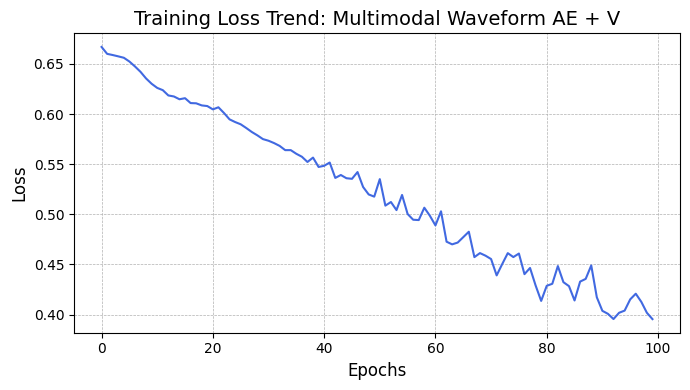

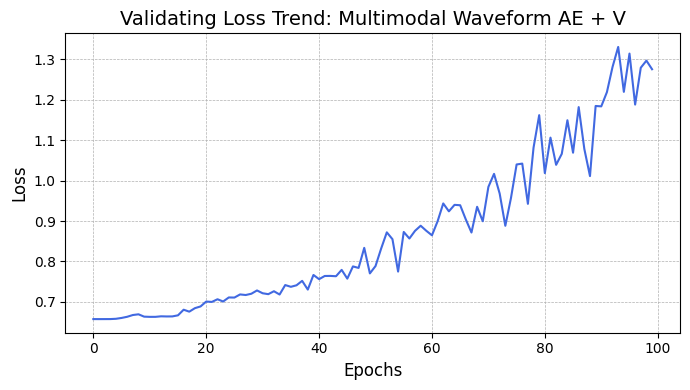

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(7,4))
plt.plot(train_loss, color='royalblue')
plt.title("Training Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,4))
plt.plot(val_loss, color='royalblue') .
plt.title("Validating Loss Trend: Multimodal MFCC AE + V", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Save Model

In [ ]:
PATH = 'model/highlight/gru_multimodal_highlight_detection_model.pt'

# model save
torch.save(model.state_dict(), PATH)

### Model Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4)


model.load_state_dict(torch.load('model/highlight/gru_multimodal_highlight_detection_model.pt'))

<All keys matched successfully>

In [ ]:
from tqdm.notebook import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_true = []
y_pred = []

for inputs, labels in tqdm_notebook(test_dataloader,total=len(test_dataloader), desc='Processing dataset'):
    with torch.no_grad():
        if inputs.shape[1]!= labels.shape[1] :
            continue
        model.eval()
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        # print(f'inputs.shape: {inputs.shape}, labels.shape: {labels.shape}')
        y_p, y_f = model(inputs)
        y_pred.append(y_p)
        y_true.append(labels)


Processing dataset:   0%|          | 0/31 [00:00<?, ?it/s]

<ipython-input-15-d374571182dd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.data[idx], torch.tensor(self.labels[idx])


In [ ]:
y_true = np.array([f.cpu() for f in y_true])
y_pred = np.array([p.cpu() for p in y_pred])
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
len(y_true), len(y_pred)

<ipython-input-29-6e15c587d4e2>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-29-6e15c587d4e2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_true = np.array([f.cpu() for f in y_true])
<ipython-input-29-6e15c587d4e2>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing on

(6975, 6975)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# initialize lists for storing results
results = []
f1_scores = []
acc_scores = []
prec_scores = []
rec_scores = []

# vary threshold and calculate scores
for THRES in np.arange(0, 1.05, 0.05):
    y_pred_t = np.where(y_pred > THRES, 1, 0)

    # calculate scores
    f1 = f1_score(y_true, y_pred_t, average='binary')
    acc = accuracy_score(y_true, y_pred_t)
    prec = precision_score(y_true, y_pred_t)
    rec = recall_score(y_true, y_pred_t)

    # store scores in a dictionary
    f1_scores.append(f1)
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)

    result = {
        'Threshold': THRES,
        'F1 Score': f1,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    results.append(result)

# create a DataFrame from the results
df = pd.DataFrame(results)
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold  F1 Score  Accuracy  Precision    Recall
0        0.00  0.572160  0.400717   0.400717  1.000000
1        0.05  0.554487  0.435556   0.405495  0.876565
2        0.10  0.545710  0.444301   0.405787  0.832916
3        0.15  0.538424  0.455771   0.407810  0.792129
4        0.20  0.527901  0.465090   0.408379  0.746333
5        0.25  0.512692  0.471541   0.406584  0.693739
6        0.30  0.505075  0.482724   0.409566  0.658676
7        0.35  0.493381  0.489749   0.409693  0.620036
8        0.40  0.480225  0.496918   0.409757  0.579964
9        0.45  0.463539  0.503226   0.408570  0.535599
10       0.50  0.445165  0.509677   0.407243  0.490877
11       0.55  0.428791  0.521004   0.410609  0.448658
12       0.60  0.411818  0.531900   0.414731  0.408945
13       0.65  0.393957  0.539928   0.417200  0.373166
14       0.70  0.362515  0.540645   0.408337  0.325939
15       0.75  0.335785  0.546810   0.406823  0.285868
16       0.80  0.304465  0.557849   0.411836  0.241503
17       0.85  0.249507  0.563584   0.401269  0.181038
18       0.90  0.184397  0.571326   0.388060  0.120930
19       0.95  0.125970  0.580215   0.380180  0.075492
20       1.00  0.000000  0.599283   0.000000  0.000000

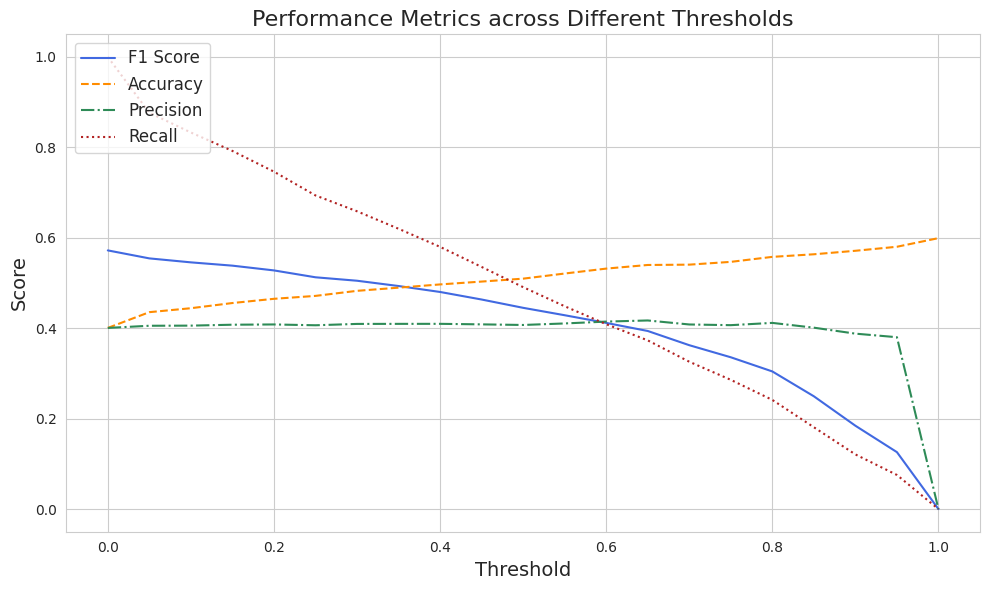

In [ ]:
# plot results


sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# 각 라인의 스타일과 색상을 지정합니다.
plt.plot(np.arange(0, 1.05, 0.05), f1_scores, label='F1 Score', color='royalblue', linestyle='-')
plt.plot(np.arange(0, 1.05, 0.05), acc_scores, label='Accuracy', color='darkorange', linestyle='--')
plt.plot(np.arange(0, 1.05, 0.05), prec_scores, label='Precision', color='seagreen', linestyle='-.')
plt.plot(np.arange(0, 1.05, 0.05), rec_scores, label='Recall', color='firebrick', linestyle=':')

plt.title("Performance Metrics across Different Thresholds", fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.legend(loc='upper left', fontsize=12)  # 범례 위치 조정
plt.tight_layout()
plt.show()


# Part 6 - Results

---

All figures are located in (LSTM, 1dConv, LSTM-att, GRU) order

## 1) Emotion Classification

<img src = "https://drive.google.com/uc?export=view&id=16qOhi9xexsBg8Ks4OEW3iFRzwLV_ZG_M" height = 600 width = 900>

## 2) Audio Highlight Detection

<img src = "https://drive.google.com/uc?export=view&id=13vGp_ddXZR7b4fMI3-xQrR909eeNKhoS" height = 600 width = 900>

<img src = "https://drive.google.com/uc?export=view&id=1TtCPPjtPmBbt9xctK1XF_5-eWIULg86Y" height = 600 width = 900>

## 3) ViT Loss

<img src = "https://drive.google.com/uc?export=view&id=1BtWAo9uspcjlLLo8JISV1UIHjCRuEJRm" height = 300 width = 900>

## 4) Final Score (Image + Audio)


<img src = "https://drive.google.com/uc?export=view&id=1P_BDX_Vkj5WAZ4NFVeoUoCjfdtt96mGf" height = 600 width = 900>

# Part 7 - Discussion

---

Since we have learned LSTM, CNN, Attention mechanism, and GRU, we have used deep learning model LSTM, CNN, LSTM with attention, and GRU to classify the emotion an input of audio highlight extraction. However, using Wav2Vec 2.0, a state-of-the-art method, would show a better performance.
It is a speech representation model developed by Facebook AI Research (FAIR). It is designed for unsupervised pre-training of speech representations, which can later be fine-tuned for various downstream speech-related tasks such as automatic speech recognition (ASR) and speaker identification.



<img src = "https://drive.google.com/uc?export=view&id=11Zwv2gpPcdOIuru__njs8Hs7FQcnfnmb" height = 400 width = 900>